In [1]:
%load_ext pycodestyle_magic
%flake8_on
%load_ext autoreload

In [2]:
%autoreload 2

In [8]:
"""Python code to classify X-ray sources by color.

Functionalities needed.

1. Line, step, scatter and histogram and kde plots
2. Plot net counts, bg/net and S/N ratio
3. Process detectors seperately and combine colors only optional
4. Cross-match 4XMM and CSC sources.
5. Compare with Haley et al. sources.
"""


import copy
import os
import glob2
import warnings
import xspec
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from scipy.ndimage import median_filter


# Plot functions
def set_plotparams(plottype):
    """Set plot parameters."""
    if plottype == 'notebook':
        plt.rcParams["figure.figsize"] = (20, 15)
        plt.rcParams["axes.titlesize"] = 24
        plt.rcParams["axes.labelsize"] = 24
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 10
        plt.rcParams["xtick.labelsize"] = 20
        plt.rcParams["ytick.labelsize"] = 20
        plt.rcParams["legend.fontsize"] = 20
        plt.rcParams['xtick.major.size'] = 16
        plt.rcParams['xtick.minor.size'] = 8
        plt.rcParams['ytick.major.size'] = 16
        plt.rcParams['ytick.minor.size'] = 8
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'presentation':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 16
        plt.rcParams["axes.labelsize"] = 14
        plt.rcParams["lines.linewidth"] = 3
        plt.rcParams["lines.markersize"] = 5
        plt.rcParams["xtick.labelsize"] = 12
        plt.rcParams["ytick.labelsize"] = 12
        plt.rcParams["legend.fontsize"] = 12
        plt.rcParams['xtick.major.size'] = 8
        plt.rcParams['xtick.minor.size'] = 4
        plt.rcParams['ytick.major.size'] = 8
        plt.rcParams['ytick.minor.size'] = 4
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'inout'
        plt.rcParams['ytick.direction'] = 'inout'
    elif plottype == 'paper1':
        plt.rcParams["figure.figsize"] = (4, 3)
        plt.rcParams["axes.titlesize"] = 14
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'
    elif plottype == 'paper2':
        plt.rcParams["figure.figsize"] = (8, 6)
        plt.rcParams["axes.titlesize"] = 20
        plt.rcParams["axes.labelsize"] = 12
        plt.rcParams["lines.linewidth"] = 2
        plt.rcParams["lines.markersize"] = 2
        plt.rcParams["xtick.labelsize"] = 10
        plt.rcParams["ytick.labelsize"] = 10
        plt.rcParams["legend.fontsize"] = 10
        plt.rcParams['xtick.major.size'] = 6
        plt.rcParams['xtick.minor.size'] = 3
        plt.rcParams['ytick.major.size'] = 6
        plt.rcParams['ytick.minor.size'] = 3
        plt.rcParams['xtick.top'] = True
        plt.rcParams['ytick.right'] = True
        plt.rcParams['xtick.direction'] = 'in'
        plt.rcParams['ytick.direction'] = 'in'


def plotline_scatter(xdatas, ydatas, pl_types=None, axs=None, xlabel=None,
                     ylabel=None, pl_labels=None, styles=None, colors=None,
                     yscale='linear', title=None, ylim=None, figsize=None):
    """Plot line, step and scatter plots."""
    if pl_types is None:
        pl_types = ['line']*len(ydatas)
    if axs is None:
        fig, axs = plt.subplots(figsize=figsize)
    if pl_labels is None:
        pl_labels = [None]*len(ydatas)
    if styles is None:
        styles = ['-']*len(ydatas)
    if colors is None:
        if len(ydatas) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(ydatas) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(ydatas/9)+1)))

    axs.set_title(title)
    if ylim is not None:
        axs.set_ylim(ylim[0], ylim[1])
    axs.set_xlabel(xlabel)
    axs.set_xscale('log')
    axs.set_yscale(yscale)
    axs.set_ylabel(ylabel)
    for i, pl_type in enumerate(pl_types):
        if pl_type == 'line':
            axs.plot(xdatas[i], ydatas[i], linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        elif pl_type == 'scatter':
            if styles[i] == '-':
                styles[i] = 'o'
            axs.scatter(xdatas[i], ydatas[i], marker=styles[i],
                        label=pl_labels[i], color=colors[i])
        elif pl_type == 'step':
            ydatas[i] = np.append(ydatas[i], ydatas[i].copy()[-1])
            axs.step(xdatas[i], ydatas[i], where='post', linestyle=styles[i],
                     label=pl_labels[i], color=colors[i])
        else:
            raise ValueError("pl_type can only be 'line' or 'scatter'. Got " +
                             pl_type)
    axs.legend()
    return axs


def plothist(data_arr, data2=None, axs=None, bins=None, xlabel=None,
             ylabel=None, pl_labels=None, pl_type=None, cbar_label=None,
             colors=None):
    """Plot 1D and 2D histograms."""
    if axs is None:
        fig, axs = plt.subplots()
    if pl_type is None:
        pl_type = 'withoutkde'
    if pl_labels is None and isinstance(data_arr[0], (list, np.ndarray)):
        pl_labels = [None]*len(data_arr)
    if colors is None:
        if len(data_arr) <= 4:
            colors = ['#004488', '#ddaa33', '#bb5566', '#000000']
        elif len(data_arr) <= 9:
            colors = ['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      'b57de9', 'ff9468', '9cee81', '00d2ff']
        else:
            warnings.warn('Too many plot elements. Colors will be repeated.')
            colors = (['#000000', '#00287c', '#89003e', '#6e5700', '#008f75',
                      '#b57de9', '#ff9468', '#9cee81', '#00d2ff'] *
                      (int(len(data_arr/9)+1)))
    if colors is None and data2 is not None:
        colors = 'plasma_r'
    axs.set_xlabel(xlabel)
    if data2 is None:
        if pl_type == 'withkde':
            if ylabel is None:
                ylabel = 'Density per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, density=True, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            if not isinstance(data_arr[0], (list, np.ndarray)):
                data_arr = [data_arr]
            for i, data in enumerate(data_arr):
                if pl_labels[i] is not None:
                    sns.kdeplot(x=data, label=pl_labels[i]+'_kde', ax=axs,
                                color=colors[i])
                else:
                    sns.kdeplot(x=data, ax=axs)
            axs.legend()
        else:
            if ylabel is None:
                ylabel = '# per bin'
            axs.set_ylabel(ylabel)
            axs.hist(data_arr, bins=bins, label=pl_labels,
                     color=colors[:len(data_arr)])[:-1]
            axs.legend()
    else:
        # 2D hist
        axs.set_ylabel(ylabel)
        if bins is None:
            bins = 10
        if pl_type == 'withkde':
            histplot = axs.hist2d(data_arr, data2, bins=bins, density=True,
                                  cmap=colors)[-1]
            sns.kdeplot(x=data_arr, y=data2, ax=axs)
            cbar = plt.colorbar(mappable=histplot, ax=axs, color='k')
            if cbar_label is None:
                cbar_label = 'Density per bin'
            cbar.set_label(cbar_label)
        else:
            histplot = axs.hist2d(data_arr, data2)[-1]
            cbar = plt.colorbar(mappable=histplot, ax=axs)
            if cbar_label is None:
                cbar_label = '# per bin'
            cbar.set_label(cbar_label)
    return axs


def plot_subplots(numrows, numcols, xdatas_arr, ydatas_arr, title=None,
                  subp_types_arr=None, pl_types_arr=None, xlabel_arr=None,
                  ylabel_arr=None, pl_labels_arr=None, styles_arr=None,
                  bins_arr=None, cbar_labels=None, yscale_arr=None,
                  ylim_arr=None, colors_arr=None):
    """Plot subplots"""
    if subp_types_arr is None:
        subp_types_arr = [['linescatter']*numcols]*numrows
    if pl_types_arr is None:
        pl_types_arr = [[None]*numcols]*numrows
    if pl_labels_arr is None:
        pl_labels_arr = [[None]*numcols]*numrows
    if xlabel_arr is None:
        xlabel_arr = [[None]*numcols]*numrows
    if ylabel_arr is None:
        ylabel_arr = [[None]*numcols]*numrows
    if styles_arr is None:
        styles_arr = [[None]*numcols]*numrows
    if bins_arr is None:
        bins_arr = [[None]*numcols]*numrows
    if cbar_labels is None:
        cbar_labels = [[None]*numcols]*numrows
    if yscale_arr is None:
        yscale_arr = [['linear']*numcols]*numrows
    if ylim_arr is None:
        ylim_arr = [[None]*numcols]*numrows
    if colors_arr is None:
        colors_arr = [[None]*numcols]*numrows

    # Checking if all the arrays are 2D
    if not isinstance(subp_types_arr[0], list):
        subp_types_arr = list(map(list, zip(*[subp_types_arr])))
    if not isinstance(pl_labels_arr[0], list):
        pl_labels_arr = list(map(list, zip(*[pl_labels_arr])))
    if not isinstance(xlabel_arr[0], list):
        xlabel_arr = list(map(list, zip(*[xlabel_arr])))
    if not isinstance(ylabel_arr[0], list):
        ylabel_arr = list(map(list, zip(*[ylabel_arr])))

    # Calling the figure and axes
    fig, axes = plt.subplots(numrows, numcols)
    fig.suptitle(title)
    axes = axes.reshape(numrows, numcols)
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) - 4*(numcols-1))
    print(plt.rcParams["legend.fontsize"])
    if numrows == 1 and numcols == 1:
        initial_figsize = plt.rcParams["figure.figsize"]
        plt.rcParams["figure.figsize"] = (12, 9)

    for i in range(numrows):
        for j in range(numcols):
            if subp_types_arr[i][j] == 'linescatter':
                plotline_scatter(
                    xdatas_arr[i][j], ydatas_arr[i][j], pl_types_arr[i][j],
                    axs=axes[i][j], xlabel=xlabel_arr[i][j],
                    ylabel=ylabel_arr[i][j], pl_labels=pl_labels_arr[i][j],
                    styles=styles_arr[i][j], yscale=yscale_arr[i][j],
                    ylim=ylim_arr[i][j], colors=colors_arr[i][j])
            elif subp_types_arr[i][j] == 'hist':
                plothist(xdatas_arr[i][j], ydatas_arr[i][j], axs=axes[i][j],
                         bins=bins_arr[i][j], xlabel=xlabel_arr[i][j],
                         ylabel=ylabel_arr[i][j],
                         pl_labels=pl_labels_arr[i][j],
                         pl_type=pl_types_arr[i][j],
                         cbar_label=cbar_labels[i][j], colors=colors_arr[i][j])
            else:
                print('subplot type can be linescatter or hist')
    plt.tight_layout()
    plt.rcParams["legend.fontsize"] = (
        float(plt.rcParams["legend.fontsize"]) + 4*(numcols-1))
    if numrows == 1 and numcols == 1:
        plt.rcParams["figure.figsize"] = initial_figsize
    return fig, axes


def filter_specs(net_counts, bg_counts, min_netcounts=None, maxbg_ratio=None,
                 det_mask=None):
    """Filter specs."""
    bgratio = bg_counts/net_counts
    filter_mask = det_mask.copy()
    if det_mask is None:
        det_mask = np.ones(len(net_counts), dtype=bool)
    if min_netcounts is not None:
        filter_mask[net_counts < min_netcounts] = False
    if maxbg_ratio is not None:
        filter_mask[bgratio > maxbg_ratio] = False
    return filter_mask


def load_sim_xmmspec(folder, background=False, numsim=10000, basename=None):
    """Load simulated XMM MOS and PN spectra."""
    if basename is None:
        basename = ''
    pn_specs = np.zeros((numsim, 4096), dtype=np.float64)
    pn_bgspecs = np.zeros((numsim, 4096), dtype=np.float64)
    mos_specs = np.zeros((numsim, 2400), dtype=np.float64)
    mos_bgspecs = np.zeros((numsim, 2400), dtype=np.float64)
    pn_mask = np.zeros(numsim, dtype=bool)
    mos_mask = np.zeros(numsim, dtype=bool)
    for i in range(numsim):
        pnfile = folder + basename + str(i) + '_PN.fak'
        mosfile = folder + basename + str(i) + '_MOS.fak'
        if os.path.isfile(pnfile):
            pn_mask[i] = True
            spec_data = fits.open(pnfile)
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pnfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                pn_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
        if os.path.isfile(mosfile):
            mos_mask[i] = True
            spec_data = fits.open(mosfile)
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-4] + '_bkg.fak'
                bgspec_data = fits.open(bgfile)
                mos_bgspecs[i] = bgspec_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bgspec_data[1].header['backscal'])
    return ([pn_mask, mos_mask], [pn_specs, mos_specs],
            [pn_bgspecs, mos_bgspecs])


def load_xmmspec_observed(folder, background=False):
    """Load Observed XMM spec."""
    pn_specfiles = glob2.glob(folder + '*PN_combined_src_grp.ds')
    print('# PN files init:', len(pn_specfiles))
    mos_specfiles = glob2.glob(folder + '*MOS_combined_src_grp.ds')
    print('# PN files init:', len(pn_specfiles))
    num_combined = len(glob2.glob(folder + '*PN_MOS_combined_src.png'))
    num_sources = len(pn_specfiles) + len(mos_specfiles) - num_combined
    pn_specs = np.zeros((num_sources, 4096), dtype=float)
    pn_mask = np.zeros(num_sources, dtype=bool)
    mos_specs = np.zeros((num_sources, 2400), dtype=float)
    mos_mask = np.zeros(num_sources, dtype=bool)
    pn_bgspecs = np.zeros((num_sources, 4096), dtype=float)
    mos_bgspecs = np.zeros((num_sources, 2400), dtype=float)
    source_nums = np.zeros(num_sources, dtype=object)
    for i in range(num_sources):
        if i < len(pn_specfiles):
            pn_mask[i] = True
            source_nums[i] = pn_specfiles[i].split('/')[-1].split('_')[0]
            spec_data = fits.open(pn_specfiles[i])
            pn_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = pn_specfiles[i][:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                pn_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
            if os.path.isfile(folder + source_nums[i] +
                              '_MOS_combined_src_grp.ds'):
                mosfile = folder + source_nums[i] + '_MOS_combined_src_grp.ds'
                spec_data = fits.open(mosfile)
                mos_mask[i] = True
                mos_specfiles.remove(mosfile)
                mos_specs[i] = spec_data[1].data['counts']
                if background:
                    bgfile = mosfile[:-10] + 'bkg_grp.ds'
                    bg_data = fits.open(bgfile)
                    mos_bgspecs[i] = bg_data[1].data['counts']*(
                        spec_data[1].header['backscal'] /
                        bg_data[1].header['backscal'])
        else:
            mos_mask[i] = True
            source_nums[i] = (
                mos_specfiles[i-len(pn_bgspecs)].split('/')[-1].split('_')[0])
            spec_data = fits.open(mos_specfiles[i-len(pn_bgspecs)])
            mos_specs[i] = spec_data[1].data['counts']
            if background:
                bgfile = mosfile[:-10] + 'bkg_grp.ds'
                bg_data = fits.open(bgfile)
                mos_bgspecs[i] = bg_data[1].data['counts']*(
                    spec_data[1].header['backscal'] /
                    bg_data[1].header['backscal'])
    return (source_nums, [pn_mask, pn_specs, pn_bgspecs],
            [mos_mask, mos_specs, mos_bgspecs])


def load_chandraspec_sim(folder, background=False, num_sim=10000,
                         basename=None):
    """Load Chandra simulate spectra."""
    if basename is None:
        basename = ''
    specs = np.zeros((num_sim, 1024), dtype=float)
    bg_specs = np.zeros((num_sim, 1024), dtype=float)
    for i in range(num_sim):
        spec_file = folder + basename + str(i) + '.fak'
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bgspec_file = folder + basename + str(i) + '_bkg.fak'
            bg_data = fits.open(bgspec_file)
            bg_specs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return specs, bg_specs


def load_chandraspec_obs(folder, background=True):
    spec_files = glob2.glob(folder + '/*/*_combined_src.pi')
    spec_names = np.zeros(len(spec_files), dtype=object)
    specs = np.zeros((len(spec_files), 1024), dtype=float)
    bgspecs = np.zeros((len(spec_files), 1024), dtype=float)
    for i, spec_file in enumerate(spec_files):
        spec_file_base = os.path.basename(spec_file)
        spec_names[i] = spec_file_base.split('_')[0]
        spec_data = fits.open(spec_file)
        specs[i] = spec_data[1].data['counts']
        if background:
            bg_file = spec_file[:-6] + 'bkg.pi'
            bg_data = fits.open(bg_file)
            bgspecs[i] = bg_data[1].data['counts'] * (
                spec_data[1].header['backscal']/bg_data[1].header['backscal'])
    return spec_names, specs, bgspecs


def get_counts_enrange(spec, en_range, ebin_channels, floor_counts=None):
    """Get counts in the given energy range."""
    elow_index = np.where(ebin_channels >= en_range[0])[0][0]
    ehigh_index = np.where(ebin_channels <= en_range[1])[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[elow_index:ehigh_index])
    else:
        counts_enrange = np.sum(spec[:, elow_index:ehigh_index], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                counts_enrange = floor_counts
        else:
            counts_enrange[counts_enrange < floor_counts] = floor_counts
    return counts_enrange, elow_index, ehigh_index


def get_counts_enrange2(spec, en_range, ebin_channels, floor_counts=None):
    """Another method to get counts"""
    en_mask = np.logical_and(ebin_channels >= en_range[0],
                             ebin_channels <= en_range[1])
    elow_index = np.where(en_mask)[0][0]
    ehigh_index = np.where(en_mask)[0][-1]
    if len(spec.shape) == 1:
        counts_enrange = np.sum(spec[en_mask])
    else:
        counts_enrange = np.sum(spec[:, en_mask], axis=1)
    if floor_counts is not None:
        if len(spec.shape) == 1:
            if counts_enrange < floor_counts:
                floor_counts = 0
        else:
            counts_enrange[counts_enrange < floor_counts] = 0
    return counts_enrange, elow_index, ehigh_index


def get_summary_det(src_spec, bg_spec, ebins, en_range=None,
                    det_mask=None, src_sig=None):
    """Get summary of the spectra for given detector."""
    if en_range is None:
        en_range = [0.2, 10.0]
    net_spec = src_spec - bg_spec
    net_counts, en_lowindex, en_highindex = get_counts_enrange(
        net_spec, en_range, ebins)
    if det_mask is None:
        det_mask = np.ones(len(src_spec), dtype=bool)
    det_mask[net_counts < 1] = False
    net_spec = net_spec[:, en_lowindex:en_highindex]
    bg_counts = get_counts_enrange(bg_spec, en_range, ebins)[0]
    norm_spec = (net_spec.transpose()/net_counts).transpose()
    bg_counts[bg_counts/net_counts < 1.0E-6] = 1.0E-6
    if src_sig is not None:
        det_mask[net_counts < src_sig*bg_counts**0.5] = False
    return (norm_spec, net_counts, bg_counts, det_mask, en_lowindex,
            en_highindex)


def join_lists_3d(list1_2d, list2_2d, list3_2d=None):
    """Join 2 lists along another dimention."""
    joined_list = []
    for i, row in enumerate(list1_2d):
        if list3_2d is None:
            joined_list.append([row, list2_2d[i]])
        else:
            joined_list.append([row, list2_2d[i], list3_2d[i]])
    return joined_list


def join_string_lists(list1_1d, list2_1d):
    """Outer product like addition of 2 strings"""
    joined_list = []
    join_list_row = None
    for string2 in list2_1d:
        for string1 in list1_1d:
            if join_list_row is None:
                join_list_row = [string1 + ' [' + string2 + ']']
            else:
                join_list_row.append(string1 + ' [' + string2 + ']')
        joined_list.append(copy.copy(join_list_row))
        join_list_row = None
    return joined_list


def plot_spec_summary(sim_src_spec_arr, sim_bg_spec_arr, obs_src_spec_arr,
                      obs_bg_spec_arr, ebins_arr, det_names=None, e_range=None,
                      plot=True, det_mask_sim_arr=None, det_mask_obs_arr=None):
    """Plot spec summary.

    1. Mean normalized spectra (also add error fn.)
    2. Net count, Net count/Bg counts, signal-to-noise ratio plots for
       each det.
    """
    norm_specs = []
    netcounts = []
    bgcounts = []
    ebins_lowhigh_indices = []
    if plot:
        ebins_refined = []
        norm_specs_forplot = []
        netcounts_forplot = []
        bg_net_ratio_forplot = []
        s_to_n_ratio_forplot = []
    if det_mask_sim_arr is None:
        det_mask_sim_arr = [None]*len(sim_src_spec_arr)
    if det_mask_obs_arr is None:
        det_mask_obs_arr = [None]*len(obs_src_spec_arr)
    if det_names is None:
        det_names = ['']*len(sim_src_spec_arr)

    for i, sim_src_specs in enumerate(sim_src_spec_arr):
        (sim_norm_spec, sim_netcounts, sim_bgcounts, sim_detmask,
         en_lowindex, en_highindex) = get_summary_det(
            sim_src_specs, sim_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_sim_arr[i]), 3.0)
        (obs_norm_spec, obs_netcounts, obs_bgcounts,
         obs_detmask) = get_summary_det(
            obs_src_spec_arr[i], obs_bg_spec_arr[i], ebins_arr[i], e_range,
            copy.copy(det_mask_obs_arr[i]), 3.0)[:4]
        norm_specs.append([sim_norm_spec, obs_norm_spec])
        netcounts.append([sim_netcounts, obs_netcounts])
        bgcounts.append([sim_bgcounts, obs_bgcounts])
        ebins_lowhigh_indices.append([en_lowindex, en_highindex])
        det_mask_sim_arr[i] = sim_detmask
        det_mask_obs_arr[i] = obs_detmask
        if plot:
            ebins_refined.append(ebins_arr[i][en_lowindex:en_highindex])
            filter_size = int(0.2/(ebins_arr[i][en_lowindex+1] -
                                   ebins_arr[i][en_lowindex]))
            norm_specs_forplot.append([
                median_filter(np.mean(sim_norm_spec[sim_detmask], axis=0),
                              size=filter_size),
                median_filter(np.mean(obs_norm_spec[obs_detmask], axis=0),
                              size=filter_size)])
            netcounts_forplot.append([np.log10(sim_netcounts[sim_detmask]),
                                      np.log10(obs_netcounts[obs_detmask])])
            bg_net_ratio_forplot.append([
                np.log10((sim_bgcounts/sim_netcounts)[sim_detmask]),
                np.log10((obs_bgcounts/obs_netcounts)[obs_detmask])])
            s_to_n_ratio_forplot.append([
                np.log10((sim_netcounts /
                         (sim_netcounts+sim_bgcounts)**0.5)[sim_detmask]),
                np.log10((obs_netcounts /
                         (obs_netcounts+obs_bgcounts)**0.5)[obs_detmask])]
            )

    if plot is False:
        return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
                det_mask_sim_arr, det_mask_obs_arr)

    for i, norm_spec_sim_obs in enumerate(norm_specs_forplot):
        plotline_scatter([ebins_refined[i], ebins_refined[i]],
                         norm_spec_sim_obs, xlabel='Energy (keV)',
                         ylabel='Smoothed mean normalized spectra',
                         pl_labels=['Sim. ' + det_names[i] + ' spectra',
                                    'Obs. ' + det_names[i] + ' spectra'],
                         title=('Simulated and Observed ' + det_names[i] +
                                ' spectra'),
                         figsize=(12, 9))

    hist1D_joined_list = join_lists_3d(netcounts_forplot,
                                       bg_net_ratio_forplot,
                                       s_to_n_ratio_forplot)
    plot_subplots(
        len(norm_specs_forplot), 3, hist1D_joined_list,
        [[None]*3]*len(norm_specs_forplot),
        title='1D histograms of net and background counts',
        xlabel_arr=join_string_lists(
            ['log (Net counts)', 'log (Bg counts/Net counts)',
             'Signal-to-Noise Ratio'], det_names),
        ylabel_arr=[['# density per bin']*3]*len(norm_specs_forplot),
        subp_types_arr=[['hist']*3]*3,
        pl_types_arr=[['withkde']*3]*3,
        pl_labels_arr=[
            [['Simulated MSPs', 'Observed sources']]*3]*len(norm_specs_forplot)
    )

    return (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices,
            det_mask_sim_arr, det_mask_obs_arr)


def get_enbins_centres(resp_file):
    """Get Energy bins and centres."""
    response = fits.open(resp_file)
    energy_bins = response[2].data
    emin = energy_bins['E_MIN']
    emax = energy_bins['E_MAX']
    e_centres = 0.5*(emin + emax)
    return np.append(emin, emax[-1]), e_centres


def get_line_cont_counts(src_spec, bg_spec, ebins, net_spec=None,
                         range_fe=None, cont1_range=None, cont2_range=None):
    """Get line and continuum counts"""
    if net_spec is None:
        net_spec = src_spec - bg_spec
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if cont1_range is None:
        cont1_range = [5.8, 6.2]
    if cont2_range is None:
        cont2_range = [7.2, 7.6]
    sim_fe_net = get_counts_enrange(net_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_src = get_counts_enrange(src_spec, range_fe, ebins,
                                    floor_counts=0)[0]
    sim_fe_bg = get_counts_enrange(bg_spec, range_fe, ebins,
                                   floor_counts=0)[0]

    sim_cont1_net = get_counts_enrange(net_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_src = get_counts_enrange(src_spec, cont1_range, ebins,
                                       floor_counts=0)[0]
    sim_cont1_bg = get_counts_enrange(bg_spec, cont1_range, ebins,
                                      floor_counts=0)[0]

    sim_cont2_net = get_counts_enrange(net_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_src = get_counts_enrange(src_spec, cont2_range, ebins,
                                       floor_counts=0)[0]
    sim_cont2_bg = get_counts_enrange(bg_spec, cont2_range, ebins,
                                      floor_counts=0)[0]
    return ([sim_fe_net, sim_fe_src, sim_fe_bg],
            [sim_cont1_net, sim_cont1_src, sim_cont1_bg],
            [sim_cont2_net, sim_cont2_src, sim_cont2_bg])


def get_colors_basic(counts_line_net, counts_cont1_net, counts_cont2_net,
                     mask=None):
    """Get colors."""
    if mask is None:
        mask = np.ones(len(counts_line_net), dtype=bool)
    colors = counts_line_net/(counts_cont1_net + counts_cont2_net)
    colors[~mask] = np.nan
    return colors


def get_colors_binned(colors, src_prop, srcprop_bins, mask=None):
    """Get expected color for given bins."""
    mean_colors = np.zeros(len(srcprop_bins)-1)
    median_colors = np.zeros(len(srcprop_bins)-1)
    colors_std = np.zeros(len(srcprop_bins)-1)
    for i, bin_edge in enumerate(srcprop_bins[:-1]):
        mean_colors[i], median_colors[i], colors_std[i] = get_colors_perbin(
            colors, src_prop, [bin_edge, srcprop_bins[i+1]])
    return mean_colors, colors_std, median_colors


def get_colors_perbin(colors, src_prop, bin_edges):
    """Get expected color for each bin"""
    mask = np.where(np.logical_and(np.logical_and(src_prop >= bin_edges[0],
                                                  src_prop < bin_edges[1]),
                                   np.isfinite(colors)))
    bin_colors = colors[mask]
    # return np.mean(bin_colors), np.median(bin_colors), np.std(bin_colors)
    return sigma_clipped_stats(bin_colors, sigma=5)


def bin_colors_withprop(colors, prop_list, prop_listnames, obs_colors,
                        obs_props, prop_binslist=None, plot=True, plot_det=''):
    """Bin colors with properties."""
    mean_colors_withprop = []
    median_colors_withprop = []
    std_colors_withprop = []
    if prop_binslist is None:
        prop_binslist = []
        no_given_bins = True
    else:
        no_given_bins = False
    for i in range(len(prop_list)):
        print('Calaculating mean and standard deviation in colors vs. ' +
              prop_listnames[i])
        if no_given_bins:
            prop_bins = 10**np.linspace(
                np.log10(max(0.00001, np.min(prop_list[i]))),
                np.log10(min(1.0E+5, np.max(prop_list[i]))), 21)
            prop_binslist.append(prop_bins)
        mean_colors, colors_std, median_colors = get_colors_binned(
            colors, prop_list[i], prop_binslist[i])
        mean_colors_withprop.append(mean_colors)
        std_colors_withprop.append(colors_std)
        median_colors_withprop.append(median_colors)
        if plot:
            plot_subplots(
                1, 2, [[[prop_list[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])],
                       [obs_props[i], get_bincenters(prop_binslist[i]),
                        get_bincenters(prop_binslist[i])]]],
                [[[colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std],
                 [obs_colors, mean_colors + 2*colors_std,
                  mean_colors - 2*colors_std]]],
                subp_types_arr=[['linescatter', 'linescatter']],
                pl_types_arr=[[['scatter', 'step', 'step'],
                              ['scatter', 'step', 'step']]],
                xlabel_arr=[[prop_listnames[i], prop_listnames[i]]],
                ylabel_arr=[['Simulated source colors',
                            'Observed source colors']],
                pl_labels_arr=[[['Colors', 'Mean + 2.0std', 'Mean - 2.0std'],
                                ['Colors', 'Mean + 2.0std', 'Mean - 2.0std']]],
                title='Color vs ' + prop_listnames[i] + ' for ' + plot_det,
                ylim_arr=[[(0, 5), (0, 5)], [(0, 5), (0, 5)]])
    return (prop_binslist, mean_colors_withprop, std_colors_withprop,
            median_colors_withprop)


def load_alldata(response_paths, sim_spec_paths, obs_spec_paths, range_fe=None,
                 range_cont1=None, range_cont2=None, en_range=None):
    """Main function to process the entire dataset."""
    det_enbins_arr = []
    det_ecenters_arr = []
    sim_srcspec_arr = []
    sim_bgspec_arr = []
    sim_mask_arr = []
    obs_srcspec_arr = []
    obs_bgspec_arr = []
    obs_mask_arr = []
    obs_src_nums = []
    det_names = ['PN', 'MOS', 'ACIS']
    if range_fe is None:
        range_fe = [6.2, 7.2]
    if range_cont1 is None:
        range_fe = [5.8, 6.2]
    if range_cont2 is None:
        range_fe = [7.2, 7.6]
    if en_range is None:
        en_range = [2, 10]
    for i, response in enumerate(response_paths):
        # Load energy bins
        det_ebins, det_ecenters = get_enbins_centres(response)
        det_enbins_arr.append(det_ebins)
        det_ecenters_arr.append(det_ecenters)
        # Load spectra
        if i == 0:
            ([sim1_mask, sim2_mask], [sim1_specs, sim2_specs],
             [sim1_bgs, sim2_bgs]) = load_sim_xmmspec(
                sim_spec_paths[i], background=True, basename='msp_highNH_')
            ([obs1_mask, obs2_mask], [obs1_specs, obs2_specs],
             [obs1_bgs, obs2_bgs]) = load_sim_xmmspec(
                obs_spec_paths[i], background=True, basename='ip_')
            source_nums = np.arange(len(obs1_mask))
            #(source_nums, [obs1_mask, obs1_specs, obs1_bgs],
            # [obs2_mask, obs2_specs, obs2_bgs]) = load_xmmspec_observed(
            #    obs_spec_paths[i], background=True)
            sim_srcspec_arr.append(sim1_specs)
            sim_srcspec_arr.append(sim2_specs)
            sim_bgspec_arr.append(sim1_bgs)
            sim_bgspec_arr.append(sim2_bgs)
            sim_mask_arr.append(sim1_mask)
            sim_mask_arr.append(sim2_mask)
            obs_srcspec_arr.append(obs1_specs)
            obs_srcspec_arr.append(obs2_specs)
            obs_bgspec_arr.append(obs1_bgs)
            obs_bgspec_arr.append(obs2_bgs)
            obs_mask_arr.append(obs1_mask)
            obs_mask_arr.append(obs2_mask)
            obs_src_nums.append(source_nums)
        elif i == 2:
            sim_specs, sim_bgs = load_chandraspec_sim(
                sim_spec_paths[i], background=True, num_sim=10000,
                basename='msp_highNH_')
            obs_specs, obs_bgs = load_chandraspec_sim(
                obs_spec_paths[i], background=True, num_sim=10000,
                basename='ip_')
            src_names = np.arange(len(obs_specs))
            #src_names, obs_specs, obs_bgs = load_chandraspec_obs(
            #    obs_spec_paths[i])
            sim_mask = np.ones(len(sim_specs), dtype=bool)
            obs_mask = np.ones(len(obs_specs), dtype=bool)
            sim_srcspec_arr.append(sim_specs)
            sim_bgspec_arr.append(sim_bgs)
            sim_mask_arr.append(sim_mask)
            obs_srcspec_arr.append(obs_specs)
            obs_bgspec_arr.append(obs_bgs)
            obs_mask_arr.append(obs_mask)
            obs_src_nums.append(src_names)
        else:
            pass
    # Plot spec summary
    (norm_specs, netcounts, bgcounts, ebins_lowhigh_indices, det_mask_sim,
     det_mask_obs) = plot_spec_summary(
        sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr, obs_bgspec_arr,
        det_enbins_arr, det_names, en_range, True, sim_mask_arr, obs_mask_arr)
    spec_summary = {'ebins': [det_enbins_arr, det_ecenters_arr],
                    'elowhigh': ebins_lowhigh_indices,
                    'specs': [sim_srcspec_arr, sim_bgspec_arr, obs_srcspec_arr,
                              obs_bgspec_arr],
                    'spec_masks': [det_mask_sim, det_mask_obs],
                    'src_nums': obs_src_nums,
                    'norm_specs': norm_specs,
                    'counts': [netcounts, bgcounts]}
    return spec_summary


def getcolor_prop_singledet(det_ebins, det_srcspecs, det_bgspecs,
                            det_netcounts, det_bgcounts, det_obs_srcspecs,
                            det_obs_bgspecs, det_obsnetcounts, det_obsbgcounts,
                            range_fe=None, netcounts_lowhigh=None,
                            bgratio_lowhigh=None, snr_lowhigh=None,
                            det_name=None, plot=False):
    """Process single detector.

    Values may include nan. Will have to be masked later for plotting. Else
    submit already masked values
    """
    print(len(det_srcspecs), len(det_bgspecs), len(det_bgcounts), len(det_netcounts))
    print(len(det_obs_srcspecs), len(det_obs_bgspecs), len(det_obsbgcounts), len(det_obsnetcounts))
    bg_net_ratio = det_bgcounts/det_netcounts
    obs_bgnet_ratio = det_obsbgcounts/det_obsnetcounts
    sim_snr = det_netcounts/(det_netcounts + det_bgcounts)**0.5
    obs_snr = det_obsnetcounts/(det_obsnetcounts + det_obsbgcounts)**0.5
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    if netcounts_lowhigh is None:
        netcount_bins = 10**(np.linspace(1, 5, 21))
    else:
        netcount_bins = 10**(np.linspace(np.log10(netcounts_lowhigh[0]),
                                         np.log10(netcounts_lowhigh[1]), 21))
    if bgratio_lowhigh is None:
        bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    else:
        bg_net_ratio_bins = 10**(np.linspace(np.log10(bgratio_lowhigh[0]),
                                             np.log10(bgratio_lowhigh[1]), 21))
    if snr_lowhigh is None:
        snr_bins = 10**(np.linspace(0, 3, 21))
    else:
        snr_bins = 10**(np.linspace(np.log10(snr_lowhigh[0]),
                                    np.log10(snr_lowhigh[1]), 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [det_netcounts, bg_net_ratio, sim_snr],
        ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio'],
        obs_det_colors, [det_obsnetcounts, obs_bgnet_ratio, obs_snr],
        [netcount_bins, bg_net_ratio_bins, snr_bins], plot=plot,
        plot_det=det_name)[1:]
    sim_colors_dict = {'prop_list': [det_netcounts, bg_net_ratio, sim_snr],
                       'prop_bins': [netcount_bins, bg_net_ratio_bins,
                                     snr_bins],
                       'fe_cont_counts': [fe_net, cont1_net, cont2_net],
                       'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                       'colors': det_colors,
                       'color_stat': [mean_colors_withprop,
                                      median_colors_withprop,
                                      std_colors_withprop]}
    obs_colors_dict = {'prop_list': [det_obsnetcounts, obs_bgnet_ratio,
                                     obs_snr],
                       'fe_cont_counts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                       'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                            obs_cont2_bg],
                       'colors': obs_det_colors}
    return sim_colors_dict, obs_colors_dict


def get_bincenters(bins):
    """Get center of bins."""
    return bins


def getcolor_prop_alldet(spec_summary, compare_det=False):
    """Get colors in all detectors and plot relevant figure."""
    ebins_arr = spec_summary['ebins'][0]
    specs = spec_summary['specs']
    spec_masks = spec_summary['spec_masks']
    counts = spec_summary['counts']
    det_names = ['PN', 'MOS', 'ACIS']
    sim_colors_dict_arr = []
    obs_colors_dict_arr = []
    prop_names = ['Net counts', 'Bg/net ratio', 'Signal-to-Noise Ratio']
    plot_det = not compare_det
    for i, ebins in enumerate(ebins_arr):
        sim_colors_dict, obs_colors_dict = getcolor_prop_singledet(
            ebins, specs[0][i][spec_masks[0][i]],
            specs[1][i][spec_masks[0][i]], counts[0][i][0][spec_masks[0][i]],
            counts[1][i][0][spec_masks[0][i]], specs[2][i][spec_masks[1][i]],
            specs[3][i][spec_masks[1][i]], counts[0][i][1][spec_masks[1][i]],
            counts[1][i][1][spec_masks[1][i]], det_name=det_names[i],
            plot=plot_det)
        sim_colors_dict_arr.append(sim_colors_dict)
        obs_colors_dict_arr.append(obs_colors_dict)
    if compare_det:
        for i in range(3):
            plot_subplots(
                3, 2,
                [[[
                    sim_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])], [
                    obs_colors_dict_arr[0]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[0]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])], [
                    obs_colors_dict_arr[1]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[1]['prop_bins'][i])]],
                 [[
                    sim_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])], [
                    obs_colors_dict_arr[2]['prop_list'][i],
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i]),
                    get_bincenters(sim_colors_dict_arr[2]['prop_bins'][i])]]],
                [[[
                    sim_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])], [
                    obs_colors_dict_arr[0]['colors'],
                    (sim_colors_dict_arr[0]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[0]['color_stat'][2][i]),
                    (sim_colors_dict_arr[0]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[0]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])], [
                    obs_colors_dict_arr[1]['colors'],
                    (sim_colors_dict_arr[1]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[1]['color_stat'][2][i]),
                    (sim_colors_dict_arr[1]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[1]['color_stat'][2][i])]],
                 [[
                    sim_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])], [
                    obs_colors_dict_arr[2]['colors'],
                    (sim_colors_dict_arr[2]['color_stat'][0][i] +
                     2*sim_colors_dict_arr[2]['color_stat'][2][i]),
                    (sim_colors_dict_arr[2]['color_stat'][0][i] -
                     2*sim_colors_dict_arr[2]['color_stat'][2][i])]]],
                subp_types_arr=[['linescatter']*2]*3,
                pl_types_arr=[[['scatter', 'step', 'step']]*2]*3,
                xlabel_arr=join_string_lists(
                    ['Simulated ' + prop_names[i],
                     'Observed ' + prop_names[i]], det_names),
                ylabel_arr=[['Simulated source colors',
                             'Observed source colors']]*3,
                pl_labels_arr=[[['Colors', r'Mean + 2.0$\sigma$',
                               r'Mean - 2.0$\sigma$']]*2]*3,
                ylim_arr=[[(0, 5)]*2]*3)
    return sim_colors_dict_arr, obs_colors_dict_arr


def process_singledet1(det_ebins, det_srcspecs, det_bgspecs, det_mask,
                       det_name, det_obs_ebins=None, det_obs_srcspecs=None,
                       det_obs_bgspecs=None, det_obsmask=None, range_fe=None):
    """Process single detector data."""
    ([netcounts, obs_netcounts],
     [bgcounts, obs_bgcounts], lowindex, highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[2.0, 10.0], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask)
    ([netcounts_aroundfe, obs_netcounts_aroundfe],
     [bgcounts_aroundfe, obs_bgcounts_aroundfe], aroundfe_lowindex,
     aroundfe_highindex) = plot_spec_summary(
        det_srcspecs, det_bgspecs, det_obs_srcspecs, det_obs_bgspecs,
        det_ebins, en_range=[5.8, 7.6], det_mask_sim=det_mask,
        det_mask_obs=det_obsmask, det=det_name)
    bg_net_ratio = bgcounts/netcounts
    obs_bg_netratio = obs_bgcounts/obs_netcounts
    bg_net_ratio_aroundfe = bgcounts_aroundfe/netcounts_aroundfe
    obs_bg_netratio_aroundfe = obs_bgcounts_aroundfe/obs_netcounts_aroundfe
    ([fe_net, fe_src, fe_bg], [cont1_net, cont1_src, cont1_bg],
     [cont2_net, cont2_src, cont2_bg]) = get_line_cont_counts(
        det_srcspecs, det_bgspecs, det_ebins, range_fe=range_fe)
    ([obs_fe_net, obs_fe_src, obs_fe_bg],
     [obs_cont1_net, obs_cont1_src, obs_cont1_bg],
     [obs_cont2_net, obs_cont2_src, obs_cont2_bg]) = get_line_cont_counts(
        det_obs_srcspecs, det_obs_bgspecs, det_obs_ebins, range_fe=range_fe)
    det_colors = get_colors_basic(fe_net, cont1_net, cont2_net, mask=det_mask)
    obs_det_colors = get_colors_basic(obs_fe_net, obs_cont1_net, obs_cont2_net)
    netcount_bins = 10**(np.linspace(1, 5, 21))
    netcount_aroundfe_bins = 10**(np.linspace(0, 4, 21))
    bg_net_ratio_bins = 10**(np.linspace(-2, 1, 21))
    bg_net_ratio_aroundfe_bins = 10**(np.linspace(-2, 1, 21))
    (mean_colors_withprop, std_colors_withprop,
     median_colors_withprop) = bin_colors_withprop(
        det_colors, [netcounts, netcounts_aroundfe, bg_net_ratio,
                     bg_net_ratio_aroundfe],
        ['Net counts (2-10 keV)', 'Net counts (5.8-7.6 keV)',
         'Bg/net ratio (2-10 keV)', 'Bg/net ratio (5.8-7.6 keV)'],
        obs_det_colors, [obs_netcounts, obs_netcounts_aroundfe,
                         obs_bg_netratio, obs_bg_netratio_aroundfe],
        [netcount_bins, netcount_aroundfe_bins, bg_net_ratio_bins,
         bg_net_ratio_aroundfe_bins], plot=True, plot_det=det_name)[1:]
    sim_det_dict = {'counts_2_10': [netcounts, bgcounts],
                    'counts_aroundfe': [netcounts_aroundfe, bgcounts],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [fe_net, cont1_net, cont2_net],
                    'fe_cont_bgcounts': [fe_bg, cont1_bg, cont2_bg],
                    'fe_cont_srccounts': [fe_src, cont1_src, cont2_src],
                    'prop_bins': [netcount_bins, netcount_aroundfe_bins,
                                  bg_net_ratio_bins,
                                  bg_net_ratio_aroundfe_bins],
                    'mean_std_colors_withprop': [
                        mean_colors_withprop, std_colors_withprop,
                        median_colors_withprop]}
    obs_det_dict = {'counts_2_10': [obs_netcounts, obs_bgcounts],
                    'counts_aroundfe': [obs_netcounts_aroundfe,
                                        obs_bgcounts_aroundfe],
                    'lowhigh_indices': [lowindex, highindex,
                                        aroundfe_lowindex, aroundfe_highindex],
                    'fe_cont_netcounts': [obs_fe_net, obs_cont1_net,
                                          obs_cont2_net],
                    'fe_cont_bgcounts': [obs_fe_bg, obs_cont1_bg,
                                         obs_cont2_bg],
                    'fe_cont_srccounts': [obs_fe_src, obs_cont1_src,
                                          obs_cont2_src]}
    return sim_det_dict, obs_det_dict


def combine_pn_mos_prop(pn_prop, mos_prop, pn_mask, mos_mask):
    """Combine PN and MOS properties."""
    combined_prop = np.zeros_like(pn_prop)
    combined_prop[np.logical_and(
        pn_mask, ~mos_mask)] = pn_prop[np.logical_and(pn_mask, ~mos_mask)]
    combined_prop[np.logical_and(
        ~pn_mask, mos_mask)] = mos_prop[np.logical_and(~pn_mask, mos_mask)]
    combined_prop[np.logical_and(
        pn_mask, mos_mask)] = (pn_prop + mos_prop)[
            np.logical_and(pn_mask, mos_mask)]
    return combined_prop


def combine_wantedprops(pn_dict, mos_dict, pn_mask, mos_mask):
    """Combine the counts from PN and MOS detectors."""
    net_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][0], mos_dict['counts_2_10'][0], pn_mask,
        mos_mask)
    bg_counts = combine_pn_mos_prop(
        pn_dict['counts_2_10'][1], mos_dict['counts_2_10'][1], pn_mask,
        mos_mask)
    net_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][0], mos_dict['counts_aroundfe'][0], pn_mask,
        mos_mask)
    bg_counts_aroundfe = combine_pn_mos_prop(
        pn_dict['counts_aroundfe'][1], mos_dict['counts_aroundfe'][1], pn_mask,
        mos_mask)
    combined_fe_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][0], mos_dict['fe_cont_netcounts'][0],
        pn_mask, mos_mask)
    combined_cont1_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][1], mos_dict['fe_cont_netcounts'][1],
        pn_mask, mos_mask)
    combined_cont2_net = combine_pn_mos_prop(
        pn_dict['fe_cont_netcounts'][2], mos_dict['fe_cont_netcounts'][2],
        pn_mask, mos_mask)
    combined_colors = get_colors_basic(combined_fe_net, combined_cont1_net,
                                       combined_cont2_net)
    return (net_counts, bg_counts/net_counts, net_counts_aroundfe,
            bg_counts_aroundfe/net_counts_aroundfe, combined_colors)


779:13: E265 block comment should start with '# '
803:13: E265 block comment should start with '# '
843:80: E501 line too long (85 > 79 characters)
844:80: E501 line too long (99 > 79 characters)


In [1]:
chandra_response_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/chandra_obs_hard07/2CXOJ174334.1-291117/2CXOJ174334.1-291117_combined_src.rmf'
pn_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/PN/epn_bu23_dY9.rmf.gz'
mos_response_path = '/Volumes/Pavan_Work_SSD/Backup/GalacticBulge_Xrayclassify/XMM_responses/MOS_5eV/m1_e10_im_p0_c.rmf'
chandra_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/chandra_simspecs//'
xmm_sim_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/xmm_pn_mos_simspecs_1/'
xmm_sim_path2 = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/xmm_pn_mos_simspecs_2/'
chandra_sim_path2 = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/sim_ips_highnh_craig_chandra/'
chandra_obs_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/sim_ips_highnh_twice_ew_chandra/sim_ips_highnh_twice_ew_chandra/'
xmm_obs_path = '/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/sim_ips_highnh_xu2016_twice_ew/'

In [10]:
set_plotparams('notebook')

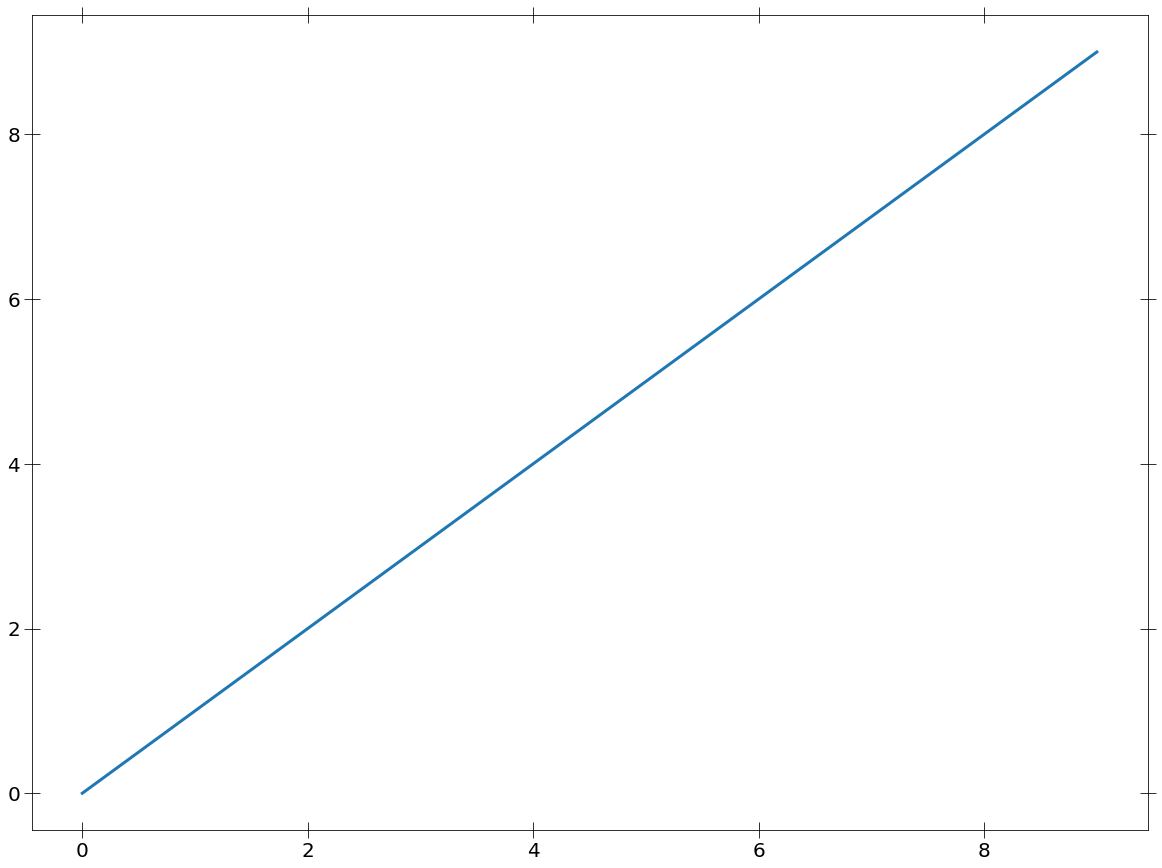

In [11]:
plt.plot(np.arange(10))

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:488: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:489: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:575: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in sqrt


12.0


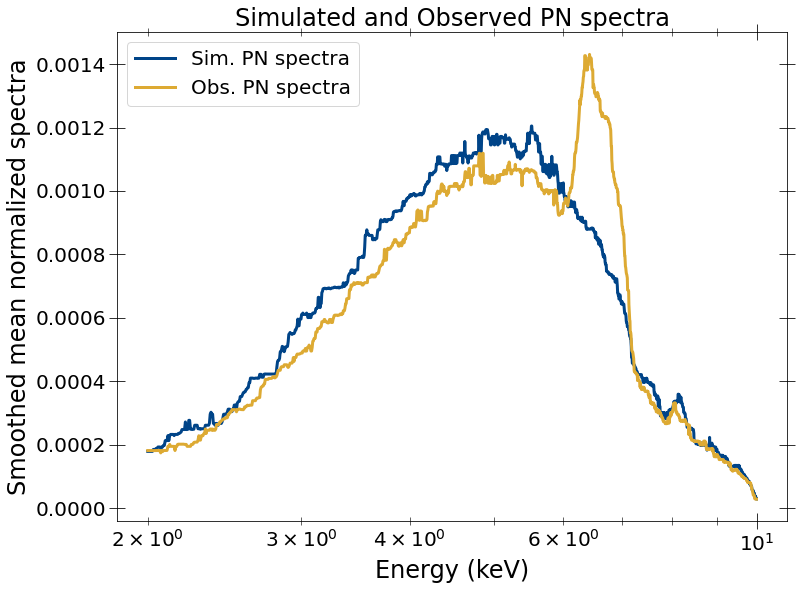

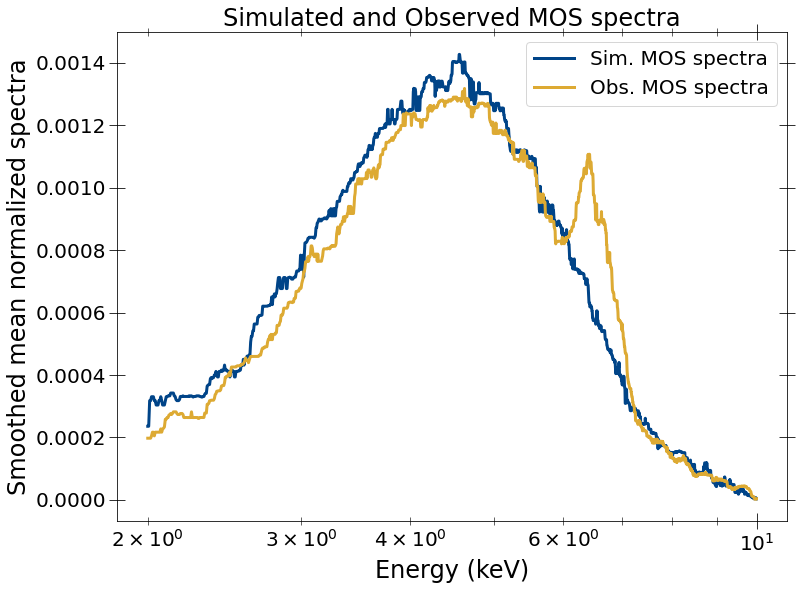

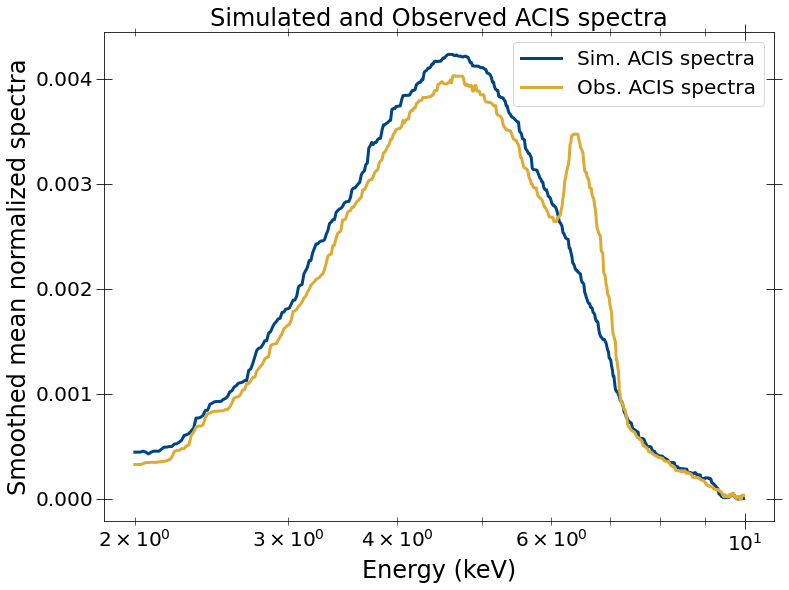

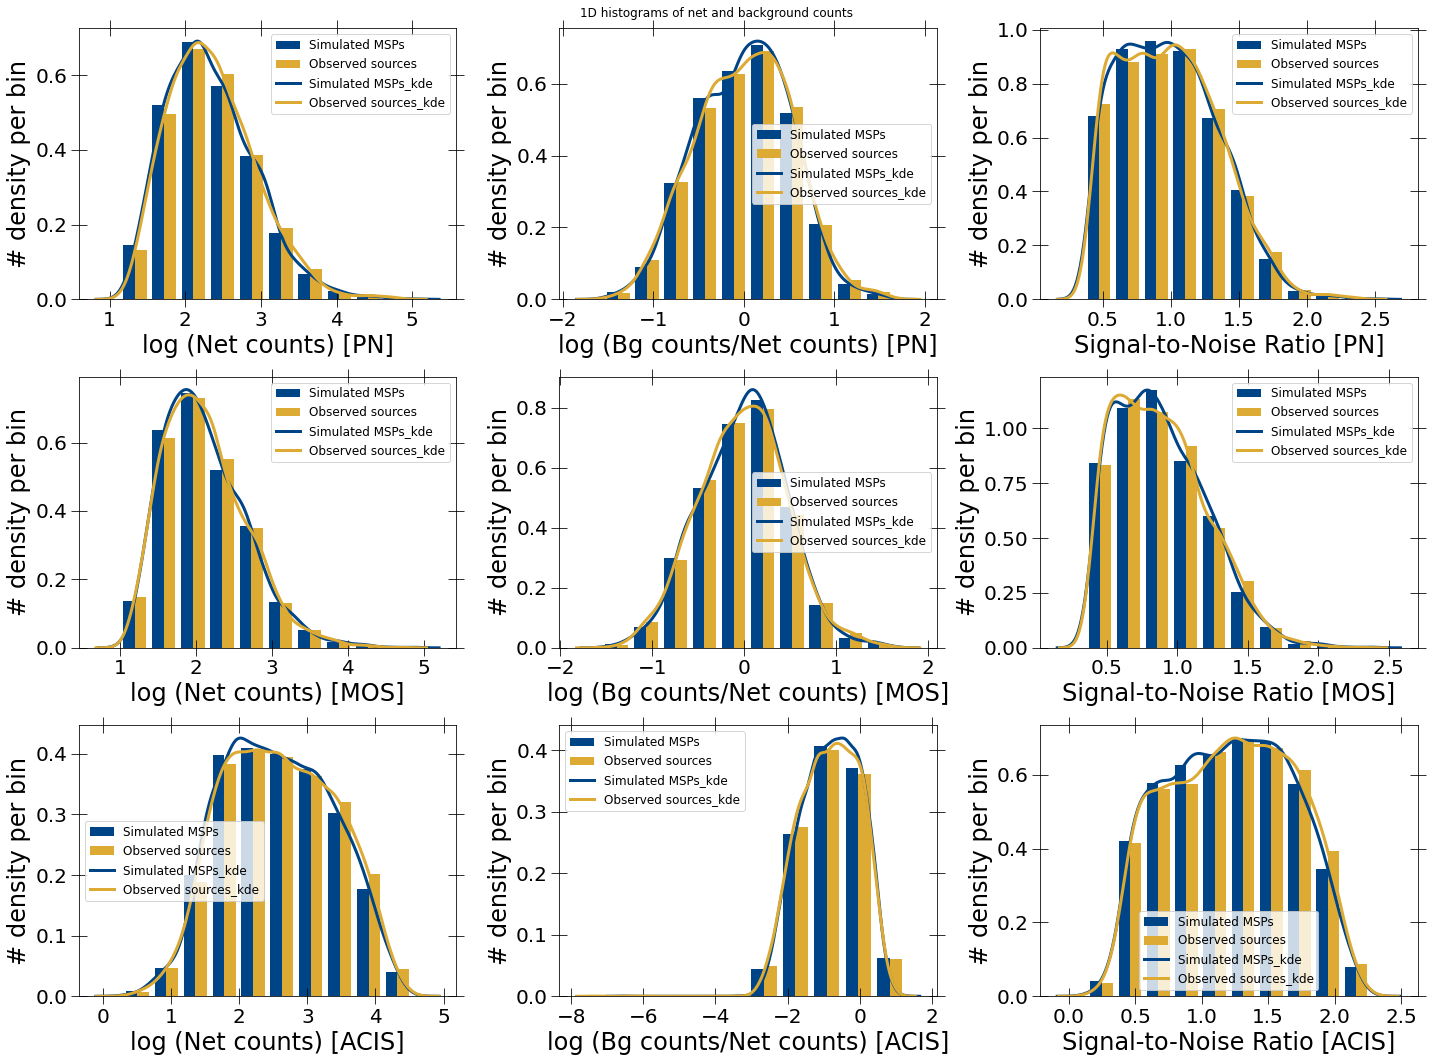

In [12]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

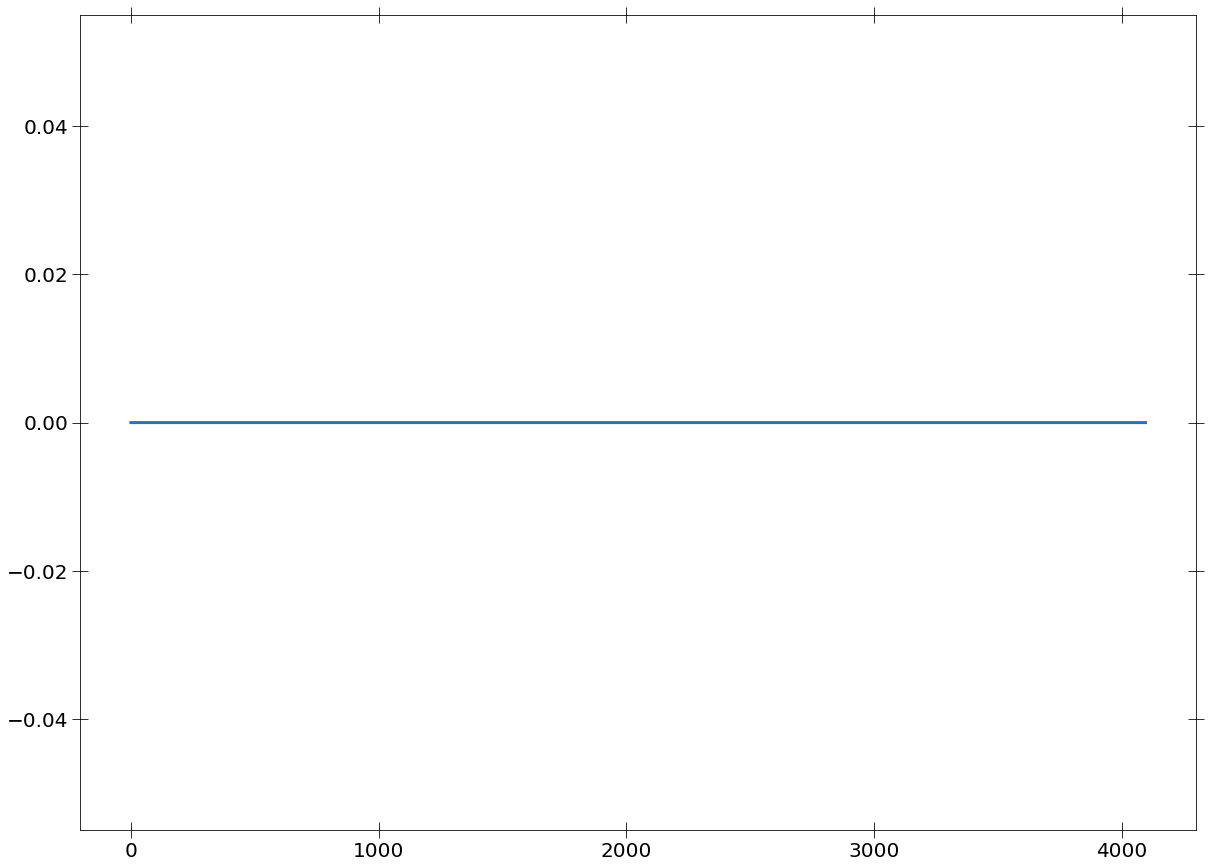

In [13]:
plt.plot(np.mean(spec_summary['specs'][0][0], axis=0))

In [144]:
counts_2keV_sim_mos = get_line_cont_counts(spec_summary['specs'][0][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['specs'][1][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.1, 2.7])[0][0]
counts_2keV_obs_mos = get_line_cont_counts(spec_summary['specs'][2][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['specs'][3][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.1, 2.7])[0][0]

1:80: E501 line too long (105 > 79 characters)
2:80: E501 line too long (105 > 79 characters)
5:80: E501 line too long (105 > 79 characters)
6:80: E501 line too long (105 > 79 characters)


In [158]:
counts_3keV_sim_mos = get_line_cont_counts(spec_summary['specs'][0][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['specs'][1][1][spec_summary['spec_masks'][0][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.7, 3.4])[0][0]
counts_3keV_obs_mos = get_line_cont_counts(spec_summary['specs'][2][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['specs'][3][1][spec_summary['spec_masks'][1][1]],
                                           spec_summary['ebins'][0][1],
                                           range_fe=[2.7, 3.4])[0][0]

1:80: E501 line too long (105 > 79 characters)
2:80: E501 line too long (105 > 79 characters)
5:80: E501 line too long (105 > 79 characters)
6:80: E501 line too long (105 > 79 characters)


In [159]:
netcounts_obs = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][1]]
netcounts_sim = spec_summary['counts'][0][1][0][spec_summary['spec_masks'][0][1]]

1:80: E501 line too long (81 > 79 characters)


In [160]:
len(netcounts_obs)

445

In [161]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][105]

'201129721010057'

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   1.,   1.,   1.,
           1.,   7.,   5.,   9.,  28.,  37.,  51.,  95., 233.],
        [  1.,   0.,   0.,   0.,   2.,   2.,   1.,   1.,   3.,   2.,   1.,
           1.,   5.,   7.,   4.,  11.,  10.,  11.,   9.,  22.]]),
 array([-4.25934684e-01, -4.04641850e-01, -3.83349017e-01, -3.62056183e-01,
        -3.40763350e-01, -3.19470516e-01, -2.98177682e-01, -2.76884849e-01,
        -2.55592015e-01, -2.34299182e-01, -2.13006348e-01, -1.91713515e-01,
        -1.70420681e-01, -1.49127848e-01, -1.27835014e-01, -1.06542181e-01,
        -8.52493473e-02, -6.39565138e-02, -4.26636802e-02, -2.13708467e-02,
        -7.80131905e-05]),
 <a list of 2 BarContainer objects>)

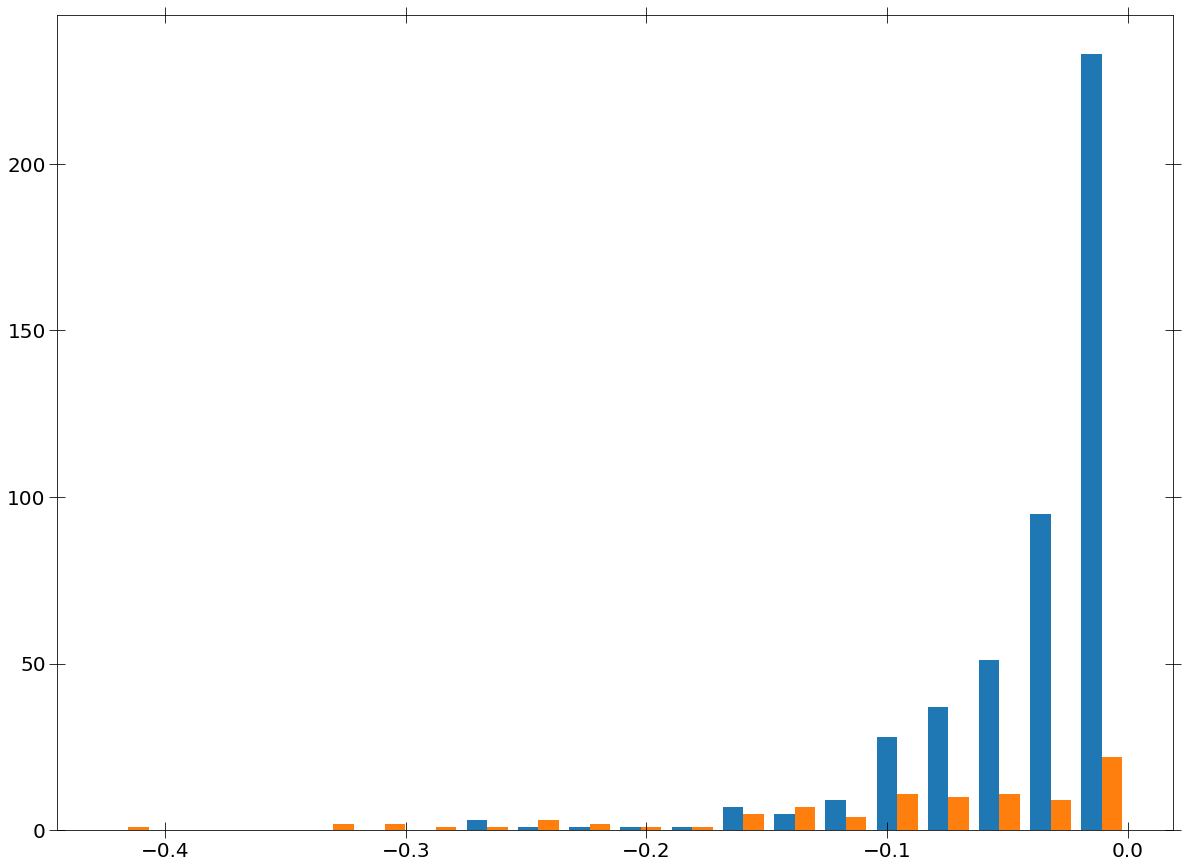

In [162]:
plt.hist([(counts_2keV_sim_mos/netcounts_sim)[counts_2keV_sim_mos < 0],
          (counts_2keV_obs_mos/netcounts_obs)[counts_2keV_obs_mos < 0]],
         bins=20)

(array([[  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   0.,   0.,   1., 209.],
        [  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
           0.,   0.,   0.,   0.,   0.,   1.,   0.,   1.,  26.]]),
 array([-7.30066848e+02, -6.93565776e+02, -6.57064705e+02, -6.20563633e+02,
        -5.84062561e+02, -5.47561490e+02, -5.11060418e+02, -4.74559347e+02,
        -4.38058275e+02, -4.01557204e+02, -3.65056132e+02, -3.28555061e+02,
        -2.92053989e+02, -2.55552917e+02, -2.19051846e+02, -1.82550774e+02,
        -1.46049703e+02, -1.09548631e+02, -7.30475597e+01, -3.65464882e+01,
        -4.54166506e-02]),
 <a list of 2 BarContainer objects>)

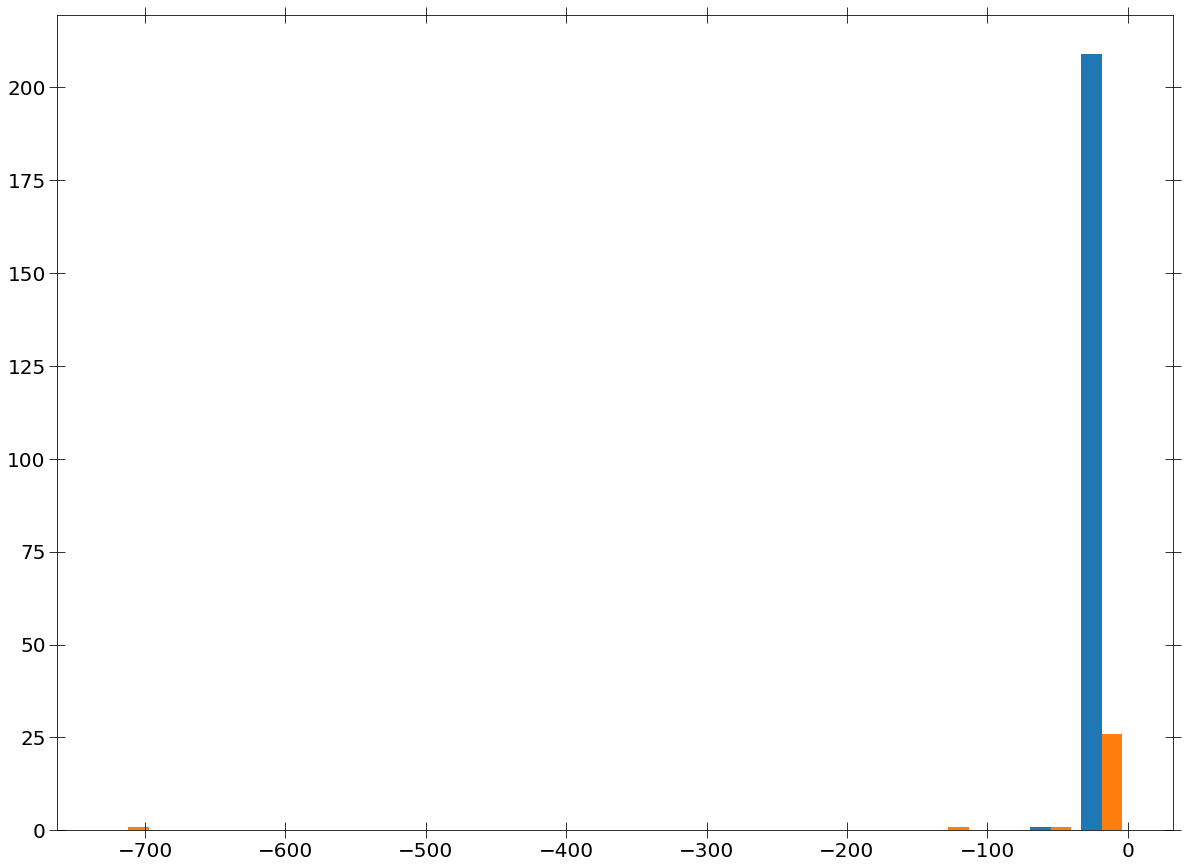

In [150]:
plt.hist([counts_3keV_sim_mos[counts_3keV_sim_mos < 0],
          counts_3keV_obs_mos[counts_3keV_obs_mos < 0]], bins=20)

In [165]:
np.sort(counts_2keV_obs_mos/netcounts_obs)[:10]

array([-0.42593468, -0.33020238, -0.32178032, -0.31756022, -0.317243  ,
       -0.2976317 , -0.26637052, -0.24287688, -0.24267083, -0.24171108])

In [163]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][np.argsort(counts_2keV_obs_mos/netcounts_obs)[:10]]

array(['206735502015094', '204024304010028', '206946410010097',
       '207848601010048', '206586001010103', '206735502010090',
       '206735502010070', '206746006015083', '206946410010058',
       '206586001010156'], dtype=object)

# PN files init: 853
# PN files init: 853


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:488: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:489: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:575: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:576: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


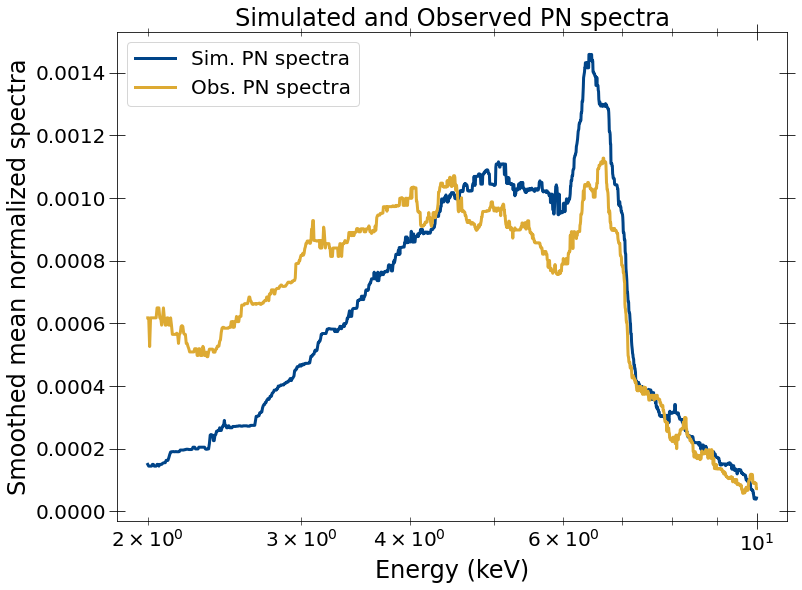

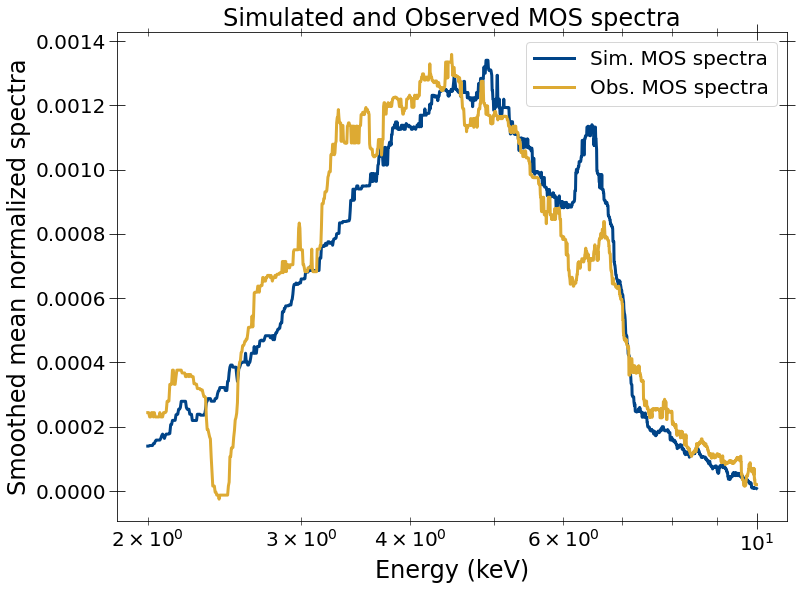

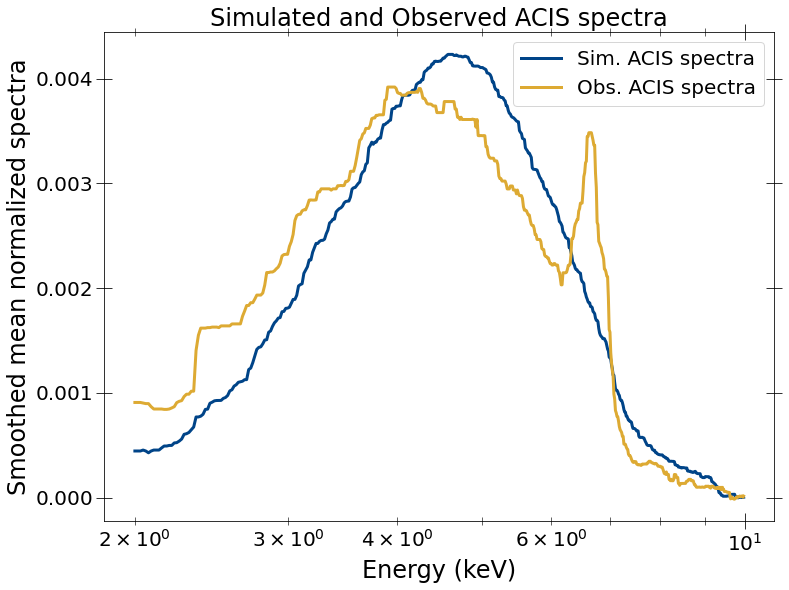

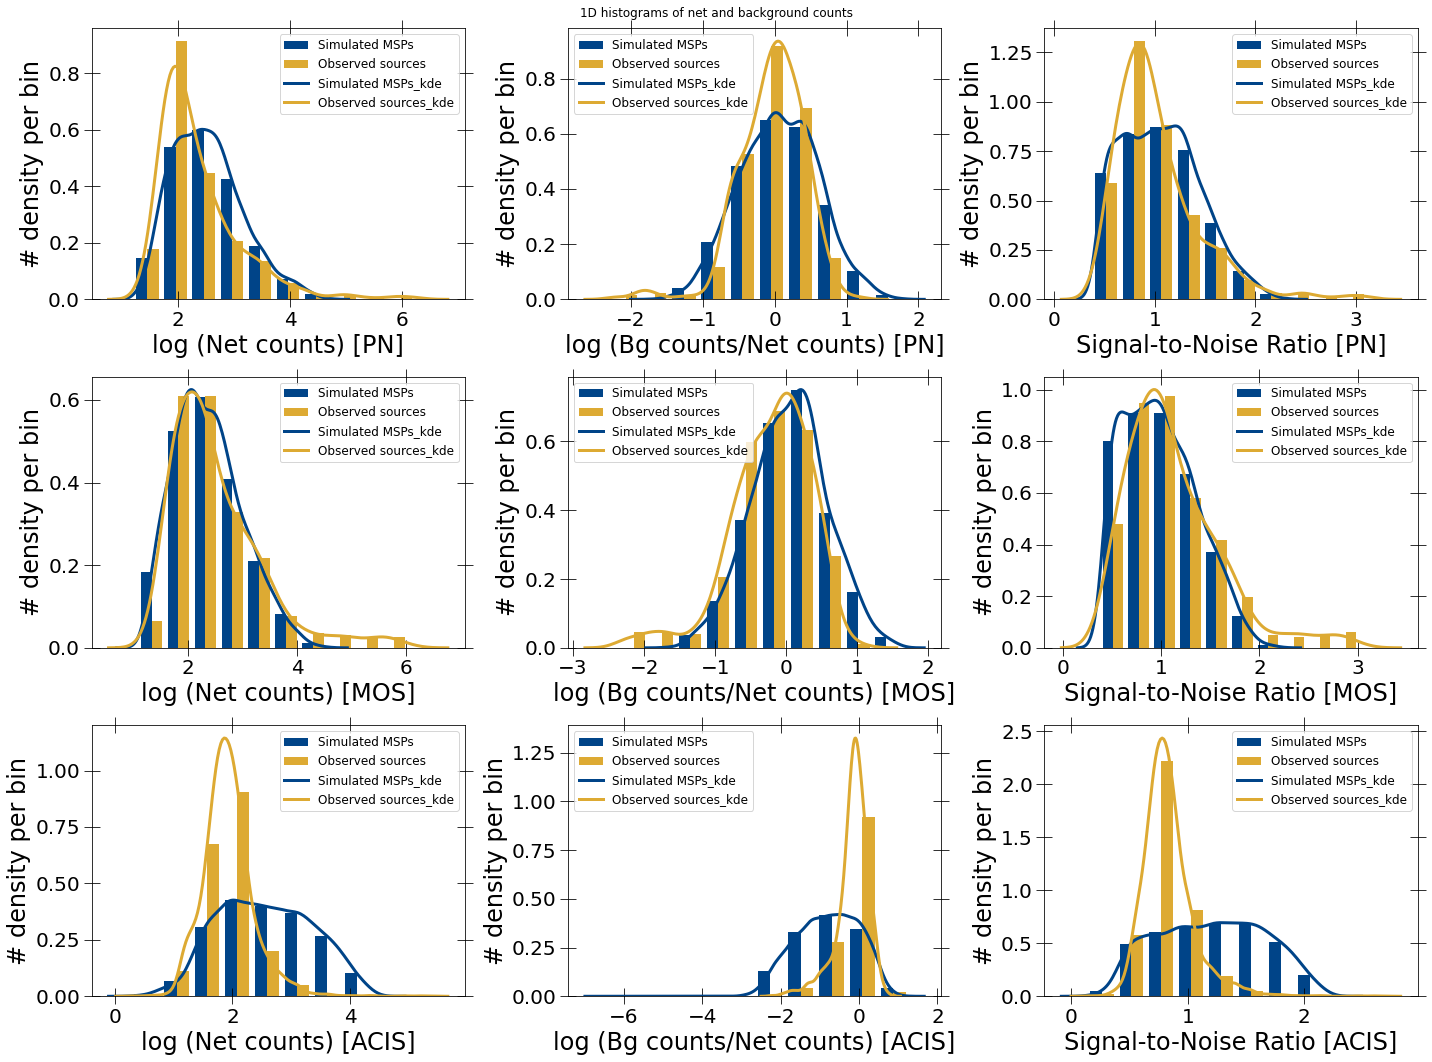

In [23]:
spec_summary_allobs = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path2, xmm_sim_path2, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

4572 4572 4572 4572
741 741 741 741
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


2382 2382 2382 2382
445 445 445 445
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


7873 7873 7873 7873
2670 2670 2670 2670
Calaculating mean and standard deviation in colors vs. Net counts


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0
16.0
16.0


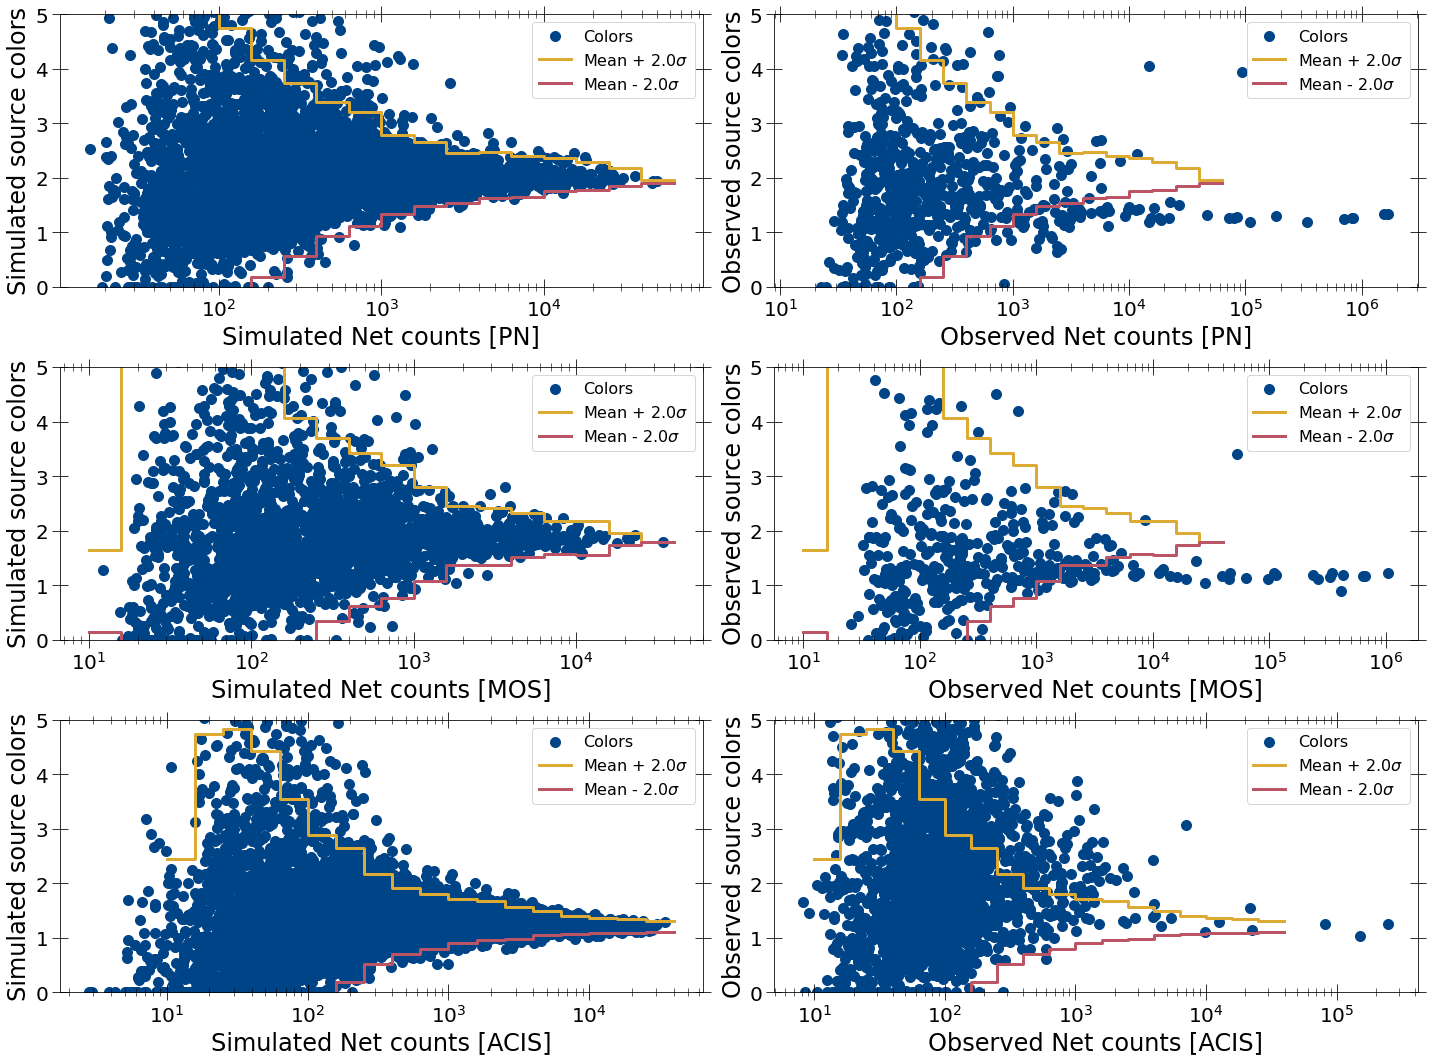

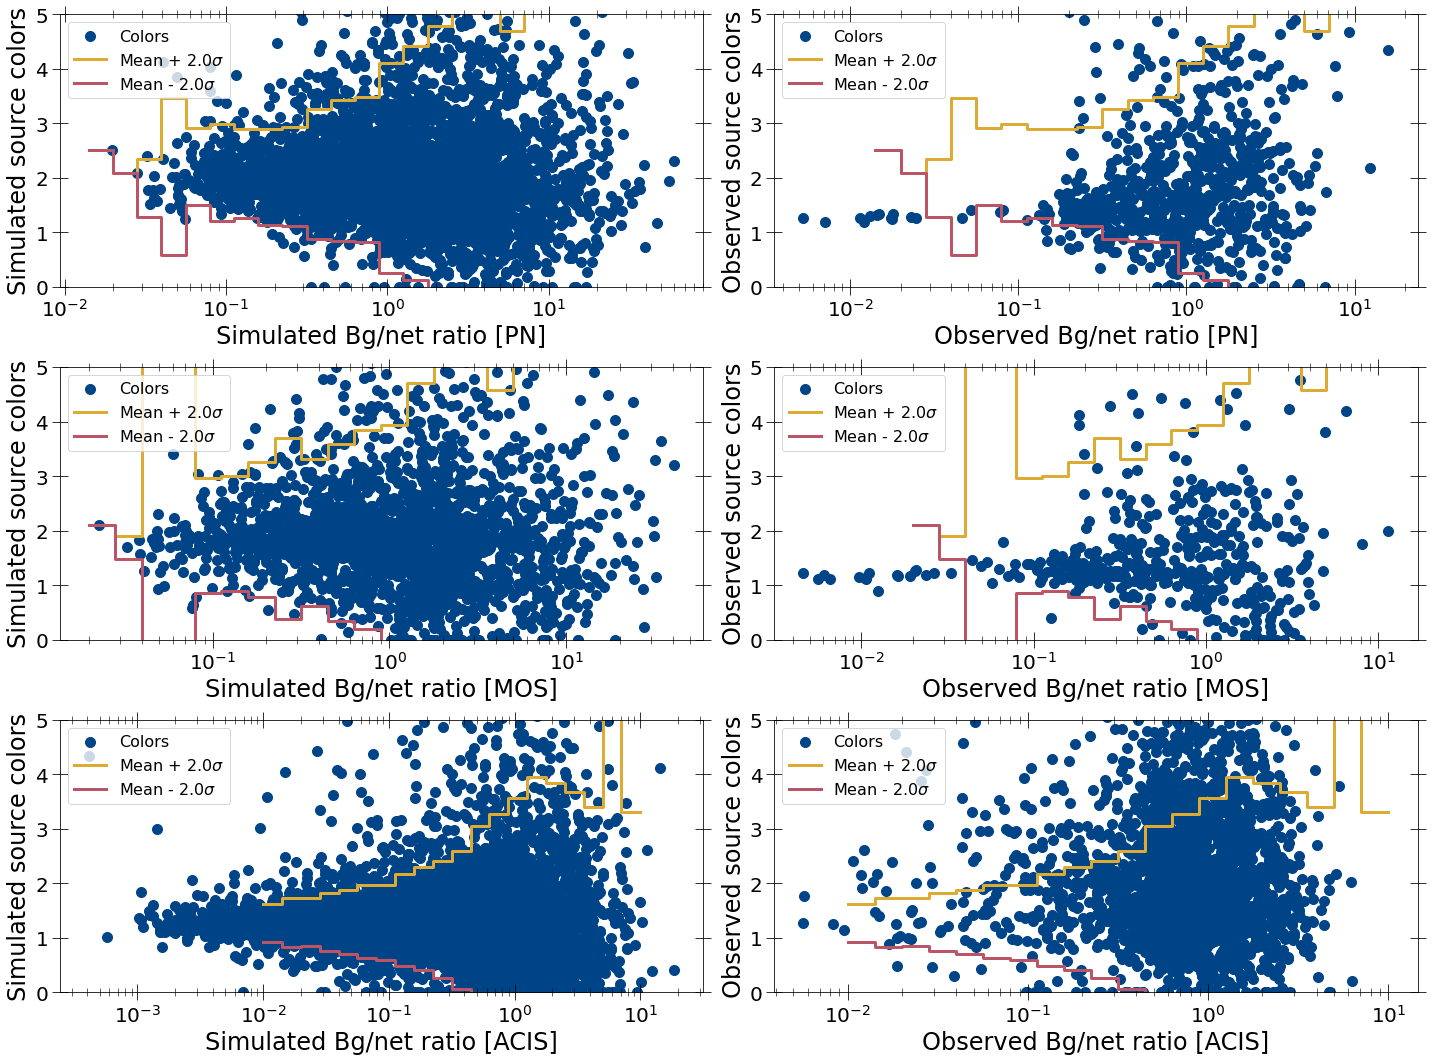

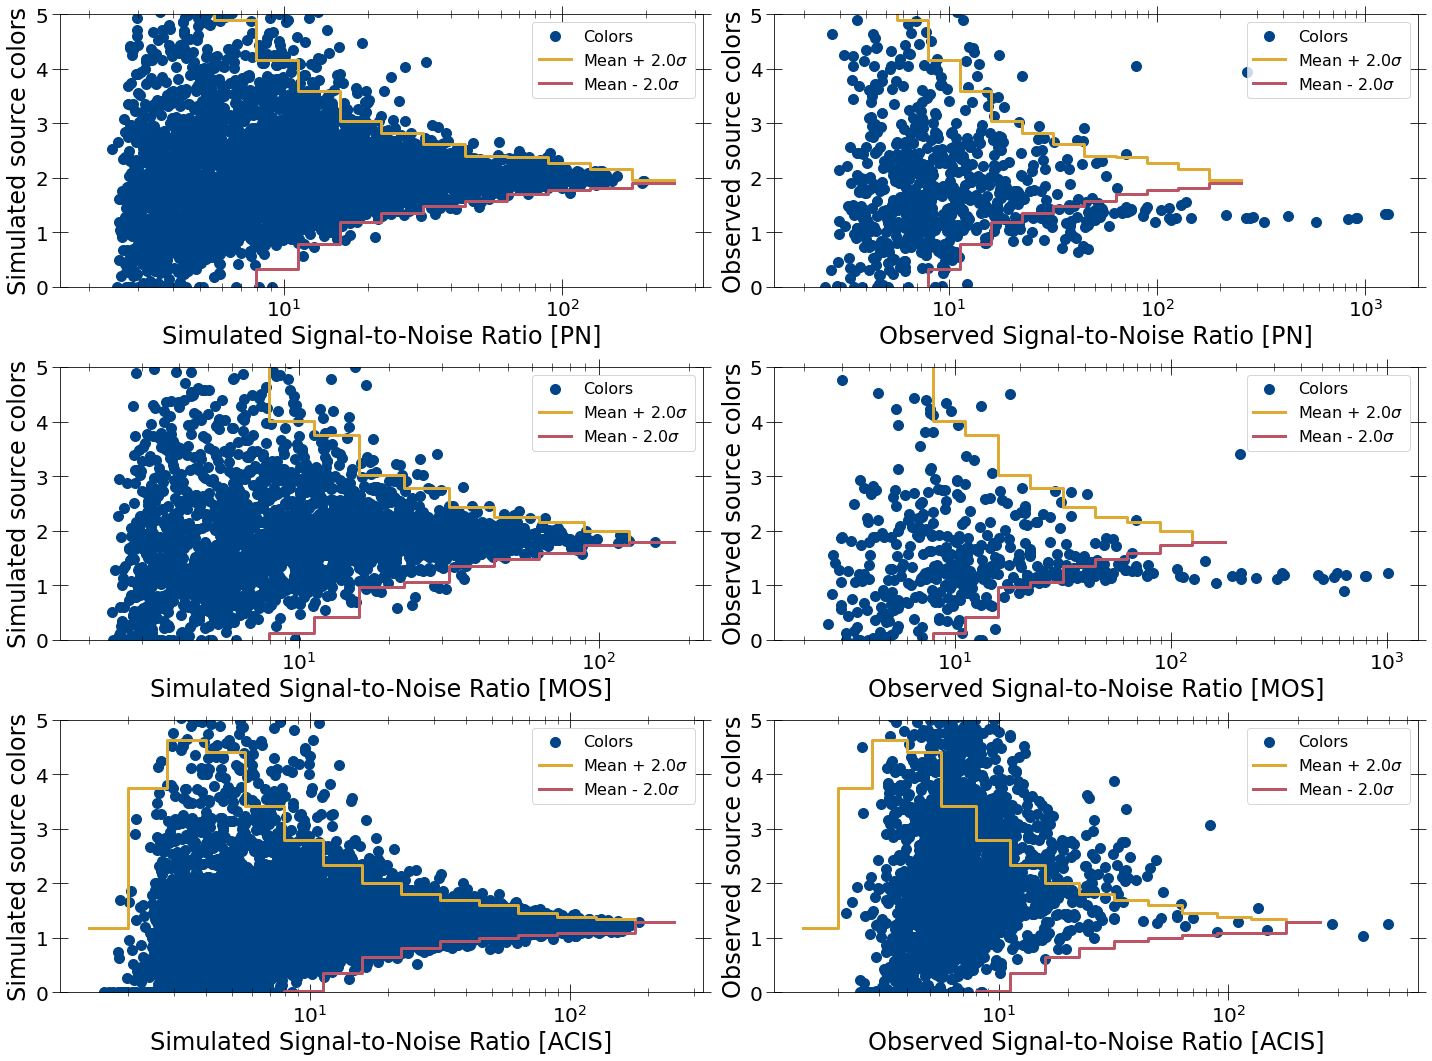

In [24]:
sim_color_dict_arr_clipped, obs_color_dict_arr_clipped = getcolor_prop_alldet(spec_summary_allobs, compare_det=True)

2772 2772 2772 2772
4419 4419 4419 4419


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
1937 1937 1937 1937
3625 3625 3625 3625


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
7873 7873 7873 7873
8132 8132 8132 8132


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0
16.0
16.0


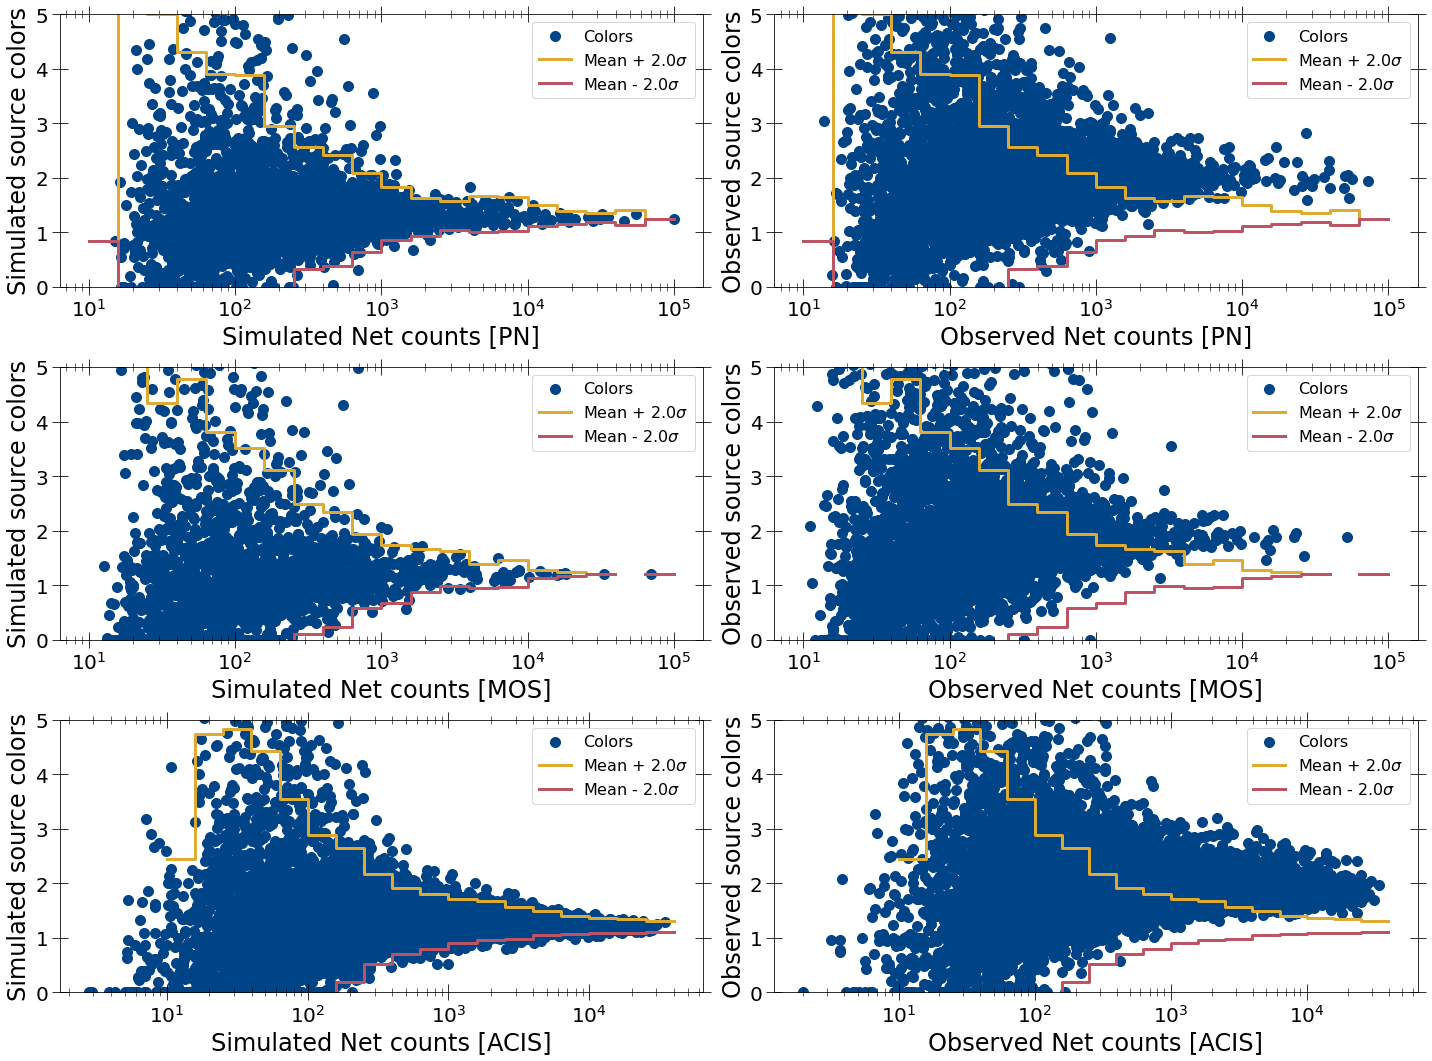

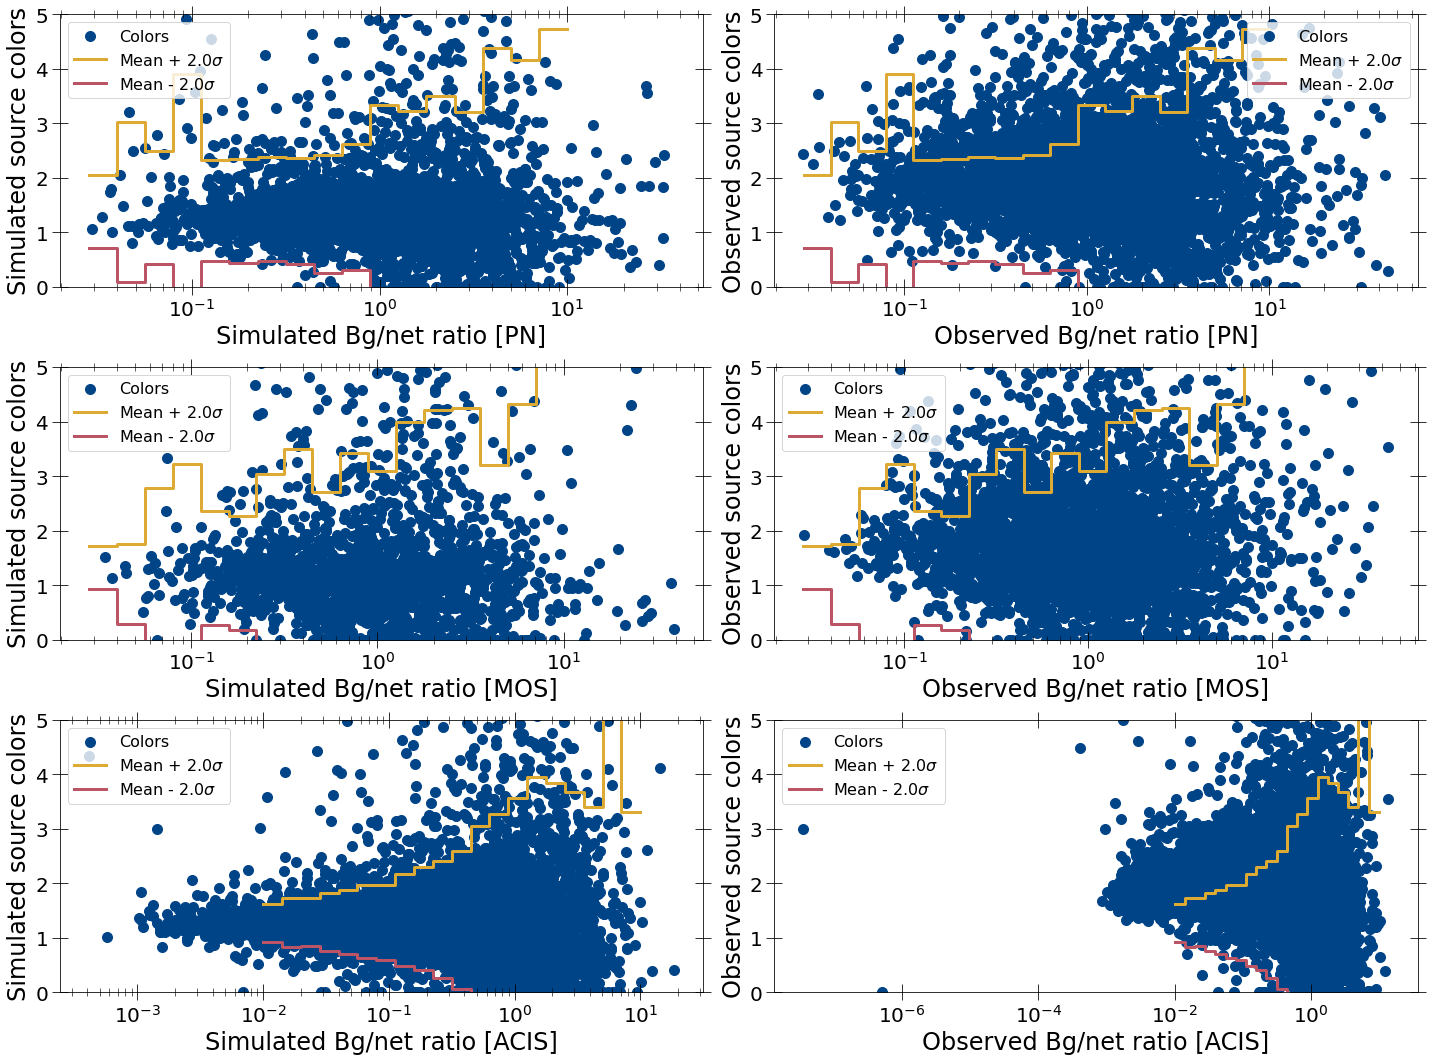

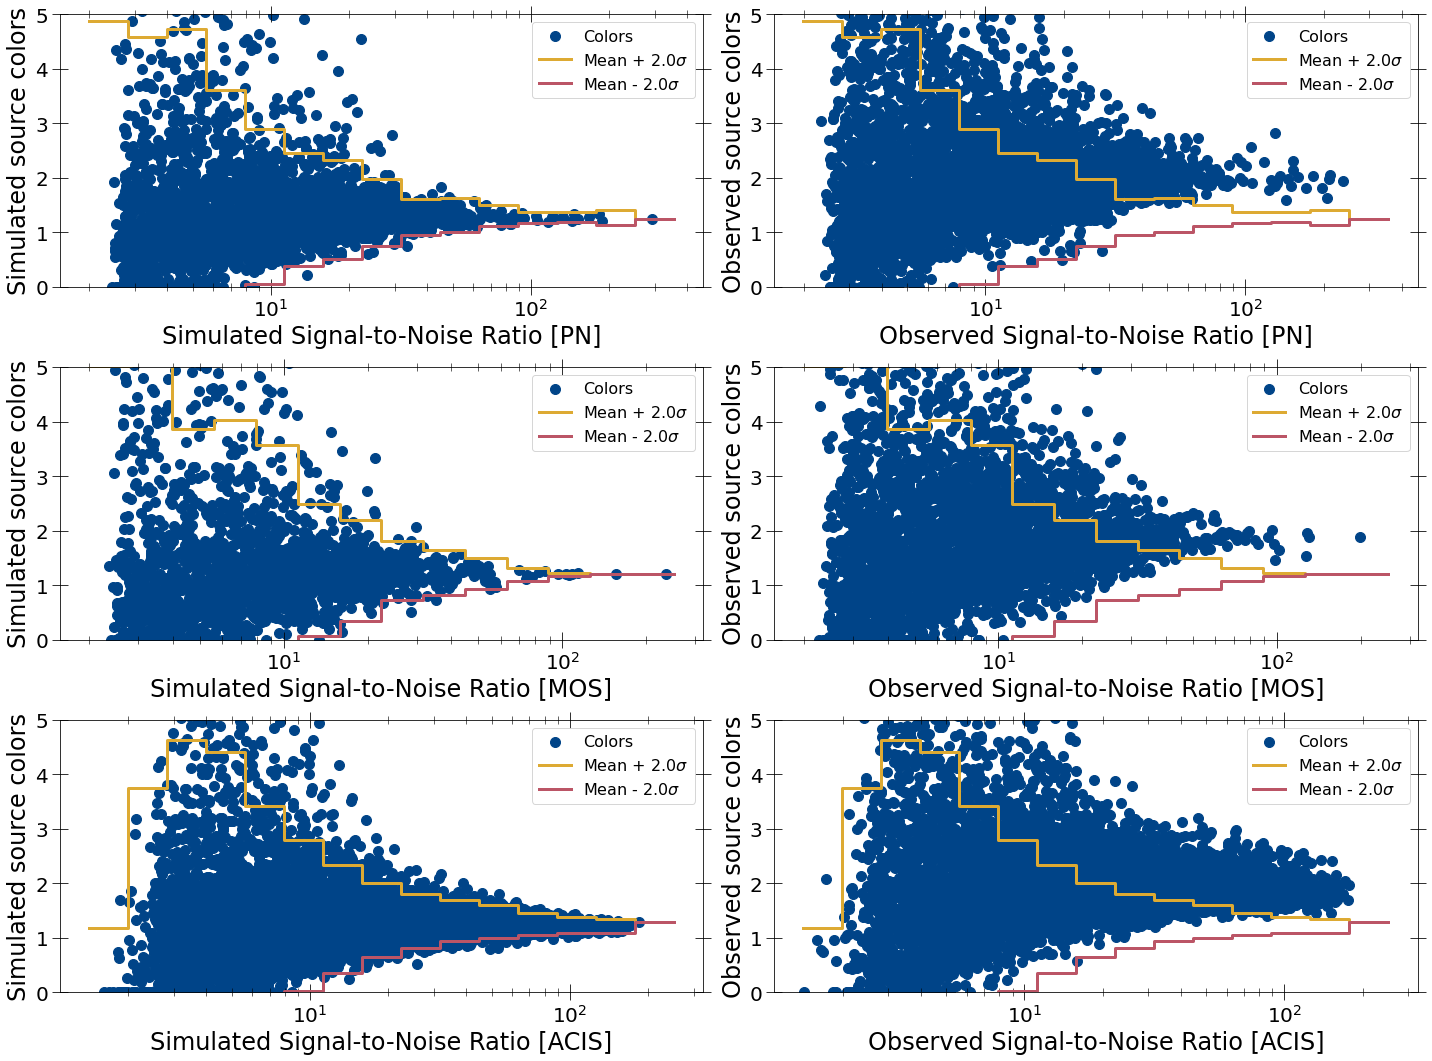

In [14]:
sim_color_dict_arr, obs_color_dict_arr = getcolor_prop_alldet(spec_summary, compare_det=True)

# PN files init: 853
# PN files init: 853


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:488: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:489: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:576: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:581: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:575: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

12.0


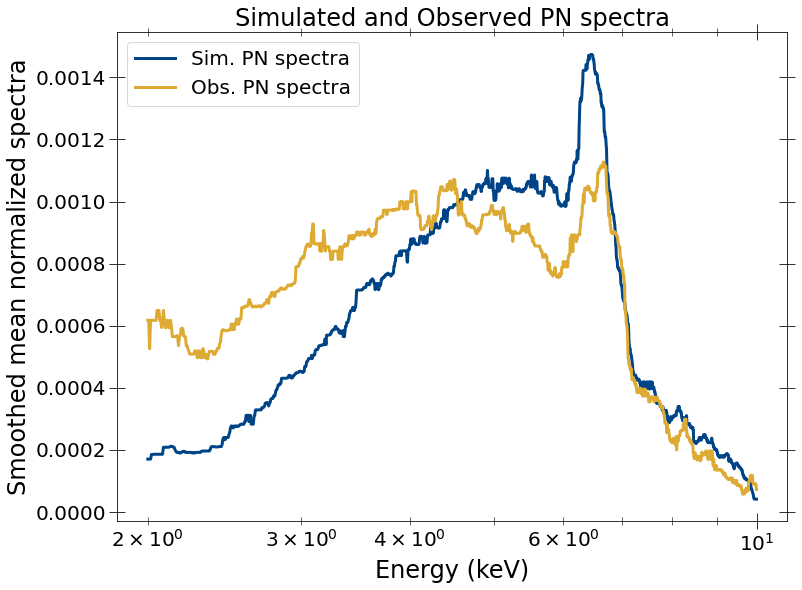

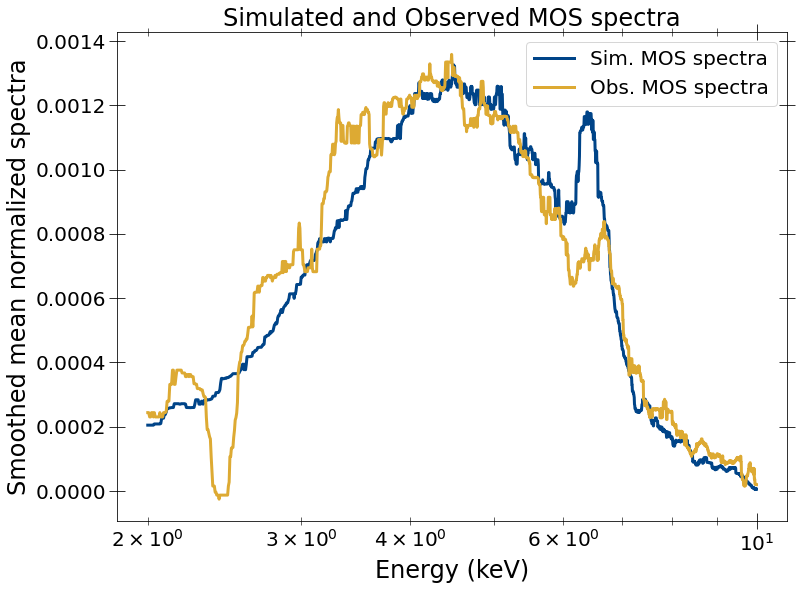

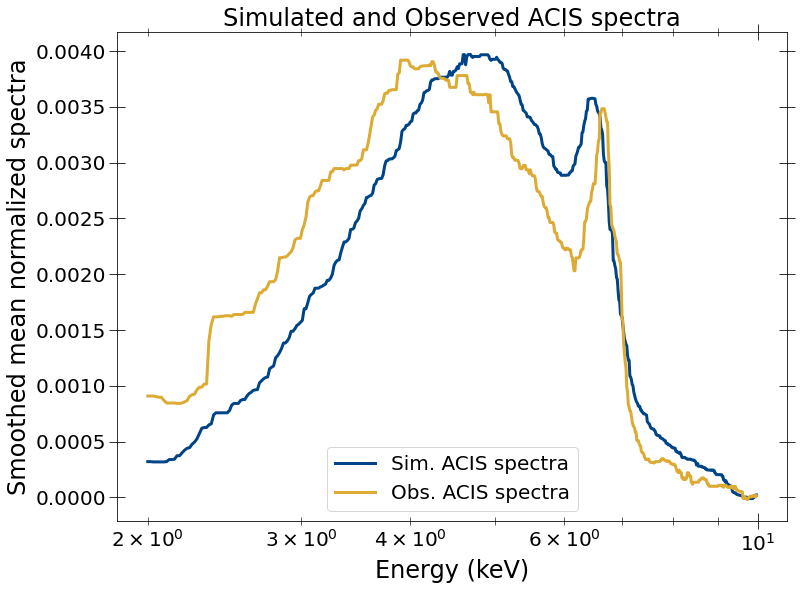

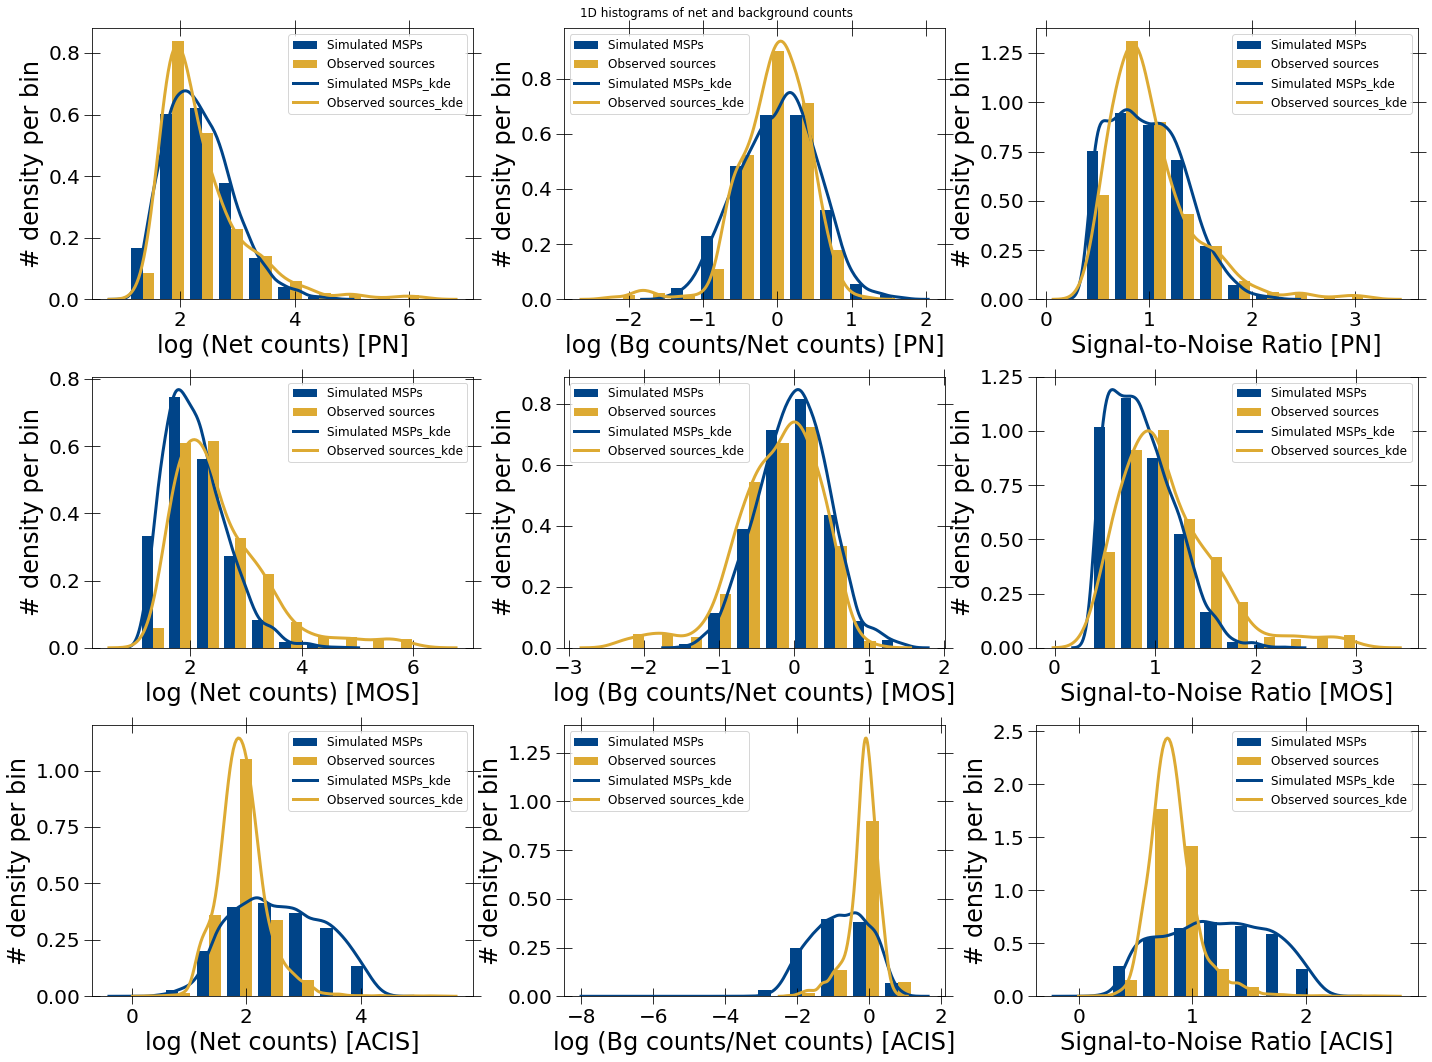

In [48]:
spec_summary2 = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path2, xmm_sim_path2, chandra_sim_path2],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2.0, 10.0])

4405 4405 4405 4405
741 741 741 741
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


3599 3599 3599 3599
445 445 445 445
Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
7957 7957 7957 7957
2670 2670 2670 2670


/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: divide by zero encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:670: RuntimeWarning: invalid value encountered in true_divide


Calaculating mean and standard deviation in colors vs. Net counts
Calaculating mean and standard deviation in colors vs. Bg/net ratio
Calaculating mean and standard deviation in colors vs. Signal-to-Noise Ratio
16.0
16.0
16.0


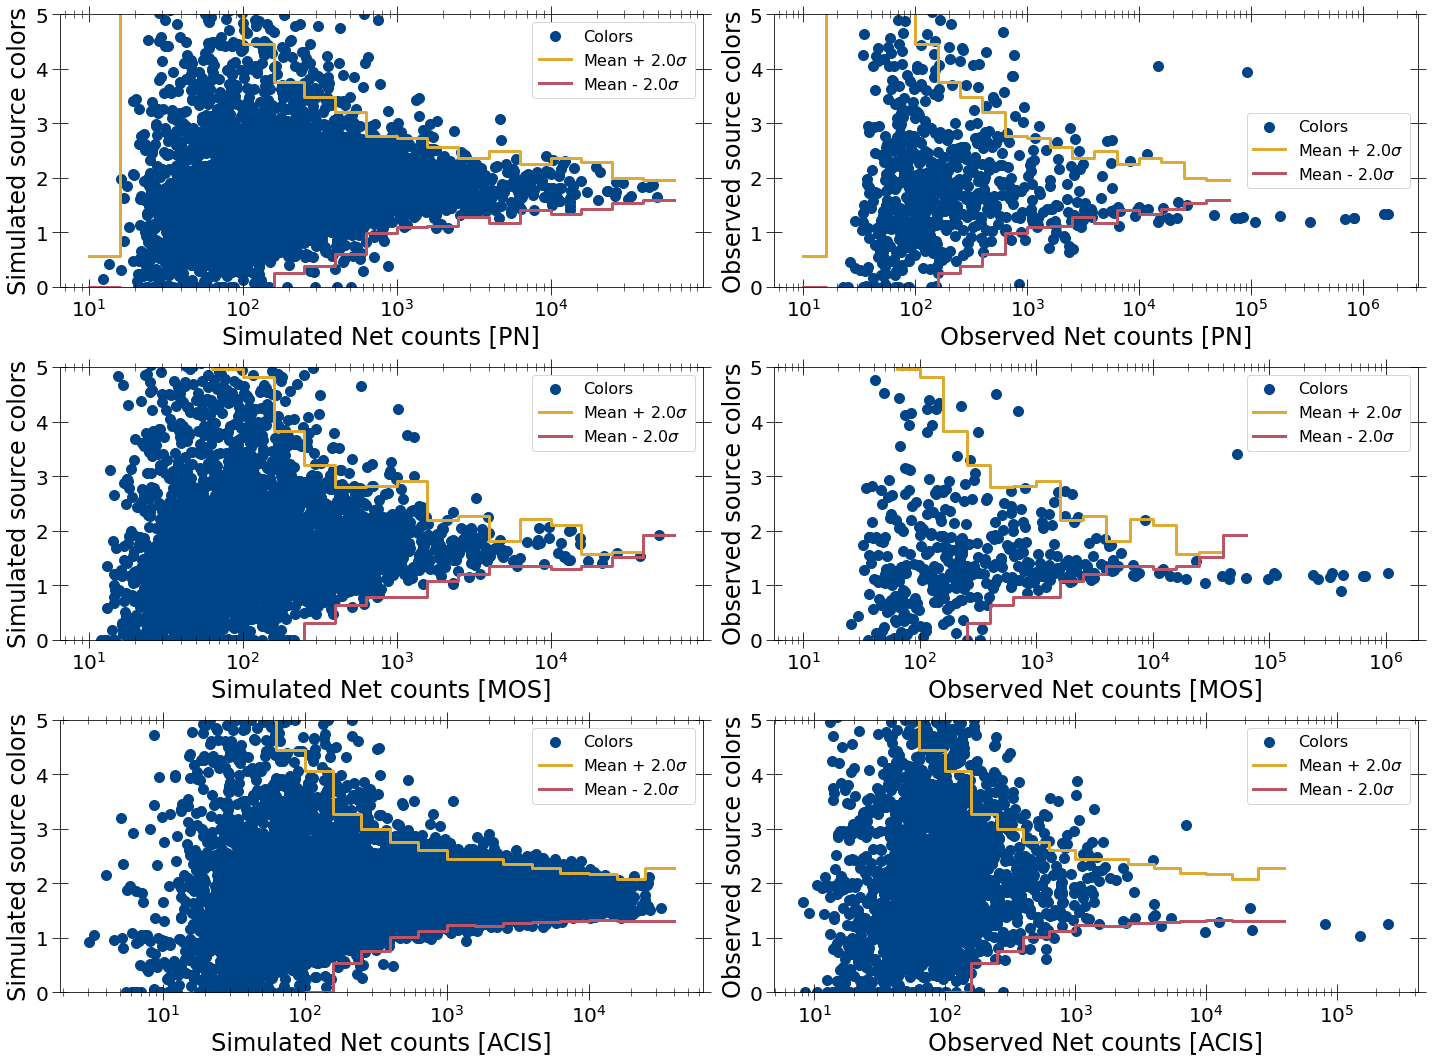

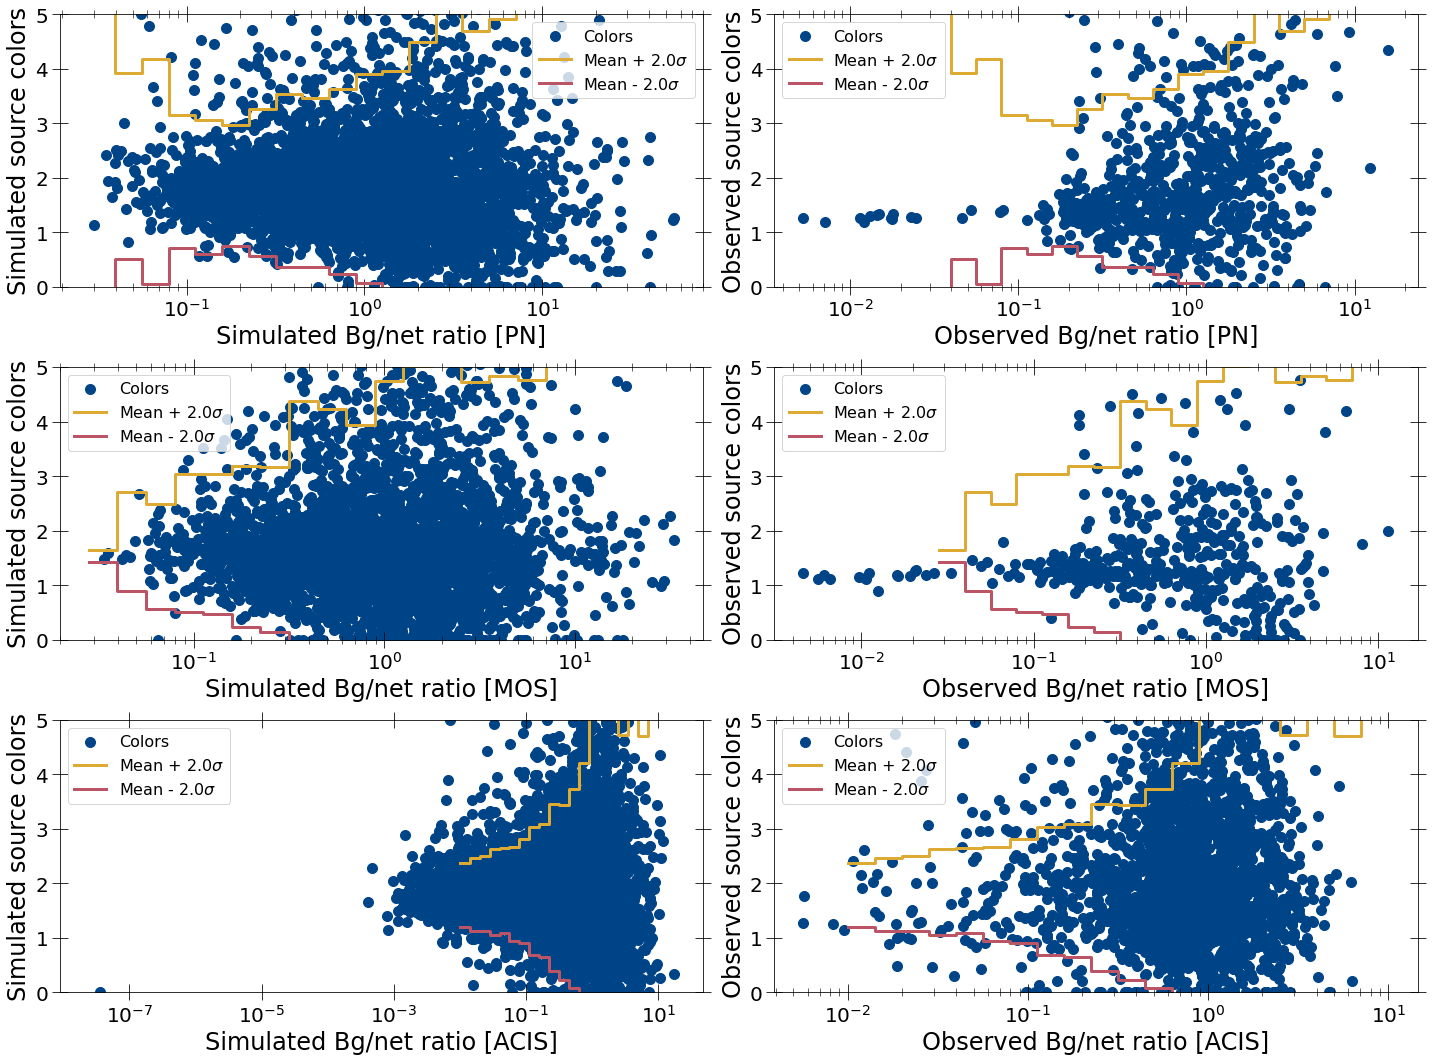

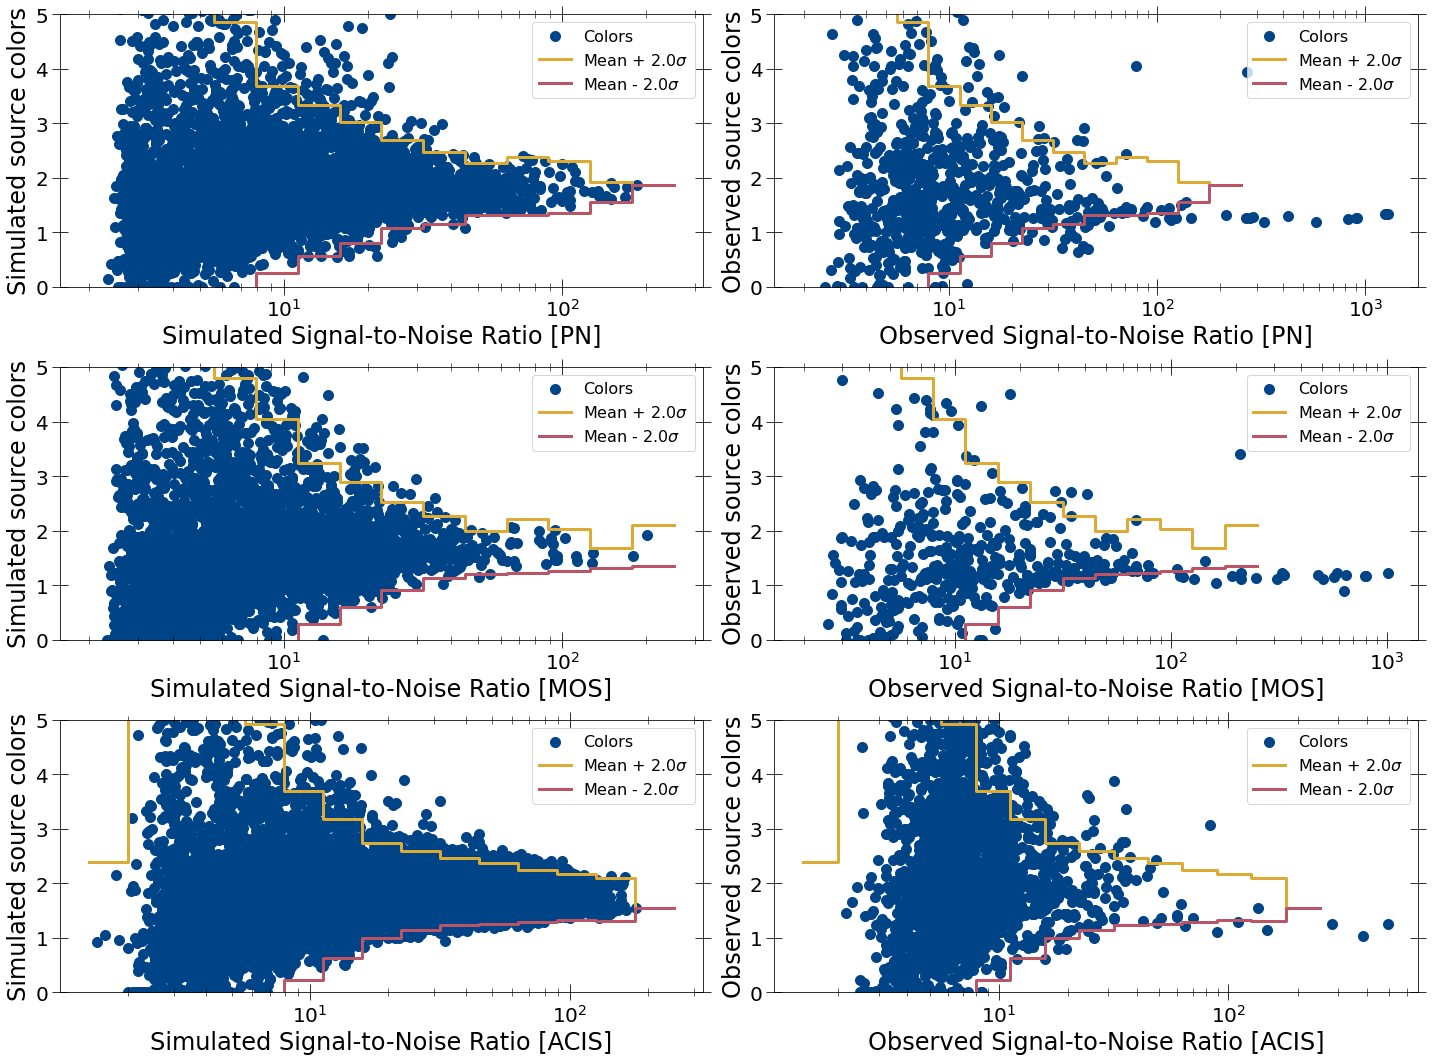

In [49]:
sim_color_dict_arr2, obs_color_dict_arr2 = getcolor_prop_alldet(spec_summary2, compare_det=True)

In [15]:
def get_candidate_src_nums_det(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    print(netcount_bins)
    print(color_median)
    print(color_std)
    interested_args = None
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        print(lower_bin, median_color + 2*std_color)
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(len(int_args))
        if interested_args is None:
            interested_args = int_args.copy()
        else:
            interested_args = np.append(interested_args.copy(), int_args)
    return interested_args, obs_src_nums[obs_det_mask][interested_args]


def get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


26:21: E117 over-indented
30:1: W293 blank line contains whitespace
59:80: E501 line too long (80 > 79 characters)
63:13: E122 continuation line missing indentation or outdented
64:13: E122 continuation line missing indentation or outdented


In [229]:
interested_args_alldet2, interested_srcs_alldet2 = get_candidate_src_nums_alldet(spec_summary2, sim_color_dict_arr2,
                              obs_color_dict_arr2, min_count_arr=[39, 39, 39])

1:80: E501 line too long (116 > 79 characters)
2:31: E128 continuation line under-indented for visual indent


[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[1.83545986 1.50859322 1.66084    1.48175529 1.46547481 1.42173222
 1.37907158 1.34241947 1.34164331 1.31932186 1.34112453 1.3576441
 1.36300675 1.31582893 1.27252105 1.33460737 1.24506393        nan
        nan        nan]
[1.44048382 0.95488145 1.07957089 0.78189889 0.56793735 0.42176062
 0.35496784 0.23084005 0.21274793 0.14517379 0.13894162 0.16628634
 0.13988764 0.09864256 0.04666147 0.         0.                nan
        nan        nan]
39.810717055349734 3.0455530706070366
71
63.09573444801933 2.601349507465748
60
100.0 2.2652534668157647
28
158.48931924611142 2.08900725130583
23
251.18864315095823 1.8040995660264987
13
398.1071705534973 1.7671391723807393
11
6

In [16]:
interested_args_alldet, interested_srcs_alldet = get_candidate_src_nums_alldet(spec_summary, sim_color_dict_arr,
                              obs_color_dict_arr, min_count_arr=[150, 150, 150])

1:80: E501 line too long (112 > 79 characters)
2:31: E128 continuation line under-indented for visual indent


[1.00000000e+01 1.58489319e+01 2.51188643e+01 3.98107171e+01
 6.30957344e+01 1.00000000e+02 1.58489319e+02 2.51188643e+02
 3.98107171e+02 6.30957344e+02 1.00000000e+03 1.58489319e+03
 2.51188643e+03 3.98107171e+03 6.30957344e+03 1.00000000e+04
 1.58489319e+04 2.51188643e+04 3.98107171e+04 6.30957344e+04
 1.00000000e+05]
[0.8405164  2.07153913 1.67298979 1.57385831 1.58436607 1.66406679
 1.43030382 1.44713313 1.39609846 1.36984926 1.35086023 1.27893642
 1.31590127 1.33564778 1.334838   1.30071855 1.27144028 1.27383281
 1.26917868 1.24506393]
[0.         2.55426532 1.66817468 1.37071133 1.16334185 1.11434474
 0.75549623 0.56022382 0.51077116 0.36126324 0.24291962 0.17375792
 0.13254254 0.16428213 0.15864827 0.09633923 0.05725364 0.0421451
 0.0654287  0.        ]
158.48931924611142 2.9412962840318846
453
251.18864315095823 2.567580775527234
386
398.1071705534973 2.4176407708782373
325
630.957344480193 2.0923757354927424
197
1000.0 1.8366994711223559
67
1584.893192461114 1.6264522674211288

In [17]:
len(np.sort(interested_srcs_alldet[0]))

1455

In [18]:
len(np.sort(interested_srcs_alldet[1]))

957

In [19]:
len(np.sort(interested_srcs_alldet[2]))

1627

In [25]:
int_srcs_pn = np.random.choice(interested_srcs_alldet[0], 200)
int_srcs_mos = np.random.choice(interested_srcs_alldet[1], 200)
int_srcs_acis = np.random.choice(interested_srcs_alldet[2], 200)

In [26]:
int_srcs_subset = [int_srcs_pn, int_srcs_mos, int_srcs_acis]

In [96]:
def mark_interested_srcs(sim_color_dict, obs_color_dict, src_nums, obs_mask,
                         interested_srcs, prop_num=0):
    props = obs_color_dict['prop_list'][prop_num]
    colors = obs_color_dict['colors']
    interested_args = np.where(np.isin(src_nums[obs_mask], interested_srcs))
    print(len(interested_args[0]), len(interested_srcs))
    print(len(np.unique(interested_srcs)))
    #print(interested_args)
    #print(src_nums[obs_mask][interested_args])
    #print(props[interested_args])
    #print(colors[interested_args])
    prop_bins = sim_color_dict['prop_bins'][prop_num]
    mean_color = sim_color_dict['color_stat'][0][prop_num]
    std_color = sim_color_dict['color_stat'][2][prop_num]
    plotline_scatter([props, props[interested_args], prop_bins, prop_bins],
                     [colors, colors[interested_args], mean_color + 2*std_color,
                      mean_color - 2*std_color],
                     pl_types=['scatter', 'scatter', 'step', 'step'],
                     xlabel='Net counts', ylabel='Colors',
                     pl_labels=['Colors', 'Colors (candidates)',
                                r'Mean + 2$\sigma$', r'Mean + 2$\sigma$'],
                     ylim=(0, 5))
    return (colors[interested_args], props[interested_args],
            src_nums[obs_mask][interested_args])

8:5: E265 block comment should start with '# '
9:5: E265 block comment should start with '# '
10:5: E265 block comment should start with '# '
11:5: E265 block comment should start with '# '
16:80: E501 line too long (80 > 79 characters)


In [23]:
np.where(spec_summary['src_nums'][0] == )

SyntaxError: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)

1:40: E202 whitespace before ')'
41: E999 SyntaxError: invalid syntax


Error before execution: invalid syntax (<ipython-input-23-8d0a30d54856>, line 1)


189 200
189


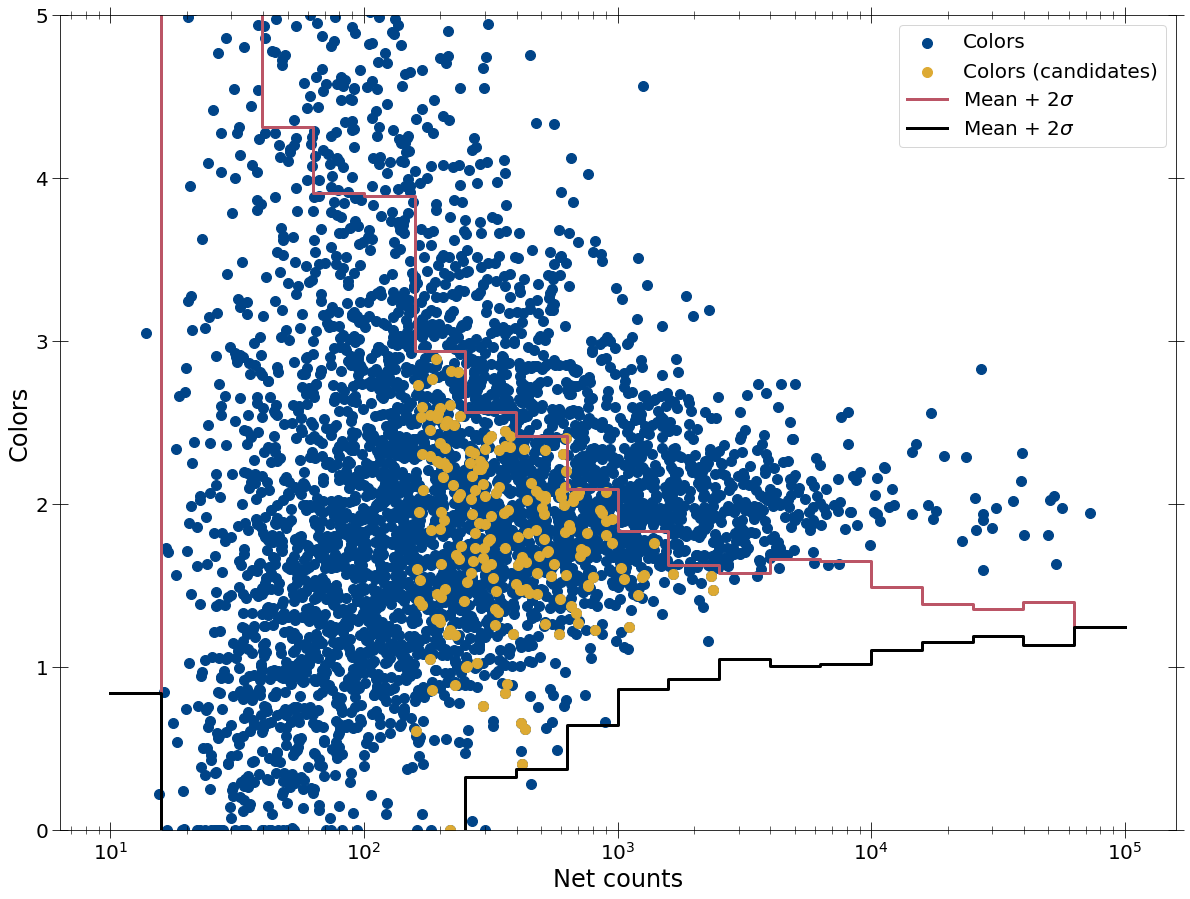

1:80: E501 line too long (85 > 79 characters)
2:22: E128 continuation line under-indented for visual indent
2:80: E501 line too long (83 > 79 characters)


In [100]:
netcounts_int_pn = mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     int_srcs_subset[0], 0)[1]

185 200
185


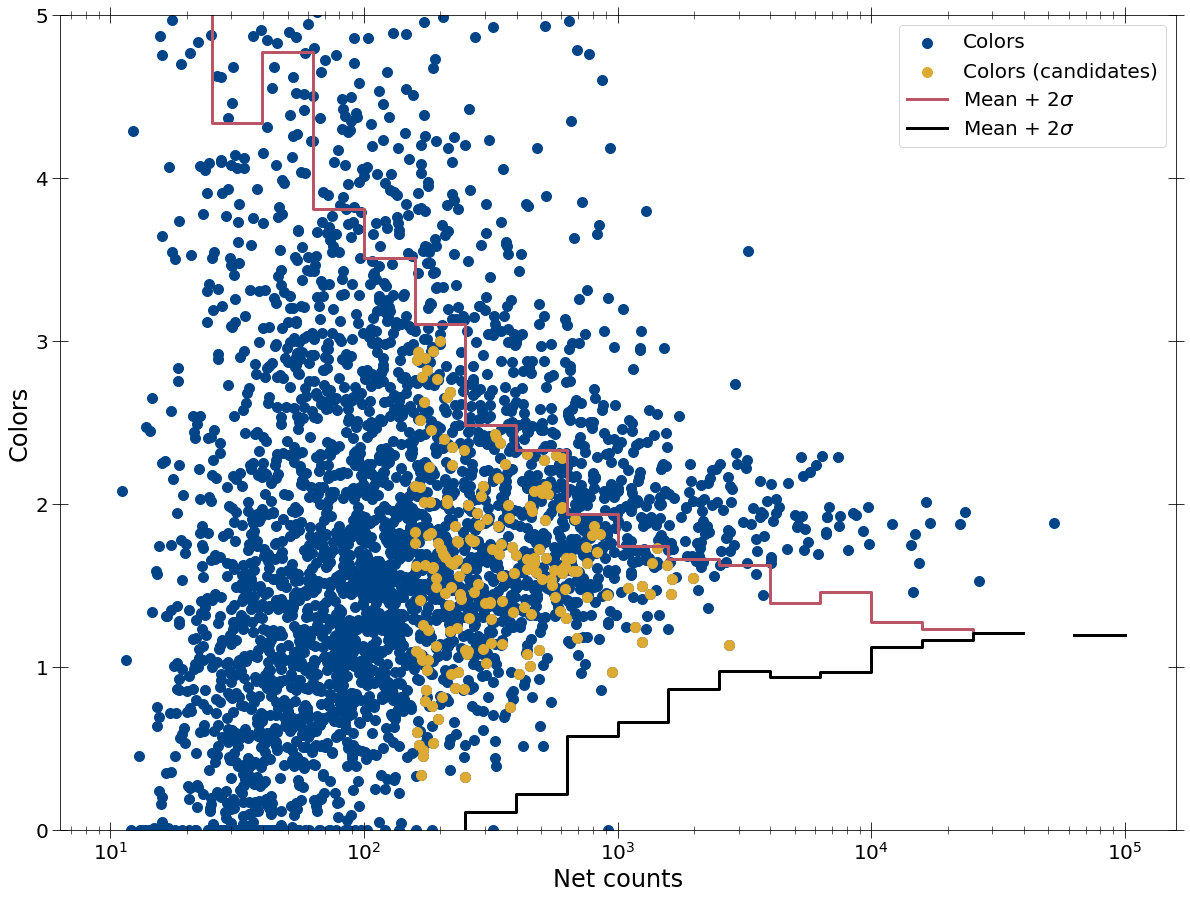

1:80: E501 line too long (86 > 79 characters)
2:22: E128 continuation line under-indented for visual indent
2:80: E501 line too long (83 > 79 characters)


In [101]:
netcounts_int_mos = mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     int_srcs_subset[1], 0)[1]

In [182]:
len(interested_srcs_alldet[1])

205

183 200
183


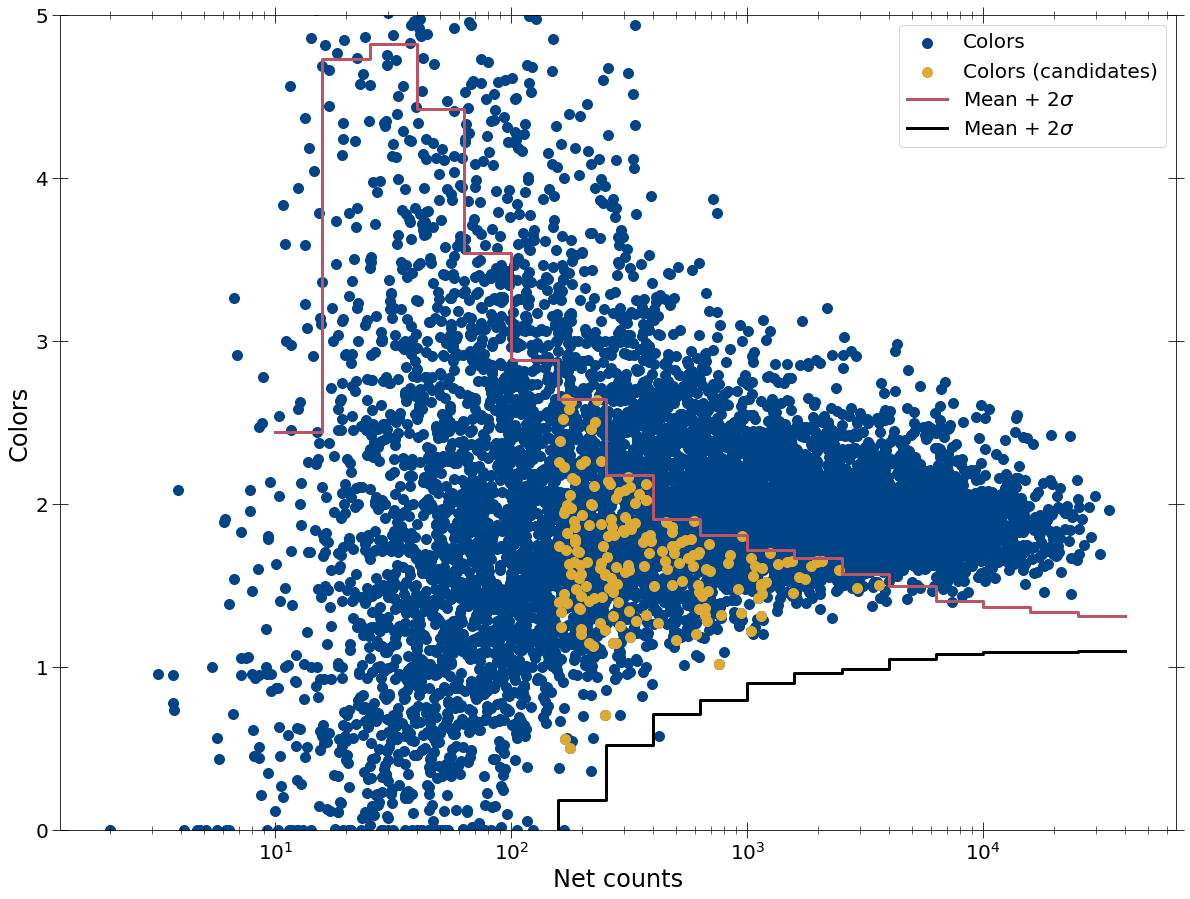

1:80: E501 line too long (87 > 79 characters)
2:22: E128 continuation line under-indented for visual indent
2:80: E501 line too long (83 > 79 characters)


In [102]:
netcounts_int_acis = mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     int_srcs_subset[2], 0)[1]

In [28]:
source_nums = np.loadtxt('Interested_sources.txt', dtype='object')

(array([ 24,  38,  43,  50,  75,  91,  98, 111, 121, 127, 140, 152, 187,
       191, 192, 195, 206, 211, 213, 223, 229, 240, 273, 308, 309, 311,
       441, 464, 465, 467, 481, 483]),)


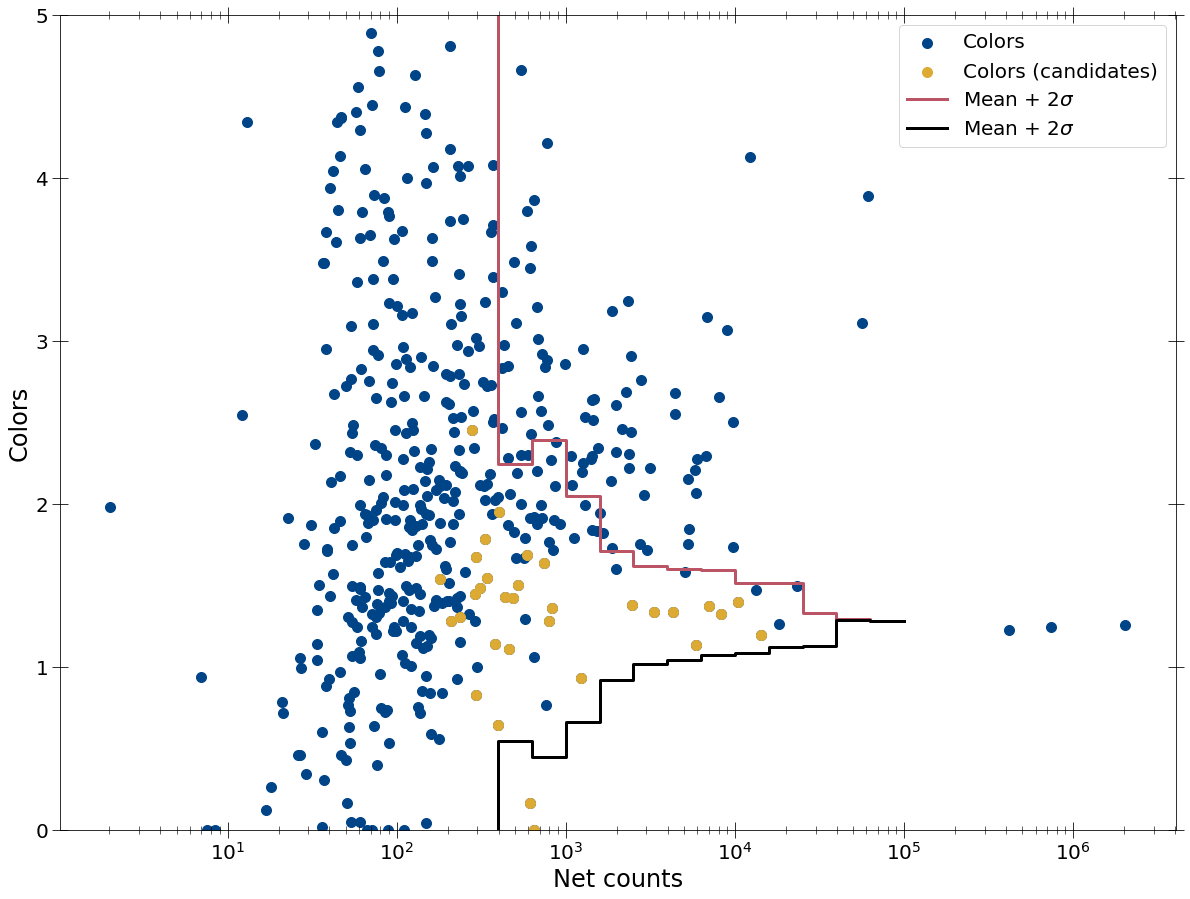

2:80: E501 line too long (83 > 79 characters)


In [29]:
mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     source_nums, 0)

(array([ 16,  24,  29,  33,  55,  66,  72,  84,  93,  97, 103, 119, 122,
       123, 125, 134, 137, 139, 157, 171, 183, 184, 185, 220, 224, 225,
       226, 229, 231]),)


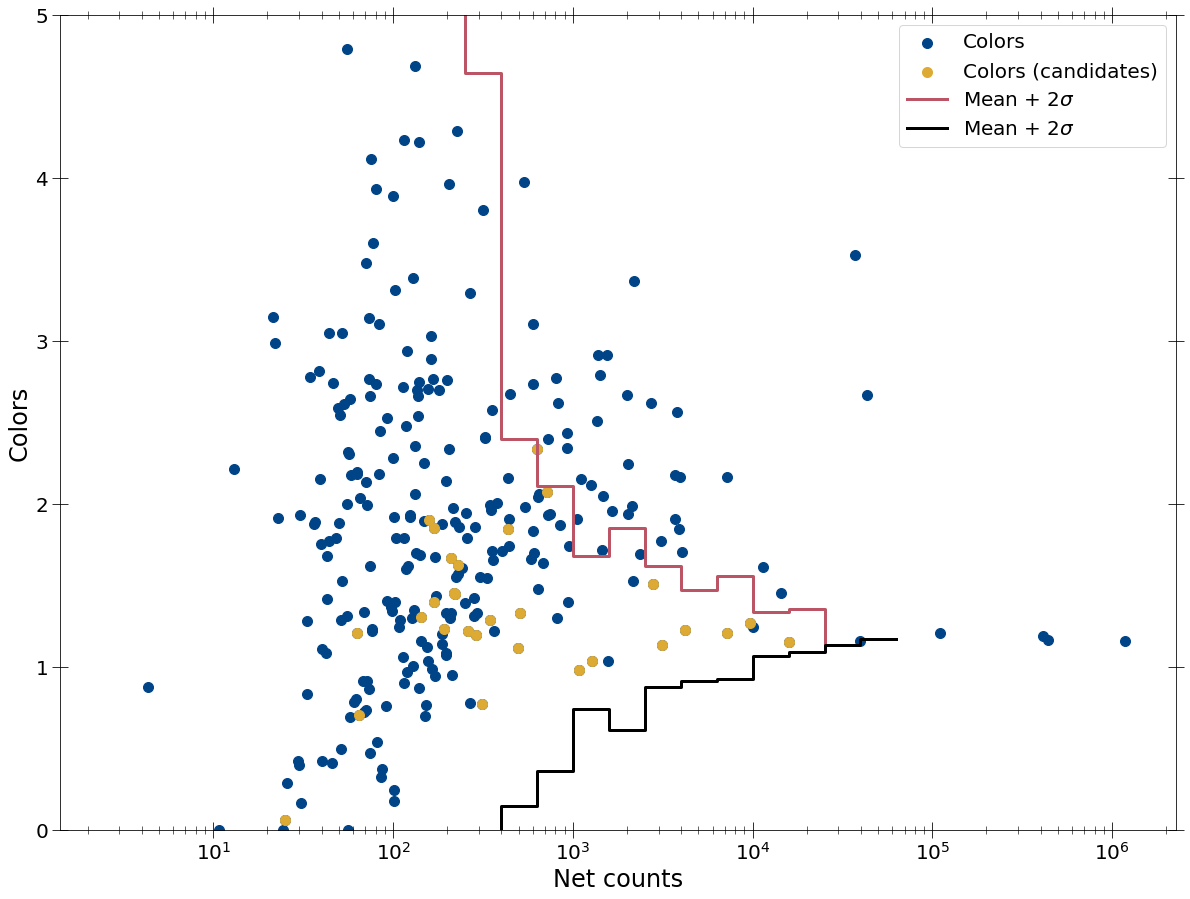

2:80: E501 line too long (83 > 79 characters)


In [30]:
mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     source_nums, 0)

# Checking for low norm sources

## def unmask_arr(masked_values, mask, filler=-100.0):
    unmasked_arr = np.ones(len(mask), dtype=float)*filler
    unmasked_arr[mask] = masked_values
    return unmasked_arr

In [23]:
print('MOS sources not detected in PN')
mos_not_pn = []
for src in interested_srcs_alldet[1]:
    if src not in interested_srcs_alldet[0]:
        mos_not_pn.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

MOS sources not detected in PN
Source:  201129705010014
Net counts (PN):  [1984.88629568]
Net counts (MOS):  [608.05064636]
Bg counts (PN):  [2078.11370432]
Bg counts (MOS):  [524.94935364]


IndexError: list index out of range

14:80: E501 line too long (113 > 79 characters)


In [395]:
print('PN sources not detected in MOS')
pn_not_mos = []
for src in interested_srcs_alldet[0]:
    if src not in interested_srcs_alldet[1]:
        pn_not_mos.append(src)
        print('Source: ', src)
        arg = np.where(spec_summary['src_nums'][0] == src)[0]
        print('Net counts (PN): ', spec_summary['counts'][0][0][1][arg])
        print('Net counts (MOS): ', spec_summary['counts'][0][1][1][arg])
        print('Bg counts (PN): ', spec_summary['counts'][1][0][1][arg])
        print('Bg counts (MOS): ', spec_summary['counts'][1][1][1][arg])
        print('Mask (PN): ', spec_summary['spec_masks'][1][3][arg])
        print('Mask (MOS): ', spec_summary['spec_masks'][1][4][arg])
        print('Color (PN): ', unmask_arr(obs_color_dict_arr[0]['colors'], spec_summary['spec_masks'][1][3])[arg])
        print('Color (MOS): ', unmask_arr(obs_color_dict_arr[1]['colors'], spec_summary['spec_masks'][1][4])[arg])

PN sources not detected in MOS
Source:  201113501010066
Net counts (PN):  [569.59489915]
Net counts (MOS):  [77.06422098]
Bg counts (PN):  [1054.40510085]
Bg counts (MOS):  [132.93577902]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.67109356]
Color (MOS):  [3.60388168]
Source:  201113501010154
Net counts (PN):  [404.91355624]
Net counts (MOS):  [169.29402981]
Bg counts (PN):  [769.08644376]
Bg counts (MOS):  [251.70597019]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.95526699]
Color (MOS):  [1.4032798]
Source:  201129701010015
Net counts (PN):  [452.26180445]
Net counts (MOS):  [80.75597502]
Bg counts (PN):  [476.73819555]
Bg counts (MOS):  [149.24402498]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [1.87554681]
Color (MOS):  [2.73833179]
Source:  201129704010011
Net counts (PN):  [465.79990524]
Net counts (MOS):  [287.22584027]
Bg counts (PN):  [836.20009476]
Bg counts (MOS):  [147.77415973]
Mask (PN):  [ True]
Mask (MOS):  [ True]
Color (PN):  [2.0655

14:80: E501 line too long (113 > 79 characters)


In [396]:
len(mos_not_pn)

18

In [397]:
len(pn_not_mos)

37

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:486: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:487: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:573: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:574: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:577: RuntimeWarning: invalid value encountered in true_divide
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:579: RuntimeWarning: invalid value encountered in sqrt
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ip

8.0


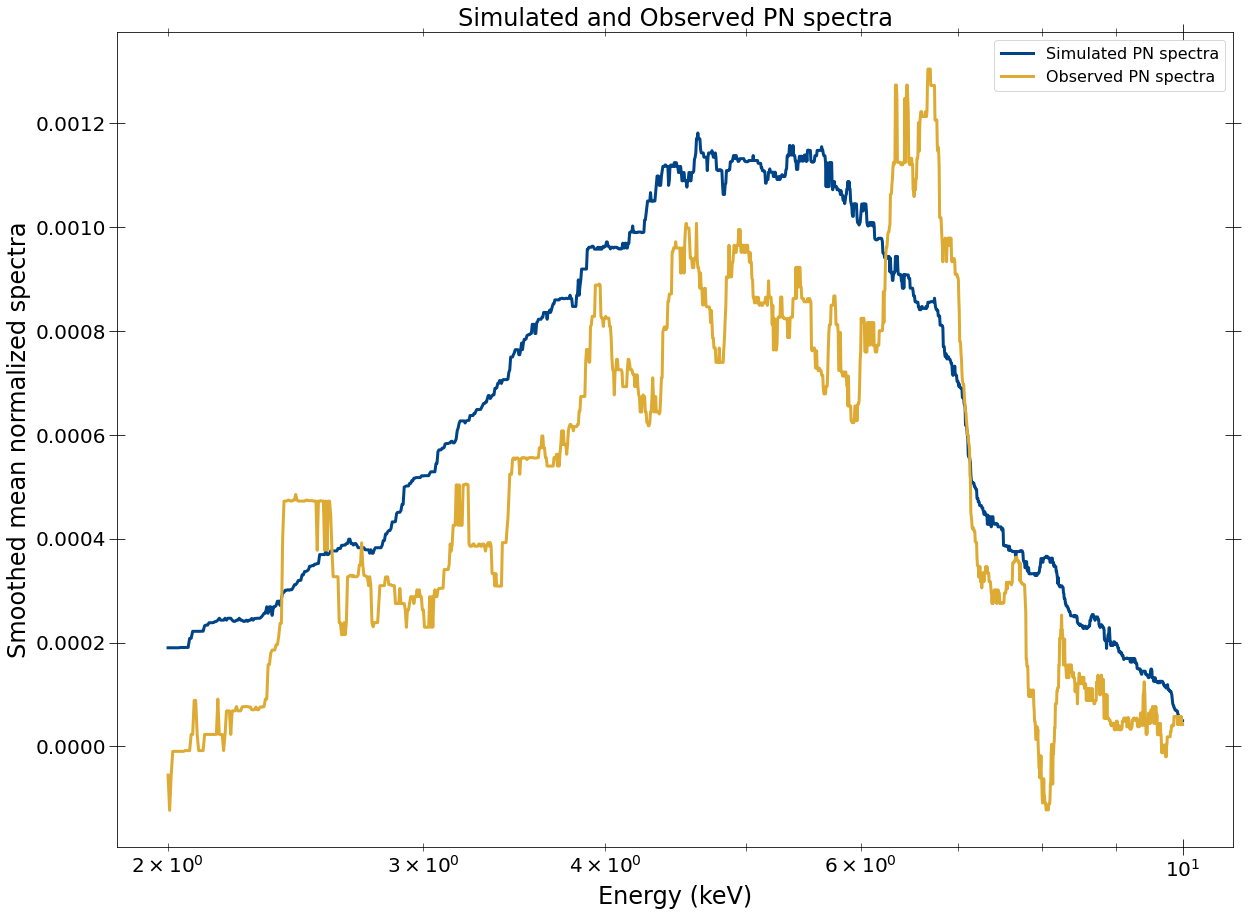

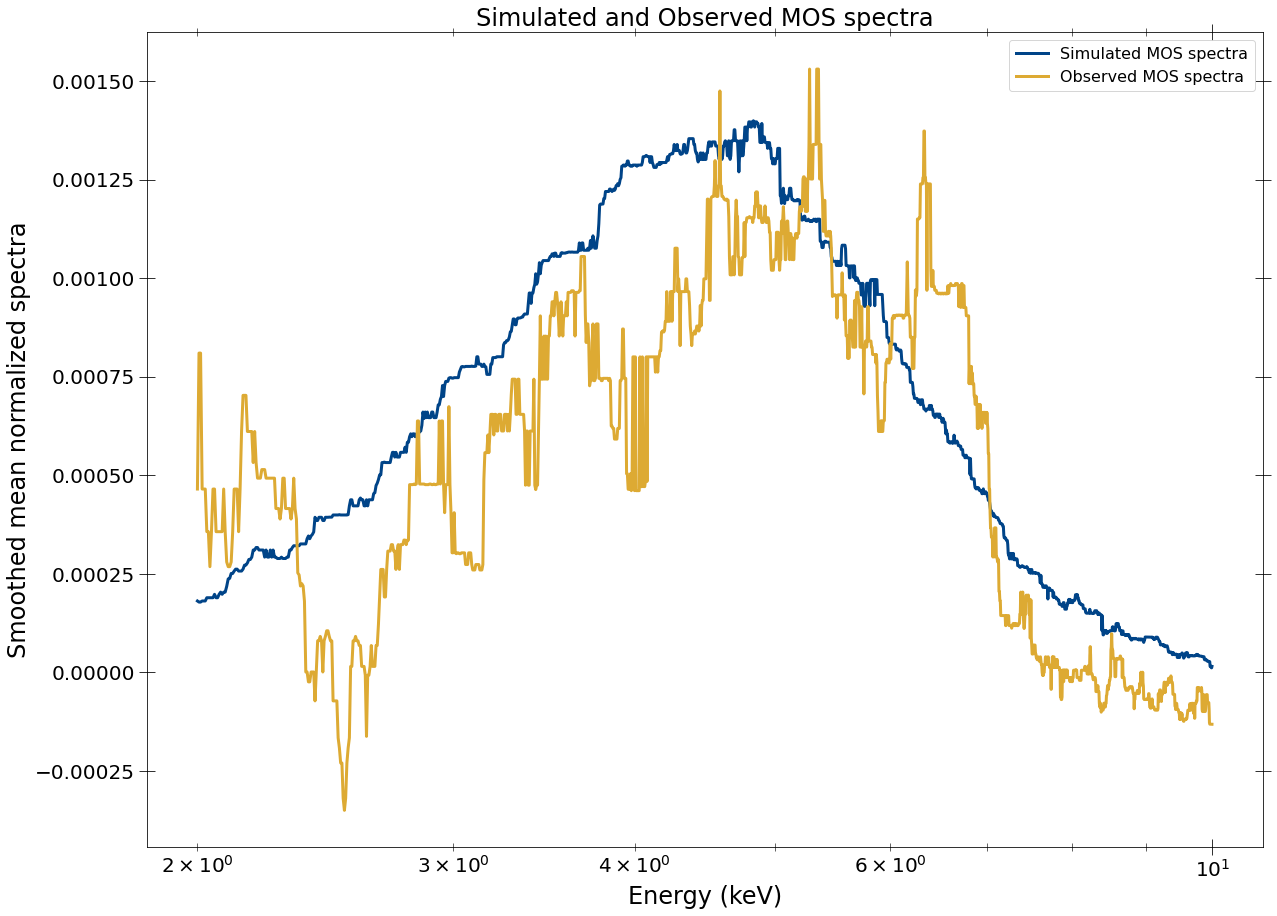

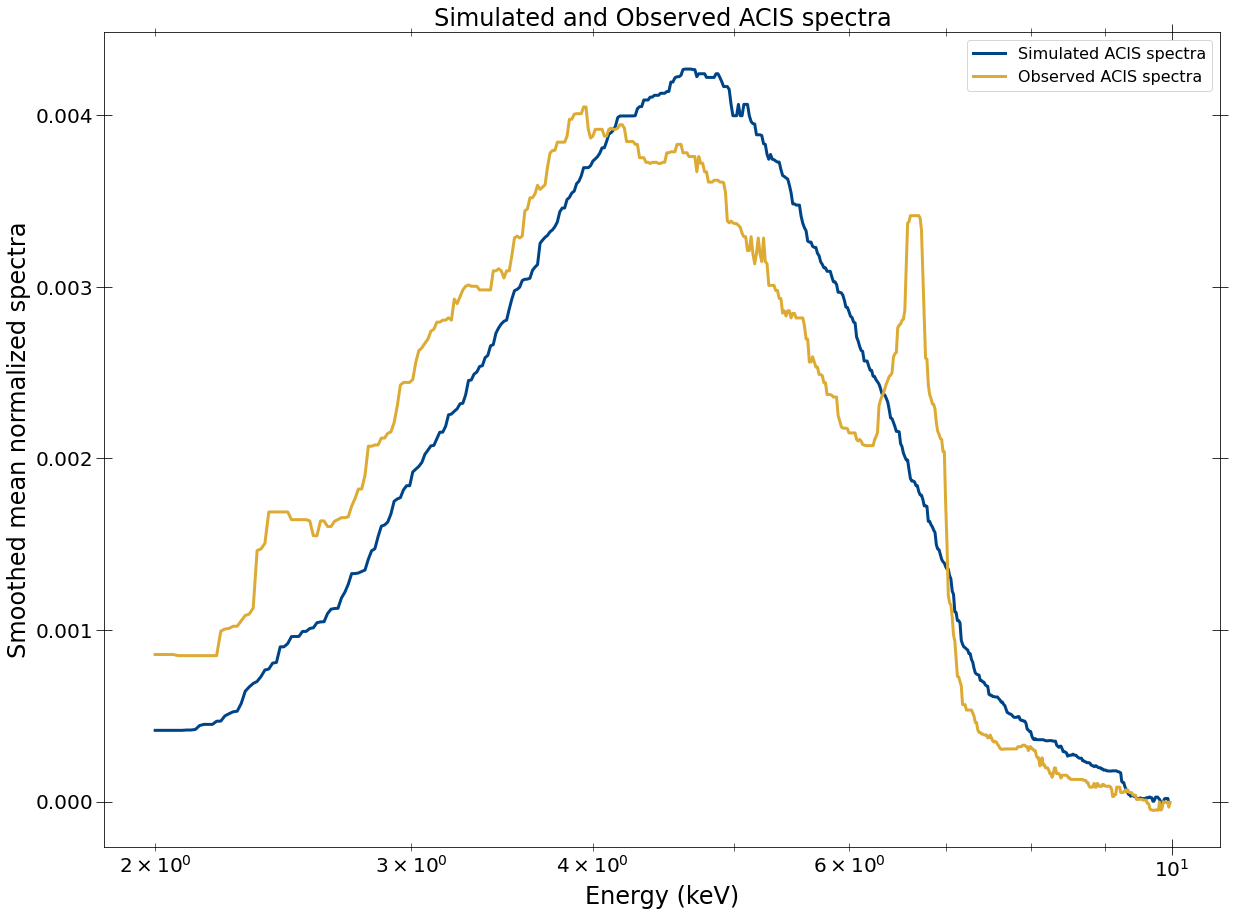

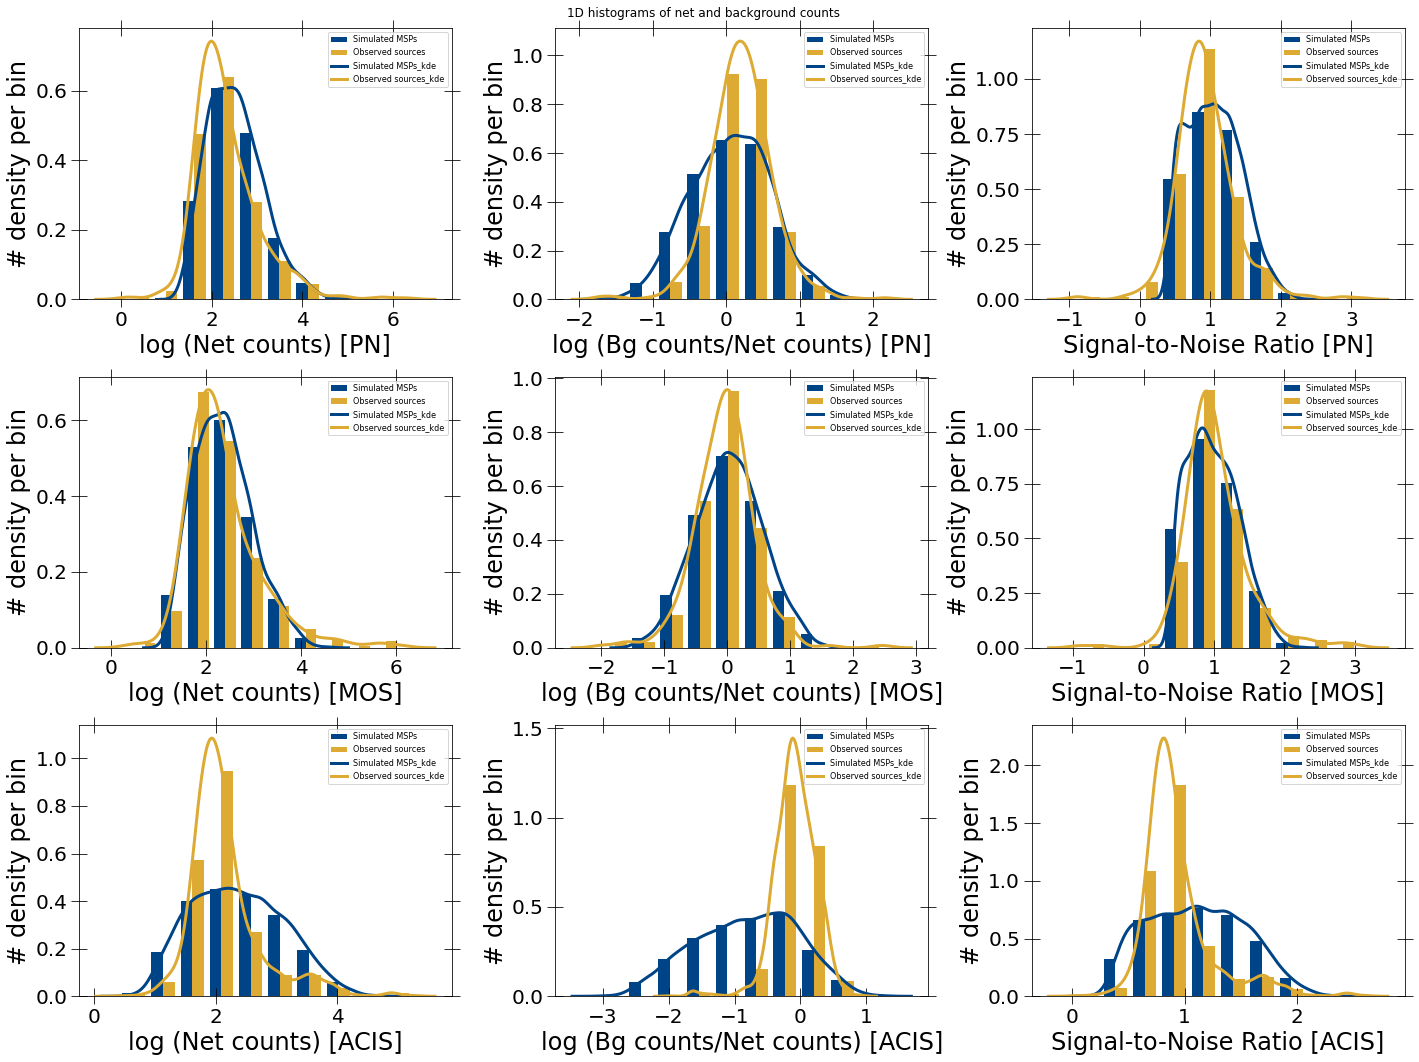

In [340]:
spec_summary = load_alldata(
     [pn_response_path, mos_response_path, chandra_response_path],
     [xmm_sim_path, xmm_sim_path, chandra_sim_path],
     [xmm_obs_path, xmm_obs_path, chandra_obs_path], en_range=[2, 10])

In [46]:
def fit_src_pl_gauss(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    xspec.Xset.parallel.error = 4
    xspec.Xset.parallel.goodness = 4
    if telescope == 'XMM':
        spec_pnfile = glob2.glob(src_folder + 'ip_' +
                                 str(source_num) + '_PN.fak')
        spec_mosfile = glob2.glob(src_folder + 'ip_' +
                                  str(source_num) + '_MOS.fak')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        #os.chdir(src_folder + '/' + source_num)
        spec_file = 'ip_' + str(source_num) + '.fak'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.7, 0.0001, 6.1, 6.1, 7.3, 7.3'
    model.gaussian.Sigma.values = '0.1 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('2.706 6')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 8')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 6')
    xspec.Fit.error('2.706 8')
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    line_pos_low = xspec.AllModels(1).gaussian.LineE.error[0]
    line_pos_high = xspec.AllModels(1).gaussian.LineE.error[1]
    line_norm_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm_high = xspec.AllModels(1).gaussian.norm.error[1]
    print('Model params for ' + str(source_num) +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_pos:', xspec.AllModels(1).gaussian.LineE.values[0],
          line_pos_low, line_pos_high,
          ' Fe_norm:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm_low, line_norm_high)
    print('Fit stats for ' + str(source_num) + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.LineE.values[0], line_pos_low,
             line_pos_high,
             xspec.AllModels(1).gaussian.norm.values[0], line_norm_low,
             line_norm_high])


20:9: E265 block comment should start with '# '
27:1: W293 blank line contains whitespace
36:1: W293 blank line contains whitespace
48:5: E265 block comment should start with '# '
66:80: E501 line too long (80 > 79 characters)


In [50]:
def fit_src_pl(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    xspec.Xset.parallel.error = 4
    xspec.Xset.parallel.goodness = 4
    if telescope == 'XMM':
        spec_pnfile = glob2.glob(src_folder + 'ip_' +
                                 str(source_num) + '_PN.fak')
        spec_mosfile = glob2.glob(src_folder + 'ip_' +
                                  str(source_num) + '_MOS.fak')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        #os.chdir(src_folder + '/' + source_num)
        spec_file = 'ip_' + str(source_num) + '.fak'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')

    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('2.706 2')
    xspec.Fit.perform()
    print('Calculating goodness')
    #goodness = xspec.Fit.goodness(1000)
    print('Finished calculating goodness')
    goodness = 50.0
    print('Model params for ' + str(source_num) +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats for ' + str(source_num) + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

20:9: E265 block comment should start with '# '
38:5: E265 block comment should start with '# '
50:80: E501 line too long (80 > 79 characters)


In [73]:
fit_src_pl(int_srcs_subset[2][1], src_folder='./', telescope='Chandra')

Calculating goodness
Finished calculating goodness
Model params for 4077: NH =  24.54827790020356  Gamma:  4.092103100295662  norm:  306.7658918045628
Fit stats for 4077:  575.4720072131635 -7.44424744673208 50.0 546




([4077, 575.4720072131635, -7.44424744673208, 50.0, 546],
 [4077, 24.54827790020356, 4.092103100295662, 306.7658918045628])

In [44]:
xspec.AllData.clear()
os.chdir('/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/sim_ips_highnh_xu2016_twice_ew/')

In [240]:
import xspec

In [67]:
os.getcwd()

'/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/sim_ips_highnh_twice_ew_chandra'

In [58]:
pn_fit_stats_table_pl_g = []
pn_model_params_table_pl_g = []
pn_fit_stats_table_pl_g2 = []
pn_model_params_table_pl_g2 = []

for source_num in int_srcs_subset[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    pn_fit_stats_table_pl_g.append(fit_stats)
    pn_model_params_table_pl_g.append(model_params)
    pn_fit_stats_table_pl_g2.append(fit_stats2)
    pn_model_params_table_pl_g2.append(model_params2)

347
Model params for 347: NH =  101.31631866783323  Gamma:  4.947905787454645  norm:  3.2661822643264444  Fe_pos: 6.667351860094041 0.0 6.983675930047021  Fe_norm: 1.912357493038835e-06 2.0272428698784157e-08 3.967114654833149e-06
Fit stats for 347:  1904.2148071804868 -5.459210344862527 50.0 1681


Model params for 347: NH =  99.21528286574132  Gamma:  4.999999229369733  norm:  3.190979988873718  Fe_norms: 1.1527769646224574e-07 0.0 1.5541426112485114e-06 1.8072032864287008e-06 4.1286421617606247e-07 3.4900965686761907e-06 4.779743080893271e-07 0.0 1.7434054714532032e-06
Fit stats for 347:  1902.110304737197 -5.584753074354556 50.0 1680


3446
Model params for 3446: NH =  14.286099905857075  Gamma:  1.2707797640467855  norm:  0.8291629695754479  Fe_pos: 6.498951140150551 6.447509354180815 6.549210788219122  Fe_norm: 3.8884306222048086e-06 2.8827972353969217e-06 4.969211772997878e-06
Fit stats for 3446:  488.93798170409957 -9.637981742423728 50.0 413


Model params for 3446: NH =  14.5

Model params for 8228: NH =  19.604868261406857  Gamma:  0.8969073001414393  norm:  0.6040090853308997  Fe_norms: 6.494935560785045e-07 0.0 1.929999082719612e-06 1.1361082667449267e-06 0.0 2.7200321095012564e-06 8.822893632128673e-07 0.0 2.542700746326808e-06
Fit stats for 8228:  391.96426843601915 -8.026962566624077 50.0 397


9147
Model params for 9147: NH =  11.910878093713535  Gamma:  0.8788176364665167  norm:  0.24337071201920268  Fe_pos: 6.480340912522191 6.17508870790461 6.839109753351456  Fe_norm: 9.008643861680475e-07 1.1479934286369143e-07 1.8320987897443835e-06
Fit stats for 9147:  1850.9999154853713 -6.163170117205384 50.0 1618


Model params for 9147: NH =  12.152633642082675  Gamma:  0.939533603658395  norm:  0.24115616688686703  Fe_norms: 5.606813946756905e-07 8.382056614830425e-09 1.2728777611541962e-06 6.31582172833095e-07 5.229552236093405e-09 1.4199209252936152e-06 1.7537522754228335e-11 0.0 5.824159925909308e-07
Fit stats for 9147:  1849.4038884693864 -6.14795795459

Model params for 3010: NH =  13.396465456581817  Gamma:  1.6286567574970192  norm:  0.7170859297208432  Fe_pos: 6.388852480499012 6.281881151086279 6.520086850825221  Fe_norm: 2.8647038571934617e-06 1.2040011819603278e-06 4.798868960970649e-06
Fit stats for 3010:  216.55383429551293 -8.867412289936377 50.0 217


Model params for 3010: NH =  13.995684412223369  Gamma:  1.7507275732776855  norm:  0.7248537444847115  Fe_norms: 2.435354691637933e-06 9.827733909474665e-07 4.1739322355273366e-06 3.265947495645858e-07 0.0 1.809890943876539e-06 9.773648631740287e-07 0.0 2.5582200871898997e-06
Fit stats for 3010:  215.73410643393055 -9.051332827429931 50.0 216


7297
Model params for 7297: NH =  18.165556400646693  Gamma:  4.99999481923188  norm:  0.04211755290865335  Fe_pos: 6.682683849557634 6.545906948940537 6.839050974280569  Fe_norm: 6.275728972343889e-07 2.0485849782752535e-07 1.042059440517577e-06
Fit stats for 7297:  1819.2498012367244 -3.986811863516242 50.0 1718


Model params for 729

Model params for 2798: NH =  11.87209450883441  Gamma:  1.4713101826633264  norm:  0.5010803132410119  Fe_norms: 4.0766418305236624e-07 5.632092210113899e-08 7.92113247636327e-07 6.586257081125703e-07 2.774819362964126e-07 1.0752933780314779e-06 4.0335403966384837e-07 2.8782043671149914e-08 8.161421173328474e-07
Fit stats for 2798:  1268.7243097736473 -10.113310788284313 50.0 1145


577
Model params for 577: NH =  19.628904422245473  Gamma:  1.2849127361280357  norm:  0.6417658177405484  Fe_pos: 6.59438200219024 6.518367378435897 6.662402788358535  Fe_norm: 2.3432175171496633e-06 1.575214126707646e-06 3.152190316226485e-06
Fit stats for 577:  1902.9110703476065 -9.430453290681946 50.0 1770


Model params for 577: NH =  19.724772221888472  Gamma:  1.3197081208060348  norm:  0.6386912317036724  Fe_norms: 1.067773982121842e-06 5.195121158388947e-07 1.6508510987832734e-06 1.435045111625259e-06 8.268058366148707e-07 2.081044583825918e-06 2.1509130065528092e-07 0.0 7.909670808419696e-07
Fit 

Model params for 8946: NH =  67.64925418101613  Gamma:  1.3154636025407032  norm:  1.2771226139988685  Fe_pos: 7.3 6.159165335780814 0.0  Fe_norm: 2.7483933850753625e-06 0.0 8.58863548802672e-06
Fit stats for 8946:  869.3945599751918 -7.5684296896049075 50.0 871


Model params for 8946: NH =  57.03665903404662  Gamma:  0.8512022198568517  norm:  1.0208072302439783  Fe_norms: 4.877010736475397e-07 0.0 2.3810770294747187e-06 3.462825804243207e-07 0.0 2.1532313813555355e-06 5.783225915582848e-08 0.0 1.8983312794240736e-06
Fit stats for 8946:  871.0739774249112 -7.369761680805918 50.0 870


723
Model params for 723: NH =  45.94017801536036  Gamma:  1.4844557438274764  norm:  0.8556194867811739  Fe_pos: 6.58380027949154 6.274116197692028 7.217554052272061  Fe_norm: 2.0061200405117112e-06 2.4380257132286165e-07 4.027381634501174e-06
Fit stats for 723:  298.33845491043917 -8.998916540790272 50.0 303


Model params for 723: NH =  45.03711052166208  Gamma:  1.5903085782504818  norm:  0.81929428

Model params for 7834: NH =  42.5010080795297  Gamma:  1.2575766264825332  norm:  0.510272557430741  Fe_pos: 6.567238217340887 6.452848240693003 6.670909135934643  Fe_norm: 2.31582724986379e-06 1.1368718643281046e-06 3.734241516989931e-06
Fit stats for 7834:  394.84510156999727 -6.341135720660702 50.0 361


Model params for 7834: NH =  42.069957133980736  Gamma:  1.4499377132674482  norm:  0.48966285275403837  Fe_norms: 1.3364943287720275e-06 4.4390193171858243e-07 2.433918823232304e-06 1.2234758024581128e-06 3.955176148864849e-07 2.2624666859718103e-06 1.007172067105094e-06 1.4173666756233975e-07 2.103846023592828e-06
Fit stats for 7834:  392.57448391408786 -6.338098591360765 50.0 360


8484
Model params for 8484: NH =  68.59927599759075  Gamma:  2.934209194080127  norm:  0.5632374842757656  Fe_pos: 6.923078739246852 6.780939215390674 7.067045734912861  Fe_norm: 1.1351903225119973e-06 4.2554821563377925e-07 2.1327803566208477e-06
Fit stats for 8484:  700.4966149872838 -7.5266537987132

Model params for 5900: NH =  70.19610458385952  Gamma:  1.648758473546015  norm:  0.2072591626659335  Fe_norms: 3.367590925798214e-07 0.0 8.184100685616293e-07 2.204694559846898e-07 0.0 6.291679884952649e-07 1.478666782740824e-08 0.0 3.5352565254233457e-07
Fit stats for 5900:  699.4195893436944 -8.543984462576674 50.0 678


7562
Model params for 7562: NH =  12.393736772923173  Gamma:  1.895525532057829  norm:  1.1089973516732965  Fe_pos: 6.363734359322805 6.156125577924299 7.094197184480124  Fe_norm: 2.691237327892021e-06 6.420755199513891e-08 5.821145019506844e-06
Fit stats for 7562:  228.32117039476412 -8.199622017716901 50.0 190


Model params for 7562: NH =  13.113245150596581  Gamma:  2.0615918409823295  norm:  1.1282194907155272  Fe_norms: 1.901829036974314e-06 0.0 4.865716080684742e-06 1.5568654410902507e-06 0.0 4.760819907388015e-06 1.472267175345639e-06 0.0 4.177444915195744e-06
Fit stats for 7562:  226.80136034200933 -8.120886687457714 50.0 189


1366
Model params for 1366: N

Model params for 5000: NH =  38.15859698940788  Gamma:  1.7253897298432743  norm:  0.14706728623505388  Fe_pos: 6.878237125741499 6.729538749277815 7.01274859918199  Fe_norm: 6.963165337097423e-07 2.4320471130985444e-07 1.2196068678806976e-06
Fit stats for 5000:  703.3212501782697 -5.717156530404309 50.0 692


Model params for 5000: NH =  37.527558549754  Gamma:  1.6622257164967649  norm:  0.14372458562973556  Fe_norms: 1.0541640154690046e-07 0.0 4.936573247366975e-07 2.1930712108754671e-07 0.0 6.508160354345711e-07 3.497348211060936e-07 1.0653047967997558e-08 8.361075249960456e-07
Fit stats for 5000:  706.5434588918349 -5.73582974205421 50.0 691


3289
Model params for 3289: NH =  44.01695424065897  Gamma:  1.8989482737222283  norm:  0.5504513603682667  Fe_pos: 6.342343221758772 6.2248764165542925 6.495747090277584  Fe_norm: 1.383513865338942e-06 2.6759129121202214e-07 2.8216251647363863e-06
Fit stats for 3289:  216.51385403981857 -8.294309730907443 50.0 222


Model params for 3289: N

Model params for 4622: NH =  9.837588206228066  Gamma:  1.2045674041581342  norm:  1.10062763845179  Fe_norms: 3.0331537266099426e-06 2.043622836499634e-06 4.121285077348102e-06 1.4606420571888365e-06 5.45708153724782e-07 2.487315089303939e-06 1.0558916044147623e-06 9.158847527425711e-08 2.152419113438482e-06
Fit stats for 4622:  582.3971340594317 -10.20349895188418 50.0 490


8391
Model params for 8391: NH =  31.953086551829223  Gamma:  5.0  norm:  0.8167978038719087  Fe_pos: 6.205378948627942 0.0 0.0  Fe_norm: 6.783899132427308e-07 0.0 1.7107229219526135e-06
Fit stats for 8391:  1202.2806474846714 -4.772134334177418 50.0 1530


Model params for 8391: NH =  32.96428610797749  Gamma:  5.0  norm:  0.8800631488504489  Fe_norms: 2.397644375374335e-07 0.0 1.089768360827217e-06 7.313300887644436e-23 0.0 6.881088758698843e-07 3.2879923386135795e-23 0.0 4.4785646920205314e-07
Fit stats for 8391:  1203.682221525279 -4.744978185521288 50.0 1529


5900
Model params for 5900: NH =  60.76925619070

Model params for 5635: NH =  23.52604439209814  Gamma:  1.821028607025975  norm:  0.14621935528579583  Fe_pos: 6.464030260181625 6.343362944904181 6.586183007714007  Fe_norm: 6.818148541713001e-07 2.990042932820715e-07 1.1350175693887693e-06
Fit stats for 5635:  1396.0687618930406 -6.784957267849465 50.0 1445


Model params for 5635: NH =  23.682219407537573  Gamma:  1.8425483076070743  norm:  0.1470663904592815  Fe_norms: 4.824862989703849e-07 1.7617234858765157e-07 8.499835731274388e-07 2.2444587178974946e-07 0.0 5.685182527561189e-07 3.248845686916745e-13 0.0 1.6098371998012855e-07
Fit stats for 5635:  1396.9871667156253 -6.7927118524975 50.0 1444


191
Model params for 191: NH =  30.486284208625737  Gamma:  1.7336981560514888  norm:  0.6815643219408427  Fe_pos: 6.843788943258498 6.745511091363942 6.939264602632142  Fe_norm: 1.0849589700879464e-06 4.419572744447234e-07 1.7897668313687482e-06
Fit stats for 191:  1256.917613533958 -9.604168632283425 50.0 1114


Model params for 191: N

Model params for 2866: NH =  52.89090291120188  Gamma:  1.9993006625225878  norm:  0.9729539246182061  Fe_norms: 2.5416810034253363e-06 1.3856721587223077e-06 3.93555092321537e-06 6.343556742282022e-07 0.0 1.729571591104493e-06 6.546214013097575e-07 0.0 1.7127890363539818e-06
Fit stats for 2866:  459.78334177508316 -8.36789109822678 50.0 485


1038
Model params for 1038: NH =  14.691370679954678  Gamma:  1.6451718663528465  norm:  0.8039214052290224  Fe_pos: 6.789220507506247 6.692906891062361 6.889446839367444  Fe_norm: 3.857189920013414e-06 1.868264895598982e-06 6.1657158996713866e-06
Fit stats for 1038:  346.03877173968164 -9.653257780659574 50.0 342


Model params for 1038: NH =  14.74903618639561  Gamma:  1.66842222323716  norm:  0.8009088976471445  Fe_norms: 6.124140192516198e-07 0.0 2.0813501465775514e-06 2.4237024576618496e-06 8.094984293971699e-07 4.341205025460664e-06 1.1293366434134965e-06 0.0 2.9564404148145023e-06
Fit stats for 1038:  349.2448345080927 -9.826597238276328 5

Model params for 6313: NH =  12.719133792510238  Gamma:  1.1302098986703535  norm:  0.19351314335426492  Fe_pos: 6.554004275128122 6.450089059256396 6.6698267628572845  Fe_norm: 8.141168797395202e-07 4.0710226666113235e-07 1.2694299479873363e-06
Fit stats for 6313:  938.2001140471493 -9.987228439962973 50.0 911


Model params for 6313: NH =  13.180732963694156  Gamma:  1.2486940585120552  norm:  0.19128466147234136  Fe_norms: 3.812788579650703e-07 6.052871679457024e-08 7.474887715863985e-07 3.482629237418258e-07 3.133468421612771e-08 7.15303787611187e-07 4.4211520449734626e-07 1.3642039680735756e-07 8.012528034307193e-07
Fit stats for 6313:  938.0271651858543 -10.079451054548246 50.0 910


2270
Model params for 2270: NH =  13.802933498763364  Gamma:  2.2636839462635026  norm:  0.9860575727265793  Fe_pos: 6.711431063349438 6.65120490666767 6.773895524300909  Fe_norm: 5.40170291739888e-06 3.134723556386628e-06 8.013655352869331e-06
Fit stats for 2270:  873.6365518345879 -7.97597744510515

Model params for 7179: NH =  64.50174173032744  Gamma:  1.5864170570602025  norm:  1.3117232575589304  Fe_norms: 1.916753229373902e-06 4.941945910102769e-07 3.5847118494588537e-06 9.318063889390193e-08 0.0 1.5945007601303575e-06 6.215487009995615e-07 0.0 2.2001886813956326e-06
Fit stats for 7179:  600.8203200704456 -8.235485321291792 50.0 579


4244
Model params for 4244: NH =  8.78479799405968  Gamma:  1.0971308831528435  norm:  0.41384056024998067  Fe_pos: 6.336533402825057 0.0 6.928198288938288  Fe_norm: 9.102761145174077e-07 5.030555649278768e-08 1.9004105453097992e-06
Fit stats for 4244:  341.1557122952952 -7.906433014740256 50.0 335


Model params for 4244: NH =  8.985844808234903  Gamma:  1.1313214044145152  norm:  0.41541896495438857  Fe_norms: 5.518773929850932e-07 0.0 1.3798685714490784e-06 2.4431749666336786e-07 0.0 1.0835318619454808e-06 2.343733900359942e-07 0.0 1.1265709608053713e-06
Fit stats for 4244:  342.1771605234892 -7.942956090932856 50.0 334


3189
Model params fo

Model params for 1610: NH =  7.071492248617854  Gamma:  0.5074635852955611  norm:  0.22705019549659478  Fe_norms: 1.585070566405186e-12 0.0 6.333155427885732e-07 1.5553060284549357e-07 0.0 1.4344307847383561e-06 1.7732906523838982e-15 0.0 1.1139201642773566e-06
Fit stats for 1610:  1850.6670181214372 -4.948602913918166 50.0 1766


2439
Model params for 2439: NH =  19.58904160125665  Gamma:  0.537695290273818  norm:  0.4373542953572108  Fe_pos: 6.547612429195242 6.409675076826459 6.724863300520107  Fe_norm: 2.4330946773963357e-06 1.2550690344571862e-06 3.846070362558089e-06
Fit stats for 2439:  247.983263985437 -8.61865704909207 50.0 280


Model params for 2439: NH =  19.533831631871482  Gamma:  0.6762339412153957  norm:  0.41269097886385475  Fe_norms: 1.5255154490523499e-06 6.426246447108177e-07 2.596097622280537e-06 1.4978157241421613e-06 4.547356512383264e-07 2.778640066946658e-06 7.887332672501436e-07 0.0 1.9839544190648056e-06
Fit stats for 2439:  242.33196357825196 -8.739756599947

Model params for 7833: NH =  29.265805137773416  Gamma:  1.6912008670555307  norm:  0.5908818393528912  Fe_pos: 6.441263749358713 6.368609907193064 6.513051446697724  Fe_norm: 2.4962209777416367e-06 1.6169755484739827e-06 3.4746402381318926e-06
Fit stats for 7833:  842.6991304661407 -8.913142100360503 50.0 1322


Model params for 7833: NH =  29.191212548226797  Gamma:  1.788416087856688  norm:  0.5806204948623104  Fe_norms: 1.8947342503161173e-06 1.1770291599649526e-06 2.7171456566558604e-06 9.063443530798977e-07 2.731018749263615e-07 1.6354447861543445e-06 6.313176296438727e-07 5.354848524357905e-08 1.3145638188520284e-06
Fit stats for 7833:  838.0339739788627 -8.893013821958247 50.0 1321


1405
Model params for 1405: NH =  38.9615819400194  Gamma:  1.3257713438709144  norm:  0.757608051531057  Fe_pos: 6.443146788202055 6.246571417384689 0.0  Fe_norm: 2.058997805278434e-06 3.0866583282901724e-07 4.146444288508848e-06
Fit stats for 1405:  308.1586653021202 -7.532451470036036 50.0 319



Model params for 6229: NH =  48.9904085948599  Gamma:  4.999997846201169  norm:  0.31622889798995046  Fe_norms: 1.3664480203265316e-07 0.0 4.5051403602986967e-07 5.307720352976479e-08 0.0 3.468587383030712e-07 9.067982569265942e-22 0.0 1.7723289567286815e-07
Fit stats for 6229:  1739.278062883871 -3.8498038103580976 50.0 1569


4076
Model params for 4076: NH =  17.759286019901936  Gamma:  1.8146499619034855  norm:  0.19804631856248608  Fe_pos: 6.593008063494751 6.484472074595394 6.703937948608961  Fe_norm: 1.0423411873357069e-06 3.6293580203948085e-07 1.8739393929809562e-06
Fit stats for 4076:  474.40596580962585 -7.90096613482447 50.0 486


Model params for 4076: NH =  17.462901730324038  Gamma:  1.7314668913788742  norm:  0.19818221883367063  Fe_norms: 2.0167468110702763e-07 0.0 7.592023729936325e-07 6.046698046425186e-07 5.433871074575923e-08 1.2984234527400636e-06 2.5716923066531946e-08 0.0 5.90558800441851e-07
Fit stats for 4076:  477.65996408087057 -7.899989388969807 50.0 485


4

In [243]:
pn_fit_stats_table2_pl_g = []
pn_model_params_table2_pl_g = []
pn_fit_stats_table2_pl_g2 = []
pn_model_params_table2_pl_g2 = []

for source_num in interested_srcs_alldet2[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    pn_fit_stats_table2_pl_g.append(fit_stats)
    pn_model_params_table2_pl_g.append(model_params)
    pn_fit_stats_table2_pl_g2.append(fit_stats2)
    pn_model_params_table2_pl_g2.append(model_params2)

200305401010049
Model params for 200305401010049: NH =  39.80595888401704  Gamma:  2.3825591994546134e-06  norm:  0.21361680758265583  Fe_pos: 6.100000111108822 0.0 0.0  Fe_norm: 3.06779052292325e-23 0.46326946953921294 0.0
Fit stats for 200305401010049:  331.47549413760163 -5.57881296425545 50.0 437


Model params for 200305401010049: NH =  24.438736445600597  Gamma:  1.7255975200034478e-06  norm:  0.13858239915107873  Fe_norms: 8.516062428125166e-21 0.0 3.444170365818164e-07 5.978606096270344e-07 0.0 1.3919180144732897e-06 6.108052249182213e-07 0.0 1.4395946490753204e-06
Fit stats for 200305401010049:  327.47359359882256 -6.03200922906665 50.0 436


201129701010051
Model params for 201129701010051: NH =  0.10000000000173763  Gamma:  1.2594627700780238e-06  norm:  0.13756465360305595  Fe_pos: 6.58273370665754 6.43622524986314 6.71692219852442  Fe_norm: 6.114755862461551e-07 9.324075071245871e-08 1.2426457647930034e-06
Fit stats for 201129701010051:  306.85672590498393 -6.2578305267910

Model params for 202026707010239: NH =  66.01119399784378  Gamma:  9.841147953495933e-05  norm:  0.06323665022633702  Fe_pos: 6.587005957450174 6.433280632269624 6.774816815447761  Fe_norm: 7.942884457293147e-07 1.764204819577287e-07 3.334755295854453e-06
Fit stats for 202026707010239:  848.6679086530474 -0.09193838408086667 50.0 1015


Model params for 202026707010239: NH =  74.37422718924367  Gamma:  0.07509599452052837  norm:  0.07649845764245573  Fe_norms: 2.7019295731909096e-07 0.0 1.7372335782386792e-06 3.936576931028525e-07 0.0 1.7681720342744087e-06 2.100291108781944e-15 0.0 3.206897415449207e-07
Fit stats for 202026707010239:  850.9452154831648 -0.09203282801898459 50.0 1014


202026708010117
Model params for 202026708010117: NH =  135.8489498021393  Gamma:  1.3071885067454876e-06  norm:  0.34171941479213636  Fe_pos: 6.139969988839689 0.0 0.0  Fe_norm: 2.026564270146005e-06 0.0 0.00025644280572002765
Fit stats for 202026708010117:  379.31421782597425 -3.635128490972496 50.0 44

Model params for 206556701010023: NH =  2.1270834826659266  Gamma:  2.505390338589546e-06  norm:  0.07251707791549934  Fe_pos: 6.557813169094284 6.479322648973209 6.635290379954195  Fe_norm: 6.914120104447882e-07 3.2032208431706496e-07 1.105381503088828e-06
Fit stats for 206556701010023:  770.028659732099 -5.842006357962617 50.0 907


Model params for 206556701010023: NH =  2.4458583510544054  Gamma:  1.4730520619281761e-07  norm:  0.07511148603302732  Fe_norms: 2.0222800055122265e-07 0.0 4.968472247899483e-07 1.930327210505575e-07 0.0 5.319874228207905e-07 1.8181029414489774e-07 0.0 5.522292049676187e-07
Fit stats for 206556701010023:  776.9391645937985 -5.858277949897014 50.0 906


206556701010040
Model params for 206556701010040: NH =  39.267335257721335  Gamma:  2.221091058235401  norm:  0.12681594908263072  Fe_pos: 6.923200564881908 0.0 0.0  Fe_norm: 3.246964938808722e-07 0.0 6.284873155092487e-07
Fit stats for 206556701010040:  858.6651904626445 -6.30228880242744 50.0 1102


Mode

Model params for 206946402010138: NH =  6.615287461677243  Gamma:  1.273079242861707  norm:  0.0785740866905896  Fe_pos: 6.163074972164117 0.0 7.196918721081235  Fe_norm: 2.6504235226373944e-07 0.0 5.814755880971426e-07
Fit stats for 206946402010138:  419.7954924868701 -6.4309899448586725 50.0 514


Model params for 206946402010138: NH =  7.038965950005619  Gamma:  1.3277537281022844  norm:  0.0804472548687927  Fe_norms: 2.1841421356677956e-08 0.0 2.823595294901373e-07 9.919303618460698e-08 0.0 3.782107862022948e-07 1.7057696279067852e-07 0.0 4.6166819580716564e-07
Fit stats for 206946402010138:  420.67132162483847 -6.518117447608181 50.0 513


206946404010105
Model params for 206946404010105: NH =  20.35914722009558  Gamma:  0.08794200758751608  norm:  0.12946510195886557  Fe_pos: 6.563031112125658 6.124769761468572 0.0  Fe_norm: 6.471151006785165e-07 0.0 1.519249074702212e-06
Fit stats for 206946404010105:  300.4134656784083 -5.951315868439392 50.0 349


Model params for 206946404010

Model params for 207641901010010: NH =  6.966433928941913  Gamma:  0.23352553712362822  norm:  0.20500201515126196  Fe_pos: 7.299999999699763 6.700517413061059 0.0  Fe_norm: 8.871815469333716e-07 1.2391972887974015e-07 1.853589796553659e-06
Fit stats for 207641901010010:  356.88825701159817 -7.315146152461581 50.0 435


Model params for 207641901010010: NH =  5.584923667551076  Gamma:  0.07124772805274578  norm:  0.20246397208911823  Fe_norms: 1.0936700637223285e-07 0.0 5.864642517171806e-07 2.6672803681815725e-07 0.0 8.185401334656552e-07 2.6634039825366583e-07 0.0 8.620476677970026e-07
Fit stats for 207641901010010:  358.87529932304 -7.30183244033844 50.0 434


207641901010014
Model params for 207641901010014: NH =  17.815842269150096  Gamma:  1.4169791329719932  norm:  0.21318169784954769  Fe_pos: 7.3 0.0 0.0  Fe_norm: 4.758234678664807e-07 0.0 1.3736820114295742e-06
Fit stats for 207641901010014:  275.11508938012537 -6.559737768127809 50.0 327


Model params for 207641901010014: NH

Model params for 208441011010009: NH =  1.2695414140107382  Gamma:  1.0536247034338173  norm:  0.35466225933541756  Fe_pos: 6.432624320369774 0.0 0.0  Fe_norm: 2.4762016456785645e-07 0.0 1.4210372706082378e-06
Fit stats for 208441011010009:  294.2073491791614 -7.8395790979769835 50.0 371


Model params for 208441011010009: NH =  1.2868901817658809  Gamma:  1.0592237482221267  norm:  0.35426059504130303  Fe_norms: 2.667065157521264e-07 0.0 1.2434105584824897e-06 1.1670327231228508e-08 0.0 9.672209467692376e-07 6.323019823215546e-11 0.0 6.876217854749685e-07
Fit stats for 208441011010009:  294.0814906869676 -7.8413349644011765 50.0 370


208441011010032
Model params for 208441011010032: NH =  2.041467668945232  Gamma:  0.7192569850985779  norm:  1.0208480795287638  Fe_pos: 7.002399355950746 0.0 0.0  Fe_norm: 1.9256852361294383e-06 0.0 6.719554309635833e-06
Fit stats for 208441011010032:  305.41624492881783 -7.970791590850964 50.0 333


Model params for 208441011010032: NH =  1.9479979617

Model params for 200305401015015: NH =  6.102124233831839  Gamma:  0.7141327534247249  norm:  0.17891718458002673  Fe_pos: 6.472152763664358 0.0 0.0  Fe_norm: 3.9330846708869585e-07 0.0 1.0704722053311355e-06
Fit stats for 200305401015015:  501.31167013964114 -7.651884856653909 50.0 640


Model params for 200305401015015: NH =  6.429024337387809  Gamma:  0.7945053270672161  norm:  0.17665077429030326  Fe_norms: 2.9731295600544286e-07 0.0 8.1226586465844e-07 1.4903775326507075e-07 0.0 7.1192333385351e-07 1.5297087700968577e-07 0.0 7.363728054955049e-07
Fit stats for 200305401015015:  500.9033339521037 -7.6351389958538665 50.0 639


201129701010028
Model params for 201129701010028: NH =  12.49224372699796  Gamma:  5.2057672439109515e-05  norm:  0.08726669835039214  Fe_pos: 6.476992838574023 0.0 0.0  Fe_norm: 2.27892815913404e-07 0.0 6.382487907458613e-07
Fit stats for 201129701010028:  382.01067074326465 -7.223521531186869 50.0 451


Model params for 201129701010028: NH =  11.99746478030

Model params for 201129719010007: NH =  5.537782473938883  Gamma:  1.969773561846617e-05  norm:  0.4543773087541724  Fe_pos: 6.4227007713327255 6.334931058717694 6.5132077632371175  Fe_norm: 2.0620480549144144e-06 9.69050049366608e-07 3.291114956780158e-06
Fit stats for 201129719010007:  617.8092342543231 -5.472747205121675 50.0 684


Model params for 201129719010007: NH =  5.078827097486471  Gamma:  0.000445851703893506  norm:  0.4371352222801319  Fe_norms: 1.7415519784195234e-06 8.972335741001697e-07 2.738165423102965e-06 7.432325632889041e-07 0.0 1.7237623404330379e-06 6.743272174535729e-07 0.0 1.7136151245701622e-06
Fit stats for 201129719010007:  612.3848261709473 -5.5015604975553485 50.0 683


201129719015024
Model params for 201129719015024: NH =  12.671285520888826  Gamma:  1.1399437801766041  norm:  0.1648783774555974  Fe_pos: 6.531170700236952 0.0 6.7025908620041275  Fe_norm: 9.557951518850644e-07 3.4105162973570485e-07 1.7028100151006047e-06
Fit stats for 201129719015024:  4

Model params for 205110002015026: NH =  3.5204108647043904  Gamma:  1.4775456928426658  norm:  0.06718613731500002  Fe_pos: 6.569093154405726 6.189564669055946 6.795764183958111  Fe_norm: 3.2618924392486383e-07 6.523673459600386e-08 6.273792496898587e-07
Fit stats for 205110002015026:  677.6229584284479 -9.325812117080321 50.0 823


Model params for 205110002015026: NH =  4.06334012858652  Gamma:  1.6393193445172827  norm:  0.06627591469236307  Fe_norms: 1.8394547660360391e-07 0.0 4.243521490419012e-07 2.0310381042208477e-07 0.0 4.4774374603583886e-07 1.5073625333482905e-07 0.0 4.026565723795776e-07
Fit stats for 205110002015026:  676.2119295113032 -9.256223941521977 50.0 822


205110012010017
Model params for 205110012010017: NH =  13.21371247697383  Gamma:  2.393093721978135  norm:  4.832105489381408  Fe_pos: 6.792357426722151 6.587224813198149 6.959588312048532  Fe_norm: 6.858363769548059e-06 6.740571261144508e-08 1.538407223215578e-05
Fit stats for 205110012010017:  385.58855818499

Model params for 206946407010048: NH =  6.524311503742337  Gamma:  1.332092583494217  norm:  0.052998081844891146  Fe_norms: 9.06186569857991e-09 0.0 2.736529202912643e-07 4.747018732079034e-07 1.7389905909772395e-07 8.432627817929565e-07 2.804006725423302e-07 0.0 6.334241575822412e-07
Fit stats for 206946407010048:  526.2068128439031 -7.38459798011282 50.0 617


206946408010129
Model params for 206946408010129: NH =  22.450174294991236  Gamma:  3.1076277470917165e-05  norm:  0.10744525119757628  Fe_pos: 6.411989629578153 0.0 0.0  Fe_norm: 1.4047657789586108e-07 0.0 5.441257841368572e-07
Fit stats for 206946408010129:  609.9169328504026 -4.393653139946654 50.0 724


Model params for 206946408010129: NH =  22.010545702048493  Gamma:  2.42588887645507e-07  norm:  0.10570793788496688  Fe_norms: 1.9690533754319384e-07 0.0 5.285321302668344e-07 2.3824636365375285e-17 0.0 2.2700887130814757e-07 4.232469770584694e-08 0.0 4.0332648392976085e-07
Fit stats for 206946408010129:  608.9996706187519

Model params for 208016813010003: NH =  6.925268140513447  Gamma:  1.8467065434727865  norm:  0.2504475939112919  Fe_norms: 3.507820249069145e-08 0.0 4.2636647493549627e-07 4.60828457080729e-23 0.8224962005991274 0.0 2.631395491984549e-07 0.0 7.160066686078557e-07
Fit stats for 208016813010003:  608.3058280307714 -5.654245607839033 50.0 760


208016813010013
Model params for 208016813010013: NH =  6.112110235461891  Gamma:  0.33826132025607936  norm:  0.2499784652203847  Fe_pos: 6.2998237739116885 0.0 6.516223994444261  Fe_norm: 8.971155076175477e-07 2.145134611847787e-07 1.7091670491240618e-06
Fit stats for 208016813010013:  342.40041058721874 -8.852621035678828 50.0 383


Model params for 208016813010013: NH =  7.072862889865704  Gamma:  0.5805829228102923  norm:  0.237527516207336  Fe_norms: 7.004824805596303e-07 1.749525894929774e-07 1.3645435480405714e-06 3.722585840176762e-07 0.0 1.0406942719793985e-06 8.552810148514468e-07 2.459885689407923e-07 1.6350447922110356e-06
Fit stats f

Model params for 201129701010015: NH =  3.31838177978455  Gamma:  0.7720457656416215  norm:  0.07743181625076409  Fe_norms: 5.0165736722728575e-08 0.0 2.3384348074867808e-07 1.7731910608465431e-07 0.0 4.0149084300016715e-07 7.230784333993648e-08 0.0 3.0057651856136355e-07
Fit stats for 201129701010015:  890.5552949666865 -6.841347602201237 50.0 1128


201129702010029
Model params for 201129702010029: NH =  4.653523282413345  Gamma:  6.079708714527779e-07  norm:  0.06756387555037348  Fe_pos: 6.781883923465312 6.703595254022801 6.852125000831154  Fe_norm: 8.802340560836374e-07 5.657869930537109e-07 1.2268003812884669e-06
Fit stats for 201129702010029:  739.2926687680828 -7.732215704154929 50.0 846


Model params for 201129702010029: NH =  3.647069992906699  Gamma:  1.2185988410321954e-05  norm:  0.062379789214978235  Fe_norms: 1.0951188413540886e-07 0.0 3.1255821529356274e-07 6.066361961544125e-07 3.695054332655181e-07 8.802317997178433e-07 3.90691448021976e-07 1.69252510805729e-07 6.491

Model params for 205100104010002: NH =  19.04107627068398  Gamma:  1.443483887264985  norm:  2.3635982897006516  Fe_pos: 6.6612276314994 0.0 0.0  Fe_norm: 1.7168092374945094e-06 0.0 4.722916468979159e-06
Fit stats for 205100104010002:  706.8347493318071 -6.58102704764641 50.0 865


Model params for 205100104010002: NH =  19.064658743402354  Gamma:  1.442581705427321  norm:  2.3684012487814834  Fe_norms: 3.3166571037089364e-13 0.0 9.888763913020183e-07 1.4364158306071733e-06 0.0 3.867827706517562e-06 1.2322236639374863e-07 0.0 2.3997272351138153e-06
Fit stats for 205100104010002:  706.7148291642416 -6.5810936760826175 50.0 864


205110012010055
Model params for 205110012010055: NH =  12.282562810326315  Gamma:  1.7173687820978576  norm:  2.930439068166423  Fe_pos: 7.3 7.210830052662242 0.0  Fe_norm: 6.581374468115996e-06 9.466171208341579e-07 1.3599473877208371e-05
Fit stats for 205110012010055:  365.849918216552 -8.856332591275425 50.0 434


Model params for 205110012010055: NH =  11.3

Model params for 208624703010003: NH =  7.523262623682197  Gamma:  1.3447294982411135  norm:  1.9844866440063365  Fe_norms: 1.7659500990113147e-07 0.0 3.147394060102723e-06 2.982596743407187e-13 0.0 2.7963270052384193e-06 3.1348724368876014e-06 0.0 7.310212718109005e-06
Fit stats for 208624703010003:  506.1028764834954 -9.516519230146335 50.0 635


208860207010007
Model params for 208860207010007: NH =  8.561912304867812  Gamma:  1.005705310450266  norm:  0.6605928608450075  Fe_pos: 6.511940295466213 6.425240225699455 6.604450665749181  Fe_norm: 4.490373399989638e-06 2.5984995951943103e-06 6.582883811482649e-06
Fit stats for 208860207010007:  1044.7993408788584 -9.031122069616503 50.0 1321


Model params for 208860207010007: NH =  9.79123434267331  Gamma:  1.2907104036812247  norm:  0.6474858166597647  Fe_norms: 2.994610236103857e-06 1.5743026661621749e-06 4.6200710535687495e-06 2.2830452842297915e-06 8.072599589433341e-07 3.985078156125734e-06 1.707557481880286e-06 2.2277175756853968e

Model params for 201529201010060: NH =  5.586971098289907  Gamma:  1.601518219355089  norm:  1.0472298778309475  Fe_norms: 5.78324217092602e-07 0.0 1.482675960562638e-06 2.4065509283989374e-22 0.8224962005991274 0.0 4.440603199933733e-23 0.8224962005991274 0.0
Fit stats for 201529201010060:  799.2807208395453 -9.67180687947165 50.0 961


206904418010026
Model params for 206904418010026: NH =  7.163308511312102  Gamma:  0.38616378742769486  norm:  2.0941759158713067  Fe_pos: 6.739749894008129 6.632307080121754 6.857105851121971  Fe_norm: 4.10138267471892e-06 1.7127363109120024e-06 6.663039361781383e-06
Fit stats for 206904418010026:  2035.747297997201 -3.298590689355155 50.0 1711


Model params for 206904418010026: NH =  7.232268522145792  Gamma:  0.4081308690326966  norm:  2.079788195892744  Fe_norms: 5.722596055319541e-07 0.0 2.1423184677852317e-06 3.011022595816062e-06 1.2503003468591708e-06 4.95166178424577e-06 1.4903057572327818e-06 0.0 3.445413206760023e-06
Fit stats for 206904418

Model params for 208861209010009: NH =  9.230518421874  Gamma:  1.130532973492363e-06  norm:  2.7971442824018076  Fe_pos: 7.299999999999665 7.253661622633777 0.0  Fe_norm: 1.0104565065509763e-05 4.463300527808699e-06 1.6912327377722882e-05
Fit stats for 208861209010009:  806.8594265047691 -8.470618470077614 50.0 919


Model params for 208861209010009: NH =  9.324931385669045  Gamma:  1.5890362393956917e-07  norm:  2.8320327481813377  Fe_norms: 6.398613714306159e-07 0.0 3.872917558193697e-06 8.349587928062182e-07 0.0 4.322840891455717e-06 3.36190238588793e-06 0.0 7.586078108629214e-06
Fit stats for 208861209010009:  813.7278218709782 -8.228768035583895 50.0 918


201032613010001
Model params for 201032613010001: NH =  7.249854091436847  Gamma:  0.5135909202600558  norm:  1.4392063288111685  Fe_pos: 6.222456295455572 0.0 6.681514195086902  Fe_norm: 1.7837890547061975e-06 2.9907116388324395e-07 3.3970160588610584e-06
Fit stats for 201032613010001:  1254.6948701084011 -10.589243914172531 5

Model params for 207234105010036: NH =  4.720253025953739  Gamma:  0.25250000756089397  norm:  2.790363226898697  Fe_norms: 2.6747151639816257e-06 0.0 6.339034471014634e-06 5.838453985032619e-06 1.9542649289977073e-06 1.0368709739450455e-05 1.262850167079402e-05 7.641487366395627e-06 1.8366328731214335e-05
Fit stats for 207234105010036:  697.0705270155363 -8.739636111043358 50.0 850


207242102010146
Model params for 207242102010146: NH =  28.31046061859735  Gamma:  2.1986378113922345  norm:  1.9039300303733422  Fe_pos: 6.303310906858332 0.0 6.469776736848268  Fe_norm: 1.7343563490554392e-06 9.388761439083585e-08 3.5485140018262894e-06
Fit stats for 207242102010146:  687.14630519132 -9.585179165353589 50.0 833


Model params for 207242102010146: NH =  28.499261721267807  Gamma:  2.18790157604158  norm:  1.9276508590888035  Fe_norms: 9.391433163129734e-07 0.0 2.3289173753307095e-06 2.703548487784168e-22 0.8224962005991274 0.0 1.2971245716386953e-21 0.8224962005991274 0.0
Fit stats for 2

Model params for 208441011010002: NH =  11.806368398647834  Gamma:  1.085567549670512  norm:  4.246581151410045  Fe_norms: 7.314885304247489e-06 4.282940622181431e-06 1.0646434807056477e-05 3.4302960665321895e-06 6.236798356391798e-07 6.569051265562414e-06 2.9534978005005205e-06 0.0 6.281314925039318e-06
Fit stats for 208441011010002:  1425.3039494960267 -6.731496261155781 50.0 1622


208860107010001
Model params for 208860107010001: NH =  13.953729790578471  Gamma:  1.8601476735342082  norm:  3.731111658341462  Fe_pos: 6.501197716518862 6.338086796117543 6.640640022827582  Fe_norm: 2.996811736486401e-06 7.979780064124028e-07 5.324325701194428e-06
Fit stats for 208860107010001:  1708.2354172297985 -8.894820962747072 50.0 2042


Model params for 208860107010001: NH =  13.917702803826787  Gamma:  1.8482482352346543  norm:  3.7334974035956345  Fe_norms: 1.5450651057675325e-06 0.0 3.3117591118591068e-06 7.341409095474529e-07 0.0 2.440312857073494e-06 8.4018844930718695e-22 0.0 5.9650593754

Model params for 201129705010011: NH =  7.839231675538625  Gamma:  1.3108474237135483  norm:  0.46289364762261603  Fe_pos: 6.738265997582534 0.0 0.0  Fe_norm: 7.904929875382777e-20 0.0 2.800425987719552e-07
Fit stats for 201129705010011:  3140.376817408358 -5.75674440283408 50.0 2908


Model params for 201129705010011: NH =  7.841829758462728  Gamma:  1.3100822506124525  norm:  0.4631712372742016  Fe_norms: 5.136412112466445e-19 0.0 2.1381378536718177e-07 2.0804876157514476e-19 0.0 2.004299056259637e-07 1.4555005521545286e-15 0.0 1.1310103084171872e-07
Fit stats for 201129705010011:  3140.380966469166 -5.758212946172336 50.0 2907


203028831010002
Model params for 203028831010002: NH =  36.77341401252439  Gamma:  2.029577696762538  norm:  3.0234544424159857  Fe_pos: 7.141469526219574 6.997074373483518 7.27982469264186  Fe_norm: 1.9267762151875934e-06 6.355930346050814e-07 3.340307125059322e-06
Fit stats for 203028831010002:  2273.838231810996 -5.25645442010143 50.0 2257


Model params 

Model params for 207234105010033: NH =  5.9081691052234735  Gamma:  0.2760954958485584  norm:  6.270761971398246  Fe_norms: 4.714535287029551e-06 1.6885661603599863e-06 7.964620155639556e-06 1.0235577942437112e-05 6.674170308073063e-06 1.4035652911699619e-05 9.128728618942043e-06 5.442012807685192e-06 1.3111175376993634e-05
Fit stats for 207234105010033:  1657.4652459946194 -8.33820582506763 50.0 1427


207901804010003
Model params for 207901804010003: NH =  22.57051273441629  Gamma:  5.0  norm:  94.07667866563223  Fe_pos: 6.73964041448673 0.0 0.0  Fe_norm: 4.072477671732721e-06 0.0 8.382646392803007e-06
Fit stats for 207901804010003:  1278.2700034240563 -9.198308887250587 50.0 1337


Model params for 207901804010003: NH =  22.579365646955612  Gamma:  5.0  norm:  94.06476605121472  Fe_norms: 8.158533789967393e-21 0.8224962005991274 0.0 4.148411466421745e-06 5.176706758261817e-07 7.887873183904472e-06 1.0083737264151835e-07 0.0 3.336197748012629e-06
Fit stats for 207901804010003:  1276.

Model params for 208624706010010: NH =  30.77692992782048  Gamma:  1.3489584944779187  norm:  562.8939136601183  Fe_norms: 0.00010759355761687262 4.5857812470488096e-05 0.0001707359905246191 0.00020110887616467963 0.00013624983779587102 0.00026757911418925706 0.00015505518379270642 8.909158117602071e-05 0.00022287524411224773
Fit stats for 208624706010010:  1914.9046716174773 -9.936565300241478 50.0 1588


205110012010001
Model params for 205110012010001: NH =  8.586812349994041  Gamma:  1.307878673859071  norm:  891.9033494803455  Fe_pos: 6.100000000000062 0.0 0.0  Fe_norm: 1.3046603567883563e-19 0.8224962005991274 0.0
Fit stats for 205110012010001:  5155.502759340956 -7.217163366565651 50.0 3160


Model params for 205110012010001: NH =  8.586792229975599  Gamma:  1.307874927806351  norm:  891.9030367180809  Fe_norms: 3.183628962484176e-19 0.8224962005991274 0.0 7.51900459744968e-20 0.8224962005991274 0.0 3.135403963848902e-20 0.8224962005991274 0.0
Fit stats for 205110012010001:  515

In [247]:
len(pn_fit_stats_table2_pl)

249

In [59]:
pn_fit_stats_table_pl = []
pn_model_params_table_pl = []

for source_num in int_srcs_subset[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    pn_fit_stats_table_pl.append(fit_stats)
    pn_model_params_table_pl.append(model_params)

347
Calculating goodness
Finished calculating goodness
Model params for 347: NH =  109.55006041212464  Gamma:  4.4769397524913614  norm:  3.0320383080467264
Fit stats for 347:  1906.9423352261795 -5.420375477478147 50.0 1683


3446
Calculating goodness
Finished calculating goodness
Model params for 3446: NH =  14.589332666942683  Gamma:  1.1539643342115575  norm:  0.8933886500621161
Fit stats for 3446:  540.1335478811087 -8.611293122973937 50.0 415


1470
Calculating goodness
Finished calculating goodness
Model params for 1470: NH =  65.72453585191066  Gamma:  1.4512962193833323  norm:  0.6485471086373984
Fit stats for 1470:  702.3433716301327 -6.326713625101655 50.0 680


2237
Calculating goodness
Finished calculating goodness
Model params for 2237: NH =  10.664238143334192  Gamma:  1.3002608066227983  norm:  0.06986934190304415
Fit stats for 2237:  889.8461275344371 -8.38127582261744 50.0 773


373
Calculating goodness
Finished calculating goodness
Model params for 373: NH =  43.3921

Calculating goodness
Finished calculating goodness
Model params for 2798: NH =  11.435386297300317  Gamma:  1.3159962562631484  norm:  0.5138491257314869
Fit stats for 2798:  1283.3615792317094 -9.58064391179328 50.0 1148


577
Calculating goodness
Finished calculating goodness
Model params for 577: NH =  19.439347340632207  Gamma:  1.1104571385151418  norm:  0.6696026144907359
Fit stats for 577:  1930.812245688736 -8.951182790127694 50.0 1772


7577
Calculating goodness
Finished calculating goodness
Model params for 7577: NH =  10.612868685660658  Gamma:  0.8758428290422074  norm:  0.6753495090725775
Fit stats for 7577:  1966.5325798139777 -9.758208720189499 50.0 1852


7227
Calculating goodness
Finished calculating goodness
Model params for 7227: NH =  13.237683010952429  Gamma:  1.3297400912107202  norm:  0.6042828022267009
Fit stats for 7227:  319.1470584582581 -8.495124096533228 50.0 350


7943
Calculating goodness
Finished calculating goodness
Model params for 7943: NH =  71.0378

Calculating goodness
Finished calculating goodness
Model params for 628: NH =  14.547758886858858  Gamma:  3.395526231955388  norm:  0.008132798113487242
Fit stats for 628:  2529.365028076286 -4.998231653486105 50.0 2619


8438
Calculating goodness
Finished calculating goodness
Model params for 8438: NH =  19.539478536713894  Gamma:  1.3225508965844504  norm:  1.504188296039208
Fit stats for 8438:  1451.5881182871215 -7.917428510516907 50.0 1383


5900
Calculating goodness
Finished calculating goodness
Model params for 5900: NH =  90.44818522849597  Gamma:  2.1031254711196192  norm:  0.3558378412820445
Fit stats for 5900:  702.023265376582 -8.116514399527183 50.0 681


7562
Calculating goodness
Finished calculating goodness
Model params for 7562: NH =  11.748169680254922  Gamma:  1.709469471627622  norm:  1.114191757853794
Fit stats for 7562:  231.09103896347318 -8.21585606987547 50.0 192


1366
Calculating goodness
Finished calculating goodness
Model params for 1366: NH =  36.52183275

Calculating goodness
Finished calculating goodness
Model params for 5442: NH =  115.09438919911797  Gamma:  2.765784168726449  norm:  3.5350766698819207
Fit stats for 5442:  1983.2072912101553 -5.095747372830948 50.0 1922


8449
Calculating goodness
Finished calculating goodness
Model params for 8449: NH =  14.172707121864374  Gamma:  1.1790073685496476  norm:  0.6482657025675185
Fit stats for 8449:  1646.5491628618386 -9.72696526231723 50.0 1397


5763
Calculating goodness
Finished calculating goodness
Model params for 5763: NH =  52.964750445144766  Gamma:  1.8495215440951025  norm:  0.8837138771742031
Fit stats for 5763:  556.6804033911745 -7.752707629308486 50.0 582


5635
Calculating goodness
Finished calculating goodness
Model params for 5635: NH =  25.020918591924143  Gamma:  1.6528454324472912  norm:  0.16244702301530803
Fit stats for 5635:  1405.4289026433903 -6.781943163337418 50.0 1447


191
Calculating goodness
Finished calculating goodness
Model params for 191: NH =  30.53

Calculating goodness
Finished calculating goodness
Model params for 4701: NH =  16.612076026428888  Gamma:  0.234730315882427  norm:  0.046124927168194156
Fit stats for 4701:  2068.5854996868543 -4.9955395425652664 50.0 1960


9855
Calculating goodness
Finished calculating goodness
Model params for 9855: NH =  42.91652503500688  Gamma:  1.4002178422456164  norm:  1.291421491818525
Fit stats for 9855:  1454.8938503005054 -7.587783763475683 50.0 1396


9702
Calculating goodness
Finished calculating goodness
Model params for 9702: NH =  7.397690118918532  Gamma:  1.0799222459087543  norm:  0.18925703729409293
Fit stats for 9702:  628.6984750377862 -8.818649876375414 50.0 570


7179
Calculating goodness
Finished calculating goodness
Model params for 7179: NH =  69.78096044064775  Gamma:  1.649443939146082  norm:  1.5416715100168168
Fit stats for 7179:  606.0089525127812 -8.103376037277934 50.0 582


4244
Calculating goodness
Finished calculating goodness
Model params for 4244: NH =  8.4892

Calculating goodness
Finished calculating goodness
Model params for 3963: NH =  80.29378344239213  Gamma:  1.2406388336926486  norm:  0.8018536440764638
Fit stats for 3963:  386.6810259201531 -7.899006568726791 50.0 361


2616
Calculating goodness
Finished calculating goodness
Model params for 2616: NH =  9.74466546375435  Gamma:  1.989141557989995  norm:  0.00888510431643039
Fit stats for 2616:  1836.1231290575981 -5.409421917268728 50.0 1761


1037
Calculating goodness
Finished calculating goodness
Model params for 1037: NH =  7.418337591097801  Gamma:  1.0969796120216635  norm:  0.09424815726326376
Fit stats for 1037:  988.9707883428159 -6.453344907154017 50.0 892


7366
Calculating goodness
Finished calculating goodness
Model params for 7366: NH =  26.305692077753235  Gamma:  1.4672664198372385  norm:  1.031531046336603
Fit stats for 7366:  442.3236524382636 -8.029039252491978 50.0 365


6229
Calculating goodness
Finished calculating goodness
Model params for 6229: NH =  49.3040662

In [246]:
pn_fit_stats_table2_pl = []
pn_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[0]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    pn_fit_stats_table2_pl.append(fit_stats)
    pn_model_params_table2_pl.append(model_params)

200305401010049
Model params for 200305401010049: NH =  39.805908434776285  Gamma:  7.169042835422148e-07  norm:  0.2136166691845309
Fit stats for 200305401010049:  331.47548228732285 -5.578814283706613 50.0 439


201129701010051
Model params for 201129701010051: NH =  0.43201730131312205  Gamma:  7.463879676030254e-06  norm:  0.1466287081116996
Fit stats for 201129701010051:  310.75854886357934 -6.081222052127955 50.0 317


201129704010031
Model params for 201129704010031: NH =  30.565616107080245  Gamma:  2.3993514482036167  norm:  0.151691544568419
Fit stats for 201129704010031:  889.402788554389 -5.9470772626802795 50.0 1173


201129704010041
Model params for 201129704010041: NH =  10.611039158171966  Gamma:  0.3067599355345301  norm:  0.2244129493697962
Fit stats for 201129704010041:  233.22676400644966 -7.7287610123439165 50.0 243


201129707010018
Model params for 201129707010018: NH =  24.29983000192929  Gamma:  1.9939350000327225  norm:  0.15077201100639415
Fit stats for 20112

Model params for 206946405010094: NH =  5.407768315532954  Gamma:  0.5207580618543582  norm:  0.08212040471758167
Fit stats for 206946405010094:  290.3303674164932 -6.719550622948568 50.0 330


206946408010060
Model params for 206946408010060: NH =  28.3727835301244  Gamma:  1.1127643880517504  norm:  0.19864922381537084
Fit stats for 206946408010060:  337.47779804685797 -7.890584621046666 50.0 363


206946408015034
Model params for 206946408015034: NH =  52.3346557980782  Gamma:  3.180575889921384  norm:  1.1513422555114954
Fit stats for 206946408015034:  246.8565252798347 -5.137769931282889 50.0 285


206946409010022
Model params for 206946409010022: NH =  6.229705740790377  Gamma:  1.337606718368001  norm:  0.8797420859841123
Fit stats for 206946409010022:  295.77367670777767 -8.176075386330327 50.0 365


206946410010025
Model params for 206946410010025: NH =  6.840441743610254  Gamma:  0.758532671078732  norm:  0.5003378540979199
Fit stats for 206946410010025:  223.2894362244432 -7

Model params for 201129707010040: NH =  49.5776244985074  Gamma:  1.2638154782543423  norm:  0.17775650886596062
Fit stats for 201129707010040:  273.29273602735196 -6.511778573323717 50.0 328


201129708010066
Model params for 201129708010066: NH =  13.998103667743958  Gamma:  0.14613824808254078  norm:  0.18404946824502677
Fit stats for 201129708010066:  580.7733946326856 -4.568653162279634 50.0 682


201129708015085
Model params for 201129708015085: NH =  42.989387506155325  Gamma:  1.7543090971160176  norm:  0.20897089534232183
Fit stats for 201129708015085:  251.87547615352065 -6.177845330182773 50.0 262


201129709010025
Model params for 201129709010025: NH =  6.40347444101713  Gamma:  0.05817900184452419  norm:  0.16778054162593295
Fit stats for 201129709010025:  509.0541264754828 -4.923834552450399 50.0 562


201129715010023
Model params for 201129715010023: NH =  0.10000003102585676  Gamma:  2.089663094699327e-06  norm:  0.04249493158550592
Fit stats for 201129715010023:  394.0

Model params for 207901804010064: NH =  18.46779866389381  Gamma:  5.0  norm:  5.757402468988422
Fit stats for 207901804010064:  790.7161832827782 -7.498702064109055 50.0 826


208016803010003
Model params for 208016803010003: NH =  6.185355381703184  Gamma:  1.222260426169147  norm:  0.3198136926262305
Fit stats for 208016803010003:  628.9378982866099 -6.627109769538901 50.0 773


208016813010003
Model params for 208016813010003: NH =  6.628568658343826  Gamma:  1.762801904733762  norm:  0.2506705496106544
Fit stats for 208016813010003:  609.6442782716246 -5.657308286493724 50.0 763


208016813010013
Model params for 208016813010013: NH =  6.2129703823132525  Gamma:  0.24658217895254392  norm:  0.2683124097208932
Fit stats for 208016813010013:  347.3815332130674 -8.689638894584515 50.0 385


208024101010072
Model params for 208024101010072: NH =  11.526056556793954  Gamma:  0.0077092933896032384  norm:  0.09076235368713732
Fit stats for 208024101010072:  251.75775610120792 -6.92033812

Model params for 201032613010002: NH =  5.426897119465339  Gamma:  0.47090027769133375  norm:  0.773994391241295
Fit stats for 201032613010002:  1255.9294417727688 -7.646708669602269 50.0 1560


201129701010027
Model params for 201129701010027: NH =  9.649795795108659  Gamma:  1.0283016380837886  norm:  0.1715001259084814
Fit stats for 201129701010027:  845.1138053816295 -8.60805417961941 50.0 1045


201129707010002
Model params for 201129707010002: NH =  16.008572366704563  Gamma:  0.18894350827211082  norm:  0.19323181653137078
Fit stats for 201129707010002:  799.910755380052 -6.3528137034330925 50.0 875


201129707010014
Model params for 201129707010014: NH =  11.380393225831108  Gamma:  0.18691894637792855  norm:  0.1216807812303055
Fit stats for 201129707010014:  592.0827559583832 -6.750975432637999 50.0 750


201129707010015
Model params for 201129707010015: NH =  32.35747657951063  Gamma:  1.0894609976307805  norm:  0.3090676467890682
Fit stats for 201129707010015:  919.64671006

Model params for 201529201010091: NH =  6.144001308598835  Gamma:  1.6370323629059782  norm:  2.17517483905738
Fit stats for 201529201010091:  1062.975988439709 -10.095625255028244 50.0 1119


206904418010014
Model params for 206904418010014: NH =  7.895295102067729  Gamma:  0.583485936877836  norm:  5.95882815262876
Fit stats for 206904418010014:  4564.6949187009695 -3.1480746742101013 50.0 2213


206904418010045
Model params for 206904418010045: NH =  4.147060291533469  Gamma:  0.00016760760069234944  norm:  2.958306891669967
Fit stats for 206904418010045:  929.9509870426419 -7.5724778375108235 50.0 1007


207234103010019
Model params for 207234103010019: NH =  5.945790625513885  Gamma:  0.15108964511596037  norm:  2.2463250037594
Fit stats for 207234103010019:  1874.200267726933 -4.3457016652917915 50.0 1945


207234103010046
Model params for 207234103010046: NH =  6.923478625133678  Gamma:  0.006505933919449624  norm:  1.682038634905474
Fit stats for 207234103010046:  1151.92881471

Model params for 203032102010002: NH =  15.002549958616619  Gamma:  1.4942005371867502  norm:  13.742017162456085
Fit stats for 203032102010002:  9193.94867685653 -4.562337467053314 50.0 3164


207234103015046
Model params for 207234103015046: NH =  5.406904543871727  Gamma:  0.1288005213954796  norm:  8.412933049755239
Fit stats for 207234103015046:  2243.650389389737 -7.9349554900887025 50.0 1545


208624706010010
Model params for 208624706010010: NH =  31.037456818099162  Gamma:  1.3308270028133227  norm:  573.2801325560904
Fit stats for 208624706010010:  1960.6696181107352 -9.565236325299427 50.0 1591


205110012010001
Model params for 205110012010001: NH =  8.58678150667414  Gamma:  1.3078729413072792  norm:  891.90282543595
Fit stats for 205110012010001:  5155.5029559293125 -7.217156512365482 50.0 3162


201129721010005
Model params for 201129721010005: NH =  15.850574048781128  Gamma:  2.0500678412632745  norm:  2.711500338501457
Fit stats for 201129721010005:  105738.5169469819

In [40]:
test

SyntaxError: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)

6: E999 SyntaxError: unexpected character after line continuation character


Error before execution: unexpected character after line continuation character (<ipython-input-40-7dc8c59fb709>, line 1)


In [248]:
mos_fit_stats_table2_pl_g = []
mos_model_params_table2_pl_g = []
mos_fit_stats_table2_pl_g2 = []
mos_model_params_table2_pl_g2 = []

for source_num in interested_srcs_alldet2[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    mos_fit_stats_table2_pl_g.append(fit_stats)
    mos_model_params_table2_pl_g.append(model_params)
    mos_fit_stats_table2_pl_g2.append(fit_stats2)
    mos_model_params_table2_pl_g2.append(model_params2)

201129701010027
Model params for 201129701010027: NH =  9.819770036600167  Gamma:  1.1039206092219227  norm:  0.1677499948292157  Fe_pos: 6.3840886259328435 6.257737231836482 6.517471358685884  Fe_norm: 2.686869599961564e-07 2.1695656705176165e-08 5.437366520709519e-07
Fit stats for 201129701010027:  841.882095458817 -8.665785645329287 50.0 1043


Model params for 201129701010027: NH =  10.0926877825381  Gamma:  1.1712645622711444  norm:  0.16673469499491544  Fe_norms: 2.880125435841834e-07 8.050868824537158e-08 5.25120430834049e-07 5.760894113250644e-12 0.0 1.534723790504566e-07 1.5577976887676093e-07 0.0 3.994094832955193e-07
Fit stats for 201129701010027:  838.6227508932285 -8.656965662701412 50.0 1042


201129704010031
Model params for 201129704010031: NH =  33.7677096813271  Gamma:  2.728895098231746  norm:  0.17796542796111728  Fe_pos: 7.299999718069995 0.0 0.0  Fe_norm: 2.0546650152968042e-07 0.0 9.33924576918656e-07
Fit stats for 201129704010031:  888.8044698104263 -5.939907079

Model params for 206556701010016: NH =  7.855355270701126  Gamma:  0.7055260532301157  norm:  0.0838775220009082  Fe_pos: 6.799769089915469 6.677702332421763 6.916114967669991  Fe_norm: 5.343335988558654e-07 1.6536779855362085e-07 9.981604640990476e-07
Fit stats for 206556701010016:  562.265516203551 -6.43700547138055 50.0 715


Model params for 206556701010016: NH =  7.167697532841169  Gamma:  0.4930442701744168  norm:  0.0885198000667998  Fe_norms: 3.914748361249937e-15 0.0 1.9637454489663345e-07 2.053266329374451e-07 0.0 5.421530716513982e-07 3.010723480495581e-08 0.0 3.5896856415939304e-07
Fit stats for 206556701010016:  566.8532104882255 -6.394293662686685 50.0 714


206556701010023
Model params for 206556701010023: NH =  2.1270834826659266  Gamma:  2.505390338589546e-06  norm:  0.07251707791549934  Fe_pos: 6.557813169094284 6.479322648973209 6.635290379954195  Fe_norm: 6.914120104447882e-07 3.2032208431706496e-07 1.105381503088828e-06
Fit stats for 206556701010023:  770.028659732

Model params for 202026707010221: NH =  6.3016210895329055  Gamma:  1.733388498666554  norm:  0.13745736010572235  Fe_pos: 6.148659688783511 0.0 0.0  Fe_norm: 3.2676824246574486e-07 0.0 1.4108737889620754e-06
Fit stats for 202026707010221:  322.11205226182364 -6.879937910744003 50.0 373


Model params for 202026707010221: NH =  5.751677128206241  Gamma:  1.5746216398890527  norm:  0.1389171080334418  Fe_norms: 1.945034508823684e-16 0.0 6.503911944930553e-07 8.006285478178546e-08 0.0 1.1805745635594766e-06 2.9645400345078745e-11 0.0 1.2237678702125133e-06
Fit stats for 202026707010221:  322.48140061392337 -6.906561630801784 50.0 372


202026707010240
Model params for 202026707010240: NH =  2.1371053816531225  Gamma:  0.3535571219492564  norm:  0.12696458300144622  Fe_pos: 6.897918585161181 6.74087654803363 7.006648862821705  Fe_norm: 1.3314963449581852e-06 2.966401121155157e-07 2.7783777275766182e-06
Fit stats for 202026707010240:  337.3682410278833 -7.566457859274431 50.0 399


Model p

Model params for 206735502010047: NH =  16.78331030218887  Gamma:  0.7047226011269394  norm:  0.3546298944640384  Fe_norms: 6.954914066915627e-07 0.0 3.1424749677627603e-06 6.408606226390284e-22 0.0 1.8203852016260875e-06 1.342753352671312e-18 0.0 1.5701852471047705e-06
Fit stats for 206735502010047:  265.05713339651527 -7.1508409166815206 50.0 300


206735502010049
Model params for 206735502010049: NH =  9.884677494480416  Gamma:  1.8014469589014983  norm:  0.17584112967622578  Fe_pos: 6.91581189714852 0.0 0.0  Fe_norm: 1.0975538810284656e-06 0.0 3.97675509690739e-06
Fit stats for 206735502010049:  309.93109783297115 -6.478883202667095 50.0 342


Model params for 206735502010049: NH =  11.1273308071883  Gamma:  2.1212946165428397  norm:  0.17915432620372754  Fe_norms: 6.170901402510062e-07 0.0 1.914180308823877e-06 2.5282526637134285e-07 0.0 1.6397834380133033e-06 6.59117456173523e-07 0.0 2.4234572263112654e-06
Fit stats for 206735502010049:  309.5133412964408 -6.584803907900362 50.0 

Model params for 206946401010003: NH =  9.91131613965665  Gamma:  1.5530828683846476  norm:  0.8081794176144841  Fe_pos: 7.3 6.6924390665396265 0.0  Fe_norm: 2.0633869393793765e-06 4.942041510935063e-08 4.457535362827374e-06
Fit stats for 206946401010003:  979.9495468786388 -3.905526865174976 50.0 1005


Model params for 206946401010003: NH =  9.508755649723287  Gamma:  1.468018634649897  norm:  0.8051212148965766  Fe_norms: 1.8087496716941346e-13 0.0 8.573818424478976e-07 2.3774626453567542e-18 0.0 1.306862295459087e-06 8.369579123608156e-07 0.0 2.4364495977030576e-06
Fit stats for 206946401010003:  981.804046412713 -3.9032274759289676 50.0 1004


208016803010001
Model params for 208016803010001: NH =  5.477438247722109  Gamma:  0.7910695804625593  norm:  0.6112963494070606  Fe_pos: 6.47529835813703 6.35485643721511 6.611925243433143  Fe_norm: 1.348419485181247e-06 3.689821193491286e-07 2.4614583841749452e-06
Fit stats for 208016803010001:  986.3285668155654 -7.282235643893765 50.0 11

Model params for 201129704010012: NH =  47.99547378902808  Gamma:  1.1455378402935856  norm:  0.193340980282925  Fe_norms: 4.976917818064273e-07 1.9454470224134595e-07 8.77319904920263e-07 9.565092193988462e-07 6.073720419931775e-07 1.4473729170547097e-06 4.6028945632850123e-07 1.6413169751286473e-07 8.204330158239285e-07
Fit stats for 201129704010012:  1307.8389133360947 -5.942811816045561 50.0 1622


201129704010030
Model params for 201129704010030: NH =  10.275657314499618  Gamma:  0.06913579956366873  norm:  0.11087469618622794  Fe_pos: 6.785720053889405 6.73219401972946 6.838356850043799  Fe_norm: 1.0468878738555692e-06 7.888495708382812e-07 1.3271605684070161e-06
Fit stats for 201129704010030:  1397.6022141448511 -4.95895388099019 50.0 1596


Model params for 201129704010030: NH =  8.85062892487003  Gamma:  0.09278108641214622  norm:  0.10068662053060018  Fe_norms: 2.941016499861173e-07 1.3845935537132127e-07 4.6539638413611707e-07 6.751424687966461e-07 4.836384050747141e-07 8.87

Model params for 202026708010061: NH =  4.284414241178537  Gamma:  0.6217750016690143  norm:  0.15456650888143342  Fe_pos: 6.47965814789462 6.403768020942791 6.558311948262894  Fe_norm: 6.075893752752013e-07 3.498994435722654e-07 8.828080582724337e-07
Fit stats for 202026708010061:  1494.4958368776684 -7.010208430063332 50.0 1784


Model params for 202026708010061: NH =  4.649384667622556  Gamma:  0.7263775066297368  norm:  0.15097671859213718  Fe_norms: 4.4620100045090273e-07 2.512563547331493e-07 6.605388268149822e-07 2.5454824732187586e-07 4.6791726317826057e-08 4.844191820904564e-07 2.442860353690041e-07 4.221644753733374e-08 4.712812726426638e-07
Fit stats for 202026708010061:  1489.0896818618544 -7.026614485857815 50.0 1783


205100104010002
Model params for 205100104010002: NH =  19.04107627068398  Gamma:  1.443483887264985  norm:  2.3635982897006516  Fe_pos: 6.6612276314994 0.0 0.0  Fe_norm: 1.7168092374945094e-06 0.0 4.722916468979159e-06
Fit stats for 205100104010002:  706.83

Model params for 207234103010048: NH =  5.983796713687287  Gamma:  0.21415195618769559  norm:  3.400524523775699  Fe_norms: 2.933445913517748e-06 0.0 8.94419800559215e-06 9.996052483656814e-07 0.0 7.318711518780237e-06 1.3265608624497831e-05 5.582602503375814e-06 2.260345451722159e-05
Fit stats for 207234103010048:  498.3276047697127 -9.440821195722663 50.0 610


207234104010049
Model params for 207234104010049: NH =  6.8492077803500715  Gamma:  0.11770209850992475  norm:  3.86232913511545  Fe_pos: 7.275464132059056 0.0 0.0  Fe_norm: 9.232131887967399e-06 0.0 2.0871916755029953e-05
Fit stats for 207234104010049:  501.56366509796555 -8.885169277235837 50.0 630


Model params for 207234104010049: NH =  6.361865227330297  Gamma:  0.002450435063314329  norm:  3.9775621346067975  Fe_norms: 9.057807639689313e-18 0.0 4.318790355520227e-06 1.562091015249209e-15 0.0 4.334276990275446e-06 9.200381357444726e-07 0.0 8.404585800828589e-06
Fit stats for 207234104010049:  503.9697464580271 -8.6830511

Model params for 202026707010170: NH =  7.013226942454524  Gamma:  0.8820863785806043  norm:  0.12875534724101076  Fe_pos: 6.56057504831706 0.0 0.0  Fe_norm: 4.810961043587065e-07 0.0 1.1432187070734963e-06
Fit stats for 202026707010170:  580.6182900624632 -8.273568707654396 50.0 766


Model params for 202026707010170: NH =  6.7672570456841825  Gamma:  0.8169553811135155  norm:  0.1302743367247342  Fe_norms: 1.2521961159022592e-07 0.0 5.703849925630193e-07 2.1310353044046914e-07 0.0 7.545382577573849e-07 3.686893758203222e-13 0.0 5.136299534234932e-07
Fit stats for 202026707010170:  581.745541320635 -8.288187689284877 50.0 765


202026707010187
Model params for 202026707010187: NH =  3.9335433505911768  Gamma:  8.317652064257133e-08  norm:  8.157141762609772  Fe_pos: 7.3 7.15179165289488 0.0  Fe_norm: 1.7909727455023544e-05 4.788642128791051e-06 3.321136022158643e-05
Fit stats for 202026707010187:  868.8741528794254 -9.679713169893967 50.0 999


Model params for 202026707010187: NH =  

Model params for 201129721010060: NH =  15.502729409114743  Gamma:  1.6838274693457587  norm:  0.1795795097114884  Fe_pos: 7.045162976101989 0.0 0.0  Fe_norm: 4.117561983453338e-09 0.0 1.4530004265870746e-07
Fit stats for 201129721010060:  2557.647102860751 -9.05659859399537 50.0 2655


Model params for 201129721010060: NH =  15.515854933961947  Gamma:  1.6844314586726221  norm:  0.17971310320210512  Fe_norms: 3.720928794148729e-15 0.0 3.2819488898655345e-08 2.1830729881930585e-15 0.0 8.574920912523508e-08 1.846859471331045e-08 0.0 1.2392580495213957e-07
Fit stats for 201129721010060:  2557.563677277806 -9.055103612336135 50.0 2654


206904418010026
Model params for 206904418010026: NH =  7.163308511312102  Gamma:  0.38616378742769486  norm:  2.0941759158713067  Fe_pos: 6.739749894008129 6.632307080121754 6.857105851121971  Fe_norm: 4.10138267471892e-06 1.7127363109120024e-06 6.663039361781383e-06
Fit stats for 206904418010026:  2035.747297997201 -3.298590689355155 50.0 1711


Model pa

Model params for 207234105010057: NH =  3.417495231709657  Gamma:  0.017176679106110666  norm:  2.9372329568770463  Fe_pos: 7.072117404141569 6.908213563703137 7.233755615042011  Fe_norm: 8.764712814491116e-06 3.381818775781192e-06 1.498931229698545e-05
Fit stats for 207234105010057:  914.5138760207142 -9.412528802666339 50.0 1101


Model params for 207234105010057: NH =  3.3897671365586484  Gamma:  2.561416255634501e-07  norm:  2.9759999712794083  Fe_norms: 5.383671953951988e-16 0.0 2.780580036194789e-06 2.3810893110424816e-15 0.0 2.6491076051031416e-06 5.430836064286777e-06 1.519376018371642e-06 9.936056476535567e-06
Fit stats for 207234105010057:  916.8144635630168 -9.314087415494324 50.0 1100


207234105010058
Model params for 207234105010058: NH =  6.106594623003617  Gamma:  0.1257542940986323  norm:  2.611726674388601  Fe_pos: 6.757353636448356 6.592288098975828 6.908299481787143  Fe_norm: 5.708857824727931e-06 1.7640621471581518e-06 1.0114291263464253e-05
Fit stats for 207234105

Model params for 204024303010202: NH =  4.856169642611636  Gamma:  5.883456958184284e-07  norm:  3.184493676651403  Fe_norms: 1.2096671227321196e-06 0.0 4.298267929859762e-06 2.0476371461787554e-22 0.0 2.7265970794292195e-06 1.1051981859811352e-05 6.629865348752212e-06 1.5984269908438222e-05
Fit stats for 204024303010202:  1062.3421156152524 -10.018723799457815 50.0 1136


207234103010028
Model params for 207234103010028: NH =  4.892865814900012  Gamma:  8.354984689500506e-07  norm:  7.360895328367821  Fe_pos: 7.29999997283874 7.187615236039556 0.0  Fe_norm: 1.746679272774411e-05 6.554366853051025e-06 3.0190370007127832e-05
Fit stats for 207234103010028:  1089.017613007953 -9.457712756303021 50.0 1117


Model params for 207234103010028: NH =  4.695725700744118  Gamma:  0.00027065464095545977  norm:  7.200520759116949  Fe_norms: 1.1786722619860583e-05 5.547242908509043e-06 1.8773994332122876e-05 2.0323993315637682e-06 0.0 9.007145052227842e-06 8.042824667475775e-06 7.488790895239013e-07

Model params for 206904418010040: NH =  7.764668085123108  Gamma:  0.22442361329321422  norm:  15.47841528283804  Fe_pos: 6.278129033352932 6.164953121755748 6.401892135106046  Fe_norm: 2.6986888072833393e-05 1.5099400977657745e-05 3.9565353381500784e-05
Fit stats for 206904418010040:  1286.5354846256246 -9.554879329239368 50.0 1283


Model params for 206904418010040: NH =  8.004237643016719  Gamma:  0.2830277409074118  norm:  15.269086925321544  Fe_norms: 1.4522780716003597e-05 5.419302517939818e-06 2.4416007588984147e-05 2.0192700518814176e-05 1.0535410178912516e-05 3.06886727145954e-05 8.91800922210179e-06 0.0 1.914667702858156e-05
Fit stats for 206904418010040:  1280.392789773588 -9.613857722845234 50.0 1282


207234104010008
Model params for 207234104010008: NH =  5.531328156783605  Gamma:  0.015682600196252106  norm:  16.068055324242767  Fe_pos: 6.467676061912062 6.3548371392296215 6.607336133294838  Fe_norm: 3.045607036268871e-05 1.5652026721328846e-05 4.6489974241275566e-05
Fit

Model params for 207234103015028: NH =  8.058077901349911  Gamma:  0.22864577090070692  norm:  12.170427654752192  Fe_pos: 6.15327352241149 0.0 6.2122226093357025  Fe_norm: 2.6628052017386167e-05 2.0316417108672898e-05 3.313812289053972e-05
Fit stats for 207234103015028:  1618.3668348934675 -9.352052740531711 50.0 1423


Model params for 207234103015028: NH =  8.290271680601188  Gamma:  0.2617176021028281  norm:  12.204179195747063  Fe_norms: 1.1502767751753544e-05 6.763011530833399e-06 1.6514501838588824e-05 8.203894934313316e-06 3.44992957957891e-06 1.3251501142110556e-05 8.061902933078205e-06 3.0360007304575013e-06 1.341499098167795e-05
Fit stats for 207234103015028:  1643.6678342220434 -9.0569741252998 50.0 1422


205049406010002
Model params for 205049406010002: NH =  7.897936717122689  Gamma:  1.118518656365431  norm:  521.8871904724538  Fe_pos: 6.10000001115165 0.0 6.211545593990412  Fe_norm: 0.00022588461946953465 7.287034506901112e-05 0.00038871523090928636
Fit stats for 20504

Model params for 201129709010001: NH =  20.160945493272433  Gamma:  1.4625351029592384  norm:  338.8111084553825  Fe_pos: 6.947811549899487 6.83950680391611 7.032809577460552  Fe_norm: 1.3799883807102694e-05 6.337823978394999e-06 2.2144254257584344e-05
Fit stats for 201129709010001:  21266.64233185489 -8.223360033936837 50.0 3193


Model params for 201129709010001: NH =  20.159875849849662  Gamma:  1.4628186970479362  norm:  338.7569128732888  Fe_norms: 4.561408497583002e-14 0.0 9.374822239695763e-07 5.1187162752041295e-06 0.0 1.1147686972086906e-05 1.1925933533753694e-05 5.815566573945834e-06 1.8030318705751364e-05
Fit stats for 201129709010001:  21263.556699926892 -8.223735135573232 50.0 3192


204105804010001
Model params for 204105804010001: NH =  6.625301101388049  Gamma:  1.3002391679935958  norm:  290.7330694968724  Fe_pos: 7.299999988545867 0.0 0.0  Fe_norm: 1.4671470601967718e-15 0.0 5.594823206449665e-06
Fit stats for 204105804010001:  1734.575317434754 -12.896126980118769 50

In [249]:
mos_fit_stats_table2_pl = []
mos_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    mos_fit_stats_table2_pl.append(fit_stats)
    mos_model_params_table2_pl.append(model_params)

201129701010027
Model params for 201129701010027: NH =  9.649795795108659  Gamma:  1.0283016380837886  norm:  0.1715001259084814
Fit stats for 201129701010027:  845.1138053816295 -8.60805417961941 50.0 1045


201129704010031
Model params for 201129704010031: NH =  30.565616107080245  Gamma:  2.3993514482036167  norm:  0.151691544568419
Fit stats for 201129704010031:  889.402788554389 -5.9470772626802795 50.0 1173


201129707010012
Model params for 201129707010012: NH =  43.16468607056653  Gamma:  1.1527069589111714  norm:  0.3483553753373332
Fit stats for 201129707010012:  850.2383467199231 -8.226230440283452 50.0 1050


201129708010014
Model params for 201129708010014: NH =  13.237751966113793  Gamma:  0.0003279106506914384  norm:  0.17915506454714364
Fit stats for 201129708010014:  655.1383392612524 -7.512178894590746 50.0 850


201129708010035
Model params for 201129708010035: NH =  19.461274171609997  Gamma:  0.860368293735199  norm:  0.22060636407594741
Fit stats for 2011297080100

Model params for 206735502010052: NH =  20.679981379969558  Gamma:  3.48408630616184  norm:  0.34524272954149976
Fit stats for 206735502010052:  351.1758956136768 -7.263579248439246 50.0 363


206735502010070
Model params for 206735502010070: NH =  43.53802045616701  Gamma:  9.35314557637446e-07  norm:  0.39365489712161
Fit stats for 206735502010070:  269.68638777619907 -5.256098187477949 50.0 297


206735502015022
Model params for 206735502015022: NH =  33.300428260444164  Gamma:  3.7835244935577492  norm:  1.0259608777675966
Fit stats for 206735502015022:  273.0139113210657 -6.362164102367495 50.0 315


201113501010072
Model params for 201113501010072: NH =  17.604294639522895  Gamma:  2.3747087253427816e-07  norm:  0.2230716310574511
Fit stats for 201113501010072:  998.1681129679789 -7.024260759302704 50.0 1179


201129701010030
Model params for 201129701010030: NH =  48.38811423321303  Gamma:  1.7407570767997047  norm:  0.2543826520371406
Fit stats for 201129701010030:  1073.223599

Model params for 207641904010001: NH =  9.426495783508974  Gamma:  0.18945305780026014  norm:  1.0974238475571487
Fit stats for 207641904010001:  1004.1267512271208 -8.904125606259838 50.0 1187


208251401010006
Model params for 208251401010006: NH =  9.480826134481367  Gamma:  0.0772645086015527  norm:  0.24121792597068448
Fit stats for 208251401010006:  885.2047801624528 -6.2640698188271555 50.0 1156


208861209010009
Model params for 208861209010009: NH =  9.703349686055493  Gamma:  3.5126820060657217e-06  norm:  2.9190488956620175
Fit stats for 208861209010009:  816.2765408911575 -8.103058016725107 50.0 921


201529201010007
Model params for 201529201010007: NH =  22.73701221379819  Gamma:  1.1614386616211938  norm:  1.061527922038549
Fit stats for 201529201010007:  708.3967738462761 -9.433758746172616 50.0 776


206746011010075
Model params for 206746011010075: NH =  8.859605730100702  Gamma:  6.854668197209947e-05  norm:  2.3451995394108924
Fit stats for 206746011010075:  360.685

Model params for 207234104010063: NH =  4.910280461909502  Gamma:  1.7501488526398302e-07  norm:  3.2282990296478626
Fit stats for 207234104010063:  771.608140316857 -8.214236767417306 50.0 930


207234105010051
Model params for 207234105010051: NH =  6.139018981703485  Gamma:  6.484284180840333e-07  norm:  2.1855886793605874
Fit stats for 207234105010051:  798.1153190578681 -7.261419692885548 50.0 942


207234105010057
Model params for 207234105010057: NH =  3.5320894215913503  Gamma:  1.8097461287594314e-06  norm:  3.023663776358714
Fit stats for 207234105010057:  922.3633976682191 -8.942457486211483 50.0 1103


207234105010058
Model params for 207234105010058: NH =  5.68980611853293  Gamma:  0.010062475990980953  norm:  2.7081086788340976
Fit stats for 207234105010058:  915.5061747435034 -8.857396824143663 50.0 1006


201129705010011
Model params for 201129705010011: NH =  7.856630938770337  Gamma:  1.3146182531047108  norm:  0.46287214689172224
Fit stats for 201129705010011:  3140.

Model params for 203032102010002: NH =  15.002549958616619  Gamma:  1.4942005371867502  norm:  13.742017162456085
Fit stats for 203032102010002:  9193.94867685653 -4.562337467053314 50.0 3164


205110012010001
Model params for 205110012010001: NH =  8.58678150667414  Gamma:  1.3078729413072792  norm:  891.90282543595
Fit stats for 205110012010001:  5155.5029559293125 -7.217156512365482 50.0 3162


201113503010008
Model params for 201113503010008: NH =  13.781077740727014  Gamma:  2.3645441613994276  norm:  2.3905405966635134
Fit stats for 201113503010008:  29723.28183497111 -7.197420369363037 50.0 3182


201129705010002
Model params for 201129705010002: NH =  12.830240316264069  Gamma:  1.7187156182232093  norm:  121.69847790880344
Fit stats for 201129705010002:  3173.81501373443 -10.618401797268662 50.0 3161


208016804010003
Model params for 208016804010003: NH =  8.854231777669314  Gamma:  1.107962006027047  norm:  853.0819460444287
Fit stats for 208016804010003:  27074.291449662738

In [60]:
mos_fit_stats_table_pl = []
mos_model_params_table_pl = []

for source_num in int_srcs_subset[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num)
    mos_fit_stats_table_pl.append(fit_stats)
    mos_model_params_table_pl.append(model_params)

8571
Calculating goodness
Finished calculating goodness
Model params for 8571: NH =  9.366980278663732  Gamma:  1.076117498335008  norm:  0.2641405060824044
Fit stats for 8571:  835.9159462328953 -9.47439275125868 50.0 812


3215
Calculating goodness
Finished calculating goodness
Model params for 3215: NH =  74.64510316293858  Gamma:  1.5280188428953374  norm:  1.6838971771791311
Fit stats for 3215:  2199.9288786207044 -8.235011839159993 50.0 2052


882
Calculating goodness
Finished calculating goodness
Model params for 882: NH =  72.6378367665098  Gamma:  1.5286772601893193  norm:  1.1355072292218702
Fit stats for 882:  593.8728606519469 -9.264879024902962 50.0 571


3016
Calculating goodness
Finished calculating goodness
Model params for 3016: NH =  23.32861313038216  Gamma:  1.1337896435021197  norm:  0.6621893868092414
Fit stats for 3016:  933.730721983229 -7.780943030136805 50.0 761


3383
Calculating goodness
Finished calculating goodness
Model params for 3383: NH =  11.393401226

Calculating goodness
Finished calculating goodness
Model params for 6347: NH =  15.287936010081902  Gamma:  1.4115266339113757  norm:  0.6776310951158405
Fit stats for 6347:  1885.4442322976702 -8.715063018544326 50.0 1601


7435
Calculating goodness
Finished calculating goodness
Model params for 7435: NH =  17.545578847374124  Gamma:  1.1264539498810542  norm:  0.2198901619012509
Fit stats for 7435:  1913.581638734604 -7.055250267816082 50.0 1754


7425
Calculating goodness
Finished calculating goodness
Model params for 7425: NH =  36.35687863800939  Gamma:  1.9804077350809906  norm:  0.42835700213199857
Fit stats for 7425:  724.0869921773643 -7.211194176669746 50.0 770


3874
Calculating goodness
Finished calculating goodness
Model params for 3874: NH =  56.50109573098387  Gamma:  1.986822984718948  norm:  2.123865975563347
Fit stats for 3874:  2087.308693750712 -8.398882623958954 50.0 2047


2790
Calculating goodness
Finished calculating goodness
Model params for 2790: NH =  11.5515

Calculating goodness
Finished calculating goodness
Model params for 1690: NH =  14.040216740504466  Gamma:  1.6886500307936905  norm:  0.19692410505689936
Fit stats for 1690:  1592.6672290690813 -6.5156249565395825 50.0 1613


3048
Calculating goodness
Finished calculating goodness
Model params for 3048: NH =  12.407856382134922  Gamma:  1.4635006630822764  norm:  0.09878366591716577
Fit stats for 3048:  463.8563487441743 -7.5099161203494855 50.0 447


4308
Calculating goodness
Finished calculating goodness
Model params for 4308: NH =  10.661419890831617  Gamma:  1.291541576907231  norm:  0.5087147951965412
Fit stats for 4308:  719.7032426698207 -9.652848032352376 50.0 749


2631
Calculating goodness
Finished calculating goodness
Model params for 2631: NH =  12.525974454021425  Gamma:  0.5555367609812446  norm:  0.14797020043757084
Fit stats for 2631:  1326.860355541767 -7.2200197946995734 50.0 1364


892
Calculating goodness
Finished calculating goodness
Model params for 892: NH =  7.

Calculating goodness
Finished calculating goodness
Model params for 2432: NH =  8.698131288979283  Gamma:  0.7819082193575103  norm:  0.07829507146293378
Fit stats for 2432:  1677.3980974552926 -7.475119755650951 50.0 1401


2109
Calculating goodness
Finished calculating goodness
Model params for 2109: NH =  36.074536867014665  Gamma:  2.458460630194286  norm:  0.6094013267462194
Fit stats for 2109:  2550.7006986459537 -8.566833656525793 50.0 2395


2212
Calculating goodness
Finished calculating goodness
Model params for 2212: NH =  26.15127908718218  Gamma:  1.3059488214487325  norm:  1.4000469174818577
Fit stats for 2212:  452.6815330612513 -8.071546644163714 50.0 341


317
Calculating goodness
Finished calculating goodness
Model params for 317: NH =  37.459212830909074  Gamma:  1.7983453845646489  norm:  1.0227209933433647
Fit stats for 317:  1010.4589595277025 -8.840663210948422 50.0 905


29
Calculating goodness
Finished calculating goodness
Model params for 29: NH =  158.67616347

Calculating goodness
Finished calculating goodness
Model params for 2345: NH =  22.567462317837336  Gamma:  1.2942072978794055  norm:  1.1871579803718089
Fit stats for 2345:  2598.9209700933616 -7.908354725336423 50.0 1702


519
Calculating goodness
Finished calculating goodness
Model params for 519: NH =  16.499566759993364  Gamma:  0.9524398075148324  norm:  1.1530780814204942
Fit stats for 519:  433.50367058585687 -9.1845768390844 50.0 502


2686
Calculating goodness
Finished calculating goodness
Model params for 2686: NH =  16.95283894359844  Gamma:  0.9902733239298185  norm:  1.011164447791092
Fit stats for 2686:  385.21418957457274 -8.255099151469992 50.0 332


8015
Calculating goodness
Finished calculating goodness
Model params for 8015: NH =  6.978006001323175  Gamma:  0.9445961426401248  norm:  1.2256486978749803
Fit stats for 8015:  1307.3187606388753 -10.163886936403994 50.0 1186


1664
Calculating goodness
Finished calculating goodness
Model params for 1664: NH =  19.449552

Calculating goodness
Finished calculating goodness
Model params for 6161: NH =  8.558740932539687  Gamma:  0.9039492885573431  norm:  0.39859482652917416
Fit stats for 6161:  580.4422314381225 -9.857452742600287 50.0 539


2412
Calculating goodness
Finished calculating goodness
Model params for 2412: NH =  39.175710396977514  Gamma:  1.3372629574464112  norm:  0.6241003213351475
Fit stats for 2412:  1134.20588509333 -7.8182179484461605 50.0 1055


7713
Calculating goodness
Finished calculating goodness
Model params for 7713: NH =  33.746134799456975  Gamma:  1.3355474172933404  norm:  1.38364182828494
Fit stats for 7713:  332.01139349727987 -8.930153579652126 50.0 288


8470
Calculating goodness
Finished calculating goodness
Model params for 8470: NH =  16.68602761632578  Gamma:  1.044327335645479  norm:  0.5327605774537716
Fit stats for 8470:  204.89814049369988 -8.895487610915104 50.0 202


7033
Calculating goodness
Finished calculating goodness
Model params for 7033: NH =  31.403530

In [61]:
mos_fit_stats_table_pl_g = []
mos_model_params_table_pl_g = []
mos_fit_stats_table_pl_g2 = []
mos_model_params_table_pl_g2 = []

for source_num in int_srcs_subset[1]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num)
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num)
    mos_fit_stats_table_pl_g.append(fit_stats)
    mos_model_params_table_pl_g.append(model_params)
    mos_fit_stats_table_pl_g2.append(fit_stats2)
    mos_model_params_table_pl_g2.append(model_params2)

8571
Model params for 8571: NH =  9.74410724013558  Gamma:  1.1802051239418192  norm:  0.26036937953434325  Fe_pos: 6.713914447206884 0.0 0.0  Fe_norm: 4.638137461393437e-07 0.0 1.1654988853310005e-06
Fit stats for 8571:  834.2960782094963 -9.43037074580867 50.0 810


Model params for 8571: NH =  9.972928461661544  Gamma:  1.2264391687628147  norm:  0.2602661023847788  Fe_norms: 1.4724596315745116e-14 0.0 3.925661875946803e-07 5.185862671370634e-07 3.022961367621266e-08 1.1067220710638587e-06 1.0756071504621946e-07 0.0 7.143928510951213e-07
Fit stats for 8571:  832.751516008113 -9.400410348564316 50.0 809


3215
Model params for 3215: NH =  61.837198111652754  Gamma:  1.231619058123588  norm:  1.2098580907454832  Fe_pos: 6.644711478591558 6.584490692824368 6.703090153443671  Fe_norm: 2.9531277784522067e-06 1.9215774600715666e-06 4.038394957347082e-06
Fit stats for 3215:  2178.329826274579 -9.011047970853191 50.0 2050


Model params for 3215: NH =  58.052879828662526  Gamma:  1.21282162

Model params for 7116: NH =  15.384137140904688  Gamma:  1.7847867872516636  norm:  0.04657897083894575  Fe_norms: 1.5382479628004872e-07 2.1421769170948428e-08 3.0797727295799436e-07 1.1156526541208983e-07 0.0 2.721547483637462e-07 1.210810314592079e-07 0.0 2.875081179228446e-07
Fit stats for 7116:  2063.2558919263856 -7.532453356636031 50.0 2056


8032
Model params for 8032: NH =  4.147168817290893  Gamma:  3.931548652835383e-07  norm:  0.02966903042953822  Fe_pos: 6.689083309663997 6.603019918450349 6.776441164969331  Fe_norm: 4.960022695792892e-07 2.2381758727740417e-07 8.061034928006858e-07
Fit stats for 8032:  1627.5052544219684 -5.1759832590272365 50.0 1520


Model params for 8032: NH =  3.7619519135233093  Gamma:  2.2766818603569266e-07  norm:  0.028863965459252048  Fe_norms: 9.448403168212862e-08 0.0 2.832440043819964e-07 4.319059317822155e-07 2.0483568158416948e-07 6.903984467732041e-07 7.211263339101672e-21 0.0 1.0496215726461317e-07
Fit stats for 8032:  1625.2887624011303 -

Model params for 8388: NH =  33.25414496839374  Gamma:  1.2917425238601832  norm:  0.39851858835455195  Fe_pos: 6.518551917272842 6.365502386987396 6.786344743842324  Fe_norm: 1.1571840575900787e-06 3.7154546921491337e-07 2.066528314566142e-06
Fit stats for 8388:  536.6933575709199 -7.586671096392422 50.0 510


Model params for 8388: NH =  32.770692793062764  Gamma:  1.4057119906919169  norm:  0.3838592083518764  Fe_norms: 7.702662929002478e-07 2.009279586881995e-07 1.4652617593625708e-06 6.295175781975625e-07 2.3519795019010264e-08 1.3587059197145877e-06 5.592705548873317e-07 0.0 1.2779983872410555e-06
Fit stats for 8388:  533.7407680159447 -7.62976121062456 50.0 509


7999
Model params for 7999: NH =  16.412143256349424  Gamma:  1.1866580846548234  norm:  0.743191496189502  Fe_pos: 6.4645648844409145 6.365658764497441 6.569451075526171  Fe_norm: 3.579205540886489e-06 1.6524412748099914e-06 5.826923564755734e-06
Fit stats for 7999:  259.4243060963656 -8.127536077052588 50.0 281


Mode

Model params for 7435: NH =  22.436730892691525  Gamma:  2.1667128427933853  norm:  0.23314546407360612  Fe_norms: 7.196516972766001e-07 2.788268357855411e-07 1.2579630729522568e-06 8.866463306789049e-07 3.825997412259064e-07 1.4918656814207896e-06 6.986620416427415e-07 1.7556519718524528e-07 1.3229076660684086e-06
Fit stats for 7435:  1893.843235780804 -7.081342421246656 50.0 1751


7425
Model params for 7425: NH =  38.13920438325884  Gamma:  2.253516099403702  norm:  0.459242498467822  Fe_pos: 6.997899489856138 0.0 0.0  Fe_norm: 7.851420410460605e-07 0.0 2.3001363020948456e-06
Fit stats for 7425:  722.5537692061878 -7.205616650856577 50.0 768


Model params for 7425: NH =  37.79240167466328  Gamma:  2.2757052297944904  norm:  0.4540182528393078  Fe_norms: 6.554923591920906e-14 0.0 5.427648692973959e-07 3.106734589844931e-07 0.0 1.2720177498650836e-06 7.008377824921858e-07 0.0 1.7900276929483841e-06
Fit stats for 7425:  721.6629538226969 -7.193533907313323 50.0 767


3874
Model params

Model params for 9662: NH =  29.241430149678568  Gamma:  2.2213899633978977  norm:  0.4103321717455117  Fe_pos: 6.352505569482383 6.206192573124605 7.049346817635363  Fe_norm: 7.25487884210164e-07 4.786906333479772e-08 1.56019561424447e-06
Fit stats for 9662:  621.515743642311 -6.454112900832812 50.0 565


Model params for 9662: NH =  31.160660662283394  Gamma:  2.568146833149721  norm:  0.4496335568008767  Fe_norms: 7.029645521387895e-07 1.1380192289235203e-07 1.4324388719045576e-06 5.92921610077095e-07 3.1802811573496984e-08 1.2904740742939678e-06 4.136598995800051e-07 0.0 1.0730999746210383e-06
Fit stats for 9662:  617.1572197530586 -6.495164688436573 50.0 564


829
Model params for 829: NH =  19.664067139837517  Gamma:  1.5043739970816994  norm:  1.2466571655608054  Fe_pos: 6.991998964755293 6.957834315229695 7.034008348719999  Fe_norm: 4.579504287380121e-06 3.600816324581096e-06 5.624755830709276e-06
Fit stats for 829:  640.0283808130334 -10.429377016951022 50.0 596


Model params

Model params for 6789: NH =  10.348890238660138  Gamma:  1.663472435776406  norm:  0.21529192006463835  Fe_norms: 4.208256864238273e-07 1.538144605526204e-07 7.211698795304312e-07 3.6940586759751834e-07 9.44984578982548e-08 6.810267477710826e-07 3.076968563904283e-07 1.8474896912444436e-08 6.3931492970919e-07
Fit stats for 6789:  1338.706641503611 -9.805753839681763 50.0 1332


5539
Model params for 5539: NH =  65.2695750897685  Gamma:  2.542017562778314  norm:  0.8762713367848453  Fe_pos: 7.104575952157408 6.598445066544983 7.229145146084493  Fe_norm: 2.6306574235747333e-06 1.0821386314426277e-06 5.5553604432974474e-06
Fit stats for 5539:  717.8542232831456 -8.666919512888303 50.0 637


Model params for 5539: NH =  56.30704417327028  Gamma:  2.19323979786282  norm:  0.6340914385505662  Fe_norms: 2.785788176307835e-07 0.0 1.1999119819082504e-06 1.0899178805969679e-06 1.9382435975877667e-07 2.204257204027303e-06 1.1397661272347862e-06 2.539109668132554e-07 2.283656495975358e-06
Fit stat

Model params for 2631: NH =  12.623559963576344  Gamma:  0.6859627584360333  norm:  0.13958834626081215  Fe_pos: 6.379694749152096 6.204676449257741 6.600941956043824  Fe_norm: 4.525816192464151e-07 9.710668763165423e-08 8.614351745262244e-07
Fit stats for 2631:  1322.3071989241753 -7.300549850985397 50.0 1362


Model params for 2631: NH =  13.19299405310618  Gamma:  0.800530895306319  norm:  0.1382830699697883  Fe_norms: 3.3678428242525305e-07 6.041954017289237e-08 6.673164866885088e-07 1.427095543677177e-07 0.0 4.735775844512587e-07 1.85053791727494e-07 0.0 5.21346417893391e-07
Fit stats for 2631:  1321.4303728373034 -7.340467915083933 50.0 1361


892
Model params for 892: NH =  7.825122411618349  Gamma:  1.1449250206705888  norm:  0.38227126910975373  Fe_pos: 6.6286021471266405 6.505019793998701 6.739130141405194  Fe_norm: 1.5972942589201987e-06 6.900332848520548e-07 2.636274207429238e-06
Fit stats for 892:  191.64084899806676 -8.475726880075456 50.0 165


Model params for 892: NH =

Model params for 4051: NH =  38.414337552331205  Gamma:  0.4454613103409924  norm:  0.5648880254558404  Fe_norms: 2.4919789363089526e-06 1.1396843812975939e-06 4.3633489228364e-06 3.363770812276963e-06 1.659054517409301e-06 5.6393321505202225e-06 1.0821895708212002e-06 0.0 3.0608887651076435e-06
Fit stats for 4051:  290.1925552646758 -7.710062810171827 50.0 258


7917
Model params for 7917: NH =  16.59101327784977  Gamma:  0.1029285790356075  norm:  0.7482879027997016  Fe_pos: 6.576834747545727 6.46786889339318 6.695553589122859  Fe_norm: 4.908712784643274e-06 2.830824307755184e-06 7.303027030884773e-06
Fit stats for 7917:  1159.6388451641594 -7.717127610504186 50.0 1007


Model params for 7917: NH =  16.18701840766617  Gamma:  0.1676120847180411  norm:  0.7113907841685607  Fe_norms: 2.5741867645909322e-06 1.121500758236602e-06 4.260138365347125e-06 3.1321709714413856e-06 1.4582884367629552e-06 5.08031938354722e-06 7.053231911579946e-07 0.0 2.5312715335540165e-06
Fit stats for 7917:  1

Model params for 3423: NH =  18.362401921925564  Gamma:  1.4844195891986511  norm:  0.4596792172675596  Fe_pos: 6.526044299284488 6.440712529275502 6.618843216719284  Fe_norm: 1.418081647081934e-06 9.683593714809085e-07 1.894242916180271e-06
Fit stats for 3423:  1662.5124981095742 -9.488345023929359 50.0 1561


Model params for 3423: NH =  19.19230148997629  Gamma:  1.6920933489095764  norm:  0.45911722784669284  Fe_norms: 9.717175068773372e-07 6.291096865013536e-07 1.3413370360147245e-06 8.573661624219681e-07 5.107592611714404e-07 1.2325643870773165e-06 8.077106610773452e-07 4.567505228603478e-07 1.1896263101968781e-06
Fit stats for 3423:  1640.3889160927026 -9.579387179944383 50.0 1560


8427
Model params for 8427: NH =  84.91015619368396  Gamma:  2.209839016841727  norm:  1.6468121913725884  Fe_pos: 6.875107663219565 6.799535643424033 6.95150094660123  Fe_norm: 3.247761862092177e-06 1.8274571040228209e-06 4.865043930523488e-06
Fit stats for 8427:  925.6718997712594 -8.69550136367728

Model params for 29: NH =  111.24072530126041  Gamma:  4.997183253078466  norm:  0.6375375475277767  Fe_norms: 3.266813721884785e-07 1.6424736482773587e-08 7.622193080222706e-07 8.370755523113857e-08 0.0 4.1628810657210224e-07 3.762086690900644e-07 1.0999342384925574e-07 7.270239212355672e-07
Fit stats for 29:  3484.0031274910543 -6.080447816048172 50.0 3176


5565
Model params for 5565: NH =  23.839479603667417  Gamma:  1.670998752870795  norm:  0.9975060310073094  Fe_pos: 6.43039308782712 6.358544241389805 6.50165669086547  Fe_norm: 4.050797090893157e-06 2.3820343940145083e-06 5.923723087817137e-06
Fit stats for 5565:  397.8520520588426 -9.057530769927945 50.0 388


Model params for 5565: NH =  24.649971306766222  Gamma:  1.8145770434274793  norm:  1.015973897316472  Fe_norms: 3.2605660259589206e-06 1.928921653598351e-06 4.814453263711348e-06 1.6017271527698685e-06 4.1497290547356206e-07 3.0163710658300194e-06 4.503892871787187e-07 0.0 1.7956138202230182e-06
Fit stats for 5565:  392.

Model params for 2754: NH =  49.880267764068215  Gamma:  1.0888683771819747  norm:  1.0109594487385354  Fe_pos: 6.472388135125265 6.397184617009493 6.551608929839123  Fe_norm: 4.519067420237712e-06 2.4439686909310577e-06 6.9546754556320425e-06
Fit stats for 2754:  340.62406036914234 -8.725574918677754 50.0 299


Model params for 2754: NH =  50.2238471804387  Gamma:  1.1340523409652887  norm:  1.0163316134911855  Fe_norms: 3.1170134212140455e-06 1.5120164093464303e-06 5.073509752418902e-06 1.0106503662939497e-06 0.0 2.8753376785061207e-06 7.838069053914105e-07 0.0 2.82455331038517e-06
Fit stats for 2754:  341.2603217563414 -8.796460439811511 50.0 298


4379
Model params for 4379: NH =  47.26493603797832  Gamma:  1.6052355804718959  norm:  0.9013284521951688  Fe_pos: 6.627607429725221 6.594795050351534 6.66479172613251  Fe_norm: 6.887866855245522e-06 5.646136539810364e-06 8.288506686064504e-06
Fit stats for 4379:  728.5947205043537 -9.546372057520923 50.0 602


Model params for 4379: NH 

Model params for 4857: NH =  12.818113097814361  Gamma:  1.5145326291507357  norm:  0.5846645814591627  Fe_norms: 2.1036615905446842e-08 0.0 7.787115207817598e-07 2.289417009536879e-06 1.4217890869982619e-06 3.287112489353184e-06 1.4054669625559267e-07 0.0 8.514147738696141e-07
Fit stats for 4857:  308.3403115806928 -8.219187827014206 50.0 269


3325
Model params for 3325: NH =  18.289251885484475  Gamma:  1.4524586601671736  norm:  0.8967425008965372  Fe_pos: 6.5774717475715345 6.497032030324677 6.6612736069089085  Fe_norm: 3.3119456386953854e-06 2.0277609023682837e-06 4.739202122892847e-06
Fit stats for 3325:  1424.8307905553158 -9.578745380624353 50.0 1313


Model params for 3325: NH =  19.44114861227739  Gamma:  1.68999296596911  norm:  0.9068555666066889  Fe_norms: 1.8004428866005147e-06 8.62684694801036e-07 2.855688888437549e-06 2.21088739923384e-06 1.1791193772986549e-06 3.3700129087282295e-06 1.4398332344558668e-06 4.6962091026040033e-07 2.552906353219973e-06
Fit stats for 3325

Model params for 738: NH =  11.160654993860977  Gamma:  2.214951639372766  norm:  0.24199309945179012  Fe_pos: 7.072903348108657 6.8598142806092195 0.0  Fe_norm: 9.144994490389943e-07 2.3133745223240046e-07 1.7622409755520706e-06
Fit stats for 738:  1441.8534626244395 -7.409678909524352 50.0 1431


Model params for 738: NH =  11.213112710534537  Gamma:  2.264223644214708  norm:  0.23975391866408985  Fe_norms: 3.8009266958457566e-07 0.0 8.954802829120067e-07 5.908793758777312e-08 0.0 6.708283595942371e-07 6.285197340919142e-07 1.4014422476723626e-07 1.2706950815751974e-06
Fit stats for 738:  1440.2417268710024 -7.374652368150524 50.0 1430


4740
Model params for 4740: NH =  21.362069649779418  Gamma:  1.345770530095849  norm:  0.7054792054213237  Fe_pos: 6.823732603034978 6.698823215580313 6.9544938394056635  Fe_norm: 1.4917600598457066e-06 4.58062151354094e-07 2.6599418416910143e-06
Fit stats for 4740:  609.995618187656 -9.855751695297853 50.0 707


Model params for 4740: NH =  21.2688

Model params for 8022: NH =  16.246003022813685  Gamma:  2.403542785568725  norm:  0.4150982955812422  Fe_norms: 4.5837758854167544e-07 0.0 1.046985580964095e-06 1.186182502874585e-06 5.679057067607436e-07 1.9185696411141127e-06 6.70989083630405e-07 9.42393822141796e-08 1.375717461015322e-06
Fit stats for 8022:  481.2971624213824 -8.028819685004585 50.0 486


8930
Model params for 8930: NH =  21.233638962207394  Gamma:  1.2535603554922505  norm:  1.2459536690377007  Fe_pos: 6.612258251500887 6.552482430865457 6.671502457294439  Fe_norm: 6.12533372702278e-06 4.603412842448583e-06 7.768735566477696e-06
Fit stats for 8930:  458.160260319174 -8.375642369839925 50.0 454


Model params for 8930: NH =  21.334677124165204  Gamma:  1.3288387507983583  norm:  1.2244575920636882  Fe_norms: 2.7639970810426617e-06 1.7196111452149716e-06 3.922085014203753e-06 3.8521512851264505e-06 2.684913520646217e-06 5.141187096726643e-06 1.2771596576916902e-06 2.834177786866877e-07 2.413138207050912e-06
Fit stat

Model params for 8365: NH =  45.3001812708549  Gamma:  1.8840685164043038  norm:  0.39536041000645766  Fe_pos: 6.686313132723095 6.611264386549258 6.762861793588513  Fe_norm: 2.413103586722319e-06 1.267094611292609e-06 4.143603200603922e-06
Fit stats for 8365:  2223.817597150899 -6.534287431702475 50.0 2166


Model params for 8365: NH =  46.99855249663837  Gamma:  2.069088579677925  norm:  0.42114186107815005  Fe_norms: 1.1134755503210451e-07 0.0 8.318970532144329e-07 1.9017229828467416e-06 9.752446336836738e-07 3.3650338402003444e-06 7.052190651588522e-07 4.196925577823486e-08 1.6577638631837737e-06
Fit stats for 8365:  2221.5486826108563 -6.594597938900894 50.0 2165


1690
Model params for 1690: NH =  16.799909469058736  Gamma:  2.359024087488575  norm:  0.20661883361576888  Fe_pos: 6.543250048326837 6.358972137017167 7.060555638403049  Fe_norm: 1.4114741713373569e-06 2.7207611375863783e-08 3.81735869214501e-06
Fit stats for 1690:  1589.9178383292951 -6.482870256802559 50.0 1611


Mo

Model params for 9785: NH =  16.175171997890974  Gamma:  1.4958738675936731  norm:  0.6642930844681323  Fe_norms: 7.546699627407769e-23 0.0 1.159030659196823e-06 3.4277558815005247e-23 0.8224962005991274 0.0 6.402692634786364e-23 0.8224962005991274 0.0
Fit stats for 9785:  209.68705981091358 -8.788052416249537 50.0 214


3490
Model params for 3490: NH =  15.760239281590342  Gamma:  9.401157841257676e-08  norm:  0.09736033641531047  Fe_pos: 6.510026600040382 6.391847376888474 6.636940050614898  Fe_norm: 5.29088194533696e-07 2.757844147800615e-07 7.929752309889127e-07
Fit stats for 3490:  3131.719613742718 -7.896025833647594 50.0 2761


Model params for 3490: NH =  15.348695948104801  Gamma:  9.615141556149262e-07  norm:  0.09533698656725335  Fe_norms: 3.1445633377042545e-07 1.3227051647879906e-07 5.093551041534306e-07 3.177206440149562e-07 1.1248843436829859e-07 5.358996650493911e-07 1.2891089435395392e-18 0.0 1.9387218730974446e-07
Fit stats for 3490:  3129.732548420936 -7.887260263109

In [68]:
os.chdir('/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/sim_ips_highnh_twice_ew_chandra/sim_ips_highnh_twice_ew_chandra/')
os.getcwd()

'/Volumes/Pavan_Work_SSD/GalacticBulge_4XMM_Chandra/data/sim_ips_highnh_twice_ew_chandra/sim_ips_highnh_twice_ew_chandra'

1:80: E501 line too long (132 > 79 characters)


In [253]:
acis_fit_stats_table2_pl_g = []
acis_model_params_table2_pl_g = []
acis_fit_stats_table2_pl_g2 = []
acis_model_params_table2_pl_g2 = []
acis_fit_stats_table2_pl = []
acis_model_params_table2_pl = []

for source_num in interested_srcs_alldet2[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num, src_folder='.', telescope='Chandra')
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num, src_folder='.', telescope='Chandra')
    fit_stats3, model_params3 = fit_src_pl(source_num, src_folder='.', telescope='Chandra')
    acis_fit_stats_table2_pl_g.append(fit_stats)
    acis_model_params_table2_pl_g.append(model_params)
    acis_fit_stats_table2_pl_g2.append(fit_stats2)
    acis_model_params_table2_pl_g2.append(model_params2)
    acis_fit_stats_table2_pl.append(fit_stats3)
    acis_model_params_table2_pl.append(model_params3)

2CXOJ174400.5-290515
Model params for 2CXOJ174400.5-290515: NH =  11.731544035051453  Gamma:  0.7070715927667445  norm:  0.15135338494931902  Fe_pos: 6.45419350136188 6.34554075519853 6.56502412654792  Fe_norm: 1.2277030206978402e-06 5.124235824666974e-07 2.1397310637945793e-06
Fit stats for 2CXOJ174400.5-290515:  133.3404880024517 -8.90428462663337 50.0 178


Model params for 2CXOJ174400.5-290515: NH =  12.11231239559635  Gamma:  0.7630999221011584  norm:  0.15163114006185655  Fe_norms: 9.210983550271088e-07 3.237765198159578e-07 1.7153695275903674e-06 1.1506581216465832e-07 0.0 8.158601283789973e-07 2.8004585632430136e-07 0.0 1.0395909869276128e-06
Fit stats for 2CXOJ174400.5-290515:  134.97879619529 -8.754473146238112 50.0 177


Model params for 2CXOJ174400.5-290515: NH =  9.386032827205412  Gamma:  0.13046214653351232  norm:  0.17357829215603493
Fit stats for 2CXOJ174400.5-290515:  143.06391833762345 -8.11461533247973 50.0 180


2CXOJ174433.0-284426
Model params for 2CXOJ174433.0-2

Model params for 2CXOJ174511.6-285121: NH =  22.517698062072043  Gamma:  0.19000301437737616  norm:  0.22884801721834952
Fit stats for 2CXOJ174511.6-285121:  116.4087779113315 -6.383971096480413 50.0 122


2CXOJ174511.8-290032
Model params for 2CXOJ174511.8-290032: NH =  8.171506029271638  Gamma:  0.40651597989566407  norm:  0.01521109110608317  Fe_pos: 6.542064551857077 6.33558861684759 6.871433266988357  Fe_norm: 8.605390133237688e-08 2.215005357887145e-09 1.9141943846281404e-07
Fit stats for 2CXOJ174511.8-290032:  304.81826834589674 -6.1824453802634896 50.0 331


Model params for 2CXOJ174511.8-290032: NH =  7.9735729260375665  Gamma:  0.36666468941099145  norm:  0.01530747618092334  Fe_norms: 4.294443516769202e-08 0.0 1.2136627203462328e-07 4.402606770747296e-08 0.0 1.3898864921594e-07 2.526894168468038e-13 0.0 8.950957747070433e-08
Fit stats for 2CXOJ174511.8-290032:  305.4923494846542 -6.126533318642989 50.0 330


Model params for 2CXOJ174511.8-290032: NH =  6.304772846317363  Gam

Model params for 2CXOJ174518.6-290010: NH =  15.97826025792241  Gamma:  0.7782617651696652  norm:  0.01516576185154729
Fit stats for 2CXOJ174518.6-290010:  208.60902544441032 -7.595358234957394 50.0 230


2CXOJ174518.6-290024
Model params for 2CXOJ174518.6-290024: NH =  32.01955627923557  Gamma:  1.9970643682829694  norm:  0.04878082004033695  Fe_pos: 6.877344118417782 6.732356655155953 7.03046343491761  Fe_norm: 3.745420509250916e-07 1.2466318693202733e-07 7.429017715877787e-07
Fit stats for 2CXOJ174518.6-290024:  133.6559680322931 -8.175687215885825 50.0 159


Model params for 2CXOJ174518.6-290024: NH =  32.78668593214773  Gamma:  2.1031637021745277  norm:  0.05021314498975577  Fe_norms: 3.309014169087373e-15 0.0 9.876662876469294e-08 1.682618742478788e-07 0.0 4.0949681682140146e-07 2.3530113606994008e-07 3.2958516639971126e-08 5.349817633753641e-07
Fit stats for 2CXOJ174518.6-290024:  133.88333221954554 -8.161494654337249 50.0 158


Model params for 2CXOJ174518.6-290024: NH =  24.52

Model params for 2CXOJ174525.5-290222: NH =  7.289424225060549  Gamma:  2.5052905111362854e-06  norm:  0.011814379857577736
Fit stats for 2CXOJ174525.5-290222:  133.85032156103588 -6.5501526917542074 50.0 161


2CXOJ174526.3-290514
Model params for 2CXOJ174526.3-290514: NH =  9.704886670939437  Gamma:  0.33804657604378796  norm:  0.01101361086194444  Fe_pos: 7.004124833870087 0.0 0.0  Fe_norm: 4.3508308333482933e-08 0.0 1.5375708901303038e-07
Fit stats for 2CXOJ174526.3-290514:  242.94759699881982 -7.205896549949575 50.0 305


Model params for 2CXOJ174526.3-290514: NH =  14.276436874182325  Gamma:  1.1800451131754401  norm:  0.010253699223858886  Fe_norms: 2.365801125905139e-08 0.0 1.0505176354436388e-07 6.853342447433016e-08 0.0 1.8858767589981242e-07 5.9023347542062023e-08 0.0 1.6871357153854444e-07
Fit stats for 2CXOJ174526.3-290514:  239.19893612419997 -7.606014868060797 50.0 304


Model params for 2CXOJ174526.3-290514: NH =  7.994663089432181  Gamma:  0.02195026236127961  norm:  0

Model params for 2CXOJ174529.1-285506: NH =  15.361721365110615  Gamma:  0.0009298622024894724  norm:  0.015545701963440448
Fit stats for 2CXOJ174529.1-285506:  165.09284062451465 -6.5682120944570865 50.0 204


2CXOJ174529.7-290318
Model params for 2CXOJ174529.7-290318: NH =  33.602811010963116  Gamma:  1.3165210321754715  norm:  0.01758263331977882  Fe_pos: 6.19195473040636 0.0 0.0  Fe_norm: 4.5043979699306735e-08 0.0 1.3259048046605647e-07
Fit stats for 2CXOJ174529.7-290318:  131.70326959423926 -7.155803059753809 50.0 167


Model params for 2CXOJ174529.7-290318: NH =  35.854513207164096  Gamma:  1.4621658029793383  norm:  0.018972001897317684  Fe_norms: 8.11921363770066e-09 0.0 7.929304901183286e-08 3.71861802979283e-08 0.0 1.2191875830897982e-07 9.314331216009907e-18 0.0 5.4830560536539066e-08
Fit stats for 2CXOJ174529.7-290318:  131.90651827576082 -7.313853843218086 50.0 166


Model params for 2CXOJ174529.7-290318: NH =  35.60317240592109  Gamma:  1.2664377118263814  norm:  0.01939

Model params for 2CXOJ174533.1-290046: NH =  18.056998065373236  Gamma:  0.513439817990286  norm:  0.014270925981079919
Fit stats for 2CXOJ174533.1-290046:  154.1747430136114 -7.334972539840551 50.0 178


2CXOJ174533.7-285728
Model params for 2CXOJ174533.7-285728: NH =  22.991969622368796  Gamma:  0.7846352444068456  norm:  0.023707751105443566  Fe_pos: 6.182507044939683 0.0 6.36252703122801  Fe_norm: 1.3893702864189966e-07 3.259569170996678e-08 2.8042791939591294e-07
Fit stats for 2CXOJ174533.7-285728:  96.80721505510067 -7.249927651875769 50.0 137


Model params for 2CXOJ174533.7-285728: NH =  24.916730221871912  Gamma:  0.8313265517446534  norm:  0.026070067110998588  Fe_norms: 4.38477300901069e-08 0.0 1.6248072201774013e-07 2.287713662948176e-08 0.0 1.391895382885677e-07 2.1333782282691523e-08 0.0 1.5775132105529491e-07
Fit stats for 2CXOJ174533.7-285728:  100.87015328062768 -6.797002222149853 50.0 136


Model params for 2CXOJ174533.7-285728: NH =  24.455584279203585  Gamma:  0.607

Model params for 2CXOJ174536.4-290210: NH =  59.62171648427931  Gamma:  2.476026710546778  norm:  0.059698575354286715
Fit stats for 2CXOJ174536.4-290210:  115.37676240256123 -7.037789794705993 50.0 140


2CXOJ174536.4-290545
Model params for 2CXOJ174536.4-290545: NH =  3.5358662494846214  Gamma:  1.0362641810870141  norm:  0.012799737371850778  Fe_pos: 6.704412692791699 6.583978114667795 6.842759882991235  Fe_norm: 1.5785173210856518e-07 6.390724172820609e-08 2.745528512802611e-07
Fit stats for 2CXOJ174536.4-290545:  196.33025773320904 -7.95104910761262 50.0 248


Model params for 2CXOJ174536.4-290545: NH =  4.7451667147331476  Gamma:  1.352606574699861  norm:  0.012404560327500338  Fe_norms: 2.6225073982816082e-08 0.0 9.000321731106054e-08 1.227267567702143e-07 4.857705639155152e-08 2.1840924134023276e-07 7.114005937659806e-08 5.451415842707756e-09 1.6295436427937282e-07
Fit stats for 2CXOJ174536.4-290545:  193.2215095030977 -8.051185695722404 50.0 247


Model params for 2CXOJ174536.

Model params for 2CXOJ174539.0-290053: NH =  23.982637044570918  Gamma:  0.9000217782420386  norm:  0.01278665822764332
Fit stats for 2CXOJ174539.0-290053:  199.40369079529225 -7.2980680585150655 50.0 232


2CXOJ174539.1-290042
Model params for 2CXOJ174539.1-290042: NH =  20.162640786276803  Gamma:  5.0  norm:  0.02967785968967043  Fe_pos: 6.711407245193571 6.6185806810601395 6.805946768614122  Fe_norm: 1.084605364571663e-07 5.482560155112819e-08 1.729362874261167e-07
Fit stats for 2CXOJ174539.1-290042:  274.7104664683267 -6.960823400757109 50.0 306


Model params for 2CXOJ174539.1-290042: NH =  20.14515540580978  Gamma:  5.0  norm:  0.02961678738863308  Fe_norms: 1.2530889835946152e-08 0.0 5.300314636197844e-08 9.459770586241284e-08 4.594422601752771e-08 1.5292070481353238e-07 5.61446776751637e-26 0.8224962005991274 0.0
Fit stats for 2CXOJ174539.1-290042:  274.2746874659998 -6.958979513738168 50.0 305


Model params for 2CXOJ174539.1-290042: NH =  19.284673316418772  Gamma:  4.6820744

Model params for 2CXOJ174540.0-290046: NH =  7.391738985631541  Gamma:  0.7153532528969324  norm:  0.012950567673959244
Fit stats for 2CXOJ174540.0-290046:  249.4389372917767 -8.238456791941097 50.0 295


2CXOJ174540.0-290125
Model params for 2CXOJ174540.0-290125: NH =  43.07173473817914  Gamma:  2.2163407014286562  norm:  0.024988186751629574  Fe_pos: 6.832596988946317 6.666156361392839 7.008753828968856  Fe_norm: 1.0828324299732156e-07 2.0720584905057262e-08 1.8677996210825836e-07
Fit stats for 2CXOJ174540.0-290125:  116.85840107249366 -7.514833314764324 50.0 170


Model params for 2CXOJ174540.0-290125: NH =  43.36526194870682  Gamma:  2.33068719769958  norm:  0.02530564530879846  Fe_norms: 1.7945924509790104e-08 0.0 9.185284525548373e-08 6.277306043613774e-08 0.0 1.6556811172611497e-07 4.971379116476287e-08 0.0 1.595115589189778e-07
Fit stats for 2CXOJ174540.0-290125:  117.26422463455768 -7.459988503435462 50.0 169


Model params for 2CXOJ174540.0-290125: NH =  39.99963531894446  Ga

Model params for 2CXOJ174545.3-290216: NH =  14.470004135140679  Gamma:  1.3352847181237402  norm:  0.011941038973370028
Fit stats for 2CXOJ174545.3-290216:  146.07551362087966 -7.611554532195371 50.0 195


2CXOJ174545.6-290202
Model params for 2CXOJ174545.6-290202: NH =  8.432719405759293  Gamma:  1.149278101664649  norm:  0.0080443091462936  Fe_pos: 6.259583861405376 0.0 6.452199590081179  Fe_norm: 4.409580724523756e-08 6.4700057838735676e-09 9.234824915466383e-08
Fit stats for 2CXOJ174545.6-290202:  160.42088879729036 -8.345772019785903 50.0 212


Model params for 2CXOJ174545.6-290202: NH =  9.343432860297154  Gamma:  1.3223978360301745  norm:  0.008124192559939713  Fe_norms: 2.82150074650746e-08 0.0 7.237677758645173e-08 1.4013894506456772e-08 0.0 6.29447704929497e-08 2.6159880944389877e-08 0.0 8.255517463228602e-08
Fit stats for 2CXOJ174545.6-290202:  161.17048482230783 -8.007757588801745 50.0 211


Model params for 2CXOJ174545.6-290202: NH =  7.245462813039692  Gamma:  0.77523937

Model params for 2CXOJ174553.9-290347: NH =  12.445146764738515  Gamma:  1.3517841401140651  norm:  0.018805542143099027
Fit stats for 2CXOJ174553.9-290347:  219.12211927370942 -7.60805694749652 50.0 254


2CXOJ174554.3-290304
Model params for 2CXOJ174554.3-290304: NH =  11.592266597338488  Gamma:  2.2475460265251805e-05  norm:  0.013733542853835533  Fe_pos: 6.888783933141102 6.691393396691806 7.161710291437853  Fe_norm: 8.009915942715102e-08 4.2505362019543127e-08 1.7308423599991937e-07
Fit stats for 2CXOJ174554.3-290304:  152.32179311060216 -6.689542057454167 50.0 197


Model params for 2CXOJ174554.3-290304: NH =  11.166864300867173  Gamma:  0.0005769371411142835  norm:  0.01328327943942554  Fe_norms: 9.162566417231426e-09 0.0 6.282796680657542e-08 3.51721018764887e-08 0.0 1.0836817863888431e-07 5.899622731851532e-08 0.0 1.4836747915440816e-07
Fit stats for 2CXOJ174554.3-290304:  151.62764298021938 -6.757510984747705 50.0 196


Model params for 2CXOJ174554.3-290304: NH =  15.17876960

Model params for 2CXOJ174600.0-285615: NH =  15.313203637376622  Gamma:  1.4226755325533245  norm:  0.018056382000533753
Fit stats for 2CXOJ174600.0-285615:  362.20523050913016 -7.527805379063266 50.0 352


2CXOJ174600.5-285450
Model params for 2CXOJ174600.5-285450: NH =  4.428760371333737  Gamma:  1.1179288259840293e-06  norm:  0.014687961549248289  Fe_pos: 6.611007519549825 0.0 0.0  Fe_norm: 9.664808239964221e-08 0.0 2.1045328360693006e-07
Fit stats for 2CXOJ174600.5-285450:  393.5702206017883 -6.69474045455467 50.0 383


Model params for 2CXOJ174600.5-285450: NH =  4.91896067974045  Gamma:  1.6483623812853154e-06  norm:  0.015168024598220801  Fe_norms: 1.0444288278963925e-15 0.0 5.5682777537683176e-08 4.626806653724031e-08 0.0 1.425769575737614e-07 3.218243856795487e-08 0.0 1.2252730842015243e-07
Fit stats for 2CXOJ174600.5-285450:  394.7077568526133 -6.666670710746792 50.0 382


Model params for 2CXOJ174600.5-285450: NH =  5.772283824571726  Gamma:  6.670572525801577e-05  norm:  0.

Model params for 2CXOJ174606.8-285705: NH =  1.3680238962360276  Gamma:  0.563165368991431  norm:  0.015860288957904863
Fit stats for 2CXOJ174606.8-285705:  371.7459991586464 -7.537730881613196 50.0 405


2CXOJ174607.2-285655
Model params for 2CXOJ174607.2-285655: NH =  7.375187354873889  Gamma:  1.0280415373372085  norm:  0.01824640938763999  Fe_pos: 6.925302220435152 6.664356672844463 7.126684835815792  Fe_norm: 1.2766732756408156e-07 1.4323942115680618e-08 2.6329235579399983e-07
Fit stats for 2CXOJ174607.2-285655:  401.8605302395142 -7.510078912585544 50.0 399


Model params for 2CXOJ174607.2-285655: NH =  7.839688840253937  Gamma:  1.145016966053449  norm:  0.01804004477943584  Fe_norms: 6.248719883326319e-16 0.0 8.824143359336057e-08 6.284414228535454e-08 0.0 1.6476828904203814e-07 1.0548697097095881e-07 1.524353305862957e-08 2.1857728412309012e-07
Fit stats for 2CXOJ174607.2-285655:  399.9492239834809 -7.479559979113913 50.0 398


Model params for 2CXOJ174607.2-285655: NH =  5.62

Model params for 2CXOJ174621.5-285256: NH =  6.744596942503934  Gamma:  0.7821571243177469  norm:  0.1430761696605979
Fit stats for 2CXOJ174621.5-285256:  214.4441669780402 -8.799318531178548 50.0 251


2CXOJ174622.8-284749
Model params for 2CXOJ174622.8-284749: NH =  39.65966293018519  Gamma:  2.123206199958638  norm:  0.09810915855880131  Fe_pos: 6.746053027214521 6.64319418811079 6.859799153591094  Fe_norm: 7.050007572114447e-07 2.744356833114686e-07 1.6636881758527126e-06
Fit stats for 2CXOJ174622.8-284749:  170.69231401507807 -6.9943997213517495 50.0 203


Model params for 2CXOJ174622.8-284749: NH =  37.366484087739856  Gamma:  1.7938923950164516  norm:  0.09051166051079139  Fe_norms: 3.0731169356388285e-15 0.0 1.9858602064724018e-07 5.440746920925953e-07 1.8152186410162128e-07 1.2712833275615168e-06 3.6978741447786314e-19 0.0 3.7638645083855985e-07
Fit stats for 2CXOJ174622.8-284749:  172.04995925326452 -7.142441597105775 50.0 202


Model params for 2CXOJ174622.8-284749: NH =  37

Model params for 2CXOJ174508.7-290325: NH =  9.617793722448368  Gamma:  1.0487763846203433  norm:  0.018868280855582474
Fit stats for 2CXOJ174508.7-290325:  354.7827297128878 -8.209834183230246 50.0 386


2CXOJ174509.1-290245
Model params for 2CXOJ174509.1-290245: NH =  16.799126608219478  Gamma:  1.0910266525413423e-06  norm:  0.025389552221637433  Fe_pos: 6.347803501734192 6.158132107830145 6.515632939711153  Fe_norm: 1.2241701863231106e-07 2.6157349680265973e-08 2.3178119587203733e-07
Fit stats for 2CXOJ174509.1-290245:  235.10974650870384 -5.489011808026145 50.0 351


Model params for 2CXOJ174509.1-290245: NH =  32.34614282767723  Gamma:  1.4477474643409638  norm:  0.03291471200609775  Fe_norms: 1.2921661273329115e-07 2.5613216884688057e-08 2.8866007650857267e-07 3.662386654871511e-23 0.0 1.1372699252670366e-07 2.731404445198219e-24 0.0 6.046185228057785e-08
Fit stats for 2CXOJ174509.1-290245:  234.09813550982818 -6.439544725707214 50.0 350


Model params for 2CXOJ174509.1-290245: 

Model params for 2CXOJ174529.4-290024: NH =  17.68446892347236  Gamma:  0.5161094589464073  norm:  0.0149402006972964
Fit stats for 2CXOJ174529.4-290024:  203.21783021093137 -7.483585460910148 50.0 214


2CXOJ174529.9-290329
Model params for 2CXOJ174529.9-290329: NH =  19.80173923876655  Gamma:  1.4871209986360228  norm:  0.013566523384260792  Fe_pos: 6.7304000567425195 6.634097265139357 6.821966887304474  Fe_norm: 1.5856026711442386e-07 8.173343240969058e-08 2.552560773596609e-07
Fit stats for 2CXOJ174529.9-290329:  158.49559886565407 -7.950487788429718 50.0 194


Model params for 2CXOJ174529.9-290329: NH =  21.40686750079136  Gamma:  1.7581049037508565  norm:  0.014008607686451584  Fe_norms: 1.2702114215731986e-08 0.0 6.302928881704649e-08 1.2105883118145126e-07 5.748999849599879e-08 2.0423994745630565e-07 5.969153649578656e-08 3.221359403456184e-09 1.3799591750462862e-07
Fit stats for 2CXOJ174529.9-290329:  157.19063263459034 -8.029869666510752 50.0 193


Model params for 2CXOJ17452

Model params for 2CXOJ174537.9-290024: NH =  12.069366980845558  Gamma:  0.21781616476619373  norm:  0.02123401231759553
Fit stats for 2CXOJ174537.9-290024:  231.48064424386803 -6.726157340986087 50.0 274


2CXOJ174538.0-285514
Model params for 2CXOJ174538.0-285514: NH =  11.064394031326774  Gamma:  1.6765140556786778e-06  norm:  0.017312701691299844  Fe_pos: 6.7289536198603965 6.6146546952082 6.856246754351494  Fe_norm: 1.9350282700668697e-07 9.177789236817467e-08 3.091975685744322e-07
Fit stats for 2CXOJ174538.0-285514:  295.3224653757774 -7.165681699482018 50.0 325


Model params for 2CXOJ174538.0-285514: NH =  10.289457933911015  Gamma:  1.9664338279420927e-05  norm:  0.016626956090641815  Fe_norms: 1.765564993856471e-08 0.0 8.263683209419505e-08 1.4090375184325764e-07 5.9329725037676566e-08 2.38559645304753e-07 8.113096411861811e-08 5.1557278338129325e-09 1.758773510186742e-07
Fit stats for 2CXOJ174538.0-285514:  293.68190303029365 -7.427289157195523 50.0 324


Model params for 2C

Model params for 2CXOJ174541.6-285933: NH =  27.00504123355182  Gamma:  1.7791511284857706  norm:  0.047680204467996694
Fit stats for 2CXOJ174541.6-285933:  277.1846740898181 -9.1913595518585 50.0 310


2CXOJ174542.2-285959
Model params for 2CXOJ174542.2-285959: NH =  25.19172402041209  Gamma:  1.7032248150515987  norm:  0.0687074940390855  Fe_pos: 6.318680121218307 0.0 0.0  Fe_norm: 1.2895587976033935e-07 0.0 3.2382305922852375e-07
Fit stats for 2CXOJ174542.2-285959:  278.33768863563876 -8.449242776604557 50.0 326


Model params for 2CXOJ174542.2-285959: NH =  25.35030045374481  Gamma:  1.676698020488801  norm:  0.0696684221155341  Fe_norms: 9.521049714493421e-08 0.0 2.6117378156691577e-07 6.368436772967876e-24 0.8224962005991274 0.0 2.4122745247145096e-23 0.8224962005991274 0.0
Fit stats for 2CXOJ174542.2-285959:  278.88542314661896 -8.455729035440456 50.0 325


Model params for 2CXOJ174542.2-285959: NH =  25.319004395763823  Gamma:  1.590513340280591  norm:  0.07070243943304982
Fit 

Model params for 2CXOJ174557.6-285648: NH =  14.027730652658729  Gamma:  0.18231670819720308  norm:  0.02582288798050471
Fit stats for 2CXOJ174557.6-285648:  366.00280774361795 -6.449025200520184 50.0 372


2CXOJ174558.8-285646
Model params for 2CXOJ174558.8-285646: NH =  11.081257928519626  Gamma:  1.2262275946336448e-07  norm:  0.02537322506363186  Fe_pos: 6.70443798886249 6.531488785331615 7.197054666215203  Fe_norm: 1.3901417180459222e-07 1.7073013004669644e-08 2.825238791092194e-07
Fit stats for 2CXOJ174558.8-285646:  284.25755043605227 -6.507448756795651 50.0 352


Model params for 2CXOJ174558.8-285646: NH =  10.387652565255417  Gamma:  3.711179895142181e-07  norm:  0.024376298026832548  Fe_norms: 2.988992103709574e-17 0.0 8.308160477288136e-08 1.2357402148724066e-07 2.2029802735256298e-08 2.450331525575906e-07 7.360398537354725e-08 0.0 2.085486708440003e-07
Fit stats for 2CXOJ174558.8-285646:  282.34731448065975 -6.764671204912339 50.0 351


Model params for 2CXOJ174558.8-285646

Model params for 2CXOJ174619.5-290214: NH =  21.25256885217135  Gamma:  3.897241765849149e-06  norm:  0.19710658616976046
Fit stats for 2CXOJ174619.5-290214:  201.51004667126415 -7.222653314725492 50.0 211


2CXOJ174519.9-290429
Model params for 2CXOJ174519.9-290429: NH =  8.121481090998143  Gamma:  0.615198767392243  norm:  0.03514079906262164  Fe_pos: 7.022880456459497 6.759907886071811 7.186404210174201  Fe_norm: 1.4870754765879645e-07 2.9362723994804274e-08 2.874113307796986e-07
Fit stats for 2CXOJ174519.9-290429:  425.0429770482366 -8.55367029583248 50.0 433


Model params for 2CXOJ174519.9-290429: NH =  8.156736389899917  Gamma:  0.6343942871486966  norm:  0.034901382962622504  Fe_norms: 7.402278723203892e-14 0.0 5.0778027286248516e-08 5.85589543630438e-08 0.0 1.515012129673906e-07 1.0015111849500997e-07 4.517919633533712e-09 2.1416845519037693e-07
Fit stats for 2CXOJ174519.9-290429:  425.04813424047836 -8.582826982581686 50.0 432


Model params for 2CXOJ174519.9-290429: NH =  6.

Model params for 2CXOJ174540.2-290042: NH =  30.912382909538184  Gamma:  1.6550660258610104  norm:  0.07131423246934696
Fit stats for 2CXOJ174540.2-290042:  292.9335153528728 -9.151170787315923 50.0 337


2CXOJ174540.3-290005
Model params for 2CXOJ174540.3-290005: NH =  22.07078393461113  Gamma:  2.0009580353548397  norm:  0.04115735902109468  Fe_pos: 6.322821911738472 6.1351934502053584 6.890605589031766  Fe_norm: 8.028993378812085e-08 7.882965760875771e-10 1.7504695369294612e-07
Fit stats for 2CXOJ174540.3-290005:  322.4061697191212 -8.21658580535575 50.0 351


Model params for 2CXOJ174540.3-290005: NH =  21.855517456379474  Gamma:  1.9239692474160572  norm:  0.041310542564220114  Fe_norms: 2.8633382216159852e-08 0.0 1.0836914389064773e-07 2.356169436002398e-08 0.0 1.105704315882903e-07 9.886002139481163e-17 0.0 6.112267020665865e-08
Fit stats for 2CXOJ174540.3-290005:  324.45733696498417 -8.19131886205163 50.0 350


Model params for 2CXOJ174540.3-290005: NH =  21.234432681840698  Ga

Model params for 2CXOJ174547.5-285408: NH =  13.249673698377462  Gamma:  1.0228317882127191  norm:  0.0475726146071241
Fit stats for 2CXOJ174547.5-285408:  397.14623600679676 -9.174258225368616 50.0 416


2CXOJ174555.5-285633
Model params for 2CXOJ174555.5-285633: NH =  16.673571305206266  Gamma:  1.83545409163528  norm:  0.05356246253923227  Fe_pos: 6.795601969484079 6.5828688695867275 6.9755387704574146  Fe_norm: 1.0415805164334875e-07 6.6695585617683484e-09 2.1717170153210507e-07
Fit stats for 2CXOJ174555.5-285633:  386.4108925687436 -9.417408362132713 50.0 410


Model params for 2CXOJ174555.5-285633: NH =  16.53350855353399  Gamma:  1.8089544895849963  norm:  0.05338523804669874  Fe_norms: 6.75816104351078e-16 0.0 5.7284557448821604e-08 6.773122829199317e-08 0.0 1.56559843537161e-07 2.4997059354562202e-08 0.0 1.1620941587057111e-07
Fit stats for 2CXOJ174555.5-285633:  387.0541744065025 -9.452309415632358 50.0 409


Model params for 2CXOJ174555.5-285633: NH =  15.517358533033729  Ga

Model params for 2CXOJ174536.9-290039: NH =  29.55453669053521  Gamma:  1.753328504475916  norm:  0.11951169577608917
Fit stats for 2CXOJ174536.9-290039:  305.7623247234752 -10.15987047392851 50.0 352


2CXOJ174538.8-290041
Model params for 2CXOJ174538.8-290041: NH =  36.922226897870324  Gamma:  2.340909424695685  norm:  0.0686716767927411  Fe_pos: 6.253634820236468 0.0 6.4112805196670015  Fe_norm: 1.0826092648790396e-07 1.543293169811859e-08 2.144407866343369e-07
Fit stats for 2CXOJ174538.8-290041:  385.767821321533 -8.999496596894812 50.0 378


Model params for 2CXOJ174538.8-290041: NH =  38.22225847848994  Gamma:  2.485161502896251  norm:  0.07324975251995904  Fe_norms: 7.060027356026073e-08 0.0 1.5712799903177954e-07 7.588825989449731e-08 0.0 1.7283336428626886e-07 7.893171821511546e-21 0.0 5.626925196501266e-08
Fit stats for 2CXOJ174538.8-290041:  384.89223085063486 -9.143593571063573 50.0 377


Model params for 2CXOJ174538.8-290041: NH =  37.24604274941511  Gamma:  2.206548401450

Model params for 2CXOJ174539.8-285901: NH =  14.573006033858077  Gamma:  0.8085880956923577  norm:  0.04502935399794091
Fit stats for 2CXOJ174539.8-285901:  398.46525802994245 -8.930719890660294 50.0 393


2CXOJ174540.1-290055
Model params for 2CXOJ174540.1-290055: NH =  28.741462535118362  Gamma:  2.6401884320773568  norm:  0.17117765951147088  Fe_pos: 7.177730526759107 7.047112304472215 7.292355101604189  Fe_norm: 1.7607521915202113e-07 3.5276292494065244e-08 3.4175167419631183e-07
Fit stats for 2CXOJ174540.1-290055:  408.63819312192174 -9.079908149189002 50.0 416


Model params for 2CXOJ174540.1-290055: NH =  27.663803912335194  Gamma:  2.502388622281373  norm:  0.16151428101840626  Fe_norms: 2.7440216915757954e-08 0.0 1.208850209221014e-07 5.528766709541859e-20 0.0 4.1676952344741306e-08 3.7648336836859025e-08 0.0 1.406425227105406e-07
Fit stats for 2CXOJ174540.1-290055:  412.4551650182647 -9.158373559612272 50.0 415


Model params for 2CXOJ174540.1-290055: NH =  27.248835863618748

Model params for 2CXOJ174540.4-290430: NH =  44.02006544462529  Gamma:  1.1567945223949399  norm:  0.6012269473594947
Fit stats for 2CXOJ174540.4-290430:  479.56714739068985 -11.123705019303253 50.0 503


2CXOJ174539.8-290020
Model params for 2CXOJ174539.8-290020: NH =  21.68986138110206  Gamma:  1.467577279079447  norm:  0.38023833386871403  Fe_pos: 7.29999999999844 0.0 0.0  Fe_norm: 1.731743893486101e-07 0.0 4.2396456849849e-07
Fit stats for 2CXOJ174539.8-290020:  588.0337654055023 -11.845562114017225 50.0 516


Model params for 2CXOJ174539.8-290020: NH =  21.151766198848996  Gamma:  1.391225295917162  norm:  0.37602685326720775  Fe_norms: 4.63951212062349e-21 0.0 4.8998554765087735e-08 5.132430171042576e-23 0.0 1.1413322344567893e-07 5.379459045726952e-23 0.0 8.757698176696775e-08
Fit stats for 2CXOJ174539.8-290020:  589.5869886012297 -11.6310201799785 50.0 515


Model params for 2CXOJ174539.8-290020: NH =  21.346165671597774  Gamma:  1.4177188272061716  norm:  0.3775790292734393
Fi

10:80: E501 line too long (95 > 79 characters)
11:80: E501 line too long (98 > 79 characters)
12:80: E501 line too long (91 > 79 characters)


In [75]:
acis_fit_stats_table_pl = []
acis_model_params_table_pl = []

for source_num in int_srcs_subset[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl(source_num, src_folder='.', telescope='Chandra')
    acis_fit_stats_table_pl.append(fit_stats)
    acis_model_params_table_pl.append(model_params)

3659
Calculating goodness
Finished calculating goodness
Model params for 3659: NH =  56.9720085782849  Gamma:  4.999999999999939  norm:  119.59514926743982
Fit stats for 3659:  505.5482041908627 -7.726605159673889 50.0 546


4077
Calculating goodness
Finished calculating goodness
Model params for 4077: NH =  24.54827790020356  Gamma:  4.092103100295662  norm:  306.7658918045628
Fit stats for 4077:  575.4720072131635 -7.44424744673208 50.0 546


3481
Calculating goodness
Finished calculating goodness
Model params for 3481: NH =  63.02068499950473  Gamma:  5.0  norm:  92.07133006579936
Fit stats for 3481:  443.99921323031157 -6.426245265803408 50.0 546


5234
Calculating goodness
Finished calculating goodness
Model params for 5234: NH =  91.6100588169404  Gamma:  5.0  norm:  272.84475409338603
Fit stats for 5234:  575.668197273563 -6.31844518915646 50.0 546


5519
Calculating goodness
Finished calculating goodness
Model params for 5519: NH =  24.5258007561695  Gamma:  3.959991534824016  

Calculating goodness
Finished calculating goodness
Model params for 4073: NH =  84.69614109782634  Gamma:  4.999999573673104  norm:  280.2108149692948
Fit stats for 4073:  379.08586453665407 -6.778825757823241 50.0 546


1591
Calculating goodness
Finished calculating goodness
Model params for 1591: NH =  68.11854953094975  Gamma:  5.0  norm:  98.20201516689072
Fit stats for 1591:  530.484007441909 -7.839484186984162 50.0 546


3137
Calculating goodness
Finished calculating goodness
Model params for 3137: NH =  39.51933199760318  Gamma:  4.999996826283464  norm:  129.24855299000788
Fit stats for 3137:  600.5958035827143 -8.06070549414787 50.0 546


7376
Calculating goodness
Finished calculating goodness
Model params for 7376: NH =  62.3784668277673  Gamma:  4.99999999784743  norm:  60.39595278173823
Fit stats for 7376:  569.1327899822736 -5.713240587950669 50.0 546


7761
Calculating goodness
Finished calculating goodness
Model params for 7761: NH =  54.55058681813094  Gamma:  5.0  norm

Calculating goodness
Finished calculating goodness
Model params for 4374: NH =  44.32111714395861  Gamma:  4.999999999968638  norm:  38.604963899814166
Fit stats for 4374:  458.3987643941445 -7.574932384873279 50.0 546


5611
Calculating goodness
Finished calculating goodness
Model params for 5611: NH =  59.027402079754786  Gamma:  4.999999713902819  norm:  86.22677814693814
Fit stats for 5611:  444.22317426797275 -7.262113127350959 50.0 546


6638
Calculating goodness
Finished calculating goodness
Model params for 6638: NH =  91.93962765099947  Gamma:  5.0  norm:  1536.0228509360875
Fit stats for 6638:  437.27520260960966 -7.0310983934233375 50.0 546


4306
Calculating goodness
Finished calculating goodness
Model params for 4306: NH =  27.116630797852682  Gamma:  4.161891845310072  norm:  53.00302367686931
Fit stats for 4306:  404.32669641080787 -7.0025443645830325 50.0 546


4676
Calculating goodness
Finished calculating goodness
Model params for 4676: NH =  57.10369999062863  Gamma:

Calculating goodness
Finished calculating goodness
Model params for 7820: NH =  59.37265282078311  Gamma:  5.0  norm:  67.72778181486713
Fit stats for 7820:  440.4919658850464 -6.909618366918121 50.0 546


7871
Calculating goodness
Finished calculating goodness
Model params for 7871: NH =  62.56454532764188  Gamma:  4.999999994721216  norm:  391.1482646041064
Fit stats for 7871:  441.2494119539295 -6.596603653734132 50.0 546


6432
Calculating goodness
Finished calculating goodness
Model params for 6432: NH =  40.98246344742682  Gamma:  4.999999940852509  norm:  94.5877244292672
Fit stats for 6432:  557.02886907284 -7.824560201540585 50.0 546


6552
Calculating goodness
Finished calculating goodness
Model params for 6552: NH =  45.08446751451991  Gamma:  5.0  norm:  25.388946221331224
Fit stats for 6552:  549.5734437548363 -7.04597013617537 50.0 546


9212
Calculating goodness
Finished calculating goodness
Model params for 9212: NH =  44.457503200930695  Gamma:  4.999999624196976  norm

Calculating goodness
Finished calculating goodness
Model params for 2739: NH =  17.5908745491629  Gamma:  3.5352846736550414  norm:  11.412485407191886
Fit stats for 2739:  523.4602957675825 -6.7519757214456515 50.0 546


3481
Calculating goodness
Finished calculating goodness
Model params for 3481: NH =  63.02068499950473  Gamma:  5.0  norm:  92.07133006579936
Fit stats for 3481:  443.99921323031157 -6.426245265803408 50.0 546


3809
Calculating goodness
Finished calculating goodness
Model params for 3809: NH =  32.51317584613841  Gamma:  4.449534781986219  norm:  568.2766158151597
Fit stats for 3809:  697.4297748266697 -8.031101518164855 50.0 546


744
Calculating goodness
Finished calculating goodness
Model params for 744: NH =  91.1899419757749  Gamma:  4.999999999999283  norm:  632.820640609645
Fit stats for 744:  483.4520991944872 -5.846568382284038 50.0 546


214
Calculating goodness
Finished calculating goodness
Model params for 214: NH =  71.6051726697871  Gamma:  4.9999994639

Calculating goodness
Finished calculating goodness
Model params for 5272: NH =  49.5685249513169  Gamma:  4.999999966906048  norm:  49.60767075685617
Fit stats for 5272:  566.4358404091986 -7.104328930761651 50.0 546


2254
Calculating goodness
Finished calculating goodness
Model params for 2254: NH =  69.49251717296765  Gamma:  5.0  norm:  100.29416161773207
Fit stats for 2254:  423.79751815772823 -7.3650591342101865 50.0 546


3478
Calculating goodness
Finished calculating goodness
Model params for 3478: NH =  51.72397694492985  Gamma:  4.999999941757911  norm:  138.73983975128067
Fit stats for 3478:  532.2280814676405 -8.368436817615214 50.0 546


1985
Calculating goodness
Finished calculating goodness
Model params for 1985: NH =  44.753443524876886  Gamma:  4.999999996376958  norm:  182.04717298959932
Fit stats for 1985:  510.1457464775344 -8.61776391687783 50.0 546


6664
Calculating goodness
Finished calculating goodness
Model params for 6664: NH =  25.623433166697676  Gamma:  4.

6:80: E501 line too long (89 > 79 characters)


In [77]:
len(int_srcs_subset[2])

200

In [78]:
acis_fit_stats_table_pl_g = []
acis_model_params_table_pl_g = []
acis_fit_stats_table_pl_g2 = []
acis_model_params_table_pl_g2 = []

for source_num in int_srcs_subset[2]:
    print(source_num)
    fit_stats, model_params = fit_src_pl_gauss(source_num, src_folder='.', telescope='Chandra')
    fit_stats2, model_params2 = fit_src_pl_gauss2(source_num, src_folder='.', telescope='Chandra')
    acis_fit_stats_table_pl_g.append(fit_stats)
    acis_model_params_table_pl_g.append(model_params)
    acis_fit_stats_table_pl_g2.append(fit_stats2)
    acis_model_params_table_pl_g2.append(model_params2)

3659
Model params for 3659: NH =  53.255629111935285  Gamma:  4.999999925220957  norm:  99.09323228013368  Fe_pos: 6.100000783853803 0.0 6.234687488374545  Fe_norm: 8.274410189072245e-05 3.922392276015629e-05 0.00012936178762132684
Fit stats for 3659:  494.61134258602266 -9.103956807561145 50.0 544


Model params for 3659: NH =  54.30370445340218  Gamma:  5.0  norm:  105.03409117349251  Fe_norms: 2.8925234392254848e-05 0.0 6.487520214946556e-05 9.592722979530932e-06 0.0 3.861923271290017e-05 8.478533490100704e-06 0.0 3.302038709122826e-05
Fit stats for 3659:  501.9169747355201 -8.130356877075803 50.0 543


4077
Model params for 4077: NH =  25.009343538096225  Gamma:  4.217333721989775  norm:  323.3995499599663  Fe_pos: 6.698135249088894 6.2496815804766825 6.8748303124874015  Fe_norm: 0.00014588907747134356 1.3697563629859217e-05 0.00031086163518784964
Fit stats for 4077:  572.2483146625258 -7.370038104907341 50.0 544


Model params for 4077: NH =  24.98868327675074  Gamma:  4.225548335

Model params for 6268: NH =  20.38740328054132  Gamma:  3.762540420924275  norm:  22.75014481660546  Fe_pos: 6.266099809752313 0.0 7.172041734609673  Fe_norm: 2.34862015939003e-05 5.229229444722367e-06 4.5117193463129965e-05
Fit stats for 6268:  507.97811558463013 -7.600264388916319 50.0 544


Model params for 6268: NH =  21.13219444125872  Gamma:  3.919073465867217  norm:  24.547865313146918  Fe_norms: 1.6098702590736018e-05 1.088437889378446e-06 3.455207662678859e-05 3.069799274441346e-06 0.0 1.7884606472003172e-05 1.4636366669350019e-05 2.233683416968281e-06 3.010507022108988e-05
Fit stats for 6268:  505.7920419527605 -7.429012080385334 50.0 543


5603
Model params for 5603: NH =  25.236192553882237  Gamma:  4.609041551528995  norm:  23.86132104541386  Fe_pos: 6.599485429180795 6.403231901641439 6.802405796620916  Fe_norm: 1.6218260487414038e-05 2.0692343150224325e-06 3.408674104038265e-05
Fit stats for 5603:  468.7931407863576 -8.107140338082779 50.0 544


Model params for 5603: NH

Model params for 101: NH =  40.507135733472786  Gamma:  5.0  norm:  118.29421648209828  Fe_pos: 6.4656173675841035 6.25198029773198 6.877117445219257  Fe_norm: 4.2911316307931144e-05 1.4790878960146666e-05 7.502075019735806e-05
Fit stats for 101:  607.5817727801037 -8.032391792368509 50.0 544


Model params for 101: NH =  40.02088464136677  Gamma:  5.0  norm:  114.93442742974982  Fe_norms: 2.7751310082690765e-05 6.766877291376774e-06 5.311980429213363e-05 1.7876668807307356e-05 0.0 4.113152661495986e-05 1.0787507145428176e-05 0.0 2.9456126495058132e-05
Fit stats for 101:  606.130722895334 -7.835371322838519 50.0 543


1270
Model params for 1270: NH =  78.54328233265423  Gamma:  5.0  norm:  1498.507444405824  Fe_pos: 6.204530097708409 0.0 0.0  Fe_norm: 0.00027539706444844905 0.0 0.0006865120959185673
Fit stats for 1270:  514.0588753332872 -7.173597153392774 50.0 544


Model params for 1270: NH =  76.95173081134853  Gamma:  4.999999999998434  norm:  1429.1586839668373  Fe_norms: 8.217121

Model params for 3137: NH =  39.10833719601812  Gamma:  5.0  norm:  126.19432015315996  Fe_norms: 3.408981743630556e-21 0.0 2.912528629130575e-05 1.192068903993391e-21 0.8224962005991274 0.0 1.9532618715790727e-05 3.2009584954019885e-07 4.242819754559485e-05
Fit stats for 3137:  597.7864412611502 -8.134405696554717 50.0 543


7376
Model params for 7376: NH =  57.50256757324872  Gamma:  4.999999999999798  norm:  51.73619864528616  Fe_pos: 6.7084136671496655 0.0 0.0  Fe_norm: 2.1175129100480855e-05 0.0 4.5177510185416135e-05
Fit stats for 7376:  566.8971487481357 -5.72045025754449 50.0 544


Model params for 7376: NH =  58.493471020008954  Gamma:  4.999998676195976  norm:  53.24368781400994  Fe_norms: 8.555705913083496e-07 0.0 2.5283283171374405e-05 1.7444246077578776e-05 0.0 3.818794990116553e-05 3.0427009631982057e-20 0.0 1.0995608750838807e-05
Fit stats for 7376:  566.7609773575166 -5.703222933919606 50.0 543


7761
Model params for 7761: NH =  53.12041367111412  Gamma:  5.0  norm:  1

Model params for 5096: NH =  37.91006442518051  Gamma:  4.385105849035784  norm:  68.9718716375667  Fe_pos: 6.599395510361314 6.397337203455961 6.927819758827601  Fe_norm: 4.1210369058785485e-05 4.011359455454964e-06 8.8145729292313e-05
Fit stats for 5096:  478.0296106263831 -7.660802093133145 50.0 544


Model params for 5096: NH =  38.34213633603594  Gamma:  4.4513400037543995  norm:  72.03117485545295  Fe_norms: 1.0961399383691257e-05 0.0 4.902456620163372e-05 2.1755835236419952e-05 0.0 5.970342210932015e-05 1.3576753295558545e-05 0.0 4.2623963724863335e-05
Fit stats for 5096:  478.6026773678539 -7.585288634602289 50.0 543


8800
Model params for 8800: NH =  52.90741786430474  Gamma:  5.0  norm:  463.0273057468843  Fe_pos: 6.4535409156866095 6.297272105331443 6.591500405662642  Fe_norm: 0.00017326686779723483 9.48312948685483e-05 0.0002588573412487078
Fit stats for 8800:  533.575588583215 -8.264881517636692 50.0 544


Model params for 8800: NH =  52.34986679358282  Gamma:  5.0  norm:

Model params for 6638: NH =  90.11585648988188  Gamma:  4.999999999452264  norm:  1427.9721221374273  Fe_pos: 6.241469805897936 0.0 6.5134877805497755  Fe_norm: 0.00037511970525054225 1.650939578409197e-05 0.0007898993520333981
Fit stats for 6638:  434.31476852715014 -7.222346326244488 50.0 544


Model params for 6638: NH =  86.3594140727178  Gamma:  4.99999999991656  norm:  1295.0436829840578  Fe_norms: 0.00018833296024095233 0.0 0.00046930726981480686 1.4788784803480225e-17 0.0 0.00016329035877013588 0.00022805733040406697 4.56262886255532e-05 0.00043648781684893
Fit stats for 6638:  432.0375860308127 -6.908624634571333 50.0 543


238
Model params for 238: NH =  111.0873212546538  Gamma:  4.999999999932551  norm:  204.21953574570745  Fe_pos: 6.606009601958569 6.451711101252199 6.773615783792129  Fe_norm: 7.63779273468782e-05 1.6336841532695024e-05 0.00014147574147468635
Fit stats for 238:  522.1635242865473 -7.463348621426424 50.0 544


Model params for 238: NH =  115.02630127136464 

Model params for 4676: NH =  54.8035995656806  Gamma:  5.0  norm:  247.02705200506497  Fe_pos: 6.389261814792004 6.293068254672989 6.485676992514423  Fe_norm: 0.00011141568186186424 6.206312121762805e-05 0.0001656230800275144
Fit stats for 4676:  511.9518154361121 -8.315588876656527 50.0 544


Model params for 4676: NH =  54.3655860667662  Gamma:  5.0  norm:  241.81451474872856  Fe_norms: 9.30062912539874e-05 5.184715562421048e-05 0.000139435294038843 1.500911633762118e-05 0.0 4.9823052711041804e-05 1.6439833837316786e-05 0.0 4.630729036730274e-05
Fit stats for 4676:  509.96352003440506 -7.975643905418548 50.0 543


6496
Model params for 6496: NH =  38.10365739614607  Gamma:  4.975060655756668  norm:  35.10838034285997  Fe_pos: 6.222032368431697 0.0 6.549891785210302  Fe_norm: 2.1333859975847296e-05 3.564240481613347e-06 4.2368151081313684e-05
Fit stats for 6496:  493.33641924318584 -8.345668752914026 50.0 544


Model params for 6496: NH =  38.682675145958925  Gamma:  4.99999997843757 

Model params for 1130: NH =  36.17899805739877  Gamma:  4.916225307977763  norm:  119.93272200964174  Fe_pos: 6.432238379989385 6.348831370861773 6.513302834461591  Fe_norm: 7.000601822352873e-05 4.318242696315657e-05 9.99287395510641e-05
Fit stats for 1130:  523.5639674312068 -7.7773727479032155 50.0 544


Model params for 1130: NH =  36.47097016803589  Gamma:  4.999999473656206  norm:  125.28236475817494  Fe_norms: 5.368364630393375e-05 3.178251100075648e-05 7.803708116308923e-05 1.912532080256579e-05 2.46299856349818e-06 3.826743884741776e-05 1.4329145062861853e-05 4.781677667303017e-07 3.036316935157649e-05
Fit stats for 1130:  520.3386477955049 -7.655740889823664 50.0 543


2561
Model params for 2561: NH =  37.187657223316506  Gamma:  5.0  norm:  68.46635459149512  Fe_pos: 6.509090031414063 6.2985772128065 6.698426639004641  Fe_norm: 2.2553709219405066e-05 1.8531710708192373e-06 4.824556142375156e-05
Fit stats for 2561:  475.4079487305655 -7.823404061703539 50.0 544


Model params

Model params for 8477: NH =  14.787476990255547  Gamma:  3.607898427879526  norm:  4.921116909117798  Fe_pos: 7.196670072907677 0.0 0.0  Fe_norm: 2.0443370195174094e-06 0.0 1.1352049434778132e-05
Fit stats for 8477:  434.04896789022166 -7.1975735506370935 50.0 544


Model params for 8477: NH =  14.614685838008405  Gamma:  3.5706920914856184  norm:  4.836991909921475  Fe_norms: 9.58526672008247e-07 0.0 1.0056392723540628e-05 3.148226858846476e-11 0.0 6.258034307488703e-06 1.235195750017672e-06 0.0 8.837075068519943e-06
Fit stats for 8477:  434.1386643981135 -7.242610316788806 50.0 543


858
Model params for 858: NH =  29.630415258789824  Gamma:  4.999999998636601  norm:  49.233801592953576  Fe_pos: 6.4841854362389 6.365444704911423 6.609134028855472  Fe_norm: 2.8796656538527486e-05 1.1078430884395683e-05 4.9183384641806964e-05
Fit stats for 858:  533.8625656100427 -7.622251229162755 50.0 544


Model params for 858: NH =  29.38363287951479  Gamma:  5.0  norm:  48.1986794256898  Fe_norms:

Model params for 9311: NH =  82.67684233008283  Gamma:  5.0  norm:  85.74211018948178  Fe_norms: 8.629111752326653e-06 0.0 3.333255063042843e-05 1.36487679935841e-22 0.8224962005991274 0.0 2.1138869550396907e-06 0.0 1.8263668899568897e-05
Fit stats for 9311:  485.53454367004747 -6.223118860839953 50.0 543


4951
Model params for 4951: NH =  54.65182259321299  Gamma:  5.0  norm:  82.28592057964714  Fe_pos: 6.336448533710635 6.1072035741431625 6.546396314965599  Fe_norm: 3.7657355386592796e-05 1.1507977710758837e-05 6.756922576490604e-05
Fit stats for 4951:  507.3566544349028 -8.617996637123246 50.0 544


Model params for 4951: NH =  53.394319305980005  Gamma:  5.0  norm:  78.15786369360944  Fe_norms: 2.9052008335318644e-05 8.811164774582038e-06 5.290647320711996e-05 6.246245286211024e-06 0.0 2.530864354371393e-05 1.004601317065217e-05 0.0 2.5847414305741947e-05
Fit stats for 4951:  505.78885136011075 -8.083567698289889 50.0 543


905
Model params for 905: NH =  49.47302407029265  Gamma:

Model params for 8123: NH =  28.27829775401467  Gamma:  4.669983219061409  norm:  95.05125174820981  Fe_norms: 4.418075496343278e-05 1.772303748763959e-05 7.540653600640005e-05 3.803707155598626e-05 1.3874005073664656e-05 6.664226446327934e-05 6.567875314308665e-06 0.0 2.8099909827524064e-05
Fit stats for 8123:  489.40368953890714 -8.077217615756863 50.0 543


6313
Model params for 6313: NH =  31.36316203974537  Gamma:  4.473018022934596  norm:  219.1728588263589  Fe_pos: 6.482415055741941 6.3023891361355115 6.736681668139201  Fe_norm: 0.0001856256836035211 5.363258114959811e-05 0.0003481030239730428
Fit stats for 6313:  476.3998227174565 -8.463664327219734 50.0 544


Model params for 6313: NH =  32.397093518181066  Gamma:  4.707257609345331  norm:  248.3593931403064  Fe_norms: 0.00014900661527379223 4.361688718876535e-05 0.0002868231394543969 8.699209859554832e-05 0.0 0.0002047940246770955 6.307313088188603e-05 0.0 0.0001687284742962007
Fit stats for 6313:  471.878760592974 -8.3495041

Model params for 6561: NH =  37.80105154441077  Gamma:  4.999999999999952  norm:  94.9226806928058  Fe_norms: 2.872107856802924e-05 9.600680499770841e-06 5.1226171415420256e-05 1.4085184935951525e-05 0.0 3.2411739916750644e-05 7.279189103825616e-06 0.0 2.2168175343638506e-05
Fit stats for 6561:  537.2768307621011 -8.941790579473532 50.0 543


2237
Model params for 2237: NH =  24.532360791914343  Gamma:  4.389665188122597  norm:  65.87911088180982  Fe_pos: 6.60210815044189 6.474642263560968 6.718240034691715  Fe_norm: 4.476250520308177e-05 2.0271114064043858e-05 7.270684440670571e-05
Fit stats for 2237:  569.600950146749 -7.856116989173571 50.0 544


Model params for 2237: NH =  24.538641561538896  Gamma:  4.396752507498646  norm:  65.95996025709529  Fe_norms: 1.8371762984349407e-05 0.0 4.250368567654958e-05 2.9700442123495892e-05 9.891825307493642e-06 5.3038010067681595e-05 6.366906888582458e-14 0.0 9.832073962778476e-06
Fit stats for 2237:  570.320279316082 -7.861227581452625 50.0 543

Model params for 1800: NH =  79.38704163317809  Gamma:  4.99999999998258  norm:  51.11760207506547  Fe_norms: 1.7672568207160105e-05 1.2049798051558335e-06 3.777374674194248e-05 6.696405425636109e-06 0.0 2.318709301691643e-05 4.809599554825941e-06 0.0 1.8399549476607824e-05
Fit stats for 1800:  417.5178883466746 -6.527555788342732 50.0 543


1215
Model params for 1215: NH =  29.92476193713739  Gamma:  4.999998155658581  norm:  112.66288128890162  Fe_pos: 6.479425309056477 6.3941403093578115 6.56769271933521  Fe_norm: 5.973217770313425e-05 2.880723316698165e-05 9.354843524028436e-05
Fit stats for 1215:  569.0843356153994 -7.425910354574577 50.0 544


Model params for 1215: NH =  29.791971043770356  Gamma:  4.962451547200095  norm:  110.6104433104471  Fe_norms: 4.1345052064344065e-05 1.53633808568381e-05 7.160955903872319e-05 9.038121322053761e-06 0.0 3.247969493839405e-05 1.0191564539347696e-13 0.0 1.0883002182320628e-05
Fit stats for 1215:  572.4256793150065 -7.459401997010326 50.0 543

Model params for 1463: NH =  22.671757737001734  Gamma:  4.492628686847628  norm:  40.12709187529819  Fe_norms: 5.29863345107397e-06 0.0 2.675990726652522e-05 2.2498978436911875e-06 0.0 1.9868678378695103e-05 3.1038182860691538e-18 0.0 7.2604359225695005e-06
Fit stats for 1463:  499.67878934198626 -7.5172119386178045 50.0 543


1509
Model params for 1509: NH =  44.099803682330275  Gamma:  5.0  norm:  38.54898660178407  Fe_pos: 6.460592555839727 0.0 0.0  Fe_norm: 4.462717621562912e-06 0.0 2.364658834540065e-05
Fit stats for 1509:  405.88105322902163 -6.037427796844986 50.0 544


Model params for 1509: NH =  44.15042679850421  Gamma:  5.0  norm:  38.534450743540845  Fe_norms: 4.429200512199196e-06 0.0 2.2048301674643826e-05 6.72826077169225e-22 0.8224962005991274 0.0 1.5799325295085023e-21 0.8224962005991274 0.0
Fit stats for 1509:  405.8395753298602 -6.035674910308433 50.0 543


6538
Model params for 6538: NH =  37.58753835446352  Gamma:  4.478593510982271  norm:  10.457743883307286  Fe

Model params for 9883: NH =  75.36322176573788  Gamma:  5.0  norm:  142.16024798826314  Fe_pos: 6.903040475259273 6.465144193924066 7.139997375962342  Fe_norm: 4.071758333617128e-05 8.21721217726677e-06 7.951672708338691e-05
Fit stats for 9883:  512.2355050699439 -6.734583810121201 50.0 544


Model params for 9883: NH =  72.05364876932234  Gamma:  5.0  norm:  125.45470053483655  Fe_norms: 2.551334337712608e-05 0.0 6.130675403734263e-05 2.6603105552684712e-05 6.952252315027491e-07 5.868311651452625e-05 2.9471209953110042e-05 6.977530355482771e-06 5.767401869406879e-05
Fit stats for 9883:  507.7726929238641 -6.677125731020213 50.0 543


2542
Model params for 2542: NH =  55.533757574072574  Gamma:  4.999999991435655  norm:  94.17867026474795  Fe_pos: 6.446294629567673 6.332595126297864 6.555241519934573  Fe_norm: 7.044414449380771e-05 3.1497835744232215e-05 0.00011523437896281808
Fit stats for 2542:  419.2273087518283 -7.188158486248467 50.0 544


Model params for 2542: NH =  54.979844009

Model params for 5023: NH =  29.831772252505846  Gamma:  4.999996667526666  norm:  109.46968942147791  Fe_norms: 3.783061015244462e-13 0.0 2.0926097511160627e-05 2.389889084859396e-17 0.0 1.5846721883826445e-05 3.4687122177461797e-18 0.0 2.474993699065065e-05
Fit stats for 5023:  445.9301808489904 -7.415314992845114 50.0 543


7715
Model params for 7715: NH =  49.78309948944031  Gamma:  5.0  norm:  1006.1558094470764  Fe_pos: 6.5080479485519485 0.0 6.84285744058129  Fe_norm: 0.0003127571231508166 0.00015595202173124246 0.0007363034196556184
Fit stats for 7715:  419.2156393186289 -6.900273991491223 50.0 544


Model params for 7715: NH =  49.387276129035016  Gamma:  5.0  norm:  989.3056723370732  Fe_norms: 0.00017100447194539676 0.0 0.0005271423868543033 0.00011891688923101402 0.0 0.0004216220514351412 5.400642798867178e-20 0.8224962005991274 0.0
Fit stats for 7715:  420.3539946393408 -6.935236308139608 50.0 543


6937
Model params for 6937: NH =  27.032383173639886  Gamma:  4.9999999999

8:80: E501 line too long (95 > 79 characters)
9:80: E501 line too long (98 > 79 characters)


In [45]:
pn_fit_stats_table_pl[0]

['201129701010028', 382.5684256576273, -5.890927648309739, 94.9, 453]

In [30]:
aic_pl_arr = []
aic_pl_g_arr = []
aic_pl_g3_arr = []
fit_stats_pl_list = [pn_fit_stats_table_pl, mos_fit_stats_table_pl, acis_fit_stats_table_pl]
fit_stats_pl_g_list = [pn_fit_stats_table_pl_g, mos_fit_stats_table_pl_g, acis_fit_stats_table_pl_g]
fit_stats_pl_g3_list = [pn_fit_stats_table_pl_g2, mos_fit_stats_table_pl_g2, acis_fit_stats_table_pl_g2]

for i, fit_stats_pl in enumerate(fit_stats_pl_list):
    fit_stats_pl_arr = np.array(fit_stats_pl)
    fit_stats_pl_gauss_arr = np.array(fit_stats_pl_g_list[i])
    fit_stats_pl_gauss3_arr = np.array(fit_stats_pl_g3_list[i])

    aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
    aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10
    aic_pl_gauss3 = fit_stats_pl_gauss3_arr[:, 1].astype(float) + 12
    
    aic_pl_arr.append(aic_pl)
    aic_pl_g_arr.append(aic_pl_gauss)
    aic_pl_g3_arr.append(aic_pl_gauss3)

4:80: E501 line too long (92 > 79 characters)
5:80: E501 line too long (100 > 79 characters)
6:80: E501 line too long (104 > 79 characters)
16:1: W293 blank line contains whitespace


In [79]:
def get_candidates(interested_srcs, fit_stats_pl, fit_stats_pl_g3,
                   model_params_pl_g3, min_dof=100, goodness=False):
    """Get candidate source names and args."""
    cstat_vals_pl = np.array(fit_stats_pl)[:, 1].astype(float)
    cstat_vals_pl_g3 = np.array(fit_stats_pl_g3)[:, 1].astype(float)
    goodness_vals = np.array(fit_stats_pl)[:, -2].astype(float)
    dof_pl = np.array(fit_stats_pl_g3)[:, -1].astype(float)
    cond_1 = (cstat_vals_pl < cstat_vals_pl_g3 + 6)
    model_g2_arr = np.array(model_params_pl_g3)
    cond_2 = np.logical_and(np.logical_and(
        np.logical_or(
            model_g2_arr[:, 7].astype(float) == 0,
            model_g2_arr[:, 7].astype(float) >= model_g2_arr[:, 4].astype(float
                                                                         )),
        np.logical_or(
            model_g2_arr[:, 9].astype(float) == 0,
            model_g2_arr[:, 9].astype(float) >= model_g2_arr[:, 5].astype(float
                                                                         ))),
        np.logical_or(
            model_g2_arr[:, 11].astype(float) == 0,
            model_g2_arr[:, 11].astype(float) >= model_g2_arr[:, 6].astype(
                float)))
    cond_3 = (cstat_vals_pl/dof_pl < 2.0)
    cond_4 = (dof_pl >= min_dof)
    #print(len(np.where(cond)))
    candidate_args = np.where(np.logical_and(
        np.logical_and(np.logical_and(cond_1, cond_2), cond_3), cond_4))[0]
    if goodness:
        cond_5 = (goodness_vals < 90.0)
        candidate_args = np.where(np.logical_and(np.logical_and(
           np.logical_and(np.logical_and(cond_1, cond_2), cond_3), cond_4),
                                                 cond_5))[0]
    return candidate_args, interested_srcs[candidate_args]

14:74: E124 closing bracket does not match visual indentation
18:74: E124 closing bracket does not match visual indentation
25:5: E265 block comment should start with '# '


In [91]:
candidadate_srcs_pn_args, candidate_srcs_pn = get_candidates(
    int_srcs_subset[0], pn_fit_stats_table_pl, pn_fit_stats_table_pl_g2,
    pn_model_params_table_pl_g2)
candidadate_srcs_mos_args, candidate_srcs_mos = get_candidates(
    int_srcs_subset[1], mos_fit_stats_table_pl,
    mos_fit_stats_table_pl_g2, mos_model_params_table_pl_g2)
candidadate_srcs_acis_args, candidate_srcs_acis = get_candidates(
    int_srcs_subset[2], acis_fit_stats_table_pl,
    acis_fit_stats_table_pl_g2, acis_model_params_table_pl_g2)

In [92]:
print(len(candidate_srcs_pn))
print(len(candidate_srcs_mos))
print(len(candidate_srcs_acis))

47
29
66


In [90]:
candidadate_srcs_pn_args_good, candidate_srcs_pn_good = get_candidates(
    interested_srcs_alldet[0], pn_fit_stats_table_pl, pn_fit_stats_table_pl_g2,
    pn_model_params_table_pl_g2, goodness=True)
candidadate_srcs_mos_args_good, candidate_srcs_mos_good = get_candidates(
    interested_srcs_alldet[1], mos_fit_stats_table_pl,
    mos_fit_stats_table_pl_g2, mos_model_params_table_pl_g2, goodness=True)
candidadate_srcs_acis_args_good, candidate_srcs_acis_good = get_candidates(
    interested_srcs_alldet[2], acis_fit_stats_table_pl,
    acis_fit_stats_table_pl_g2, acis_model_params_table_pl_g2, goodness=True)

In [91]:
print(len(candidate_srcs_pn_good))
print(len(candidate_srcs_mos_good))
print(len(candidate_srcs_acis_good))

56
42
121


In [86]:
def compare_det_srcs(src_list1, src_list2):
    """Return sources in list1 that are not in list2."""
    extra_srcs = []
    for src in src_list1:
        if src not in src_list2:
            extra_srcs.append(src)
    return extra_srcs

In [88]:
compare_det_srcs(candidate_srcs_acis, candidate_srcs_acis_good)

['2CXOJ174431.9-290508',
 '2CXOJ174535.0-285326',
 '2CXOJ174502.3-285449',
 '2CXOJ174540.1-290055',
 '2CXOJ174554.4-285454']

candidate_srcs_pn = (interested_srcs_alldet[0][np.where(aic_pl_arr[0] < aic_pl_g3_arr[0] - 2)])

candidate_srcs_mos = (interested_srcs_alldet[1][np.where(aic_pl_arr[1] < aic_pl_g3_arr[1] - 2)])

candidate_srcs_acis = (interested_srcs_alldet[2][np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 2)])

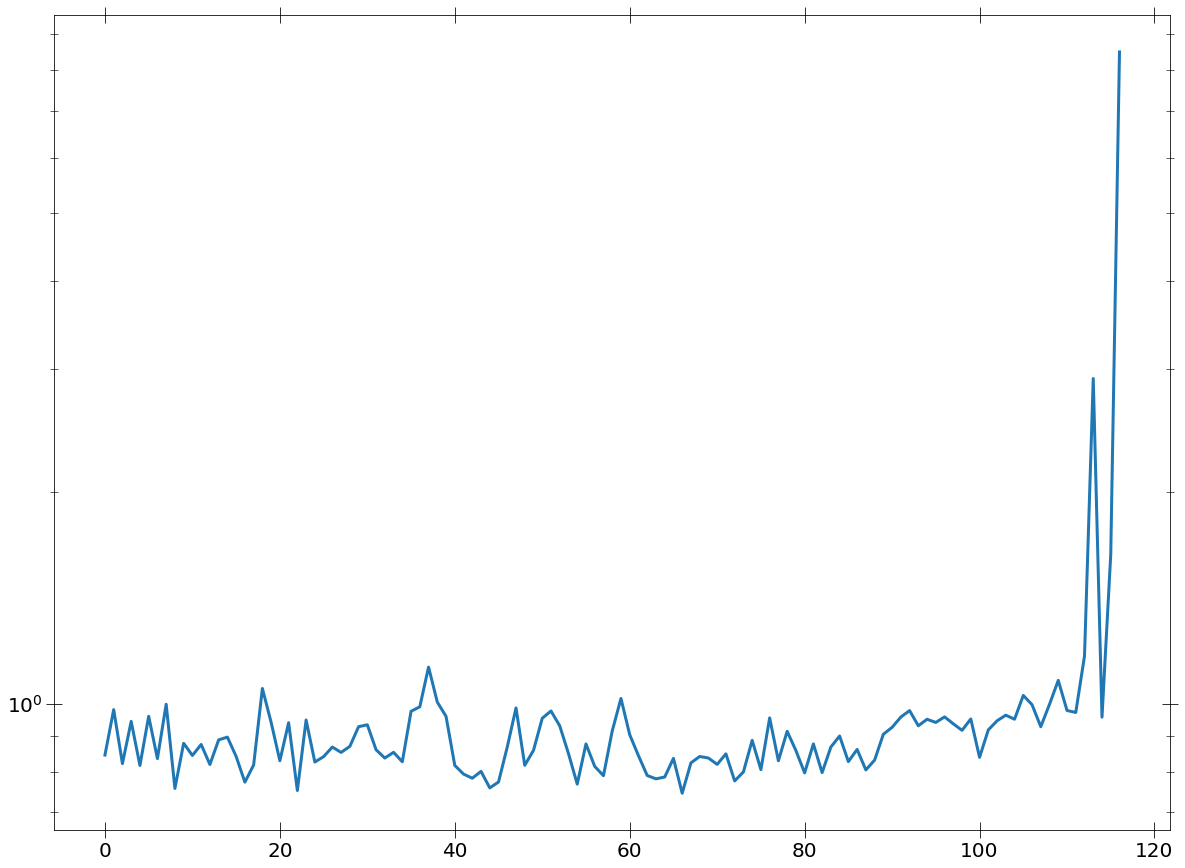

1:62: E225 missing whitespace around operator
2:80: E501 line too long (112 > 79 characters)


In [298]:
plt.plot((np.array(pn_fit_stats_table_pl)[:, 1].astype(float)/
          np.array(pn_fit_stats_table_pl)[:, -1].astype(float))[candia])
plt.yscale('log')

In [297]:
len(np.where(aic_pl_arr[0] < aic_pl_g3_arr[0] - 2)[0])


117

In [271]:
print(len(candidate_srcs_mos))
candidate_srcs_mos

66


array(['202026707015155', '204003401010008', '206556701010016',
       '206556701010040', '206946416010014', '208016803010003',
       '208860207010005', '202026707010160', '206043007010211',
       '206735502010030', '206735502010035', '206735502010047',
       '206735502010048', '206735502010049', '206735502010062',
       '206735502010080', '206735502010100', '206946409010023',
       '206946410010029', '208016804010004', '201129715010017',
       '204003401010007', '208016813010003', '201529201010011',
       '202026707010169', '202026707010179', '202026707010221',
       '202026707010240', '202026707010278', '204105804010009',
       '205049406010006', '206586001010095', '206586001010113',
       '206586001010146', '206735502010018', '206735502010024',
       '205100104010002', '206946401010003', '208860108010001',
       '202026707010062', '202026707010124', '202026707015191',
       '201129707010063', '202026707010170', '202026707010181',
       '207234104010049', '2010326130100

In [302]:
print(len(candidate_srcs_acis))
np.sort(candidate_srcs_acis)

157


array(['2CXOJ174405.3-292031', '2CXOJ174429.4-285531',
       '2CXOJ174431.9-290508', '2CXOJ174433.0-284426',
       '2CXOJ174442.9-292048', '2CXOJ174454.1-285841',
       '2CXOJ174457.4-285020', '2CXOJ174502.3-285449',
       '2CXOJ174503.8-290051', '2CXOJ174505.4-285934',
       '2CXOJ174507.0-290357', '2CXOJ174508.6-285652',
       '2CXOJ174508.6-285939', '2CXOJ174511.8-290032',
       '2CXOJ174512.3-285901', '2CXOJ174512.8-290340',
       '2CXOJ174513.9-285916', '2CXOJ174514.1-285425',
       '2CXOJ174515.0-285914', '2CXOJ174515.1-290016',
       '2CXOJ174515.7-290222', '2CXOJ174516.1-290425',
       '2CXOJ174516.7-290407', '2CXOJ174518.6-290010',
       '2CXOJ174520.2-291044', '2CXOJ174520.3-290634',
       '2CXOJ174520.5-290501', '2CXOJ174521.2-290652',
       '2CXOJ174521.3-285953', '2CXOJ174523.8-290653',
       '2CXOJ174524.3-285705', '2CXOJ174525.2-285404',
       '2CXOJ174526.8-285926', '2CXOJ174526.8-290702',
       '2CXOJ174527.5-290513', '2CXOJ174527.6-290423',
       '2C

In [287]:
def arr_to_str(arr, type='name'):
    string = ''
    for element in arr:
        if type == 'name':
            element = element.split('J')[0] + ' J' + element.split('J')[1]
        string += str(element) + '; '
    return string[:-2]

In [289]:
len(candidate_srcs_pn)

86

In [288]:
arr_to_str(candidate_srcs_pn, type=None)

'201129701010028; 201129707010018; 201129707010031; 203017301010002; 205100104010019; 205547201010008; 206946402010138; 206946404010167; 206946408010129; 206946410010025; 206946410010046; 206946410015051; 206946410015093; 206946416010055; 206946416010103; 206946416010105; 206946416010109; 207641901010010; 207641901010014; 207641917010007; 208016812010006; 208251401010013; 208441011010118; 208441011010128; 208441011010233; 208624701010019; 208860105010003; 208860207010005; 208861209010005; 200305401015015; 201113501010117; 201129704010031; 201129704010056; 204003401010008; 205100104010002; 205110012010036; 206946401010003; 206946404010202; 206946410010178; 206946416010014; 208016803010003; 208441011010009; 208441011010032; 208624701010022; 208860108010001; 208938111010034; 201129707010046; 201129707010057; 204003401010007; 205110012010017; 205110012010028; 205110012010053; 205110012010055; 208016813010003; 201032613010002; 201129721010057; 201129721010133; 206946402010009; 2074363090100

45 47
45


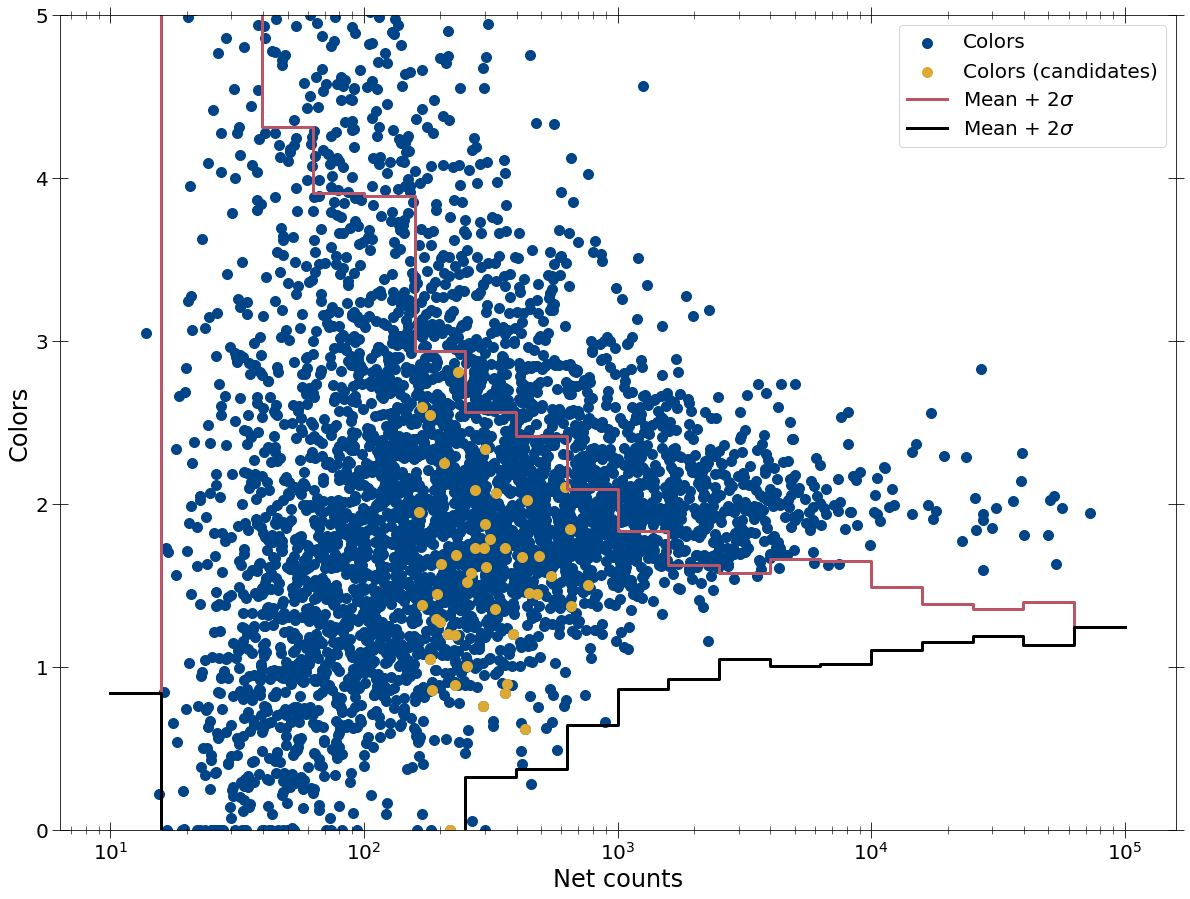

1:80: E501 line too long (86 > 79 characters)
2:22: E128 continuation line under-indented for visual indent
2:80: E501 line too long (83 > 79 characters)


In [103]:
netcounts_cand_pn = mark_interested_srcs(sim_color_dict_arr[0], obs_color_dict_arr[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn, 0)[1]

26 29
26


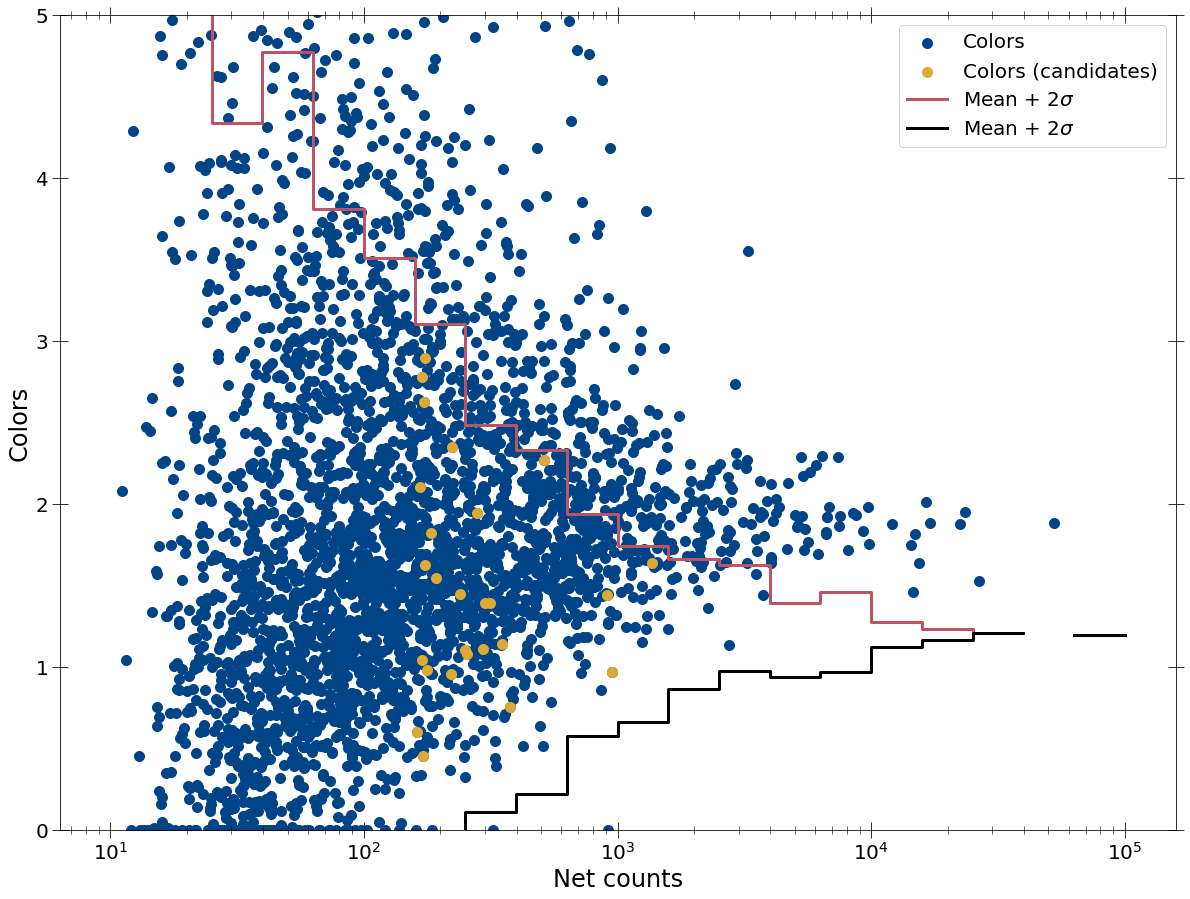

1:80: E501 line too long (87 > 79 characters)
2:22: E128 continuation line under-indented for visual indent
2:80: E501 line too long (83 > 79 characters)


In [104]:
netcounts_cand_mos = mark_interested_srcs(sim_color_dict_arr[1], obs_color_dict_arr[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_mos, 0)[1]

In [88]:
len(candidate_srcs_acis)

66

63 66
63


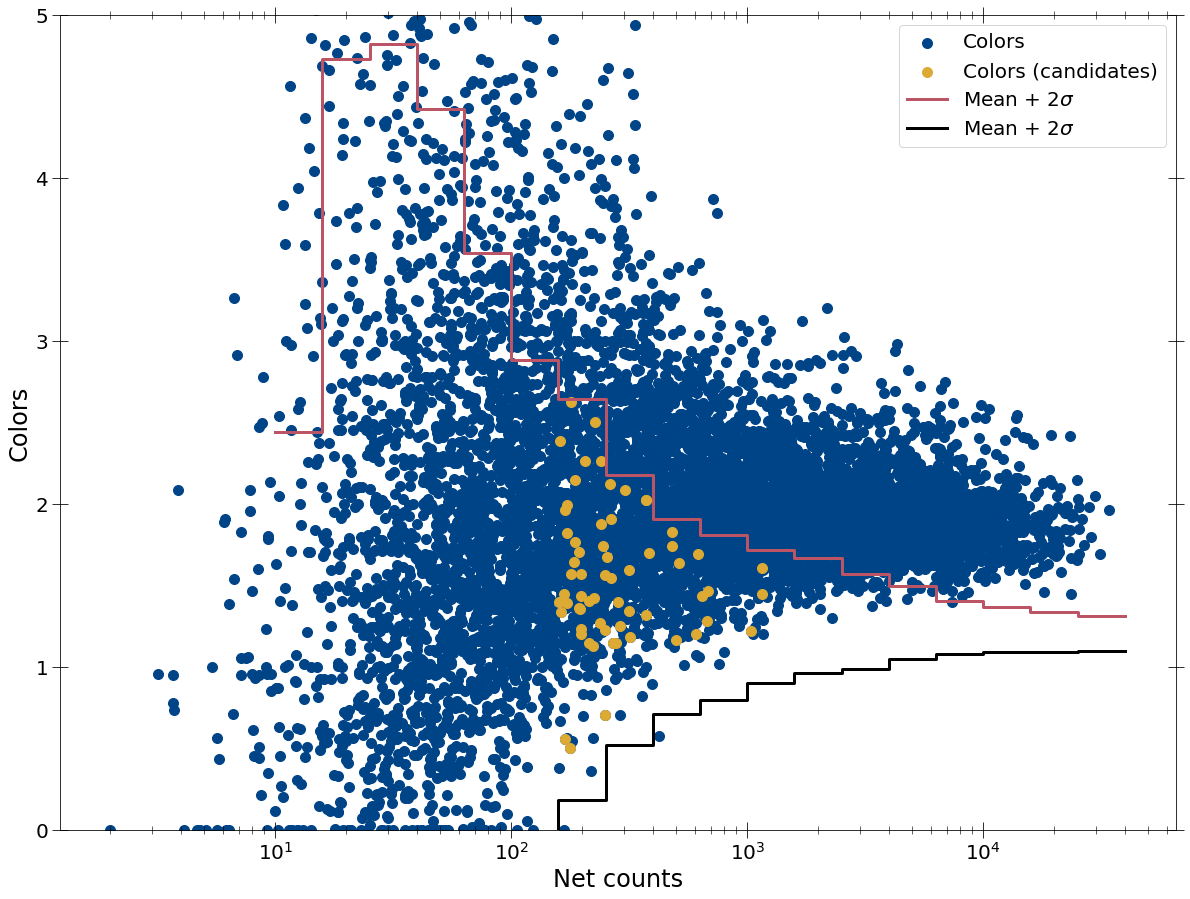

1:80: E501 line too long (88 > 79 characters)
2:22: E128 continuation line under-indented for visual indent
2:80: E501 line too long (83 > 79 characters)


In [105]:
netcounts_cand_acis = mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis, 0)[1]

In [111]:
sim_color_dict_arr[0]['prop_bins'][0]

array([1.00000000e+01, 1.58489319e+01, 2.51188643e+01, 3.98107171e+01,
       6.30957344e+01, 1.00000000e+02, 1.58489319e+02, 2.51188643e+02,
       3.98107171e+02, 6.30957344e+02, 1.00000000e+03, 1.58489319e+03,
       2.51188643e+03, 3.98107171e+03, 6.30957344e+03, 1.00000000e+04,
       1.58489319e+04, 2.51188643e+04, 3.98107171e+04, 6.30957344e+04,
       1.00000000e+05])

In [117]:
netcounts_int_pn_hist = np.histogram(netcounts_int_pn, bins=sim_color_dict_arr[0]['prop_bins'][0])[0]
netcounts_cand_pn_hist = np.histogram(netcounts_cand_pn, bins=sim_color_dict_arr[0]['prop_bins'][0])[0]
netcounts_int_mos_hist = np.histogram(netcounts_int_mos, bins=sim_color_dict_arr[1]['prop_bins'][0])[0]
netcounts_cand_mos_hist = np.histogram(netcounts_cand_mos, bins=sim_color_dict_arr[1]['prop_bins'][0])[0]
netcounts_int_acis_hist = np.histogram(netcounts_int_acis, bins=sim_color_dict_arr[2]['prop_bins'][0])[0]
netcounts_cand_acis_hist = np.histogram(netcounts_cand_acis, bins=sim_color_dict_arr[2]['prop_bins'][0])[0]

1:80: E501 line too long (101 > 79 characters)
2:80: E501 line too long (103 > 79 characters)
3:80: E501 line too long (103 > 79 characters)
4:80: E501 line too long (105 > 79 characters)
5:80: E501 line too long (105 > 79 characters)


In [116]:
netcounts_cand_acis_hist

(array([ 0,  0,  0,  0,  0,  0, 35, 16,  6,  3,  3,  0,  0,  0,  0,  0,  0,
         0,  0,  0]),
 array([1.00000000e+01, 1.58489319e+01, 2.51188643e+01, 3.98107171e+01,
        6.30957344e+01, 1.00000000e+02, 1.58489319e+02, 2.51188643e+02,
        3.98107171e+02, 6.30957344e+02, 1.00000000e+03, 1.58489319e+03,
        2.51188643e+03, 3.98107171e+03, 6.30957344e+03, 1.00000000e+04,
        1.58489319e+04, 2.51188643e+04, 3.98107171e+04, 6.30957344e+04,
        1.00000000e+05]))

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in true_divide
  
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in power
  # This is added back by InteractiveShellApp.init_path()
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in true_divide
  
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in power
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in multiply
/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: 

Text(0.5, 0, 'Net counts')

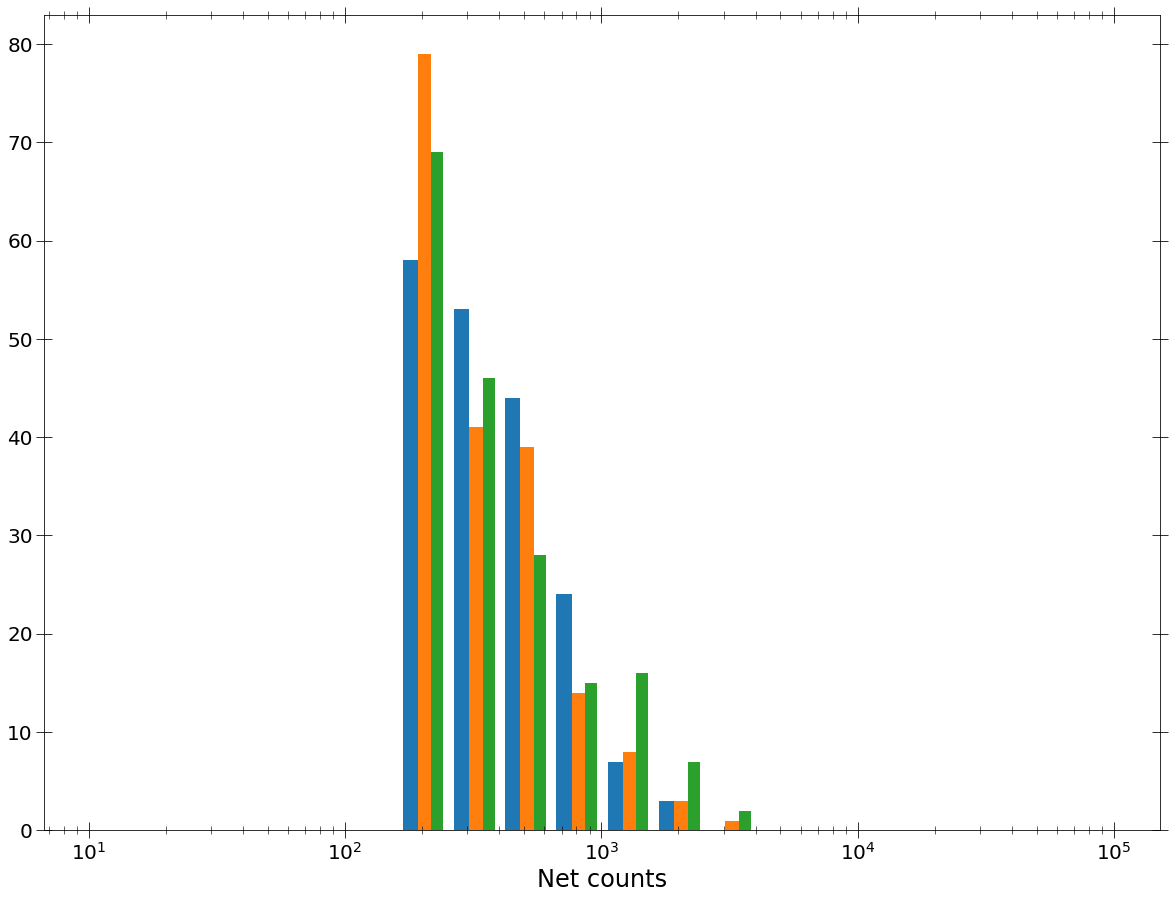

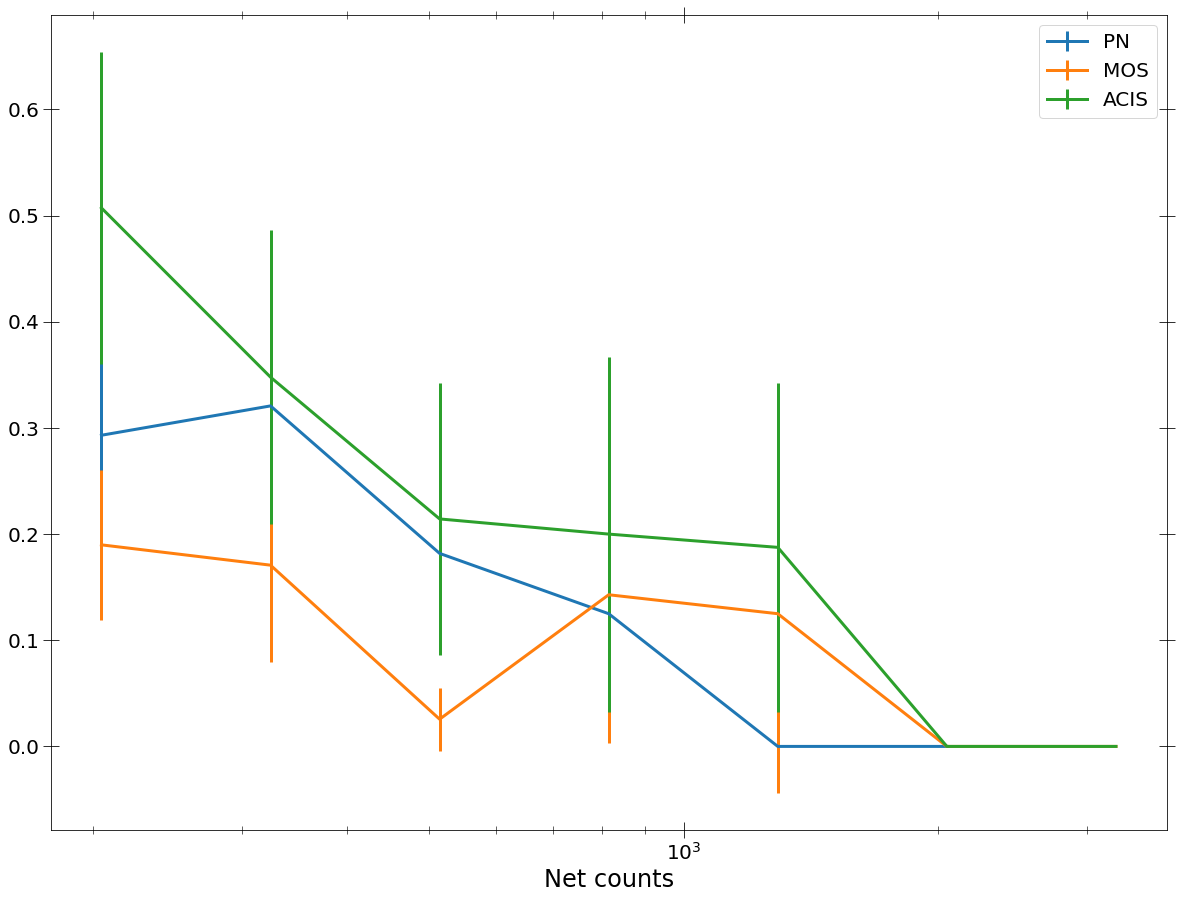

2:80: E501 line too long (111 > 79 characters)
9:18: E251 unexpected spaces around keyword / parameter equals
9:20: E251 unexpected spaces around keyword / parameter equals
13:18: E128 continuation line under-indented for visual indent
15:18: E251 unexpected spaces around keyword / parameter equals
15:20: E251 unexpected spaces around keyword / parameter equals
19:18: E128 continuation line under-indented for visual indent
21:18: E251 unexpected spaces around keyword / parameter equals
21:20: E251 unexpected spaces around keyword / parameter equals


In [121]:
plt.figure()
plt.hist([netcounts_int_pn, netcounts_int_mos, netcounts_int_acis], bins=sim_color_dict_arr[0]['prop_bins'][0])
plt.xscale('log')
plt.xlabel('Net counts')
plt.figure()
plt.errorbar(0.5*(sim_color_dict_arr[0]['prop_bins'][0][1:] +
                  sim_color_dict_arr[0]['prop_bins'][0][:-1]),
             netcounts_cand_pn_hist/netcounts_int_pn_hist, label='PN',
             yerr = (((netcounts_cand_pn_hist)**-0.5 +
                      (netcounts_int_pn_hist)**-0.5) *
                     netcounts_cand_pn_hist/netcounts_int_pn_hist))
plt.errorbar(0.5*(sim_color_dict_arr[1]['prop_bins'][0][1:] +
                 sim_color_dict_arr[1]['prop_bins'][0][:-1]),
             netcounts_cand_mos_hist/netcounts_int_mos_hist, label='MOS',
             yerr = (((netcounts_cand_mos_hist)**-0.5 +
                      (netcounts_int_mos_hist)**-0.5) *
                     netcounts_cand_mos_hist/netcounts_int_mos_hist))
plt.errorbar(0.5*(sim_color_dict_arr[2]['prop_bins'][0][1:] +
                 sim_color_dict_arr[2]['prop_bins'][0][:-1]),
             netcounts_cand_acis_hist/netcounts_int_acis_hist, label='ACIS',
             yerr = (((netcounts_cand_acis_hist)**-0.5 +
                      (netcounts_int_acis_hist)**-0.5) *
                     netcounts_cand_acis_hist/netcounts_int_acis_hist))
plt.legend()
plt.xscale('log')
plt.xlabel('Net counts')

(array([  5,   8,  13,  26,  32,  53,  60,  65,  91,  94, 101, 104, 106,
       155, 157, 164, 168, 178, 183, 195, 212, 236, 242, 243, 274, 275,
       278, 279, 280, 281, 282, 283, 288, 322, 344, 356, 366, 367, 387,
       392, 394, 402, 404, 405, 418, 421, 423, 424, 425, 479, 481, 487,
       490, 503, 504, 522, 535, 536, 537, 538, 539, 541, 542, 543, 544,
       545, 548, 550, 551, 557, 568, 586, 604, 628, 630, 632, 635, 636,
       648, 660, 661, 692, 698, 722, 735, 740]),)
['200305401015015' '201032613010002' '201113501010117' '201129701010028'
 '201129702010002' '201129704010031' '201129704010056' '201129705010011'
 '201129707010018' '201129707010031' '201129707010046' '201129707010057'
 '201129707010063' '201129721010057' '201129721010060' '201129721010133'
 '201442201010001' '201529201010060' '202026705010003' '202026707010271'
 '203017301010002' '203032102010002' '204003401010007' '204003401010008'
 '205100104010002' '205100104010019' '205110012010001' '205110012010017'
 '2051

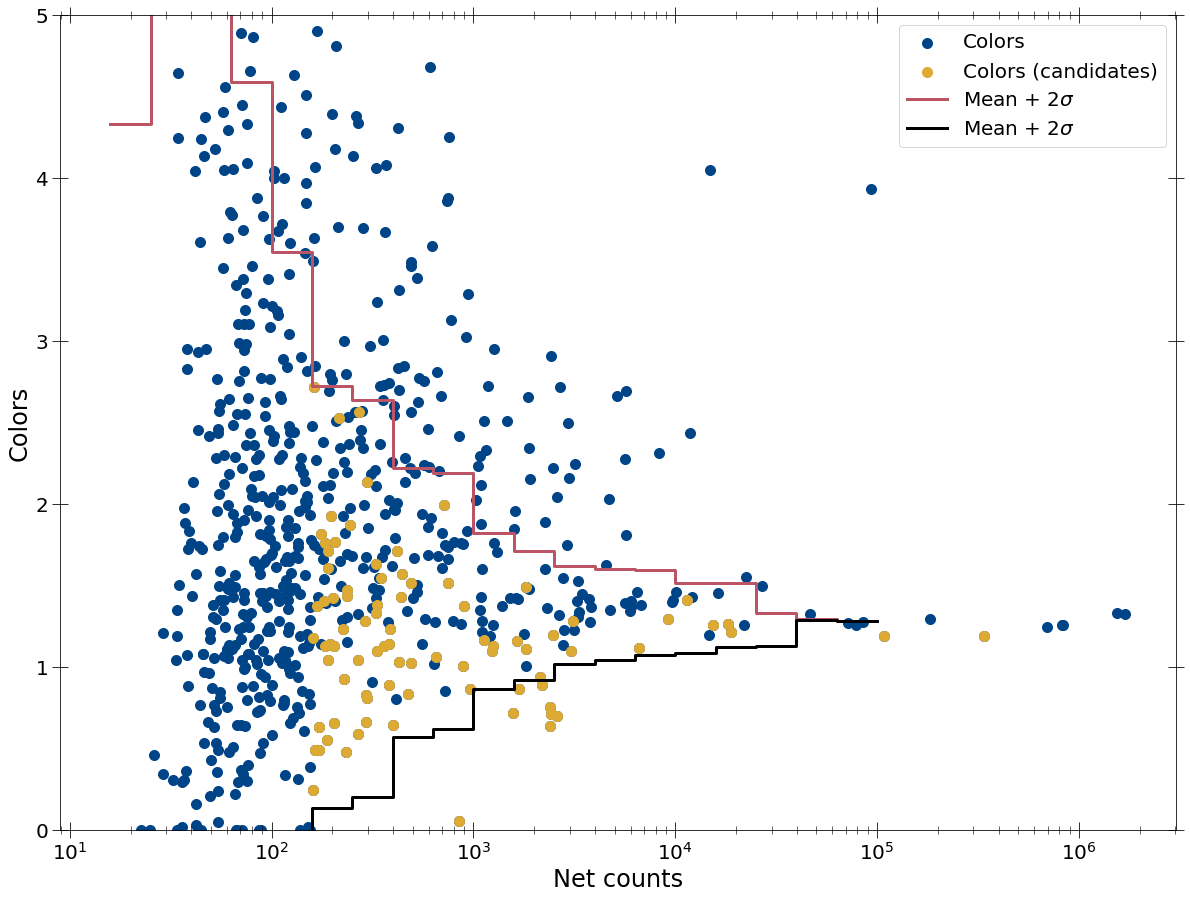

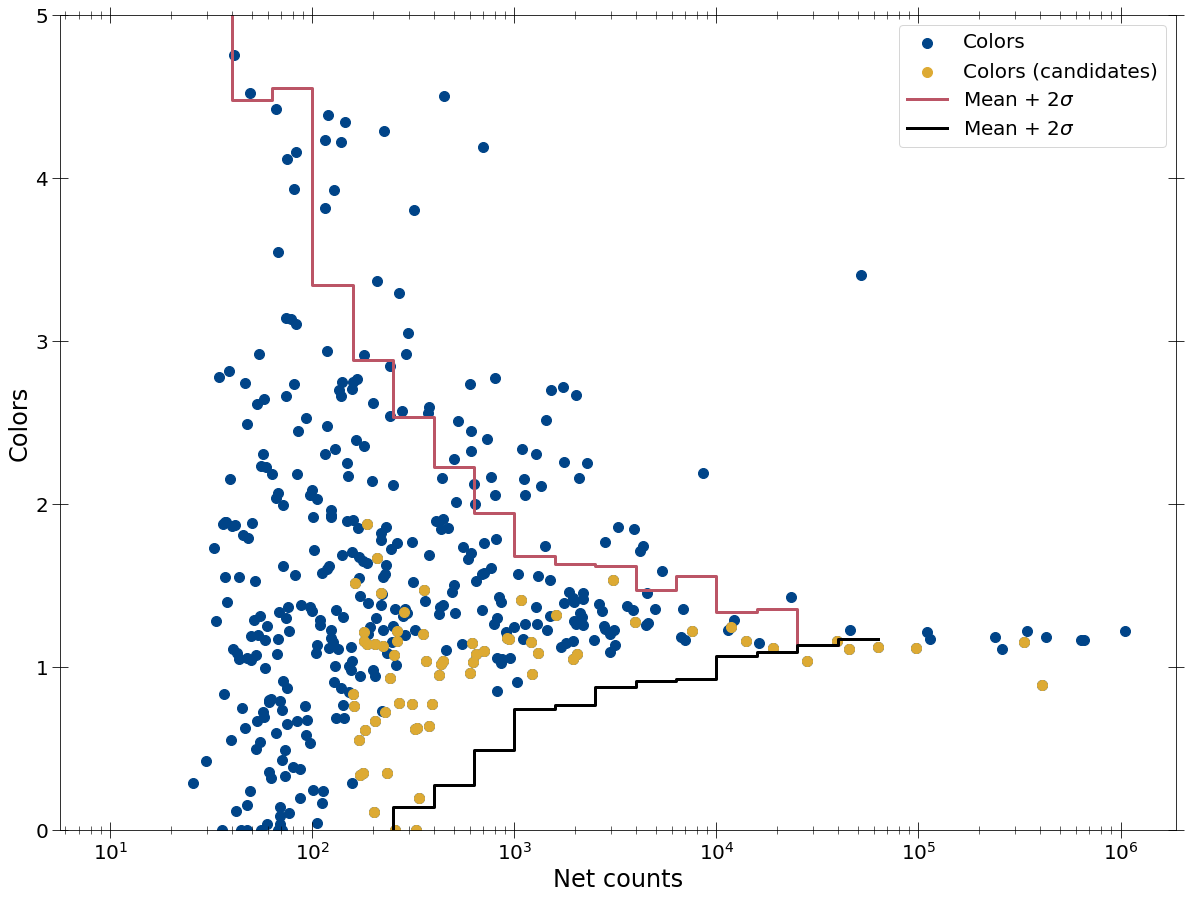

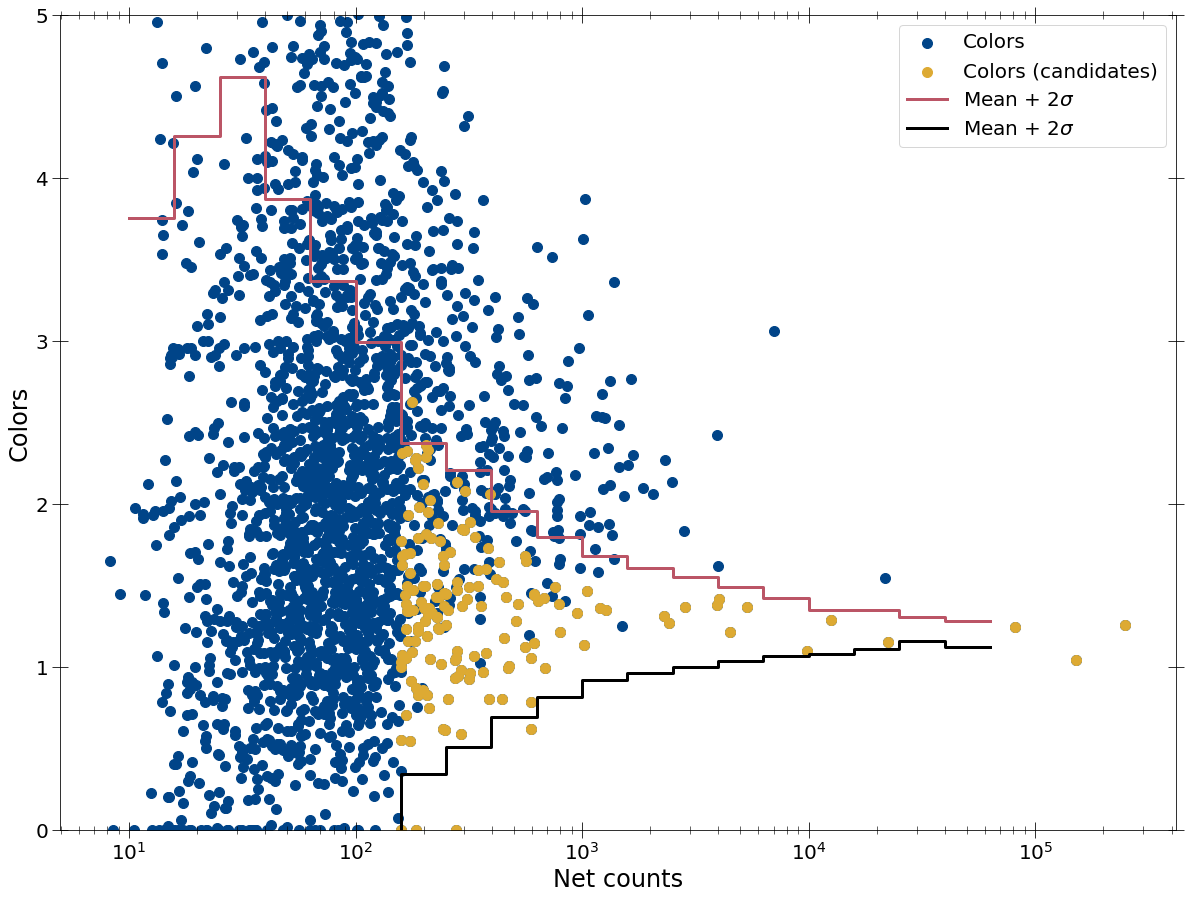

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (83 > 79 characters)
4:80: E501 line too long (82 > 79 characters)
5:80: E501 line too long (83 > 79 characters)
7:80: E501 line too long (82 > 79 characters)
8:80: E501 line too long (83 > 79 characters)


In [276]:
mark_interested_srcs(sim_color_dict_arr_clipped[0], obs_color_dict_arr_clipped[0],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][0],
                     candidate_srcs_pn, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[1], obs_color_dict_arr_clipped[1],
                     spec_summary['src_nums'][0], spec_summary['spec_masks'][1][1],
                     candidate_srcs_mos, 0)
mark_interested_srcs(sim_color_dict_arr_clipped[2], obs_color_dict_arr_clipped[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     candidate_srcs_acis, 0)

In [169]:
np.where(interested_srcs_alldet[2] == '2CXOJ174534.3-290231')

(array([], dtype=int64),)

In [285]:
print(acis_fit_stats_table_pl[125])
print(acis_fit_stats_table_pl_g[125])
print(acis_fit_stats_table_pl_g2[125])
print()
print(acis_fit_stats_table_pl[208])
print(acis_fit_stats_table_pl_g[208])
print(acis_fit_stats_table_pl_g2[208])
print()
print(acis_fit_stats_table_pl[133])
print(acis_fit_stats_table_pl_g[133])
print(acis_fit_stats_table_pl_g2[133])
print()
print(acis_fit_stats_table_pl[46])
print(acis_fit_stats_table_pl_g[46])
print(acis_fit_stats_table_pl_g2[46])
print()
print(acis_fit_stats_table_pl[88])
print(acis_fit_stats_table_pl_g[88])
print(acis_fit_stats_table_pl_g2[88])
print()
print(acis_fit_stats_table_pl[188])
print(acis_fit_stats_table_pl_g[188])
print(acis_fit_stats_table_pl_g2[188])

['2CXOJ174540.3-290049', 266.01879656001785, -7.589646752720701, 50.0, 299]
['2CXOJ174540.3-290049', 264.6833556689429, -7.805990677928118, 50.0, 297]
['2CXOJ174540.3-290049', 263.92879916841827, -7.8578460350119865, 50.0, 296]

['2CXOJ174536.9-290039', 344.5620739732016, -9.526574126034008, 50.0, 389]
['2CXOJ174536.9-290039', 341.77998992125424, -9.871299609625027, 50.0, 387]
['2CXOJ174536.9-290039', 340.80402348470886, -9.916018231068454, 50.0, 386]

['2CXOJ174535.7-290004', 219.3432290242929, -8.32886982476195, 50.0, 254]
['2CXOJ174535.7-290004', 216.10212421697082, -8.175803506918273, 50.0, 252]
['2CXOJ174535.7-290004', 216.40324068904283, -8.163633107538715, 50.0, 251]

['2CXOJ174543.2-290003', 168.34505326473322, -7.38207827477904, 50.0, 262]
['2CXOJ174543.2-290003', 166.74607251218066, -7.295869408022453, 50.0, 260]
['2CXOJ174543.2-290003', 167.088320724579, -7.364177348527165, 50.0, 259]

['2CXOJ174535.0-285757', 140.70723931932093, -7.684272731913274, 50.0, 193]
['2CXOJ174535.

In [157]:
print(acis_model_params_table_pl_g2[125])
print(acis_model_params_table_pl_g2[208])
print(acis_model_params_table_pl_g2[133])
print(acis_model_params_table_pl_g2[46])
print(acis_model_params_table_pl_g2[88])
print(acis_model_params_table_pl_g2[188])

['2CXOJ174540.3-290049', 14.747172266857492, 2.284559245444103, 0.014014393023623173, 3.157876082859608e-08, 1.936457506907927e-08, 4.298694332175304e-19, 0.0, 8.242343569531286e-08, 0.0, 7.391659902986237e-08, 0.0, 3.2311902308687976e-08]
['2CXOJ174536.9-290039', 32.91698126831548, 2.169538475539656, 0.13824128530453256, 5.4557158152566107e-14, 1.4314730567579634e-07, 7.4035496908206e-08, 0.0, 1.1265319696324751e-07, 0.0, 3.059586290967107e-07, 0.0, 2.3806088884467742e-07]
['2CXOJ174535.7-290004', 25.294693190701558, 1.6423470508550815, 0.040934446317875135, 8.531655806100725e-08, 3.5908650704885276e-08, 1.1327547386683504e-08, 0.0, 1.9846436077281447e-07, 0.0, 1.5934190141787257e-07, 0.0, 1.3669784512889456e-07]
['2CXOJ174543.2-290003', 57.451790453056155, 4.999999999999999, 0.3025621014701397, 6.405396701097331e-22, 1.716821005151346e-19, 1.2932393486615652e-07, 0.0, 1.4473062790960989e-07, 0.0, 2.977575924227808e-07, 0.0, 3.5802429139269943e-07]
['2CXOJ174535.0-285757', 16.72445583

(array([ 200,  692,  806,  990, 1051, 1199, 1665, 1685, 1702]),)
['2CXOJ174534.3-290231' '2CXOJ174546.2-290003' '2CXOJ174538.1-290319'
 '2CXOJ174535.7-290004' '2CXOJ174543.2-290003' '2CXOJ174532.9-290110'
 '2CXOJ174535.0-285757' '2CXOJ174527.8-290210' '2CXOJ174544.1-285940']
[176.43000154  68.51315789 148.93362531 333.82959801 176.07171884
  69.72756558 160.74684514 452.65052956  15.82249253]
[2.8743079         inf 0.88800633 1.79911604 0.7109796  2.33402784
 1.63259623 1.30960658        inf]


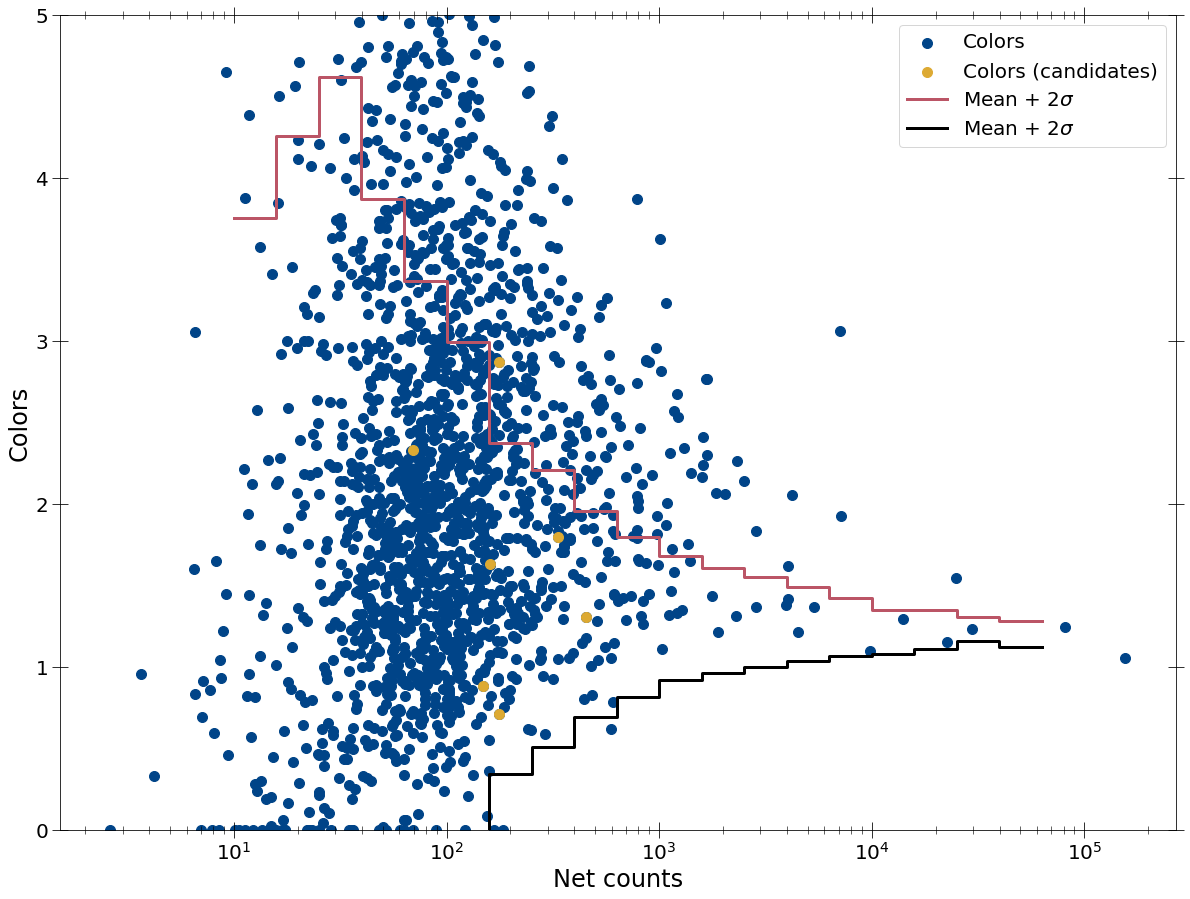

2:80: E501 line too long (83 > 79 characters)


In [168]:
mark_interested_srcs(sim_color_dict_arr[2], obs_color_dict_arr[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     ['2CXOJ174543.2-290003', '2CXOJ174535.7-290004',
                      '2CXOJ174544.1-285940', '2CXOJ174546.2-290003',
                      '2CXOJ174532.9-290110', '2CXOJ174534.3-290231',
                      '2CXOJ174535.0-285757', '2CXOJ174538.1-290319', '2CXOJ174527.8-290210'], 0)

(array([ 678,  840,  990, 1335]),)
['2CXOJ174540.3-290049' '2CXOJ174536.9-290039' '2CXOJ174535.7-290004'
 '2CXOJ174536.1-285638']
[ 309.98665049 1113.49755019  333.82959801 7063.35067975]
[1.41798004 1.31906731 1.79911604 3.06266218]


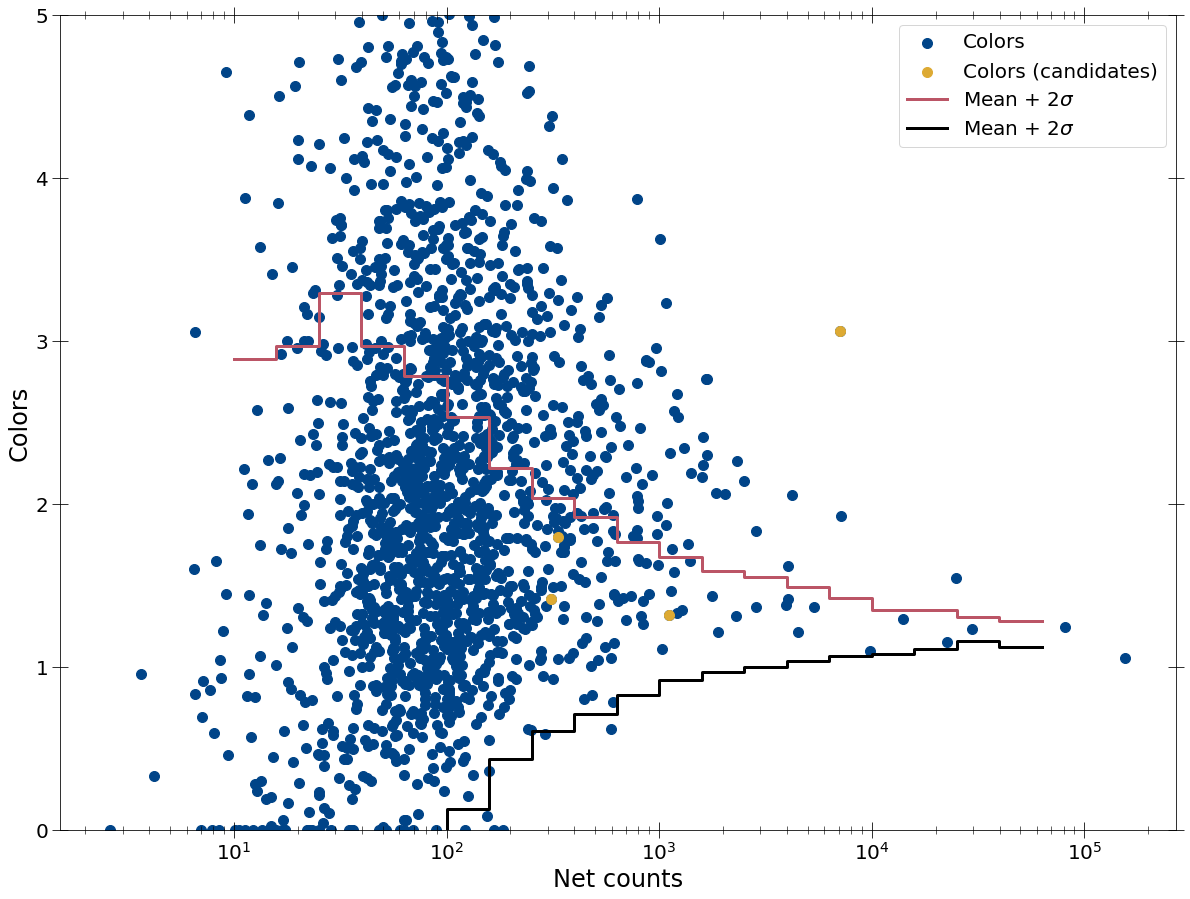

1:80: E501 line too long (82 > 79 characters)
2:80: E501 line too long (83 > 79 characters)


In [167]:
mark_interested_srcs(sim_color_dict_arr_clipped[2], obs_color_dict_arr_clipped[2],
                     spec_summary['src_nums'][1], spec_summary['spec_masks'][1][2],
                     ['2CXOJ174540.3-290049', '2CXOJ174536.9-290039',
                      '2CXOJ174535.7-290004', '2CXOJ174536.1-285638',
                      '2CXOJ174532.7-285616', '2CXOJ174610.5-285550'], 0)

In [289]:
np.savetxt('ACIS_interested_plmodels.txt', acis_model_params_table_pl, fmt='%s')
np.savetxt('ACIS_interested_g2models.txt', acis_model_params_table_pl_g2, fmt='%s')

1:80: E501 line too long (80 > 79 characters)


# Checking for low norm sources

In [277]:
acis_model_g2_arr = np.array(acis_model_params_table_pl_g2)
zero_norms_args = np.where(np.logical_and(np.logical_and(
    np.logical_or(
        acis_model_g2_arr[:, 7].astype(float) == 0,
        acis_model_g2_arr[:, 7].astype(float) >= acis_model_g2_arr[:, 4].astype(float)),
    np.logical_or(
        acis_model_g2_arr[:, 9].astype(float) == 0,
        acis_model_g2_arr[:, 9].astype(float) >= acis_model_g2_arr[:, 5].astype(float))),
    np.logical_or(
        acis_model_g2_arr[:, 11].astype(float) == 0,
        acis_model_g2_arr[:, 11].astype(float) >= acis_model_g2_arr[:, 6].astype(float))))[0]

5:80: E501 line too long (88 > 79 characters)
8:80: E501 line too long (89 > 79 characters)


In [278]:
high_norms_args = np.where(np.logical_or(np.logical_or(
    acis_model_g2_arr[:, 7].astype(float) >= acis_model_g2_arr[:, 4].astype(float),
    acis_model_g2_arr[:, 9].astype(float) >= acis_model_g2_arr[:, 5].astype(float)),
    acis_model_g2_arr[:, 11].astype(float) >= acis_model_g2_arr[:, 6].astype(float)))[0]

2:80: E501 line too long (83 > 79 characters)
3:80: E501 line too long (84 > 79 characters)


In [279]:
len(high_norms_args)

29

In [247]:
zero_norm_args = np.append(zero_norms_args.copy(), high_norms_args)

In [280]:
len(zero_norms_args)

144

In [281]:
np.min((aic_pl_g3_arr[2] - aic_pl_arr[2])[zero_norms_args])

0.8924075464469752

In [258]:
print(acis_fit_stats_table_pl[117])
print(acis_fit_stats_table_pl_g2[117])

['2CXOJ174601.1-285952', 273.95609098450296, -7.238976643444733, 50.0, 270]
['2CXOJ174601.1-285952', 250.28253432384366, -8.420395729866275, 50.0, 267]


In [259]:
print(acis_model_params_table_pl[117])
print(acis_model_params_table_pl_g2[117])

['2CXOJ174601.1-285952', 15.645019663669181, 0.551782037874522, 0.03696465499752591]
['2CXOJ174601.1-285952', 19.737789482731742, 1.5997676215429104, 0.0331508926935257, 1.6215554900609572e-07, 2.6901888734595366e-07, 2.995211254045239e-08, 5.937151313098362e-08, 2.905464964537258e-07, 1.33223904033065e-07, 4.348939115214157e-07, 0.0, 1.7693666605934802e-07]


In [282]:
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2])[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 1.39)[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 3.0)[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 4.0)[0]))
print(len(np.where(aic_pl_arr[2] < aic_pl_g3_arr[2] - 4.605)[0]))

199
164
132
102
85


In [286]:
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args])[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 1.0)[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 3.0)[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 4.0)[0]))
print(len(np.where(aic_pl_arr[2][zero_norms_args] < aic_pl_g3_arr[2][zero_norms_args] - 4.605)[0]))

1:80: E501 line too long (91 > 79 characters)
2:80: E501 line too long (97 > 79 characters)
3:80: E501 line too long (97 > 79 characters)
4:80: E501 line too long (97 > 79 characters)


144
143
127
102
85


In [281]:
zero_norms_args

array([  0,   1,   3,   4,  10,  12,  13,  16,  17,  18,  19,  20,  24,
        27,  31,  32,  33,  34,  37,  38,  39,  43,  45,  46,  47,  48,
        51,  53,  54,  56,  59,  61,  62,  65,  67,  68,  70,  73,  74,
        76,  77,  80,  82,  83,  84,  85,  87,  88,  89,  90,  91,  93,
        94,  95,  97,  99, 100, 103, 104, 106, 107, 109, 115, 119, 121,
       123, 124, 125, 128, 129, 130, 132, 133, 134, 136, 139, 141, 143,
       144, 146, 148, 149, 150, 156, 158, 160, 162, 164, 166, 167, 168,
       171, 173, 175, 177, 178, 180, 181, 182, 183, 184, 185, 188, 189,
       190, 191, 193, 195, 197, 198, 199, 200, 203, 208, 209, 210, 212,
       213, 214, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,
       227])

In [284]:
acis_model_g2_arr[219]

array(['2CXOJ174535.5-290124', '30.35200191082754', '1.4425701490713667',
       '0.47630799807558655', '1.89602805783651e-08',
       '2.8201094011909062e-24', '7.408528059108422e-24', '0.0',
       '2.3455091875304955e-07', '0.8224962005991274', '0.0',
       '0.8224962005991274', '0.0'], dtype='<U32')

In [282]:
np.where(np.logical_and(aic_pl_arr[2] < aic_pl_g3_arr[2] - 3.0,
                        acis_model_g2_arr[:, 11].astype(float) != 0))[0]

array([  3,   4,  17,  19,  27,  97, 109, 113, 132, 162, 178, 190, 191,
       219, 223, 224, 225, 226, 227])

/Users/pavanrh/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


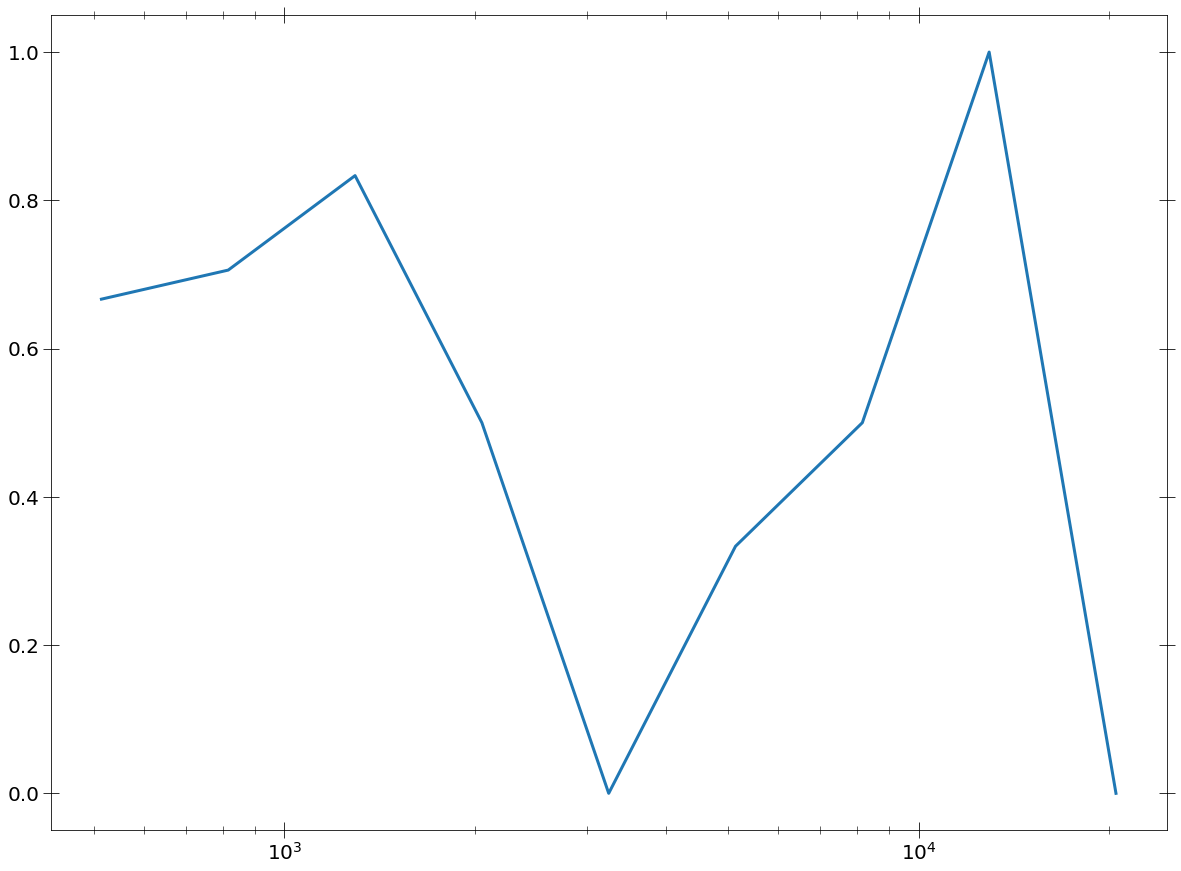

In [451]:
plt.plot(0.5*(bins[1:] + bins[:-1]), candidate_hist/interested_hist)
plt.xscale('log')

In [441]:
len(sim_color_dict_arr[0]['prop_bins'][0])

21

In [452]:
candidate_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 12, 12,  5,  1,  0,  1,  1,  3,  0,
        0,  0,  0])

In [453]:
interested_hist

array([ 0,  0,  0,  0,  0,  0,  0,  0, 18, 17,  6,  2,  1,  3,  2,  3,  2,
        0,  0,  0])

In [449]:
bins

array([1.00000000e+01, 1.58489319e+01, 2.51188643e+01, 3.98107171e+01,
       6.30957344e+01, 1.00000000e+02, 1.58489319e+02, 2.51188643e+02,
       3.98107171e+02, 6.30957344e+02, 1.00000000e+03, 1.58489319e+03,
       2.51188643e+03, 3.98107171e+03, 6.30957344e+03, 1.00000000e+04,
       1.58489319e+04, 2.51188643e+04, 3.98107171e+04, 6.30957344e+04,
       1.00000000e+05])

In [454]:
fit_stats_pl_arr = np.array(mos_fit_stats_table_pl)
fit_stats_pl_gauss_arr = np.array(mos_fit_stats_table_pl_g)

aic_pl = fit_stats_pl_arr[:, 1].astype(float) + 6
aic_pl_gauss = fit_stats_pl_gauss_arr[:, 1].astype(float) + 10

candidate_args = interested_args_alldet[1][np.where(aic_pl > aic_pl_gauss)]
candidate_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][candidate_args]
interested_netcounts = spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][4]][interested_args_alldet[1]]

candidate_hist, bins = np.histogram(candidate_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])
interested_hist, bins = np.histogram(interested_netcounts, bins=sim_color_dict_arr[1]['prop_bins'][0])

IndexError: index 38 is out of bounds for axis 0 with size 38

8:80: E501 line too long (103 > 79 characters)
9:80: E501 line too long (115 > 79 characters)
11:80: E501 line too long (100 > 79 characters)


In [455]:
len(fit_stats_pl_arr)

57

In [456]:
len(mos_fit_stats_table_pl)

57

In [459]:
np.sort(interested_srcs_alldet[0])

array(['201113501010010', '201113501010035', '201113501010066',
       '201113501010154', '201113501010169', '201113503010004',
       '201129701010011', '201129701010015', '201129701010027',
       '201129701010041', '201129702010002', '201129704010011',
       '201129704010019', '201129704010027', '201129705010011',
       '201129705010015', '201129705010038', '201129705010067',
       '201129705010076', '201129705010079', '201129705015062',
       '201129706010014', '201129707010012', '201129707010063',
       '201129707010079', '201129709010024', '201129715010041',
       '201129719010010', '201129721010003', '201129721010009',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010035', '201129721010044', '201129721010057',
       '201129721010060', '201129721010063', '201129721010070',
       '201129721010078', '201129721010126', '201129721010133',
       '201129721015131', '202026705010034', '202026705010109',
       '202026708010021', '2030321020100

In [460]:
np.sort(interested_srcs_alldet[1])

array(['200305402010002', '201113501010010', '201113501010069',
       '201113501010114', '201113503010004', '201129701010035',
       '201129702010002', '201129704010048', '201129705010011',
       '201129705010014', '201129705010024', '201129705010067',
       '201129705010079', '201129705010095', '201129705015062',
       '201129706010014', '201129707010063', '201129708010036',
       '201129719010010', '201129721010003', '201129721010005',
       '201129721010014', '201129721010022', '201129721010034',
       '201129721010045', '201129721010053', '201129721010057',
       '201129721010060', '201129721010075', '201129721010138',
       '202026705010053', '204105804015018', '206556701010012',
       '206556701010019', '206946404010008', '207641904010001',
       '208016803010001', '208251401010006'], dtype=object)

In [69]:
def get_candidate_src_nums_det2(obs_src_nums, obs_det_mask, sim_color_dict,
                               obs_color_dict, min_counts):
    """Get src nums of quiescent sources for given detector"""
    obs_netcounts = obs_color_dict['prop_list'][0]
    netcount_bins = sim_color_dict['prop_bins'][0]
    obs_colors = obs_color_dict['colors']
    color_median = sim_color_dict['color_stat'][0][0]
    color_std = sim_color_dict['color_stat'][2][0]
    interested_args = []
    interested_srcs = []
    for i, lower_bin in enumerate(netcount_bins):
        if lower_bin < min_counts:
            continue
        if i == len(netcount_bins) - 1:
            upper_bin = np.max(obs_netcounts) + 10
            median_color = color_median[-1]
            std_color = color_std[-1]
        else:
            upper_bin = netcount_bins[i+1]
            median_color = color_median[i]
            std_color = color_std[i]
        if np.isnan(median_color) or np.isnan(std_color):
                    int_args = np.where(np.logical_and(
                        obs_netcounts >= lower_bin,
                        obs_netcounts < upper_bin))
        else:
        
            int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        int_args = np.where(np.logical_and(
                np.logical_and(obs_netcounts >= lower_bin,
                               obs_netcounts < upper_bin),
                obs_colors < median_color + 2*std_color))[0]
        '''
        print(obs_netcounts[int_args])
        interested_args.append(int_args)
        interested_srcs.append(obs_src_nums[obs_det_mask][int_args])
    return interested_args, interested_srcs


def get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr,
                                  obs_color_dict_arr, min_count_arr=None):
    """Get source nums for all detectors."""
    interested_args_alldet = []
    interested_sources_alldet = []
    if min_count_arr is None:
        min_count_arr = [700, 700, 250]
    for i, obs_color_dict in enumerate(obs_color_dict_arr):
        if i > 0:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
                spec_summary['src_nums'][i-1], spec_summary['spec_masks'][1][i],
                sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        else:
            interested_args, interested_srcs = get_candidate_src_nums_det2(
            spec_summary['src_nums'][i], spec_summary['spec_masks'][1][i],
            sim_color_dict_arr[i], obs_color_dict, min_count_arr[i])
        interested_args_alldet.append(interested_args)
        interested_sources_alldet.append(interested_srcs)
    return interested_args_alldet, interested_sources_alldet


2:32: E128 continuation line under-indented for visual indent
23:21: E117 over-indented
27:1: W293 blank line contains whitespace
45:35: E128 continuation line under-indented for visual indent
54:80: E501 line too long (80 > 79 characters)
58:13: E122 continuation line missing indentation or outdented
59:13: E122 continuation line missing indentation or outdented


In [70]:
test_args, test_srcs = get_candidate_src_nums_alldet2(spec_summary, sim_color_dict_arr, obs_color_dict_arr,
                                                      min_count_arr=[380, 380, 220])

[569.59489915 404.91355624 452.26180445 465.79990524 576.32276827
 493.39928098 487.52737681 463.48454887 513.71340716 539.95700063
 612.30372428 609.93432573 398.9688382  574.42562696 508.04667046
 592.28189506 435.03011623 522.26141993]
[652.69197128 823.33408827 792.69706455 674.18975953 876.79367389
 679.04689138 739.16724045 845.56868658 723.70611642 845.86782834
 764.06300906 648.50489117 711.53733848 864.90478044 817.363117
 923.15858478 648.64365916 797.95791783]
[1536.6024365  1114.66782348 1422.7130562  1291.96679205 1584.24987616
 1222.55308145]
[1989.78879578 2448.29069852]
[3333.91840967]
[5906.66947885 4300.15059039 5076.11064059]
[8272.89976422 7040.72877535]
[10372.3500844  14301.84303534 13285.45941   ]
[23304.51640767 18219.60240603]
[]
[]
[]
[ 736611.79761745  418037.54709113 2024254.48411136]
[608.05064636 440.51106749 493.03633815 438.03845112 598.07676261
 443.31577824 586.65762292 507.54544255 433.71040735 542.88105163
 402.12852783]
[743.55291637 648.44849731 71

1:80: E501 line too long (107 > 79 characters)


In [44]:
test_srcs

[[array(['201113501010066', '201113501010154', '201129701010015',
         '201129704010011', '201129704010019', '201129704010027',
         '201129707010012', '201129707010063', '201129709010024',
         '201129715010041', '201129721010070', '201129721010126',
         '204003401010007', '204105804010005', '206556701010012',
         '208016803010001', '208016813010003', '208251401010006'],
        dtype=object),
  array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  array(['201113501010035', '201129707010079', '201129721010063',
         '201129721010078', '201129721015131', '202026705010034'],
        dtype=object),
  ar

In [93]:
def combine_spec_analysis(int_srcs_list, source_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    spec_list = []
    for source_num in int_srcs_list:
        if telescope == 'XMM':
            spec_pnfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                     str(source_num) + '_PN_combined_src_grp1*')
            spec_mosfile = glob2.glob('./Galactic_highNH_combinedXMM/' +
                                      str(source_num) + '_MOS_combined_src_grp1*')
            if len(spec_pnfile) > 0:
                spec_pn = xspec.Spectrum(spec_pnfile[0])
                spec_pn.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_pn)
                print(spec_pn.rate[0]*spec_pn.exposure)
            if len(spec_mosfile) > 0:
                spec_mos = xspec.Spectrum(spec_mosfile[0])
                spec_mos.ignore('0.0-2.0, 10.0-**')
                spec_pn.notice('2.0-10.0')
                spec_list.append(spec_mos)
                print(spec_mos.rate[0]*spec_mos.exposure)
        elif telescope == 'Chandra':
            os.chdir(src_folder + '/' + source_num)
            spec_file = str(source_num) + '_combined_src_grp1.pi'
            spec = xspec.Spectrum(spec_file)
            spec.ignore('0.0-2.0, 10.0-**')
            spec.notice('2.0-10.0')
            os.chdir(curr_dir)
        else:
            print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*pegpwrlw')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.perform()
    xspec.Fit.error('2.706 2')
    xspec.Fit.perform()
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    
    xspec.Plot.device = '/xw'
    xspec.Plot.xAxis = 'keV'
    xspec.Plot.yLog = True
    xspec.Plot.setRebin(2, 1000, -1)
    xspec.Plot()
    print('Model params: '
          'NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0])
    print('Fit stats : ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    if telescope == 'Chandra':
        os.chdir(curr_dir)
    return ([int_srcs_list, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [int_srcs_list, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0]])

10:80: E501 line too long (80 > 79 characters)
12:80: E501 line too long (82 > 79 characters)
34:1: W293 blank line contains whitespace
44:5: E265 block comment should start with '# '
46:1: W293 blank line contains whitespace
61:80: E501 line too long (83 > 79 characters)


In [95]:
combine_spec_analysis(test_srcs[0][1])

654.4603630490105
824.1378576545412
716.8100536050601
795.4471140394922
220.3010253394772
673.1919534877306
806.0406733582817
877.330611434544
949.5044931691929
681.247948793877
162.2880763393362
736.751589007554
349.2025802477865
841.2293566233209
680.7494567901176
725.3070590144457
844.6655306385417
845.6103149179244
2153.566380181197
764.2810261818187
642.8417595934877
1078.7955794357108
711.3929357221539
864.5409737688612
113.31528293446061
815.8800274223036
923.4042521844088
74.37753238277094
649.1042695369483
797.4801613279265
586.9997543090454
Model params: NH =  13.231711938962313  Gamma:  0.9200176939172249  norm:  0.1632279364041732
Fit stats :  32184.51283053665 -6.530554835870103 50.0 29932




([array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  32184.51283053665,
  -6.530554835870103,
  50.0,
  29932],
 [array(['201113501010169', '201129701010011', '201129701010027',
         '201129701010041', '201129704010048', '201129705010015',
         '201129705010038', '201129705010067', '201129705015062',
         '201129721010022', '201129721010035', '201129721010057',
         '201129721010133', '202026705010109', '202026708010021',
         '205547504010092', '206946402010009', '207641904010001'],
        dtype=object),
  13.231711938962313,
  0.9200176939172249,
  0.1632279364041732])

In [88]:
spec_summary['counts'][0][0][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([569.59489915, 404.91355624, 452.26180445, 465.79990524,
       576.32276827, 493.39928098, 487.52737681, 463.48454887,
       513.71340716, 539.95700063, 612.30372428, 609.93432573,
       398.9688382 , 574.42562696, 508.04667046, 592.28189506,
       435.03011623, 522.26141993])

In [80]:
spec_summary['counts'][0][1][1][spec_summary['spec_masks'][1][0]][test_args[0][0]]

array([  77.06422098,  169.29402981,   80.75597502,  287.22584027,
        117.51882974,  131.66078883,   62.82256871,  493.03633815,
        226.05028649,  204.3105431 ,  115.47278273, -167.7485317 ,
        311.87986676, 1110.11849309,  443.31577824,  507.54544255,
        262.10215037,  433.71040735])

In [99]:
len(interested_srcs_alldet[2])

140

In [53]:
def fit_src_pl_gauss2(source_num, src_folder='./', telescope='XMM'):
    curr_dir = os.getcwd()
    xspec.AllData.clear()
    xspec.plot.xaxis = 'keV'
    xspec.Xset.abund = 'wilm'
    xspec.Xset.parallel.error = 4
    xspec.Xset.parallel.goodness = 4
    if telescope == 'XMM':
        spec_pnfile = glob2.glob(src_folder + 'ip_' +
                                 str(source_num) + '_PN.fak')
        spec_mosfile = glob2.glob(src_folder + 'ip_' +
                                  str(source_num) + '_MOS.fak')
        if len(spec_pnfile) > 0:
            spec_pn = xspec.Spectrum(spec_pnfile[0])
            spec_pn.ignore('0.0-2.0, 10.0-**')
        if len(spec_mosfile) > 0:
            spec_mos = xspec.Spectrum(spec_mosfile[0])
            spec_mos.ignore('0.0-2.0, 10.0-**')
    elif telescope == 'Chandra':
        #os.chdir(src_folder + '/' + source_num)
        spec_file = 'ip_' + str(source_num) + '.fak'
        spec = xspec.Spectrum(spec_file)
        spec.ignore('0.0-2.0, 10.0-**')
        spec.notice('2.0-10.0')
    else:
        print('Telescope not recognized.')
    
    model = xspec.Model('tbabs*(pegpwrlw+gauss+gauss+gauss)')
    model.TBabs.nH.values = [10, 0.001, 0.1, 0.1, 500, 500]
    model.pegpwrlw.PhoIndex.values = [1.0, 0.001, 0, 0, 5, 5]
    model.pegpwrlw.eMin.values = '2.0'
    model.pegpwrlw.eMax.values = '10.0'
    model.gaussian.LineE.values = '6.4 0'
    model.gaussian.Sigma.values = '0.0 0'
    model.gaussian.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_4.LineE.values = '6.7 0'
    model.gaussian_4.Sigma.values = '0.0 0'
    model.gaussian_4.norm.values = '1.0E-5, 0.001,,,,'
    model.gaussian_5.LineE.values = '7.0 0'
    model.gaussian_5.Sigma.values = '0.0 0'
    model.gaussian_5.norm.values = '1.0E-5, 0.001,,,,'
    
    xspec.Fit.statMethod = 'cstat'
    xspec.Fit.statTest = 'cvm'
    xspec.Fit.renorm()
    xspec.Fit.query = 'yes'
    xspec.Fit.perform()
    xspec.Fit.error('2.706 8')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 11')
    xspec.Fit.perform()
    xspec.Fit.error('2.706 14')
    # xspec.Fit.error('2.706 8')
    #goodness = xspec.Fit.goodness(1000)
    goodness = 50.0
    line_norm1_low = xspec.AllModels(1).gaussian.norm.error[0]
    line_norm1_high = xspec.AllModels(1).gaussian.norm.error[1]
    line_norm2_low = xspec.AllModels(1).gaussian_4.norm.error[0]
    line_norm2_high = xspec.AllModels(1).gaussian_4.norm.error[1]
    line_norm3_low = xspec.AllModels(1).gaussian_5.norm.error[0]
    line_norm3_high = xspec.AllModels(1).gaussian_5.norm.error[1]
    print('Model params for ' + str(source_num) +
          ': NH = ', xspec.AllModels(1).TBabs.nH.values[0],
          ' Gamma: ', xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
          ' norm: ', xspec.AllModels(1).pegpwrlw.norm.values[0],
          ' Fe_norms:', xspec.AllModels(1).gaussian.norm.values[0],
          line_norm1_low, line_norm1_high,
          xspec.AllModels(1).gaussian_4.norm.values[0], line_norm2_low,
          line_norm2_high, xspec.AllModels(1).gaussian_5.norm.values[0],
          line_norm3_low, line_norm3_high)
    print('Fit stats for ' + str(source_num) + ': ', xspec.Fit.statistic,
          xspec.Fit.testStatistic, goodness, xspec.Fit.dof)
    print('\n')
    os.chdir(curr_dir)
    return ([source_num, xspec.Fit.statistic, xspec.Fit.testStatistic, goodness,
             xspec.Fit.dof],
            [source_num, xspec.AllModels(1).TBabs.nH.values[0],
             xspec.AllModels(1).pegpwrlw.PhoIndex.values[0],
             xspec.AllModels(1).pegpwrlw.norm.values[0],
             xspec.AllModels(1).gaussian.norm.values[0],
             xspec.AllModels(1).gaussian_4.norm.values[0],
             xspec.AllModels(1).gaussian_5.norm.values[0], line_norm1_low,
             line_norm1_high, line_norm2_low, line_norm2_high, line_norm3_low,
             line_norm3_high])


20:9: E265 block comment should start with '# '
27:1: W293 blank line contains whitespace
42:1: W293 blank line contains whitespace
54:5: E265 block comment should start with '# '
75:80: E501 line too long (80 > 79 characters)


In [54]:
fit_src_pl_gauss2(int_srcs_subset[0][1])

Model params for 3446: NH =  14.552690406202526  Gamma:  1.359677734406688  norm:  0.8182075702942402  Fe_norms: 2.6671550128134205e-06 1.85426727639056e-06 3.5597159419789584e-06 1.5427283063555282e-06 7.83183450059744e-07 2.3829809558196902e-06 1.075637448949084e-06 3.605618192188106e-07 1.8770986178356812e-06
Fit stats for 3446:  486.03013649431136 -9.657559448190877 50.0 412




([3446, 486.03013649431136, -9.657559448190877, 50.0, 412],
 [3446,
  14.552690406202526,
  1.359677734406688,
  0.8182075702942402,
  2.6671550128134205e-06,
  1.5427283063555282e-06,
  1.075637448949084e-06,
  1.85426727639056e-06,
  3.5597159419789584e-06,
  7.83183450059744e-07,
  2.3829809558196902e-06,
  3.605618192188106e-07,
  1.8770986178356812e-06])

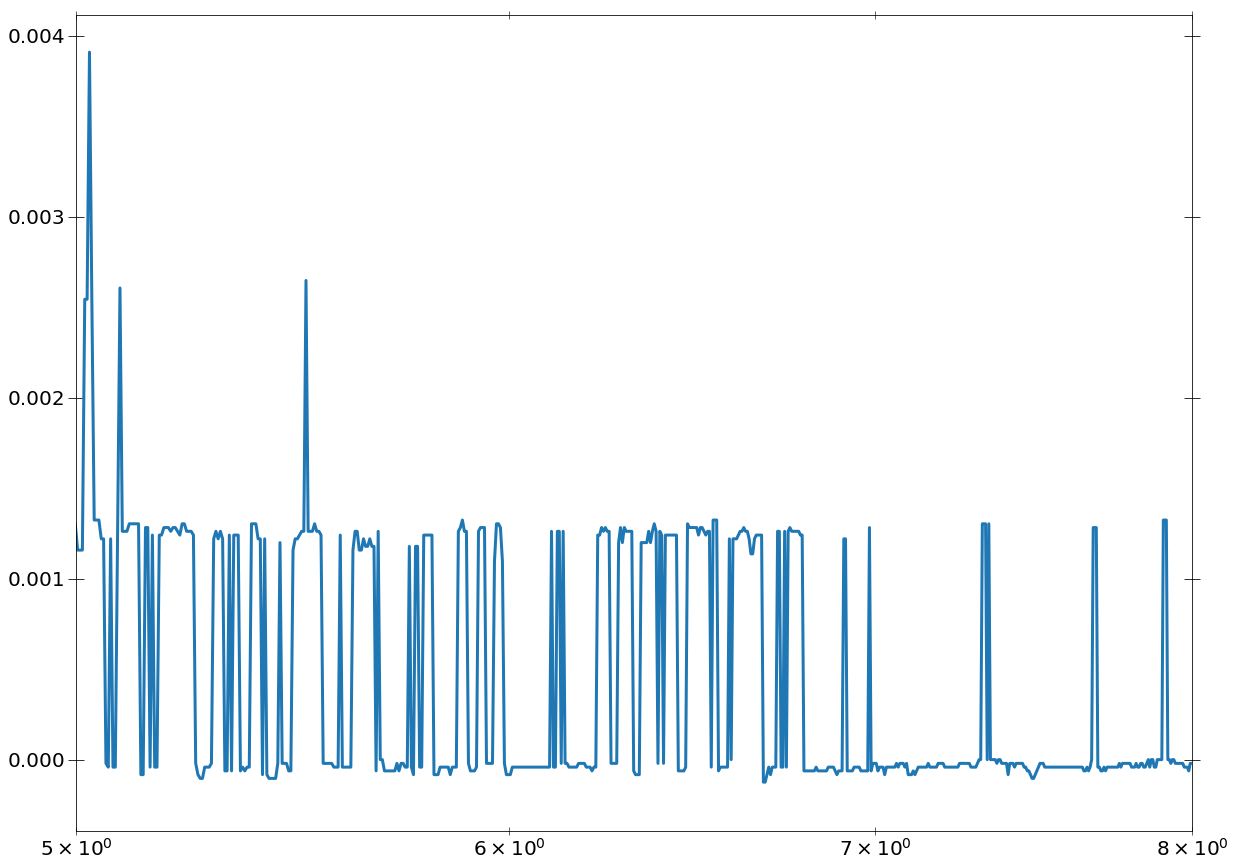

2:80: E501 line too long (130 > 79 characters)


In [62]:
plt.plot(spec_summary['ebins'][1][1][400:2000],
         median_filter(spec_summary['norm_specs'][1][1][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]], size=5))
plt.xlim(5.0, 8.0)
plt.xscale('log')

In [67]:
spec_summary['src_nums'][0][spec_summary['spec_masks'][1][1]][interested_args_alldet[1][11]]

'200305402010002'

In [82]:
from astropy.table import Table
from astropy.table.pprint import conf
conf.max_lines = -1
conf.max_width = -1

In [83]:
Table(np.column_stack([np.array(pn_fit_stats_table_pl)[:, 0],
                       np.array(pn_fit_stats_table_pl_g2)[:, 4],
                       np.array(pn_fit_stats_table_pl)[:, 1],
                       np.array(pn_fit_stats_table_pl_g)[:, 1],
                       np.array(pn_fit_stats_table_pl_g2)[:, 1],
                       np.array(pn_model_params_table_pl_g)[:, 4],
                       np.array(pn_model_params_table_pl_g)[:, 7],
                       np.array(pn_model_params_table_pl_g2)[:, 4],
                       np.array(pn_model_params_table_pl_g2)[:, 5],
                       np.array(pn_model_params_table_pl_g2)[:, 6]]))

<Table length=58>
      col0       col1        col2               col3               col4               col5                 col6                   col7                   col8                   col9         
     str32      str32       str32              str32              str32              str32                str32                  str32                  str32                  str32         
--------------- ----- ------------------ ------------------ ------------------ ------------------ ---------------------- ---------------------- ---------------------- ----------------------
201113501010066  1097  888.3133866673959  881.7070650294453  881.1913228858143  6.495842098254313  5.728099295853509e-07  4.331544399555877e-07 1.9773822826801004e-07 1.5584199303060894e-07
201113501010154  1149  903.3608054015875  898.9897342154572  894.8121029186211  6.416690600469637  3.657184129034429e-07 3.5010040157522126e-07  4.580896096106657e-20 3.0838833914018393e-07
201129701010015   880  729.9447013450703  726.1680242153152   728.208293235638  6.878504435779244 2.8030459351071563e-07  6.557294646155204e-09  3.952180009005394e-08   1.84901608991034e-07
201129704010011  1194 1012.6079029890961 1002.1164436811466 1000.9736609156014  6.376259261068899  1.038662399360663e-06  7.930982457150612e-07  1.384644000570789e-07  4.940973238026691e-07
201129704010019  1215 1029.8154873905944 1025.8642811120633 1025.0969960585987  6.445404018100875  4.927351161304949e-07 3.2552759609400053e-07 1.0890863712728476e-07 3.7679459927014663e-07
201129704010027  1010  785.9195607248512  779.6130717470733  772.8673731092612  6.914603394912961  9.147377125465467e-07  7.142996249303996e-07 2.7521655807736366e-07  8.885324041183697e-07
201129707010012   682   567.787069467711  553.9318661357931  560.4612703153173  6.280521164961761  1.108564397466515e-06  6.793189563458339e-07 2.4888436958518062e-11  7.328702613575944e-08
201129707010063  2029  1603.580620175288 1603.4019947460515 1603.5633270184708  6.818844746386391 1.7222155963966992e-07 1.3274084432954834e-13 4.1359511318018613e-08 2.1443448180484209e-13
201129709010024   900  811.3262222227015  794.8089768017549  781.4206009405018 6.5481877496665355  9.642184610454263e-07  6.496074113129098e-07   6.07007290264001e-07 4.4822010250036727e-07
201129715010041  1034  874.5940461384438  863.4061820593956  856.2815123478654  6.789130174138019  5.935354490473833e-07  4.044163041726859e-07 3.4045138379642045e-07  2.829822266799647e-07
201129721010070  1536 1368.7909668927011 1363.6786628556076 1359.2717472122838  6.698765985480515  3.636688327975731e-07  2.536432877641739e-07 2.7199356036791055e-07  6.380835318524561e-08
201129721010126  2247 2056.1101220958135  2053.200585681294  2056.155328694617  6.100000000039239 1.9827337971923438e-07  1.123985724773552e-19 2.2605979657196566e-08 1.0167671193164822e-21
204003401010007  1384 1141.6552412391381 1141.5054008909347 1141.6854008904472  7.299999998226762  7.519391980881133e-08 6.2415342406533365e-15 2.1783277157329295e-15 2.4556035404823284e-16
204105804010005  1831  1497.955651820031 1491.1449179670433 1494.0475189246063  6.335984950645728  9.956675298151302e-07  5.889168575620609e-07  4.101678286897325e-14  1.508131704458345e-07
206556701010012  1498 1186.5589869334085 1158.4382948149878   1156.93355462016  6.664569714183259  9.879737143004975e-07  1.258050961555429e-07  8.132278353689629e-07  3.694738627039989e-12
208016803010001  1130   991.648224955775  986.3285668155654  986.6302556755354   6.47529835813703  1.348419485181247e-06 1.0077564820562453e-06 3.5762682889789996e-07  6.663621104605321e-15
208016813010003   760  609.6442782716246   607.318719084682  608.3194279092002  6.922400232207302  3.887961194557842e-07  3.958987589518239e-08  5.459081399403479e-22 3.2083101899889503e-07
208251401010006  1153  885.2047801624528  868.0245187034831  865.2031044494875  6.796034861844605 1.0310878445694557e-06 2.0726588575814643e-07  6.388394028854008e-07   6.25504734638

In [75]:
np.array(pn_fit_stats_table_pl)

array([['201113501010066', '888.3133866673959', '-8.204968056946765',
        '50.0', '1100'],
       ['201113501010154', '903.3608054015875', '-7.9889327474572935',
        '50.0', '1152'],
       ['201129701010015', '729.9447013450703', '-6.853237332107479',
        '50.0', '883'],
       ['201129704010011', '1012.6079029890961', '-4.516491937423837',
        '50.0', '1197'],
       ['201129704010019', '1029.8154873905944', '-8.696263026204749',
        '50.0', '1218'],
       ['201129704010027', '785.9195607248512', '-7.299622810407817',
        '50.0', '1013'],
       ['201129707010012', '567.787069467711', '-7.714088239148532',
        '50.0', '685'],
       ['201129707010063', '1603.580620175288', '-5.885724150152902',
        '50.0', '2032'],
       ['201129709010024', '811.3262222227015', '-6.198280503456527',
        '50.0', '903'],
       ['201129715010041', '874.5940461384438', '-8.348768445708139',
        '50.0', '1037'],
       ['201129721010070', '1368.7909668927011', '-